Note: Need to be in 'pymer4' python environment to run this

In [3]:
import pandas as pd 
import numpy as np
import os.path
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from pymer4.models import Lmer
from nltools.stats import circle_shift, zscore
from tqdm import tqdm

%matplotlib inline
sns.set_style("white")

base_dir = os.path.dirname(os.getcwd())

In [4]:
data = pd.read_csv(os.path.join(base_dir,'Analyses','binned_connection_and_gaps_strangers.csv'))

In [5]:
data.head()

,subID,partnerID,dyad,bin_num,gap_length_mean_1,gap_length_median_1,connection_1,num_turns_1,gap_length_mean_2,gap_length_median_2,...,connection_40,num_turns_40,gap_length_mean_60,gap_length_median_60,connection_60,num_turns_60,gap_length_mean_120,gap_length_median_120,connection_120,num_turns_120
0,103,101,103_101,0.0,435.802395,356.0,67.367500,167.0,411.223404,373.0,...,19.013333,8.0,530.25,476.5,13.31,4.0,584.333333,486.0,8.08,3.0
1,101,103,103_101,0.0,435.802395,356.0,62.877833,167.0,411.223404,373.0,...,44.800000,8.0,530.25,476.5,41.11,4.0,584.333333,486.0,43.06,3.0
2,103,101,103_101,1.0,NaN,NaN,NaN,NaN,467.452055,334.0,...,53.320000,4.0,476.00,502.5,40.36,6.0,368.000000,368.0,18.54,1.0
3,101,103,103_101,1.0,NaN,NaN,NaN,NaN,467.452055,334.0,...,44.240000,4.0,476.00,502.5,54.20,6.0,368.000000,368.0,39.16,1.0
4,103,101,103_101,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,55.620000,8.0,489.50,489.5,54.83,2.0,571.250000,502.5,30.42,4.0


# Effect of gap length on connection for each bin size

In [10]:
df_real = pd.DataFrame()
df_real = df_real.fillna(0)
counter = 0

num_bins_list = [2, 3, 4, 5, 6, 10, 12,
                15, 20, 24, 30, 40, 60, 120]

for num_bins in num_bins_list:
    
    columns = [f'connection_{num_bins}', f'gap_length_mean_{num_bins}', 'bin_num', 'subID', 'dyad']
    data_subset = data[columns]
    data_subset_no_nans = data_subset.loc[data_subset['bin_num'] <= (num_bins - 1)].reset_index(drop=True)

    variables = [f'connection_{num_bins}', f'gap_length_mean_{num_bins}', 'bin_num']
    for variable in variables:
        data_subset_no_nans[f'{variable}_zscore'] = zscore(data_subset_no_nans[variable])

    #model = Lmer(f"connection_{num_bins}_zscore ~ gap_length_mean_{num_bins}_zscore + bin_num_zscore + (1|subID) + (1|dyad)", data=data_subset_no_nans)
    model = Lmer(f"connection_{num_bins}_zscore ~ gap_length_mean_{num_bins}_zscore + bin_num_zscore + (1 + gap_length_mean_{num_bins}_zscore |subID) + (1 + bin_num_zscore |dyad)", data=data_subset_no_nans)
    model.fit()
        
    df_real.at[counter, 'num_bins'] = num_bins
    df_real.at[counter, 'bin_size'] = 600 / num_bins
    df_real.at[counter, 'beta'] = model.coefs['Estimate'][1]
    df_real.at[counter, 'p-val'] = model.coefs['P-val'][1]

    counter += 1
        
df_real.to_csv(os.path.join(base_dir, 'Analyses', 'within_convo_analysis_different_bins_strangers.csv'), encoding='utf-8', index=False)
    

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_zscore+bin_num_zscore+(1+gap_length_mean_2_zscore|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1397.598 	 AIC: 2795.196

Random effects:

                              Name    Var    Std
dyad                   (Intercept)  0.238  0.488
dyad                bin_num_zscore  0.005  0.069
subID                  (Intercept)  0.320  0.565
subID     gap_length_mean_2_zscore  0.034  0.185
Residual                            0.300  0.548

               IV1                       IV2   Corr
dyad   (Intercept)            bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_zscore -0.074

Fixed effects:

Formula: connection_3_zscore~gap_length_mean_3_zscore+bin_num_zscore+(1+gap_length_mean_3_zscore|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observati

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_zscore+bin_num_zscore+(1+gap_length_mean_24_zscore|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13598.980 	 AIC: 27197.960

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.309  0.556
dyad                 bin_num_zscore  0.060  0.245
subID                   (Intercept)  0.288  0.537
subID     gap_length_mean_24_zscore  0.003  0.054
Residual                             0.314  0.560

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.278
su

In [11]:
df_real

,num_bins,bin_size,beta,p-val
0,2.0,300.0,-0.220548,7.554314e-08
1,3.0,200.0,-0.163478,1.176584e-06
2,4.0,150.0,-0.114377,4.950816e-05
3,5.0,120.0,-0.087269,3.111733e-04
4,6.0,100.0,-0.076583,9.780073e-04
5,10.0,60.0,-0.043629,6.988937e-03
6,12.0,50.0,-0.036135,1.029694e-02
7,15.0,40.0,-0.035791,3.312694e-03
8,20.0,30.0,-0.032210,2.041096e-03
9,24.0,25.0,-0.024035,8.195034e-03


# Circle-shift each bin

In [76]:
df_shifted = pd.DataFrame()
df_shifted = df_shifted.fillna(0)
counter = 0

num_bins_list = [2, 3, 4, 5, 6, 10, 12,
                15, 20, 24, 30, 40, 60, 120]

for num_bins in num_bins_list:
    
    columns = [f'connection_{num_bins}', f'gap_length_mean_{num_bins}', 'bin_num', 'subID', 'dyad']
    data_subset = data[columns]
    data_subset_no_nans = data_subset.loc[data_subset['bin_num'] <= (num_bins - 1)].reset_index(drop=True)

    variables = [f'connection_{num_bins}', f'gap_length_mean_{num_bins}', 'bin_num']
    for variable in variables:
        data_subset_no_nans[f'{variable}_zscore'] = zscore(data_subset_no_nans[variable])

    shifted_betas = []
    shifted_p_vals = []

    for _ in tqdm(range(100)):

        data_subset_no_nans[f'gap_length_mean_{num_bins}_shifted'] = data_subset_no_nans[f'gap_length_mean_{num_bins}_zscore'].groupby(data_subset_no_nans['dyad']).transform(circle_shift)
        #model = Lmer(f"connection_{num_bins}_zscore ~ gap_length_mean_{num_bins}_shifted + bin_num_zscore + (1|subID) + (1|dyad)", data=data_subset_no_nans)
        model = Lmer(f"connection_{num_bins}_zscore ~ gap_length_mean_{num_bins}_shifted + bin_num_zscore + (1 + gap_length_mean_{num_bins}_shifted |subID) + (1 + bin_num_zscore |dyad)", data=data_subset_no_nans)
        model.fit()

        shifted_betas.append(model.coefs['Estimate'][1])
        shifted_p_vals.append(model.coefs['P-val'][1])
        
    for i in range(len(shifted_betas)):
        df_shifted.at[counter, 'num_bins'] = num_bins
        df_shifted.at[counter, 'bin_size'] = 600 / num_bins
        df_shifted.at[counter, 'betas'] = shifted_betas[i]
        df_shifted.at[counter, 'p-val'] = shifted_p_vals[i]
        
        counter += 1
        
df_shifted.to_csv(os.path.join(base_dir, 'Analyses', 'within_convo_analysis_circle_shifted_strangers.csv'), encoding='utf-8', index=False)
    

  1%|          | 1/100 [00:01<02:43,  1.65s/it]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1410.785 	 AIC: 2821.570

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.248  0.498
dyad                 bin_num_zscore  0.006  0.074
subID                   (Intercept)  0.327  0.572
subID     gap_length_mean_2_shifted  0.035  0.187
Residual                             0.304  0.551

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted  0.004

Fixed effects:



  2%|▏         | 2/100 [00:02<01:51,  1.14s/it]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1409.623 	 AIC: 2819.246

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.243  0.493
dyad                 bin_num_zscore  0.005  0.070
subID                   (Intercept)  0.323  0.568
subID     gap_length_mean_2_shifted  0.027  0.164
Residual                             0.308  0.555

               IV1                        IV2  Corr
dyad   (Intercept)             bin_num_zscore  1.00
subID  (Intercept)  gap_length_mean_2_shifted  0.08

Fixed effects:



  3%|▎         | 3/100 [00:03<01:33,  1.04it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1409.128 	 AIC: 2818.256

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.243  0.493
dyad                 bin_num_zscore  0.005  0.069
subID                   (Intercept)  0.327  0.572
subID     gap_length_mean_2_shifted  0.029  0.170
Residual                             0.307  0.554

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted  0.054

Fixed effects:



  4%|▍         | 4/100 [00:03<01:22,  1.16it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1404.060 	 AIC: 2808.121

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.239  0.489
dyad                 bin_num_zscore  0.004  0.060
subID                   (Intercept)  0.322  0.568
subID     gap_length_mean_2_shifted  0.042  0.206
Residual                             0.302  0.550

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted  0.191

Fixed effects:



  5%|▌         | 5/100 [00:04<01:17,  1.23it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1406.514 	 AIC: 2813.028

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.240  0.490
dyad                 bin_num_zscore  0.004  0.064
subID                   (Intercept)  0.323  0.569
subID     gap_length_mean_2_shifted  0.026  0.160
Residual                             0.307  0.554

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted  0.069

Fixed effects:



  6%|▌         | 6/100 [00:05<01:13,  1.28it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1410.891 	 AIC: 2821.781

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.245  0.495
dyad                 bin_num_zscore  0.005  0.074
subID                   (Intercept)  0.321  0.567
subID     gap_length_mean_2_shifted  0.024  0.155
Residual                             0.309  0.555

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted -0.027

Fixed effects:



  7%|▋         | 7/100 [00:06<01:14,  1.25it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1409.425 	 AIC: 2818.850

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.244  0.494
dyad                 bin_num_zscore  0.005  0.071
subID                   (Intercept)  0.317  0.563
subID     gap_length_mean_2_shifted  0.031  0.175
Residual                             0.307  0.554

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted  0.064

Fixed effects:



  8%|▊         | 8/100 [00:06<01:12,  1.26it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1404.932 	 AIC: 2809.864

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.240  0.489
dyad                 bin_num_zscore  0.004  0.067
subID                   (Intercept)  0.323  0.568
subID     gap_length_mean_2_shifted  0.028  0.167
Residual                             0.306  0.553

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted  0.029

Fixed effects:



  9%|▉         | 9/100 [00:07<01:11,  1.28it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1403.129 	 AIC: 2806.257

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.239  0.489
dyad                 bin_num_zscore  0.005  0.072
subID                   (Intercept)  0.317  0.563
subID     gap_length_mean_2_shifted  0.038  0.194
Residual                             0.302  0.550

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted  0.092

Fixed effects:



 10%|█         | 10/100 [00:08<01:19,  1.14it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1410.739 	 AIC: 2821.477

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.245  0.495
dyad                 bin_num_zscore  0.005  0.073
subID                   (Intercept)  0.324  0.569
subID     gap_length_mean_2_shifted  0.023  0.152
Residual                             0.309  0.556

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted  0.008

Fixed effects:



 11%|█         | 11/100 [00:09<01:19,  1.12it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1406.911 	 AIC: 2813.823

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.242  0.492
dyad                 bin_num_zscore  0.005  0.071
subID                   (Intercept)  0.317  0.563
subID     gap_length_mean_2_shifted  0.033  0.180
Residual                             0.305  0.552

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted  0.088

Fixed effects:



 12%|█▏        | 12/100 [00:10<01:16,  1.15it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1413.153 	 AIC: 2826.306

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.249  0.499
dyad                 bin_num_zscore  0.005  0.067
subID                   (Intercept)  0.316  0.562
subID     gap_length_mean_2_shifted  0.030  0.173
Residual                             0.308  0.555

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted  0.113

Fixed effects:



 13%|█▎        | 13/100 [00:11<01:13,  1.19it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1411.183 	 AIC: 2822.366

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.243  0.493
dyad                 bin_num_zscore  0.005  0.073
subID                   (Intercept)  0.320  0.566
subID     gap_length_mean_2_shifted  0.030  0.173
Residual                             0.308  0.555

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted  0.025

Fixed effects:



 14%|█▍        | 14/100 [00:12<01:16,  1.12it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1401.498 	 AIC: 2802.996

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.239  0.489
dyad                 bin_num_zscore  0.005  0.073
subID                   (Intercept)  0.325  0.570
subID     gap_length_mean_2_shifted  0.032  0.179
Residual                             0.302  0.549

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted -0.004

Fixed effects:



 15%|█▌        | 15/100 [00:13<01:14,  1.14it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1402.933 	 AIC: 2805.865

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.240  0.490
dyad                 bin_num_zscore  0.005  0.069
subID                   (Intercept)  0.317  0.563
subID     gap_length_mean_2_shifted  0.048  0.218
Residual                             0.299  0.547

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted  0.015

Fixed effects:



 16%|█▌        | 16/100 [00:13<01:11,  1.17it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1407.292 	 AIC: 2814.584

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.240  0.490
dyad                 bin_num_zscore  0.005  0.068
subID                   (Intercept)  0.321  0.566
subID     gap_length_mean_2_shifted  0.027  0.164
Residual                             0.307  0.554

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted  0.044

Fixed effects:



 17%|█▋        | 17/100 [00:14<01:09,  1.20it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1410.735 	 AIC: 2821.470

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.244  0.493
dyad                 bin_num_zscore  0.005  0.068
subID                   (Intercept)  0.322  0.568
subID     gap_length_mean_2_shifted  0.020  0.143
Residual                             0.311  0.557

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted  0.074

Fixed effects:



 18%|█▊        | 18/100 [00:15<01:06,  1.24it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1410.927 	 AIC: 2821.853

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.246  0.496
dyad                 bin_num_zscore  0.005  0.072
subID                   (Intercept)  0.323  0.568
subID     gap_length_mean_2_shifted  0.032  0.178
Residual                             0.306  0.553

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted  0.085

Fixed effects:



 19%|█▉        | 19/100 [00:16<01:03,  1.27it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1403.004 	 AIC: 2806.007

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.241  0.490
dyad                 bin_num_zscore  0.005  0.069
subID                   (Intercept)  0.324  0.569
subID     gap_length_mean_2_shifted  0.046  0.214
Residual                             0.299  0.547

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted  0.103

Fixed effects:



 20%|██        | 20/100 [00:16<01:01,  1.29it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1412.050 	 AIC: 2824.100

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.245  0.495
dyad                 bin_num_zscore  0.005  0.074
subID                   (Intercept)  0.324  0.570
subID     gap_length_mean_2_shifted  0.020  0.141
Residual                             0.311  0.557

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted  0.003

Fixed effects:



 21%|██        | 21/100 [00:17<00:59,  1.32it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1410.298 	 AIC: 2820.595

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.246  0.496
dyad                 bin_num_zscore  0.005  0.073
subID                   (Intercept)  0.321  0.566
subID     gap_length_mean_2_shifted  0.024  0.156
Residual                             0.308  0.555

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted -0.064

Fixed effects:



 22%|██▏       | 22/100 [00:18<00:58,  1.32it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1407.476 	 AIC: 2814.952

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.244  0.494
dyad                 bin_num_zscore  0.004  0.064
subID                   (Intercept)  0.315  0.561
subID     gap_length_mean_2_shifted  0.039  0.196
Residual                             0.304  0.551

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted  0.048

Fixed effects:



 23%|██▎       | 23/100 [00:19<01:06,  1.16it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1409.079 	 AIC: 2818.158

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.243  0.493
dyad                 bin_num_zscore  0.004  0.061
subID                   (Intercept)  0.323  0.568
subID     gap_length_mean_2_shifted  0.035  0.187
Residual                             0.306  0.553

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted  0.126

Fixed effects:



 24%|██▍       | 24/100 [00:20<01:02,  1.22it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1415.457 	 AIC: 2830.915

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.249  0.499
dyad                 bin_num_zscore  0.005  0.074
subID                   (Intercept)  0.324  0.569
subID     gap_length_mean_2_shifted  0.022  0.148
Residual                             0.311  0.558

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted -0.013

Fixed effects:



 25%|██▌       | 25/100 [00:21<01:01,  1.23it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1410.750 	 AIC: 2821.501

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.247  0.497
dyad                 bin_num_zscore  0.006  0.074
subID                   (Intercept)  0.322  0.568
subID     gap_length_mean_2_shifted  0.029  0.170
Residual                             0.306  0.554

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted -0.008

Fixed effects:



 26%|██▌       | 26/100 [00:21<00:58,  1.26it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1417.108 	 AIC: 2834.217

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.250  0.500
dyad                 bin_num_zscore  0.005  0.072
subID                   (Intercept)  0.322  0.568
subID     gap_length_mean_2_shifted  0.026  0.160
Residual                             0.311  0.557

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted  0.046

Fixed effects:



 27%|██▋       | 27/100 [00:22<00:56,  1.29it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1416.332 	 AIC: 2832.665

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.248  0.498
dyad                 bin_num_zscore  0.005  0.070
subID                   (Intercept)  0.321  0.566
subID     gap_length_mean_2_shifted  0.019  0.136
Residual                             0.313  0.560

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted -0.039

Fixed effects:



 28%|██▊       | 28/100 [00:23<00:57,  1.26it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1408.222 	 AIC: 2816.443

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.242  0.492
dyad                 bin_num_zscore  0.005  0.069
subID                   (Intercept)  0.324  0.569
subID     gap_length_mean_2_shifted  0.023  0.153
Residual                             0.308  0.555

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted  0.066

Fixed effects:



 29%|██▉       | 29/100 [00:24<00:57,  1.24it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1402.381 	 AIC: 2804.763

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.238  0.488
dyad                 bin_num_zscore  0.005  0.071
subID                   (Intercept)  0.320  0.565
subID     gap_length_mean_2_shifted  0.038  0.194
Residual                             0.302  0.549

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted -0.041

Fixed effects:



 30%|███       | 30/100 [00:25<00:57,  1.21it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1407.734 	 AIC: 2815.468

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.244  0.494
dyad                 bin_num_zscore  0.005  0.072
subID                   (Intercept)  0.322  0.568
subID     gap_length_mean_2_shifted  0.031  0.177
Residual                             0.305  0.552

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted -0.021

Fixed effects:



 31%|███       | 31/100 [00:25<00:57,  1.20it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1406.962 	 AIC: 2813.924

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.242  0.491
dyad                 bin_num_zscore  0.005  0.069
subID                   (Intercept)  0.320  0.566
subID     gap_length_mean_2_shifted  0.030  0.174
Residual                             0.306  0.553

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted  0.008

Fixed effects:



 32%|███▏      | 32/100 [00:26<00:56,  1.21it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1404.956 	 AIC: 2809.912

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.243  0.492
dyad                 bin_num_zscore  0.005  0.069
subID                   (Intercept)  0.320  0.566
subID     gap_length_mean_2_shifted  0.033  0.182
Residual                             0.303  0.551

               IV1                        IV2  Corr
dyad   (Intercept)             bin_num_zscore  1.00
subID  (Intercept)  gap_length_mean_2_shifted  0.09

Fixed effects:



 33%|███▎      | 33/100 [00:27<00:54,  1.23it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1407.130 	 AIC: 2814.260

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.242  0.492
dyad                 bin_num_zscore  0.005  0.070
subID                   (Intercept)  0.317  0.563
subID     gap_length_mean_2_shifted  0.037  0.193
Residual                             0.304  0.551

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted  0.044

Fixed effects:



 34%|███▍      | 34/100 [00:28<00:52,  1.26it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1409.001 	 AIC: 2818.001

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.242  0.492
dyad                 bin_num_zscore  0.005  0.072
subID                   (Intercept)  0.324  0.569
subID     gap_length_mean_2_shifted  0.022  0.147
Residual                             0.309  0.556

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted  0.059

Fixed effects:



 35%|███▌      | 35/100 [00:29<00:50,  1.28it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1403.559 	 AIC: 2807.118

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.241  0.491
dyad                 bin_num_zscore  0.005  0.074
subID                   (Intercept)  0.319  0.564
subID     gap_length_mean_2_shifted  0.031  0.177
Residual                             0.303  0.550

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted -0.036

Fixed effects:



 36%|███▌      | 36/100 [00:29<00:49,  1.30it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1414.728 	 AIC: 2829.456

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.247  0.497
dyad                 bin_num_zscore  0.005  0.071
subID                   (Intercept)  0.321  0.567
subID     gap_length_mean_2_shifted  0.026  0.160
Residual                             0.310  0.557

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted -0.011

Fixed effects:



 37%|███▋      | 37/100 [00:30<00:48,  1.31it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1412.300 	 AIC: 2824.599

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.248  0.498
dyad                 bin_num_zscore  0.006  0.074
subID                   (Intercept)  0.323  0.569
subID     gap_length_mean_2_shifted  0.021  0.146
Residual                             0.309  0.556

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted -0.086

Fixed effects:



 38%|███▊      | 38/100 [00:31<00:46,  1.33it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1411.251 	 AIC: 2822.502

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.243  0.493
dyad                 bin_num_zscore  0.005  0.069
subID                   (Intercept)  0.321  0.566
subID     gap_length_mean_2_shifted  0.025  0.159
Residual                             0.309  0.556

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted  0.044

Fixed effects:



 39%|███▉      | 39/100 [00:32<00:45,  1.33it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1404.569 	 AIC: 2809.137

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.238  0.488
dyad                 bin_num_zscore  0.004  0.063
subID                   (Intercept)  0.321  0.566
subID     gap_length_mean_2_shifted  0.033  0.181
Residual                             0.305  0.552

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted  0.042

Fixed effects:



 40%|████      | 40/100 [00:32<00:44,  1.34it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1409.295 	 AIC: 2818.589

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.244  0.494
dyad                 bin_num_zscore  0.005  0.071
subID                   (Intercept)  0.322  0.568
subID     gap_length_mean_2_shifted  0.031  0.176
Residual                             0.306  0.553

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted -0.012

Fixed effects:



 41%|████      | 41/100 [00:33<00:43,  1.34it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1409.743 	 AIC: 2819.486

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.242  0.492
dyad                 bin_num_zscore  0.004  0.067
subID                   (Intercept)  0.320  0.566
subID     gap_length_mean_2_shifted  0.027  0.164
Residual                             0.308  0.555

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted  0.049

Fixed effects:



 42%|████▏     | 42/100 [00:34<00:43,  1.35it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1401.316 	 AIC: 2802.632

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.240  0.490
dyad                 bin_num_zscore  0.005  0.070
subID                   (Intercept)  0.318  0.564
subID     gap_length_mean_2_shifted  0.032  0.178
Residual                             0.302  0.550

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted -0.076

Fixed effects:



 43%|████▎     | 43/100 [00:34<00:42,  1.36it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1409.164 	 AIC: 2818.328

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.245  0.495
dyad                 bin_num_zscore  0.005  0.074
subID                   (Intercept)  0.322  0.568
subID     gap_length_mean_2_shifted  0.020  0.142
Residual                             0.309  0.556

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted -0.003

Fixed effects:



 44%|████▍     | 44/100 [00:35<00:41,  1.36it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1406.378 	 AIC: 2812.755

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.243  0.493
dyad                 bin_num_zscore  0.006  0.077
subID                   (Intercept)  0.320  0.566
subID     gap_length_mean_2_shifted  0.027  0.163
Residual                             0.305  0.553

               IV1                        IV2  Corr
dyad   (Intercept)             bin_num_zscore   1.0
subID  (Intercept)  gap_length_mean_2_shifted  -0.0

Fixed effects:



 45%|████▌     | 45/100 [00:36<00:39,  1.38it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1412.400 	 AIC: 2824.799

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.248  0.498
dyad                 bin_num_zscore  0.005  0.070
subID                   (Intercept)  0.324  0.570
subID     gap_length_mean_2_shifted  0.026  0.162
Residual                             0.308  0.555

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted  0.045

Fixed effects:



 46%|████▌     | 46/100 [00:37<00:39,  1.38it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1413.007 	 AIC: 2826.013

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.243  0.493
dyad                 bin_num_zscore  0.004  0.063
subID                   (Intercept)  0.324  0.569
subID     gap_length_mean_2_shifted  0.030  0.174
Residual                             0.309  0.556

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted  0.056

Fixed effects:



 47%|████▋     | 47/100 [00:37<00:38,  1.39it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1410.560 	 AIC: 2821.121

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.243  0.493
dyad                 bin_num_zscore  0.005  0.070
subID                   (Intercept)  0.322  0.567
subID     gap_length_mean_2_shifted  0.022  0.148
Residual                             0.310  0.557

               IV1                        IV2  Corr
dyad   (Intercept)             bin_num_zscore  1.00
subID  (Intercept)  gap_length_mean_2_shifted -0.01

Fixed effects:



 48%|████▊     | 48/100 [00:38<00:37,  1.40it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1411.219 	 AIC: 2822.438

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.244  0.494
dyad                 bin_num_zscore  0.004  0.065
subID                   (Intercept)  0.324  0.569
subID     gap_length_mean_2_shifted  0.029  0.172
Residual                             0.308  0.555

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted  0.119

Fixed effects:



 49%|████▉     | 49/100 [00:39<00:37,  1.37it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1404.726 	 AIC: 2809.452

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.239  0.489
dyad                 bin_num_zscore  0.004  0.064
subID                   (Intercept)  0.320  0.565
subID     gap_length_mean_2_shifted  0.024  0.155
Residual                             0.307  0.554

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted  0.016

Fixed effects:



 50%|█████     | 50/100 [00:40<00:37,  1.33it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1408.063 	 AIC: 2816.125

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.242  0.492
dyad                 bin_num_zscore  0.004  0.066
subID                   (Intercept)  0.321  0.567
subID     gap_length_mean_2_shifted  0.024  0.155
Residual                             0.308  0.555

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted  0.011

Fixed effects:



 51%|█████     | 51/100 [00:40<00:37,  1.30it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1407.105 	 AIC: 2814.211

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.243  0.493
dyad                 bin_num_zscore  0.005  0.070
subID                   (Intercept)  0.323  0.569
subID     gap_length_mean_2_shifted  0.028  0.168
Residual                             0.306  0.553

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted  0.161

Fixed effects:



 52%|█████▏    | 52/100 [00:41<00:36,  1.31it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1411.161 	 AIC: 2822.322

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.244  0.494
dyad                 bin_num_zscore  0.005  0.071
subID                   (Intercept)  0.322  0.568
subID     gap_length_mean_2_shifted  0.022  0.150
Residual                             0.310  0.557

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted  0.041

Fixed effects:



 53%|█████▎    | 53/100 [00:42<00:36,  1.30it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1407.710 	 AIC: 2815.420

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.241  0.491
dyad                 bin_num_zscore  0.005  0.068
subID                   (Intercept)  0.325  0.570
subID     gap_length_mean_2_shifted  0.031  0.177
Residual                             0.306  0.553

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted  0.031

Fixed effects:



 54%|█████▍    | 54/100 [00:43<00:36,  1.27it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1406.559 	 AIC: 2813.117

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.244  0.494
dyad                 bin_num_zscore  0.005  0.073
subID                   (Intercept)  0.320  0.566
subID     gap_length_mean_2_shifted  0.024  0.154
Residual                             0.307  0.554

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted -0.125

Fixed effects:



 55%|█████▌    | 55/100 [00:44<00:35,  1.27it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1414.008 	 AIC: 2828.015

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.248  0.498
dyad                 bin_num_zscore  0.005  0.071
subID                   (Intercept)  0.325  0.570
subID     gap_length_mean_2_shifted  0.020  0.141
Residual                             0.311  0.558

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted -0.141

Fixed effects:



 56%|█████▌    | 56/100 [00:44<00:34,  1.27it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1408.207 	 AIC: 2816.414

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.247  0.497
dyad                 bin_num_zscore  0.005  0.073
subID                   (Intercept)  0.318  0.564
subID     gap_length_mean_2_shifted  0.030  0.174
Residual                             0.305  0.552

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted  0.007

Fixed effects:



 57%|█████▋    | 57/100 [00:45<00:35,  1.21it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1410.998 	 AIC: 2821.996

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.246  0.496
dyad                 bin_num_zscore  0.006  0.076
subID                   (Intercept)  0.326  0.571
subID     gap_length_mean_2_shifted  0.025  0.159
Residual                             0.308  0.555

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted  0.024

Fixed effects:



 58%|█████▊    | 58/100 [00:46<00:34,  1.23it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1415.829 	 AIC: 2831.657

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.248  0.498
dyad                 bin_num_zscore  0.005  0.070
subID                   (Intercept)  0.319  0.564
subID     gap_length_mean_2_shifted  0.020  0.143
Residual                             0.313  0.559

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted  0.006

Fixed effects:



 59%|█████▉    | 59/100 [00:47<00:32,  1.25it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1406.942 	 AIC: 2813.885

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.243  0.493
dyad                 bin_num_zscore  0.006  0.075
subID                   (Intercept)  0.322  0.568
subID     gap_length_mean_2_shifted  0.026  0.161
Residual                             0.306  0.553

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted  0.088

Fixed effects:



 60%|██████    | 60/100 [00:48<00:30,  1.29it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1411.212 	 AIC: 2822.423

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.248  0.498
dyad                 bin_num_zscore  0.005  0.071
subID                   (Intercept)  0.323  0.568
subID     gap_length_mean_2_shifted  0.031  0.175
Residual                             0.306  0.553

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted  0.003

Fixed effects:



 61%|██████    | 61/100 [00:48<00:29,  1.32it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1407.501 	 AIC: 2815.002

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.242  0.492
dyad                 bin_num_zscore  0.004  0.063
subID                   (Intercept)  0.319  0.565
subID     gap_length_mean_2_shifted  0.028  0.168
Residual                             0.307  0.554

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted  0.064

Fixed effects:



 62%|██████▏   | 62/100 [00:49<00:28,  1.34it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1410.507 	 AIC: 2821.015

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.242  0.492
dyad                 bin_num_zscore  0.004  0.062
subID                   (Intercept)  0.322  0.567
subID     gap_length_mean_2_shifted  0.029  0.170
Residual                             0.308  0.555

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted  0.138

Fixed effects:



 63%|██████▎   | 63/100 [00:50<00:28,  1.32it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1412.469 	 AIC: 2824.938

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.245  0.495
dyad                 bin_num_zscore  0.004  0.066
subID                   (Intercept)  0.319  0.565
subID     gap_length_mean_2_shifted  0.033  0.181
Residual                             0.308  0.555

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted  0.045

Fixed effects:



 64%|██████▍   | 64/100 [00:50<00:26,  1.35it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1408.434 	 AIC: 2816.868

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.240  0.490
dyad                 bin_num_zscore  0.004  0.064
subID                   (Intercept)  0.323  0.568
subID     gap_length_mean_2_shifted  0.028  0.168
Residual                             0.308  0.555

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted  0.037

Fixed effects:



 65%|██████▌   | 65/100 [00:51<00:25,  1.37it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1407.961 	 AIC: 2815.922

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.240  0.490
dyad                 bin_num_zscore  0.005  0.069
subID                   (Intercept)  0.322  0.568
subID     gap_length_mean_2_shifted  0.028  0.168
Residual                             0.307  0.554

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted -0.035

Fixed effects:



 66%|██████▌   | 66/100 [00:52<00:25,  1.33it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1409.315 	 AIC: 2818.630

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.243  0.493
dyad                 bin_num_zscore  0.006  0.074
subID                   (Intercept)  0.320  0.565
subID     gap_length_mean_2_shifted  0.027  0.165
Residual                             0.307  0.554

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted  0.066

Fixed effects:



 67%|██████▋   | 67/100 [00:53<00:24,  1.34it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1402.878 	 AIC: 2805.757

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.238  0.488
dyad                 bin_num_zscore  0.005  0.070
subID                   (Intercept)  0.316  0.562
subID     gap_length_mean_2_shifted  0.035  0.188
Residual                             0.303  0.550

               IV1                        IV2  Corr
dyad   (Intercept)             bin_num_zscore  1.00
subID  (Intercept)  gap_length_mean_2_shifted  0.04

Fixed effects:



 68%|██████▊   | 68/100 [00:54<00:25,  1.27it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1406.613 	 AIC: 2813.226

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.244  0.494
dyad                 bin_num_zscore  0.005  0.073
subID                   (Intercept)  0.317  0.563
subID     gap_length_mean_2_shifted  0.025  0.158
Residual                             0.306  0.554

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted -0.075

Fixed effects:



 69%|██████▉   | 69/100 [00:54<00:23,  1.30it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1408.088 	 AIC: 2816.175

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.242  0.492
dyad                 bin_num_zscore  0.004  0.063
subID                   (Intercept)  0.323  0.568
subID     gap_length_mean_2_shifted  0.034  0.185
Residual                             0.305  0.553

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted  0.071

Fixed effects:



 70%|███████   | 70/100 [00:55<00:23,  1.30it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1409.265 	 AIC: 2818.530

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.242  0.492
dyad                 bin_num_zscore  0.004  0.065
subID                   (Intercept)  0.320  0.565
subID     gap_length_mean_2_shifted  0.034  0.185
Residual                             0.306  0.553

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted  0.162

Fixed effects:



 71%|███████   | 71/100 [00:56<00:22,  1.32it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1410.802 	 AIC: 2821.605

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.246  0.496
dyad                 bin_num_zscore  0.005  0.068
subID                   (Intercept)  0.322  0.568
subID     gap_length_mean_2_shifted  0.029  0.170
Residual                             0.307  0.554

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted  0.017

Fixed effects:



 72%|███████▏  | 72/100 [00:57<00:20,  1.34it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1408.924 	 AIC: 2817.848

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.245  0.495
dyad                 bin_num_zscore  0.005  0.069
subID                   (Intercept)  0.321  0.567
subID     gap_length_mean_2_shifted  0.030  0.174
Residual                             0.306  0.553

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted  0.071

Fixed effects:



 73%|███████▎  | 73/100 [00:57<00:19,  1.36it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1407.675 	 AIC: 2815.351

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.242  0.492
dyad                 bin_num_zscore  0.005  0.069
subID                   (Intercept)  0.323  0.568
subID     gap_length_mean_2_shifted  0.036  0.189
Residual                             0.304  0.552

               IV1                        IV2  Corr
dyad   (Intercept)             bin_num_zscore  1.00
subID  (Intercept)  gap_length_mean_2_shifted  0.11

Fixed effects:



 74%|███████▍  | 74/100 [00:58<00:18,  1.38it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1409.788 	 AIC: 2819.577

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.245  0.495
dyad                 bin_num_zscore  0.005  0.068
subID                   (Intercept)  0.322  0.567
subID     gap_length_mean_2_shifted  0.026  0.161
Residual                             0.308  0.555

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted -0.096

Fixed effects:



 75%|███████▌  | 75/100 [00:59<00:18,  1.38it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1408.769 	 AIC: 2817.538

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.244  0.494
dyad                 bin_num_zscore  0.004  0.062
subID                   (Intercept)  0.317  0.563
subID     gap_length_mean_2_shifted  0.030  0.172
Residual                             0.307  0.554

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted  0.065

Fixed effects:



 76%|███████▌  | 76/100 [00:59<00:17,  1.38it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1410.121 	 AIC: 2820.242

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.245  0.495
dyad                 bin_num_zscore  0.006  0.075
subID                   (Intercept)  0.325  0.570
subID     gap_length_mean_2_shifted  0.024  0.154
Residual                             0.308  0.555

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted  0.014

Fixed effects:



 77%|███████▋  | 77/100 [01:00<00:16,  1.39it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1413.469 	 AIC: 2826.938

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.246  0.496
dyad                 bin_num_zscore  0.006  0.076
subID                   (Intercept)  0.320  0.565
subID     gap_length_mean_2_shifted  0.021  0.146
Residual                             0.311  0.558

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted -0.037

Fixed effects:



 78%|███████▊  | 78/100 [01:01<00:15,  1.39it/s]

Model failed to converge with max|grad| = 0.00351977 (tol = 0.002, component 1) 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1409.966 	 AIC: 2819.932

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.245  0.495
dyad                 bin_num_zscore  0.005  0.073
subID                   (Intercept)  0.321  0.566
subID     gap_length_mean_2_shifted  0.026  0.161
Residual                             0.308  0.555

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted -0.023

Fixed effects:



 79%|███████▉  | 79/100 [01:02<00:15,  1.39it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1409.018 	 AIC: 2818.036

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.244  0.494
dyad                 bin_num_zscore  0.005  0.071
subID                   (Intercept)  0.318  0.564
subID     gap_length_mean_2_shifted  0.028  0.167
Residual                             0.307  0.554

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted -0.042

Fixed effects:



 80%|████████  | 80/100 [01:02<00:14,  1.40it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1410.243 	 AIC: 2820.486

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.244  0.494
dyad                 bin_num_zscore  0.004  0.067
subID                   (Intercept)  0.320  0.566
subID     gap_length_mean_2_shifted  0.026  0.160
Residual                             0.309  0.556

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted -0.057

Fixed effects:



 81%|████████  | 81/100 [01:03<00:13,  1.41it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1400.653 	 AIC: 2801.306

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.239  0.489
dyad                 bin_num_zscore  0.005  0.068
subID                   (Intercept)  0.321  0.566
subID     gap_length_mean_2_shifted  0.034  0.185
Residual                             0.301  0.549

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted -0.099

Fixed effects:



 82%|████████▏ | 82/100 [01:04<00:12,  1.40it/s]

Model failed to converge with max|grad| = 0.00387302 (tol = 0.002, component 1) 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1411.321 	 AIC: 2822.643

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.244  0.494
dyad                 bin_num_zscore  0.005  0.070
subID                   (Intercept)  0.317  0.563
subID     gap_length_mean_2_shifted  0.031  0.175
Residual                             0.308  0.555

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted  0.053

Fixed effects:



 83%|████████▎ | 83/100 [01:04<00:12,  1.39it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1407.323 	 AIC: 2814.645

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.241  0.491
dyad                 bin_num_zscore  0.004  0.066
subID                   (Intercept)  0.322  0.568
subID     gap_length_mean_2_shifted  0.031  0.175
Residual                             0.306  0.553

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted  0.025

Fixed effects:



 84%|████████▍ | 84/100 [01:05<00:11,  1.38it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1410.872 	 AIC: 2821.744

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.244  0.494
dyad                 bin_num_zscore  0.005  0.070
subID                   (Intercept)  0.320  0.566
subID     gap_length_mean_2_shifted  0.024  0.154
Residual                             0.309  0.556

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted -0.053

Fixed effects:



 85%|████████▌ | 85/100 [01:06<00:11,  1.28it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1408.613 	 AIC: 2817.225

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.243  0.493
dyad                 bin_num_zscore  0.005  0.073
subID                   (Intercept)  0.319  0.565
subID     gap_length_mean_2_shifted  0.029  0.169
Residual                             0.307  0.554

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted  0.039

Fixed effects:



 86%|████████▌ | 86/100 [01:07<00:10,  1.32it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1410.418 	 AIC: 2820.836

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.246  0.496
dyad                 bin_num_zscore  0.005  0.071
subID                   (Intercept)  0.320  0.565
subID     gap_length_mean_2_shifted  0.034  0.183
Residual                             0.306  0.553

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted  0.043

Fixed effects:



 87%|████████▋ | 87/100 [01:07<00:09,  1.33it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1411.095 	 AIC: 2822.191

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.247  0.497
dyad                 bin_num_zscore  0.005  0.072
subID                   (Intercept)  0.323  0.568
subID     gap_length_mean_2_shifted  0.028  0.168
Residual                             0.307  0.554

               IV1                        IV2  Corr
dyad   (Intercept)             bin_num_zscore  1.00
subID  (Intercept)  gap_length_mean_2_shifted  0.06

Fixed effects:



 88%|████████▊ | 88/100 [01:08<00:08,  1.36it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1403.986 	 AIC: 2807.972

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.239  0.489
dyad                 bin_num_zscore  0.005  0.068
subID                   (Intercept)  0.320  0.566
subID     gap_length_mean_2_shifted  0.032  0.179
Residual                             0.304  0.552

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted -0.013

Fixed effects:



 89%|████████▉ | 89/100 [01:09<00:08,  1.37it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1408.451 	 AIC: 2816.901

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.242  0.492
dyad                 bin_num_zscore  0.005  0.070
subID                   (Intercept)  0.320  0.566
subID     gap_length_mean_2_shifted  0.034  0.183
Residual                             0.306  0.553

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted  0.065

Fixed effects:



 90%|█████████ | 90/100 [01:10<00:07,  1.38it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1405.267 	 AIC: 2810.533

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.239  0.489
dyad                 bin_num_zscore  0.005  0.072
subID                   (Intercept)  0.321  0.567
subID     gap_length_mean_2_shifted  0.035  0.186
Residual                             0.304  0.551

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted  0.003

Fixed effects:



 91%|█████████ | 91/100 [01:10<00:06,  1.39it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1406.683 	 AIC: 2813.365

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.241  0.491
dyad                 bin_num_zscore  0.005  0.070
subID                   (Intercept)  0.324  0.570
subID     gap_length_mean_2_shifted  0.021  0.146
Residual                             0.308  0.555

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted  0.109

Fixed effects:



 92%|█████████▏| 92/100 [01:11<00:05,  1.39it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1409.373 	 AIC: 2818.745

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.243  0.493
dyad                 bin_num_zscore  0.005  0.073
subID                   (Intercept)  0.320  0.566
subID     gap_length_mean_2_shifted  0.024  0.155
Residual                             0.309  0.555

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted  0.089

Fixed effects:



 93%|█████████▎| 93/100 [01:12<00:05,  1.40it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1406.155 	 AIC: 2812.310

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.241  0.491
dyad                 bin_num_zscore  0.005  0.070
subID                   (Intercept)  0.320  0.565
subID     gap_length_mean_2_shifted  0.029  0.171
Residual                             0.306  0.553

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted -0.076

Fixed effects:



 94%|█████████▍| 94/100 [01:12<00:04,  1.40it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1411.456 	 AIC: 2822.911

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.244  0.494
dyad                 bin_num_zscore  0.005  0.070
subID                   (Intercept)  0.316  0.562
subID     gap_length_mean_2_shifted  0.030  0.173
Residual                             0.308  0.555

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted  0.074

Fixed effects:



 95%|█████████▌| 95/100 [01:13<00:03,  1.41it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1407.530 	 AIC: 2815.061

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.242  0.491
dyad                 bin_num_zscore  0.005  0.069
subID                   (Intercept)  0.323  0.568
subID     gap_length_mean_2_shifted  0.022  0.148
Residual                             0.309  0.555

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted -0.052

Fixed effects:



 96%|█████████▌| 96/100 [01:14<00:02,  1.39it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1405.246 	 AIC: 2810.491

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.242  0.492
dyad                 bin_num_zscore  0.005  0.069
subID                   (Intercept)  0.321  0.567
subID     gap_length_mean_2_shifted  0.029  0.169
Residual                             0.305  0.552

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted  0.051

Fixed effects:



 97%|█████████▋| 97/100 [01:15<00:02,  1.35it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1410.340 	 AIC: 2820.681

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.243  0.493
dyad                 bin_num_zscore  0.006  0.079
subID                   (Intercept)  0.317  0.563
subID     gap_length_mean_2_shifted  0.030  0.175
Residual                             0.307  0.554

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted  0.066

Fixed effects:



 98%|█████████▊| 98/100 [01:15<00:01,  1.37it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1409.899 	 AIC: 2819.798

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.245  0.495
dyad                 bin_num_zscore  0.005  0.069
subID                   (Intercept)  0.322  0.567
subID     gap_length_mean_2_shifted  0.027  0.163
Residual                             0.307  0.555

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted -0.132

Fixed effects:



 99%|█████████▉| 99/100 [01:16<00:00,  1.37it/s]

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1410.615 	 AIC: 2821.229

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.244  0.494
dyad                 bin_num_zscore  0.005  0.070
subID                   (Intercept)  0.322  0.568
subID     gap_length_mean_2_shifted  0.023  0.152
Residual                             0.309  0.556

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted  0.017

Fixed effects:



100%|██████████| 100/100 [01:17<00:00,  1.29it/s]


boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1+gap_length_mean_2_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1411.476 	 AIC: 2822.953

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.245  0.495
dyad                 bin_num_zscore  0.005  0.072
subID                   (Intercept)  0.319  0.565
subID     gap_length_mean_2_shifted  0.030  0.174
Residual                             0.307  0.554

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  1.000
subID  (Intercept)  gap_length_mean_2_shifted  0.002

Fixed effects:



  1%|          | 1/100 [00:00<01:27,  1.14it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2022.688 	 AIC: 4045.376

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.270  0.519
dyad                 bin_num_zscore  0.024  0.156
subID                   (Intercept)  0.305  0.553
subID     gap_length_mean_3_shifted  0.019  0.138
Residual                             0.289  0.538

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.476
subID  (Intercept)  gap_length_mean_3_shifted  0.092

Fixed effects:



  2%|▏         | 2/100 [00:01<01:23,  1.18it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2023.837 	 AIC: 4047.673

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.276  0.526
dyad                 bin_num_zscore  0.026  0.161
subID                   (Intercept)  0.311  0.557
subID     gap_length_mean_3_shifted  0.023  0.153
Residual                             0.286  0.535

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.477
subID  (Intercept)  gap_length_mean_3_shifted -0.073

Fixed effects:



  3%|▎         | 3/100 [00:02<01:23,  1.16it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2024.311 	 AIC: 4048.623

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.269  0.519
dyad                 bin_num_zscore  0.026  0.162
subID                   (Intercept)  0.310  0.557
subID     gap_length_mean_3_shifted  0.016  0.127
Residual                             0.289  0.538

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.477
subID  (Intercept)  gap_length_mean_3_shifted -0.139

Fixed effects:



  4%|▍         | 4/100 [00:03<01:23,  1.15it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2021.977 	 AIC: 4043.955

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.272  0.522
dyad                 bin_num_zscore  0.026  0.161
subID                   (Intercept)  0.309  0.556
subID     gap_length_mean_3_shifted  0.024  0.154
Residual                             0.286  0.535

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.487
subID  (Intercept)  gap_length_mean_3_shifted -0.038

Fixed effects:



  5%|▌         | 5/100 [00:04<01:25,  1.12it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2025.033 	 AIC: 4050.065

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.275  0.525
dyad                 bin_num_zscore  0.024  0.154
subID                   (Intercept)  0.311  0.557
subID     gap_length_mean_3_shifted  0.022  0.147
Residual                             0.289  0.538

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.494
subID  (Intercept)  gap_length_mean_3_shifted -0.061

Fixed effects:



  6%|▌         | 6/100 [00:05<01:28,  1.07it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2019.024 	 AIC: 4038.048

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.271  0.521
dyad                 bin_num_zscore  0.028  0.166
subID                   (Intercept)  0.310  0.557
subID     gap_length_mean_3_shifted  0.025  0.157
Residual                             0.283  0.532

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.445
subID  (Intercept)  gap_length_mean_3_shifted -0.022

Fixed effects:



  7%|▋         | 7/100 [00:06<01:25,  1.09it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2025.942 	 AIC: 4051.885

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.278  0.527
dyad                 bin_num_zscore  0.025  0.159
subID                   (Intercept)  0.305  0.552
subID     gap_length_mean_3_shifted  0.026  0.161
Residual                             0.287  0.535

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.489
subID  (Intercept)  gap_length_mean_3_shifted  0.082

Fixed effects:



  8%|▊         | 8/100 [00:07<01:22,  1.11it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2020.868 	 AIC: 4041.736

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.272  0.522
dyad                 bin_num_zscore  0.025  0.158
subID                   (Intercept)  0.305  0.553
subID     gap_length_mean_3_shifted  0.025  0.158
Residual                             0.286  0.535

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.487
subID  (Intercept)  gap_length_mean_3_shifted  0.060

Fixed effects:



  9%|▉         | 9/100 [00:08<01:20,  1.13it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2021.657 	 AIC: 4043.314

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.273  0.522
dyad                 bin_num_zscore  0.026  0.160
subID                   (Intercept)  0.308  0.555
subID     gap_length_mean_3_shifted  0.022  0.148
Residual                             0.286  0.535

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.461
subID  (Intercept)  gap_length_mean_3_shifted -0.003

Fixed effects:



 10%|█         | 10/100 [00:08<01:19,  1.13it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2026.064 	 AIC: 4052.128

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.273  0.523
dyad                 bin_num_zscore  0.025  0.158
subID                   (Intercept)  0.314  0.561
subID     gap_length_mean_3_shifted  0.021  0.144
Residual                             0.288  0.537

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.457
subID  (Intercept)  gap_length_mean_3_shifted -0.132

Fixed effects:



 11%|█         | 11/100 [00:09<01:19,  1.11it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2023.303 	 AIC: 4046.606

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.271  0.520
dyad                 bin_num_zscore  0.025  0.158
subID                   (Intercept)  0.306  0.553
subID     gap_length_mean_3_shifted  0.020  0.142
Residual                             0.288  0.537

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.477
subID  (Intercept)  gap_length_mean_3_shifted -0.038

Fixed effects:



 12%|█▏        | 12/100 [00:10<01:18,  1.12it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2030.273 	 AIC: 4060.545

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.280  0.529
dyad                 bin_num_zscore  0.025  0.157
subID                   (Intercept)  0.311  0.558
subID     gap_length_mean_3_shifted  0.015  0.123
Residual                             0.291  0.540

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.480
subID  (Intercept)  gap_length_mean_3_shifted -0.081

Fixed effects:



 13%|█▎        | 13/100 [00:11<01:16,  1.14it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2019.440 	 AIC: 4038.880

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.272  0.521
dyad                 bin_num_zscore  0.026  0.162
subID                   (Intercept)  0.309  0.556
subID     gap_length_mean_3_shifted  0.028  0.168
Residual                             0.283  0.532

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.446
subID  (Intercept)  gap_length_mean_3_shifted  0.104

Fixed effects:



 14%|█▍        | 14/100 [00:12<01:13,  1.16it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2012.712 	 AIC: 4025.425

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.267  0.516
dyad                 bin_num_zscore  0.028  0.168
subID                   (Intercept)  0.307  0.554
subID     gap_length_mean_3_shifted  0.028  0.168
Residual                             0.281  0.530

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.479
subID  (Intercept)  gap_length_mean_3_shifted -0.031

Fixed effects:



 15%|█▌        | 15/100 [00:13<01:13,  1.16it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2030.171 	 AIC: 4060.342

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.281  0.530
dyad                 bin_num_zscore  0.027  0.164
subID                   (Intercept)  0.310  0.557
subID     gap_length_mean_3_shifted  0.018  0.133
Residual                             0.288  0.537

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.477
subID  (Intercept)  gap_length_mean_3_shifted -0.043

Fixed effects:



 16%|█▌        | 16/100 [00:14<01:13,  1.14it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2021.095 	 AIC: 4042.190

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.270  0.520
dyad                 bin_num_zscore  0.027  0.165
subID                   (Intercept)  0.307  0.554
subID     gap_length_mean_3_shifted  0.024  0.153
Residual                             0.285  0.534

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.464
subID  (Intercept)  gap_length_mean_3_shifted  0.072

Fixed effects:



 17%|█▋        | 17/100 [00:15<01:16,  1.09it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2024.825 	 AIC: 4049.649

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.274  0.523
dyad                 bin_num_zscore  0.024  0.156
subID                   (Intercept)  0.305  0.552
subID     gap_length_mean_3_shifted  0.022  0.150
Residual                             0.288  0.537

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.457
subID  (Intercept)  gap_length_mean_3_shifted -0.047

Fixed effects:



 18%|█▊        | 18/100 [00:16<01:15,  1.09it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2022.800 	 AIC: 4045.600

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.271  0.521
dyad                 bin_num_zscore  0.027  0.163
subID                   (Intercept)  0.309  0.556
subID     gap_length_mean_3_shifted  0.024  0.154
Residual                             0.286  0.535

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.475
subID  (Intercept)  gap_length_mean_3_shifted -0.021

Fixed effects:



 19%|█▉        | 19/100 [00:16<01:13,  1.11it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2030.084 	 AIC: 4060.168

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.280  0.529
dyad                 bin_num_zscore  0.027  0.163
subID                   (Intercept)  0.310  0.557
subID     gap_length_mean_3_shifted  0.018  0.134
Residual                             0.288  0.537

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.463
subID  (Intercept)  gap_length_mean_3_shifted  0.018

Fixed effects:



 20%|██        | 20/100 [00:17<01:11,  1.12it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2020.274 	 AIC: 4040.547

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.270  0.520
dyad                 bin_num_zscore  0.025  0.158
subID                   (Intercept)  0.306  0.553
subID     gap_length_mean_3_shifted  0.029  0.172
Residual                             0.284  0.533

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.437
subID  (Intercept)  gap_length_mean_3_shifted  0.079

Fixed effects:



 21%|██        | 21/100 [00:18<01:11,  1.10it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2024.842 	 AIC: 4049.685

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.278  0.527
dyad                 bin_num_zscore  0.026  0.161
subID                   (Intercept)  0.306  0.553
subID     gap_length_mean_3_shifted  0.027  0.164
Residual                             0.286  0.534

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.501
subID  (Intercept)  gap_length_mean_3_shifted -0.048

Fixed effects:



 22%|██▏       | 22/100 [00:19<01:08,  1.13it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2020.617 	 AIC: 4041.235

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.272  0.521
dyad                 bin_num_zscore  0.027  0.164
subID                   (Intercept)  0.303  0.550
subID     gap_length_mean_3_shifted  0.024  0.156
Residual                             0.285  0.533

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.461
subID  (Intercept)  gap_length_mean_3_shifted  0.026

Fixed effects:



 23%|██▎       | 23/100 [00:20<01:07,  1.13it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2026.973 	 AIC: 4053.946

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.278  0.528
dyad                 bin_num_zscore  0.026  0.162
subID                   (Intercept)  0.312  0.559
subID     gap_length_mean_3_shifted  0.021  0.146
Residual                             0.287  0.536

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.481
subID  (Intercept)  gap_length_mean_3_shifted  0.010

Fixed effects:



 24%|██▍       | 24/100 [00:21<01:06,  1.14it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2022.016 	 AIC: 4044.031

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.275  0.525
dyad                 bin_num_zscore  0.028  0.168
subID                   (Intercept)  0.309  0.556
subID     gap_length_mean_3_shifted  0.030  0.173
Residual                             0.282  0.531

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.471
subID  (Intercept)  gap_length_mean_3_shifted  0.056

Fixed effects:



 25%|██▌       | 25/100 [00:22<01:05,  1.14it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2021.493 	 AIC: 4042.987

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.271  0.520
dyad                 bin_num_zscore  0.025  0.158
subID                   (Intercept)  0.310  0.557
subID     gap_length_mean_3_shifted  0.021  0.145
Residual                             0.287  0.536

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.474
subID  (Intercept)  gap_length_mean_3_shifted  0.107

Fixed effects:



 26%|██▌       | 26/100 [00:23<01:05,  1.14it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2020.062 	 AIC: 4040.124

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.271  0.520
dyad                 bin_num_zscore  0.026  0.161
subID                   (Intercept)  0.312  0.559
subID     gap_length_mean_3_shifted  0.026  0.160
Residual                             0.285  0.534

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.506
subID  (Intercept)  gap_length_mean_3_shifted -0.041

Fixed effects:



 27%|██▋       | 27/100 [00:23<01:03,  1.15it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2029.602 	 AIC: 4059.204

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.279  0.528
dyad                 bin_num_zscore  0.025  0.159
subID                   (Intercept)  0.312  0.559
subID     gap_length_mean_3_shifted  0.015  0.122
Residual                             0.291  0.539

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.477
subID  (Intercept)  gap_length_mean_3_shifted -0.159

Fixed effects:



 28%|██▊       | 28/100 [00:24<01:02,  1.16it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2023.197 	 AIC: 4046.393

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.272  0.522
dyad                 bin_num_zscore  0.026  0.161
subID                   (Intercept)  0.307  0.554
subID     gap_length_mean_3_shifted  0.024  0.156
Residual                             0.286  0.535

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.472
subID  (Intercept)  gap_length_mean_3_shifted -0.017

Fixed effects:



 29%|██▉       | 29/100 [00:25<01:03,  1.12it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2027.770 	 AIC: 4055.539

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.277  0.526
dyad                 bin_num_zscore  0.025  0.159
subID                   (Intercept)  0.311  0.557
subID     gap_length_mean_3_shifted  0.019  0.138
Residual                             0.289  0.538

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.480
subID  (Intercept)  gap_length_mean_3_shifted -0.084

Fixed effects:



 30%|███       | 30/100 [00:26<01:02,  1.12it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2023.026 	 AIC: 4046.052

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.269  0.519
dyad                 bin_num_zscore  0.026  0.161
subID                   (Intercept)  0.305  0.553
subID     gap_length_mean_3_shifted  0.019  0.139
Residual                             0.288  0.537

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.470
subID  (Intercept)  gap_length_mean_3_shifted -0.025

Fixed effects:



 31%|███       | 31/100 [00:27<01:00,  1.14it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2031.002 	 AIC: 4062.005

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.279  0.528
dyad                 bin_num_zscore  0.025  0.159
subID                   (Intercept)  0.309  0.556
subID     gap_length_mean_3_shifted  0.016  0.125
Residual                             0.291  0.540

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.496
subID  (Intercept)  gap_length_mean_3_shifted -0.068

Fixed effects:



 32%|███▏      | 32/100 [00:28<00:59,  1.15it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2020.351 	 AIC: 4040.701

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.269  0.519
dyad                 bin_num_zscore  0.026  0.161
subID                   (Intercept)  0.304  0.552
subID     gap_length_mean_3_shifted  0.027  0.164
Residual                             0.284  0.533

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.445
subID  (Intercept)  gap_length_mean_3_shifted  0.066

Fixed effects:



 33%|███▎      | 33/100 [00:29<00:58,  1.15it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2028.611 	 AIC: 4057.222

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.284  0.533
dyad                 bin_num_zscore  0.026  0.162
subID                   (Intercept)  0.309  0.556
subID     gap_length_mean_3_shifted  0.019  0.139
Residual                             0.288  0.536

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.487
subID  (Intercept)  gap_length_mean_3_shifted -0.123

Fixed effects:



 34%|███▍      | 34/100 [00:30<00:57,  1.14it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2024.988 	 AIC: 4049.976

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.278  0.527
dyad                 bin_num_zscore  0.027  0.163
subID                   (Intercept)  0.313  0.560
subID     gap_length_mean_3_shifted  0.024  0.154
Residual                             0.286  0.534

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.494
subID  (Intercept)  gap_length_mean_3_shifted -0.070

Fixed effects:



 35%|███▌      | 35/100 [00:31<00:57,  1.12it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2025.595 	 AIC: 4051.190

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.276  0.525
dyad                 bin_num_zscore  0.025  0.159
subID                   (Intercept)  0.309  0.556
subID     gap_length_mean_3_shifted  0.017  0.129
Residual                             0.290  0.538

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.497
subID  (Intercept)  gap_length_mean_3_shifted -0.231

Fixed effects:



 36%|███▌      | 36/100 [00:31<00:55,  1.15it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2021.806 	 AIC: 4043.612

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.271  0.521
dyad                 bin_num_zscore  0.024  0.154
subID                   (Intercept)  0.310  0.557
subID     gap_length_mean_3_shifted  0.023  0.152
Residual                             0.288  0.536

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.488
subID  (Intercept)  gap_length_mean_3_shifted -0.047

Fixed effects:



 37%|███▋      | 37/100 [00:32<00:54,  1.15it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2022.749 	 AIC: 4045.499

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.271  0.521
dyad                 bin_num_zscore  0.027  0.163
subID                   (Intercept)  0.312  0.558
subID     gap_length_mean_3_shifted  0.023  0.152
Residual                             0.286  0.534

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.461
subID  (Intercept)  gap_length_mean_3_shifted  0.005

Fixed effects:



 38%|███▊      | 38/100 [00:33<00:54,  1.14it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2021.799 	 AIC: 4043.597

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.269  0.519
dyad                 bin_num_zscore  0.024  0.154
subID                   (Intercept)  0.309  0.556
subID     gap_length_mean_3_shifted  0.021  0.146
Residual                             0.289  0.537

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.472
subID  (Intercept)  gap_length_mean_3_shifted  0.060

Fixed effects:



 39%|███▉      | 39/100 [00:34<00:54,  1.11it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2016.771 	 AIC: 4033.543

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.272  0.522
dyad                 bin_num_zscore  0.023  0.151
subID                   (Intercept)  0.305  0.552
subID     gap_length_mean_3_shifted  0.030  0.172
Residual                             0.285  0.534

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.483
subID  (Intercept)  gap_length_mean_3_shifted  0.116

Fixed effects:



 40%|████      | 40/100 [00:35<00:54,  1.11it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2017.432 	 AIC: 4034.864

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.271  0.521
dyad                 bin_num_zscore  0.026  0.163
subID                   (Intercept)  0.307  0.554
subID     gap_length_mean_3_shifted  0.031  0.175
Residual                             0.282  0.531

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.456
subID  (Intercept)  gap_length_mean_3_shifted  0.085

Fixed effects:



 41%|████      | 41/100 [00:36<00:52,  1.13it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2020.322 	 AIC: 4040.644

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.268  0.517
dyad                 bin_num_zscore  0.025  0.159
subID                   (Intercept)  0.311  0.557
subID     gap_length_mean_3_shifted  0.024  0.153
Residual                             0.287  0.535

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.483
subID  (Intercept)  gap_length_mean_3_shifted  0.075

Fixed effects:



 42%|████▏     | 42/100 [00:37<00:50,  1.14it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2025.578 	 AIC: 4051.156

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.273  0.523
dyad                 bin_num_zscore  0.025  0.159
subID                   (Intercept)  0.305  0.552
subID     gap_length_mean_3_shifted  0.020  0.142
Residual                             0.288  0.537

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.462
subID  (Intercept)  gap_length_mean_3_shifted  0.021

Fixed effects:



 43%|████▎     | 43/100 [00:38<00:49,  1.15it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2027.249 	 AIC: 4054.498

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.272  0.522
dyad                 bin_num_zscore  0.025  0.157
subID                   (Intercept)  0.310  0.556
subID     gap_length_mean_3_shifted  0.014  0.119
Residual                             0.292  0.540

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.476
subID  (Intercept)  gap_length_mean_3_shifted -0.018

Fixed effects:



 44%|████▍     | 44/100 [00:38<00:49,  1.14it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2027.080 	 AIC: 4054.161

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.280  0.529
dyad                 bin_num_zscore  0.026  0.161
subID                   (Intercept)  0.309  0.556
subID     gap_length_mean_3_shifted  0.019  0.137
Residual                             0.287  0.536

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.464
subID  (Intercept)  gap_length_mean_3_shifted -0.032

Fixed effects:



 45%|████▌     | 45/100 [00:39<00:47,  1.16it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2021.451 	 AIC: 4042.903

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.271  0.520
dyad                 bin_num_zscore  0.026  0.160
subID                   (Intercept)  0.307  0.554
subID     gap_length_mean_3_shifted  0.026  0.160
Residual                             0.286  0.535

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.477
subID  (Intercept)  gap_length_mean_3_shifted -0.042

Fixed effects:



 46%|████▌     | 46/100 [00:40<00:49,  1.09it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2017.837 	 AIC: 4035.674

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.271  0.521
dyad                 bin_num_zscore  0.025  0.159
subID                   (Intercept)  0.306  0.554
subID     gap_length_mean_3_shifted  0.031  0.175
Residual                             0.283  0.532

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.438
subID  (Intercept)  gap_length_mean_3_shifted  0.115

Fixed effects:



 47%|████▋     | 47/100 [00:41<00:47,  1.11it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2021.847 	 AIC: 4043.694

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.271  0.521
dyad                 bin_num_zscore  0.026  0.160
subID                   (Intercept)  0.307  0.554
subID     gap_length_mean_3_shifted  0.024  0.154
Residual                             0.286  0.535

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.477
subID  (Intercept)  gap_length_mean_3_shifted -0.048

Fixed effects:



 48%|████▊     | 48/100 [00:42<00:52,  1.00s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2017.734 	 AIC: 4035.467

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.267  0.517
dyad                 bin_num_zscore  0.024  0.155
subID                   (Intercept)  0.306  0.553
subID     gap_length_mean_3_shifted  0.019  0.137
Residual                             0.289  0.537

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.496
subID  (Intercept)  gap_length_mean_3_shifted -0.203

Fixed effects:



 49%|████▉     | 49/100 [00:43<00:48,  1.06it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2031.922 	 AIC: 4063.844

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.283  0.532
dyad                 bin_num_zscore  0.026  0.160
subID                   (Intercept)  0.312  0.558
subID     gap_length_mean_3_shifted  0.017  0.130
Residual                             0.290  0.538

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.472
subID  (Intercept)  gap_length_mean_3_shifted  0.030

Fixed effects:



 50%|█████     | 50/100 [00:44<00:45,  1.11it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2023.441 	 AIC: 4046.881

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.275  0.524
dyad                 bin_num_zscore  0.026  0.160
subID                   (Intercept)  0.310  0.557
subID     gap_length_mean_3_shifted  0.021  0.144
Residual                             0.287  0.536

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.507
subID  (Intercept)  gap_length_mean_3_shifted -0.071

Fixed effects:



 51%|█████     | 51/100 [00:45<00:43,  1.14it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2025.135 	 AIC: 4050.269

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.270  0.520
dyad                 bin_num_zscore  0.024  0.156
subID                   (Intercept)  0.311  0.558
subID     gap_length_mean_3_shifted  0.017  0.131
Residual                             0.291  0.539

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.505
subID  (Intercept)  gap_length_mean_3_shifted -0.007

Fixed effects:



 52%|█████▏    | 52/100 [00:46<00:41,  1.17it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2020.540 	 AIC: 4041.080

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.270  0.519
dyad                 bin_num_zscore  0.025  0.158
subID                   (Intercept)  0.311  0.558
subID     gap_length_mean_3_shifted  0.022  0.149
Residual                             0.287  0.536

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.485
subID  (Intercept)  gap_length_mean_3_shifted -0.105

Fixed effects:



 53%|█████▎    | 53/100 [00:46<00:39,  1.19it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2020.590 	 AIC: 4041.179

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.271  0.520
dyad                 bin_num_zscore  0.025  0.158
subID                   (Intercept)  0.303  0.550
subID     gap_length_mean_3_shifted  0.023  0.150
Residual                             0.287  0.536

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.494
subID  (Intercept)  gap_length_mean_3_shifted  0.007

Fixed effects:



 54%|█████▍    | 54/100 [00:47<00:37,  1.21it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2027.850 	 AIC: 4055.699

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.276  0.525
dyad                 bin_num_zscore  0.026  0.161
subID                   (Intercept)  0.312  0.559
subID     gap_length_mean_3_shifted  0.016  0.125
Residual                             0.290  0.538

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.491
subID  (Intercept)  gap_length_mean_3_shifted -0.152

Fixed effects:



 55%|█████▌    | 55/100 [00:48<00:36,  1.23it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2028.057 	 AIC: 4056.114

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.277  0.526
dyad                 bin_num_zscore  0.024  0.155
subID                   (Intercept)  0.309  0.556
subID     gap_length_mean_3_shifted  0.021  0.144
Residual                             0.290  0.538

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.482
subID  (Intercept)  gap_length_mean_3_shifted -0.025

Fixed effects:



 56%|█████▌    | 56/100 [00:49<00:35,  1.23it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2027.376 	 AIC: 4054.751

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.276  0.525
dyad                 bin_num_zscore  0.026  0.160
subID                   (Intercept)  0.308  0.555
subID     gap_length_mean_3_shifted  0.018  0.133
Residual                             0.289  0.538

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.475
subID  (Intercept)  gap_length_mean_3_shifted -0.031

Fixed effects:



 57%|█████▋    | 57/100 [00:50<00:34,  1.25it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2023.741 	 AIC: 4047.482

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.272  0.522
dyad                 bin_num_zscore  0.025  0.159
subID                   (Intercept)  0.304  0.551
subID     gap_length_mean_3_shifted  0.020  0.140
Residual                             0.288  0.537

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.472
subID  (Intercept)  gap_length_mean_3_shifted -0.045

Fixed effects:



 58%|█████▊    | 58/100 [00:50<00:34,  1.22it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2026.255 	 AIC: 4052.511

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.276  0.526
dyad                 bin_num_zscore  0.025  0.158
subID                   (Intercept)  0.311  0.558
subID     gap_length_mean_3_shifted  0.020  0.141
Residual                             0.288  0.537

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.482
subID  (Intercept)  gap_length_mean_3_shifted -0.064

Fixed effects:



 59%|█████▉    | 59/100 [00:51<00:33,  1.24it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2024.837 	 AIC: 4049.675

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.277  0.526
dyad                 bin_num_zscore  0.027  0.163
subID                   (Intercept)  0.312  0.558
subID     gap_length_mean_3_shifted  0.024  0.155
Residual                             0.286  0.534

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.489
subID  (Intercept)  gap_length_mean_3_shifted -0.104

Fixed effects:



 60%|██████    | 60/100 [00:52<00:32,  1.24it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2024.218 	 AIC: 4048.436

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.269  0.518
dyad                 bin_num_zscore  0.025  0.157
subID                   (Intercept)  0.308  0.555
subID     gap_length_mean_3_shifted  0.018  0.134
Residual                             0.290  0.538

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.481
subID  (Intercept)  gap_length_mean_3_shifted -0.023

Fixed effects:



 61%|██████    | 61/100 [00:53<00:31,  1.25it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2028.816 	 AIC: 4057.632

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.278  0.527
dyad                 bin_num_zscore  0.025  0.158
subID                   (Intercept)  0.311  0.558
subID     gap_length_mean_3_shifted  0.016  0.125
Residual                             0.290  0.539

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.479
subID  (Intercept)  gap_length_mean_3_shifted -0.099

Fixed effects:



 62%|██████▏   | 62/100 [00:54<00:30,  1.25it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2021.006 	 AIC: 4042.012

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.273  0.522
dyad                 bin_num_zscore  0.025  0.158
subID                   (Intercept)  0.304  0.551
subID     gap_length_mean_3_shifted  0.028  0.167
Residual                             0.285  0.534

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.479
subID  (Intercept)  gap_length_mean_3_shifted  0.097

Fixed effects:



 63%|██████▎   | 63/100 [00:54<00:29,  1.25it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2025.471 	 AIC: 4050.943

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.274  0.524
dyad                 bin_num_zscore  0.026  0.161
subID                   (Intercept)  0.310  0.557
subID     gap_length_mean_3_shifted  0.019  0.138
Residual                             0.288  0.537

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.474
subID  (Intercept)  gap_length_mean_3_shifted  0.014

Fixed effects:



 64%|██████▍   | 64/100 [00:55<00:30,  1.18it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2022.881 	 AIC: 4045.761

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.271  0.521
dyad                 bin_num_zscore  0.024  0.155
subID                   (Intercept)  0.309  0.555
subID     gap_length_mean_3_shifted  0.020  0.140
Residual                             0.290  0.539

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.544
subID  (Intercept)  gap_length_mean_3_shifted -0.096

Fixed effects:



 65%|██████▌   | 65/100 [00:56<00:28,  1.21it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2022.369 	 AIC: 4044.737

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.281  0.530
dyad                 bin_num_zscore  0.027  0.163
subID                   (Intercept)  0.309  0.556
subID     gap_length_mean_3_shifted  0.033  0.181
Residual                             0.282  0.531

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.487
subID  (Intercept)  gap_length_mean_3_shifted  0.057

Fixed effects:



 66%|██████▌   | 66/100 [00:57<00:27,  1.22it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2022.810 	 AIC: 4045.619

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.271  0.520
dyad                 bin_num_zscore  0.025  0.157
subID                   (Intercept)  0.311  0.558
subID     gap_length_mean_3_shifted  0.023  0.152
Residual                             0.287  0.536

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.475
subID  (Intercept)  gap_length_mean_3_shifted -0.075

Fixed effects:



 67%|██████▋   | 67/100 [00:58<00:26,  1.23it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2012.392 	 AIC: 4024.785

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.275  0.524
dyad                 bin_num_zscore  0.026  0.161
subID                   (Intercept)  0.315  0.561
subID     gap_length_mean_3_shifted  0.038  0.196
Residual                             0.278  0.528

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.499
subID  (Intercept)  gap_length_mean_3_shifted  0.026

Fixed effects:



 68%|██████▊   | 68/100 [00:59<00:25,  1.24it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2017.036 	 AIC: 4034.072

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.268  0.518
dyad                 bin_num_zscore  0.027  0.163
subID                   (Intercept)  0.303  0.551
subID     gap_length_mean_3_shifted  0.020  0.141
Residual                             0.286  0.534

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.484
subID  (Intercept)  gap_length_mean_3_shifted -0.024

Fixed effects:



 69%|██████▉   | 69/100 [00:59<00:24,  1.25it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2029.231 	 AIC: 4058.461

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.277  0.526
dyad                 bin_num_zscore  0.026  0.161
subID                   (Intercept)  0.312  0.558
subID     gap_length_mean_3_shifted  0.018  0.132
Residual                             0.289  0.538

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.465
subID  (Intercept)  gap_length_mean_3_shifted -0.022

Fixed effects:



 70%|███████   | 70/100 [01:00<00:24,  1.25it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2020.549 	 AIC: 4041.098

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.275  0.525
dyad                 bin_num_zscore  0.026  0.162
subID                   (Intercept)  0.306  0.554
subID     gap_length_mean_3_shifted  0.029  0.171
Residual                             0.283  0.532

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.475
subID  (Intercept)  gap_length_mean_3_shifted -0.088

Fixed effects:



 71%|███████   | 71/100 [01:01<00:23,  1.24it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2018.288 	 AIC: 4036.576

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.266  0.516
dyad                 bin_num_zscore  0.025  0.160
subID                   (Intercept)  0.311  0.558
subID     gap_length_mean_3_shifted  0.023  0.153
Residual                             0.286  0.535

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.487
subID  (Intercept)  gap_length_mean_3_shifted -0.072

Fixed effects:



 72%|███████▏  | 72/100 [01:02<00:22,  1.25it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2027.012 	 AIC: 4054.025

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.274  0.523
dyad                 bin_num_zscore  0.027  0.163
subID                   (Intercept)  0.310  0.557
subID     gap_length_mean_3_shifted  0.017  0.132
Residual                             0.289  0.538

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.505
subID  (Intercept)  gap_length_mean_3_shifted -0.140

Fixed effects:



 73%|███████▎  | 73/100 [01:03<00:21,  1.25it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2017.980 	 AIC: 4035.959

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.270  0.520
dyad                 bin_num_zscore  0.027  0.164
subID                   (Intercept)  0.308  0.555
subID     gap_length_mean_3_shifted  0.026  0.162
Residual                             0.284  0.533

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.493
subID  (Intercept)  gap_length_mean_3_shifted  0.169

Fixed effects:



 74%|███████▍  | 74/100 [01:03<00:20,  1.26it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2014.352 	 AIC: 4028.704

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.270  0.519
dyad                 bin_num_zscore  0.025  0.160
subID                   (Intercept)  0.308  0.555
subID     gap_length_mean_3_shifted  0.032  0.179
Residual                             0.281  0.530

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.431
subID  (Intercept)  gap_length_mean_3_shifted -0.006

Fixed effects:



 75%|███████▌  | 75/100 [01:04<00:19,  1.26it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2021.648 	 AIC: 4043.297

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.273  0.523
dyad                 bin_num_zscore  0.024  0.154
subID                   (Intercept)  0.312  0.558
subID     gap_length_mean_3_shifted  0.030  0.172
Residual                             0.286  0.534

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.470
subID  (Intercept)  gap_length_mean_3_shifted -0.007

Fixed effects:



 76%|███████▌  | 76/100 [01:05<00:19,  1.25it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2025.391 	 AIC: 4050.782

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.276  0.525
dyad                 bin_num_zscore  0.027  0.164
subID                   (Intercept)  0.310  0.557
subID     gap_length_mean_3_shifted  0.022  0.148
Residual                             0.287  0.535

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.498
subID  (Intercept)  gap_length_mean_3_shifted -0.093

Fixed effects:



 77%|███████▋  | 77/100 [01:06<00:18,  1.25it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2023.739 	 AIC: 4047.478

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.281  0.530
dyad                 bin_num_zscore  0.026  0.160
subID                   (Intercept)  0.301  0.549
subID     gap_length_mean_3_shifted  0.036  0.189
Residual                             0.283  0.532

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.480
subID  (Intercept)  gap_length_mean_3_shifted  0.117

Fixed effects:



 78%|███████▊  | 78/100 [01:07<00:17,  1.24it/s]

Model failed to converge with max|grad| = 0.00281294 (tol = 0.002, component 1) 

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2016.916 	 AIC: 4033.832

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.269  0.519
dyad                 bin_num_zscore  0.026  0.161
subID                   (Intercept)  0.309  0.556
subID     gap_length_mean_3_shifted  0.030  0.173
Residual                             0.283  0.532

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.471
subID  (Intercept)  gap_length_mean_3_shifted  0.129

Fixed effects:



 79%|███████▉  | 79/100 [01:07<00:16,  1.25it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2027.753 	 AIC: 4055.506

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.281  0.530
dyad                 bin_num_zscore  0.025  0.159
subID                   (Intercept)  0.307  0.554
subID     gap_length_mean_3_shifted  0.023  0.152
Residual                             0.287  0.536

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.474
subID  (Intercept)  gap_length_mean_3_shifted  0.024

Fixed effects:



 80%|████████  | 80/100 [01:08<00:16,  1.25it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2016.792 	 AIC: 4033.584

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.269  0.519
dyad                 bin_num_zscore  0.026  0.162
subID                   (Intercept)  0.310  0.557
subID     gap_length_mean_3_shifted  0.030  0.172
Residual                             0.283  0.532

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.472
subID  (Intercept)  gap_length_mean_3_shifted  0.084

Fixed effects:



 81%|████████  | 81/100 [01:09<00:15,  1.25it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2019.741 	 AIC: 4039.481

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.271  0.521
dyad                 bin_num_zscore  0.026  0.160
subID                   (Intercept)  0.307  0.554
subID     gap_length_mean_3_shifted  0.026  0.162
Residual                             0.285  0.534

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.483
subID  (Intercept)  gap_length_mean_3_shifted  0.002

Fixed effects:



 82%|████████▏ | 82/100 [01:10<00:14,  1.26it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2026.084 	 AIC: 4052.167

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.274  0.523
dyad                 bin_num_zscore  0.025  0.157
subID                   (Intercept)  0.309  0.556
subID     gap_length_mean_3_shifted  0.018  0.135
Residual                             0.290  0.538

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.487
subID  (Intercept)  gap_length_mean_3_shifted -0.154

Fixed effects:



 83%|████████▎ | 83/100 [01:11<00:13,  1.25it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2022.789 	 AIC: 4045.579

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.268  0.517
dyad                 bin_num_zscore  0.025  0.158
subID                   (Intercept)  0.309  0.555
subID     gap_length_mean_3_shifted  0.018  0.135
Residual                             0.289  0.538

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.475
subID  (Intercept)  gap_length_mean_3_shifted -0.043

Fixed effects:



 84%|████████▍ | 84/100 [01:11<00:12,  1.25it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2019.756 	 AIC: 4039.513

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.272  0.521
dyad                 bin_num_zscore  0.028  0.169
subID                   (Intercept)  0.307  0.554
subID     gap_length_mean_3_shifted  0.025  0.160
Residual                             0.283  0.532

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.475
subID  (Intercept)  gap_length_mean_3_shifted  0.106

Fixed effects:



 85%|████████▌ | 85/100 [01:12<00:12,  1.25it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2025.723 	 AIC: 4051.445

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.277  0.526
dyad                 bin_num_zscore  0.026  0.160
subID                   (Intercept)  0.308  0.555
subID     gap_length_mean_3_shifted  0.022  0.149
Residual                             0.287  0.535

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.454
subID  (Intercept)  gap_length_mean_3_shifted  0.018

Fixed effects:



 86%|████████▌ | 86/100 [01:13<00:11,  1.25it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2023.673 	 AIC: 4047.347

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.271  0.521
dyad                 bin_num_zscore  0.026  0.161
subID                   (Intercept)  0.307  0.554
subID     gap_length_mean_3_shifted  0.022  0.148
Residual                             0.287  0.536

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.476
subID  (Intercept)  gap_length_mean_3_shifted  0.019

Fixed effects:



 87%|████████▋ | 87/100 [01:14<00:10,  1.22it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2025.464 	 AIC: 4050.929

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.275  0.525
dyad                 bin_num_zscore  0.024  0.155
subID                   (Intercept)  0.312  0.559
subID     gap_length_mean_3_shifted  0.021  0.145
Residual                             0.289  0.538

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.494
subID  (Intercept)  gap_length_mean_3_shifted -0.104

Fixed effects:



 88%|████████▊ | 88/100 [01:15<00:09,  1.22it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2014.687 	 AIC: 4029.374

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.268  0.518
dyad                 bin_num_zscore  0.027  0.164
subID                   (Intercept)  0.311  0.557
subID     gap_length_mean_3_shifted  0.033  0.183
Residual                             0.281  0.530

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.476
subID  (Intercept)  gap_length_mean_3_shifted -0.042

Fixed effects:



 89%|████████▉ | 89/100 [01:15<00:08,  1.24it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2022.739 	 AIC: 4045.479

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.276  0.525
dyad                 bin_num_zscore  0.025  0.159
subID                   (Intercept)  0.311  0.558
subID     gap_length_mean_3_shifted  0.026  0.162
Residual                             0.286  0.534

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.493
subID  (Intercept)  gap_length_mean_3_shifted -0.012

Fixed effects:



 90%|█████████ | 90/100 [01:16<00:08,  1.24it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2020.912 	 AIC: 4041.823

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.274  0.523
dyad                 bin_num_zscore  0.027  0.164
subID                   (Intercept)  0.309  0.556
subID     gap_length_mean_3_shifted  0.030  0.173
Residual                             0.283  0.532

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.470
subID  (Intercept)  gap_length_mean_3_shifted  0.039

Fixed effects:



 91%|█████████ | 91/100 [01:17<00:07,  1.25it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2015.006 	 AIC: 4030.012

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.267  0.517
dyad                 bin_num_zscore  0.027  0.165
subID                   (Intercept)  0.315  0.561
subID     gap_length_mean_3_shifted  0.032  0.178
Residual                             0.281  0.530

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.455
subID  (Intercept)  gap_length_mean_3_shifted -0.026

Fixed effects:



 92%|█████████▏| 92/100 [01:18<00:06,  1.25it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2026.274 	 AIC: 4052.547

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.280  0.529
dyad                 bin_num_zscore  0.026  0.162
subID                   (Intercept)  0.310  0.557
subID     gap_length_mean_3_shifted  0.026  0.162
Residual                             0.285  0.534

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.467
subID  (Intercept)  gap_length_mean_3_shifted -0.020

Fixed effects:



 93%|█████████▎| 93/100 [01:19<00:05,  1.25it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2025.514 	 AIC: 4051.028

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.276  0.525
dyad                 bin_num_zscore  0.026  0.162
subID                   (Intercept)  0.311  0.557
subID     gap_length_mean_3_shifted  0.025  0.157
Residual                             0.286  0.535

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.492
subID  (Intercept)  gap_length_mean_3_shifted  0.024

Fixed effects:



 94%|█████████▍| 94/100 [01:19<00:04,  1.25it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2018.445 	 AIC: 4036.891

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.271  0.521
dyad                 bin_num_zscore  0.025  0.159
subID                   (Intercept)  0.305  0.552
subID     gap_length_mean_3_shifted  0.026  0.161
Residual                             0.285  0.534

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.495
subID  (Intercept)  gap_length_mean_3_shifted  0.072

Fixed effects:



 95%|█████████▌| 95/100 [01:20<00:04,  1.25it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2025.729 	 AIC: 4051.457

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.274  0.523
dyad                 bin_num_zscore  0.026  0.160
subID                   (Intercept)  0.309  0.556
subID     gap_length_mean_3_shifted  0.020  0.141
Residual                             0.288  0.536

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.447
subID  (Intercept)  gap_length_mean_3_shifted -0.023

Fixed effects:



 96%|█████████▌| 96/100 [01:21<00:03,  1.25it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2024.413 	 AIC: 4048.826

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.277  0.526
dyad                 bin_num_zscore  0.026  0.162
subID                   (Intercept)  0.311  0.558
subID     gap_length_mean_3_shifted  0.024  0.154
Residual                             0.286  0.535

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.477
subID  (Intercept)  gap_length_mean_3_shifted  0.159

Fixed effects:



 97%|█████████▋| 97/100 [01:22<00:02,  1.25it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2024.131 	 AIC: 4048.262

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.278  0.527
dyad                 bin_num_zscore  0.026  0.161
subID                   (Intercept)  0.305  0.552
subID     gap_length_mean_3_shifted  0.028  0.167
Residual                             0.284  0.533

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.453
subID  (Intercept)  gap_length_mean_3_shifted -0.003

Fixed effects:



 98%|█████████▊| 98/100 [01:23<00:01,  1.26it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2022.962 	 AIC: 4045.925

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.272  0.522
dyad                 bin_num_zscore  0.024  0.156
subID                   (Intercept)  0.309  0.556
subID     gap_length_mean_3_shifted  0.026  0.161
Residual                             0.287  0.536

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.485
subID  (Intercept)  gap_length_mean_3_shifted  0.188

Fixed effects:



 99%|█████████▉| 99/100 [03:01<00:30, 30.02s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2029.424 	 AIC: 4058.848

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.279  0.528
dyad                 bin_num_zscore  0.025  0.160
subID                   (Intercept)  0.313  0.559
subID     gap_length_mean_3_shifted  0.020  0.142
Residual                             0.289  0.537

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.483
subID  (Intercept)  gap_length_mean_3_shifted  0.010

Fixed effects:



100%|██████████| 100/100 [03:03<00:00,  1.83s/it]


Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1+gap_length_mean_3_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2021.958 	 AIC: 4043.916

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.269  0.519
dyad                 bin_num_zscore  0.023  0.152
subID                   (Intercept)  0.312  0.559
subID     gap_length_mean_3_shifted  0.022  0.149
Residual                             0.289  0.537

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.489
subID  (Intercept)  gap_length_mean_3_shifted  0.122

Fixed effects:



  1%|          | 1/100 [00:01<01:55,  1.17s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2620.925 	 AIC: 5241.850

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.290  0.538
dyad                 bin_num_zscore  0.038  0.195
subID                   (Intercept)  0.298  0.546
subID     gap_length_mean_4_shifted  0.025  0.158
Residual                             0.281  0.530

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.402
subID  (Intercept)  gap_length_mean_4_shifted  0.039

Fixed effects:



  2%|▏         | 2/100 [00:02<01:48,  1.11s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2629.793 	 AIC: 5259.586

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.292  0.540
dyad                 bin_num_zscore  0.037  0.194
subID                   (Intercept)  0.304  0.551
subID     gap_length_mean_4_shifted  0.016  0.125
Residual                             0.285  0.534

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.395
subID  (Intercept)  gap_length_mean_4_shifted -0.246

Fixed effects:



  3%|▎         | 3/100 [00:03<01:47,  1.11s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2624.090 	 AIC: 5248.180

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.288  0.537
dyad                 bin_num_zscore  0.038  0.195
subID                   (Intercept)  0.301  0.549
subID     gap_length_mean_4_shifted  0.023  0.151
Residual                             0.282  0.531

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.411
subID  (Intercept)  gap_length_mean_4_shifted  0.000

Fixed effects:



  4%|▍         | 4/100 [00:04<01:41,  1.06s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2633.235 	 AIC: 5266.470

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.293  0.542
dyad                 bin_num_zscore  0.037  0.192
subID                   (Intercept)  0.304  0.551
subID     gap_length_mean_4_shifted  0.016  0.128
Residual                             0.286  0.535

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.406
subID  (Intercept)  gap_length_mean_4_shifted -0.037

Fixed effects:



  5%|▌         | 5/100 [00:05<01:40,  1.05s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2616.280 	 AIC: 5232.560

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.288  0.536
dyad                 bin_num_zscore  0.037  0.191
subID                   (Intercept)  0.300  0.548
subID     gap_length_mean_4_shifted  0.030  0.174
Residual                             0.279  0.528

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.385
subID  (Intercept)  gap_length_mean_4_shifted  0.081

Fixed effects:



  6%|▌         | 6/100 [00:06<01:37,  1.04s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2630.726 	 AIC: 5261.451

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.287  0.536
dyad                 bin_num_zscore  0.036  0.189
subID                   (Intercept)  0.305  0.552
subID     gap_length_mean_4_shifted  0.014  0.116
Residual                             0.287  0.536

               IV1                        IV2  Corr
dyad   (Intercept)             bin_num_zscore   0.4
subID  (Intercept)  gap_length_mean_4_shifted  -0.0

Fixed effects:



  7%|▋         | 7/100 [00:07<01:34,  1.01s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2626.856 	 AIC: 5253.713

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.289  0.537
dyad                 bin_num_zscore  0.038  0.195
subID                   (Intercept)  0.302  0.550
subID     gap_length_mean_4_shifted  0.020  0.142
Residual                             0.283  0.532

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.396
subID  (Intercept)  gap_length_mean_4_shifted -0.068

Fixed effects:



  8%|▊         | 8/100 [00:08<01:30,  1.02it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2626.385 	 AIC: 5252.770

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.285  0.534
dyad                 bin_num_zscore  0.038  0.194
subID                   (Intercept)  0.306  0.553
subID     gap_length_mean_4_shifted  0.019  0.139
Residual                             0.283  0.532

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.387
subID  (Intercept)  gap_length_mean_4_shifted  0.041

Fixed effects:



  9%|▉         | 9/100 [00:09<01:26,  1.05it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2625.462 	 AIC: 5250.925

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.293  0.541
dyad                 bin_num_zscore  0.037  0.193
subID                   (Intercept)  0.301  0.549
subID     gap_length_mean_4_shifted  0.025  0.158
Residual                             0.282  0.531

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.402
subID  (Intercept)  gap_length_mean_4_shifted -0.045

Fixed effects:



 10%|█         | 10/100 [00:10<01:25,  1.05it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2632.678 	 AIC: 5265.357

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.291  0.539
dyad                 bin_num_zscore  0.037  0.192
subID                   (Intercept)  0.303  0.551
subID     gap_length_mean_4_shifted  0.011  0.107
Residual                             0.287  0.536

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.398
subID  (Intercept)  gap_length_mean_4_shifted -0.146

Fixed effects:



 11%|█         | 11/100 [00:11<01:28,  1.01it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2624.968 	 AIC: 5249.937

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.286  0.535
dyad                 bin_num_zscore  0.038  0.194
subID                   (Intercept)  0.302  0.550
subID     gap_length_mean_4_shifted  0.020  0.141
Residual                             0.283  0.532

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.364
subID  (Intercept)  gap_length_mean_4_shifted  0.012

Fixed effects:



 12%|█▏        | 12/100 [00:12<01:25,  1.03it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2631.382 	 AIC: 5262.764

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.295  0.544
dyad                 bin_num_zscore  0.038  0.196
subID                   (Intercept)  0.306  0.553
subID     gap_length_mean_4_shifted  0.018  0.135
Residual                             0.283  0.532

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.384
subID  (Intercept)  gap_length_mean_4_shifted  0.021

Fixed effects:



 13%|█▎        | 13/100 [00:13<01:23,  1.04it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2628.113 	 AIC: 5256.226

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.285  0.534
dyad                 bin_num_zscore  0.036  0.191
subID                   (Intercept)  0.306  0.553
subID     gap_length_mean_4_shifted  0.015  0.124
Residual                             0.286  0.535

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.397
subID  (Intercept)  gap_length_mean_4_shifted  0.113

Fixed effects:



 14%|█▍        | 14/100 [00:13<01:21,  1.05it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2624.660 	 AIC: 5249.320

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.292  0.541
dyad                 bin_num_zscore  0.039  0.197
subID                   (Intercept)  0.305  0.552
subID     gap_length_mean_4_shifted  0.024  0.156
Residual                             0.280  0.530

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.383
subID  (Intercept)  gap_length_mean_4_shifted  0.049

Fixed effects:



 15%|█▌        | 15/100 [00:14<01:21,  1.04it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2627.342 	 AIC: 5254.683

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.286  0.535
dyad                 bin_num_zscore  0.037  0.192
subID                   (Intercept)  0.307  0.554
subID     gap_length_mean_4_shifted  0.020  0.143
Residual                             0.284  0.533

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.394
subID  (Intercept)  gap_length_mean_4_shifted  0.046

Fixed effects:



 16%|█▌        | 16/100 [00:15<01:22,  1.02it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2622.997 	 AIC: 5245.994

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.288  0.536
dyad                 bin_num_zscore  0.039  0.197
subID                   (Intercept)  0.302  0.549
subID     gap_length_mean_4_shifted  0.021  0.143
Residual                             0.282  0.531

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.406
subID  (Intercept)  gap_length_mean_4_shifted -0.020

Fixed effects:



 17%|█▋        | 17/100 [00:16<01:19,  1.04it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2630.642 	 AIC: 5261.284

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.292  0.541
dyad                 bin_num_zscore  0.037  0.193
subID                   (Intercept)  0.304  0.552
subID     gap_length_mean_4_shifted  0.016  0.127
Residual                             0.285  0.534

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.391
subID  (Intercept)  gap_length_mean_4_shifted  0.006

Fixed effects:



 18%|█▊        | 18/100 [00:17<01:18,  1.04it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2632.431 	 AIC: 5264.863

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.295  0.543
dyad                 bin_num_zscore  0.038  0.194
subID                   (Intercept)  0.307  0.554
subID     gap_length_mean_4_shifted  0.016  0.125
Residual                             0.285  0.534

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.401
subID  (Intercept)  gap_length_mean_4_shifted -0.027

Fixed effects:



 19%|█▉        | 19/100 [00:18<01:16,  1.05it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2629.162 	 AIC: 5258.324

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.291  0.539
dyad                 bin_num_zscore  0.038  0.195
subID                   (Intercept)  0.304  0.551
subID     gap_length_mean_4_shifted  0.017  0.132
Residual                             0.284  0.533

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.397
subID  (Intercept)  gap_length_mean_4_shifted -0.010

Fixed effects:



 20%|██        | 20/100 [00:19<01:15,  1.06it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2633.204 	 AIC: 5266.408

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.295  0.543
dyad                 bin_num_zscore  0.038  0.196
subID                   (Intercept)  0.306  0.553
subID     gap_length_mean_4_shifted  0.015  0.122
Residual                             0.285  0.534

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.406
subID  (Intercept)  gap_length_mean_4_shifted -0.010

Fixed effects:



 21%|██        | 21/100 [00:20<01:14,  1.06it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2630.991 	 AIC: 5261.982

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.298  0.546
dyad                 bin_num_zscore  0.038  0.194
subID                   (Intercept)  0.308  0.555
subID     gap_length_mean_4_shifted  0.021  0.144
Residual                             0.283  0.532

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.406
subID  (Intercept)  gap_length_mean_4_shifted  0.012

Fixed effects:



 22%|██▏       | 22/100 [00:21<01:12,  1.07it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2629.862 	 AIC: 5259.725

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.289  0.537
dyad                 bin_num_zscore  0.038  0.196
subID                   (Intercept)  0.306  0.553
subID     gap_length_mean_4_shifted  0.015  0.123
Residual                             0.285  0.534

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.395
subID  (Intercept)  gap_length_mean_4_shifted -0.090

Fixed effects:



 23%|██▎       | 23/100 [00:22<01:12,  1.06it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2624.027 	 AIC: 5248.055

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.286  0.534
dyad                 bin_num_zscore  0.037  0.193
subID                   (Intercept)  0.309  0.556
subID     gap_length_mean_4_shifted  0.021  0.145
Residual                             0.283  0.532

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.391
subID  (Intercept)  gap_length_mean_4_shifted  0.009

Fixed effects:



 24%|██▍       | 24/100 [00:23<01:11,  1.06it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2626.152 	 AIC: 5252.304

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.284  0.533
dyad                 bin_num_zscore  0.036  0.191
subID                   (Intercept)  0.305  0.552
subID     gap_length_mean_4_shifted  0.015  0.122
Residual                             0.286  0.535

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.410
subID  (Intercept)  gap_length_mean_4_shifted -0.008

Fixed effects:



 25%|██▌       | 25/100 [00:24<01:10,  1.06it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2626.806 	 AIC: 5253.611

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.293  0.542
dyad                 bin_num_zscore  0.037  0.192
subID                   (Intercept)  0.307  0.554
subID     gap_length_mean_4_shifted  0.024  0.155
Residual                             0.282  0.531

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.383
subID  (Intercept)  gap_length_mean_4_shifted  0.060

Fixed effects:



 26%|██▌       | 26/100 [00:25<01:09,  1.07it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2630.251 	 AIC: 5260.502

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.290  0.539
dyad                 bin_num_zscore  0.037  0.192
subID                   (Intercept)  0.306  0.554
subID     gap_length_mean_4_shifted  0.016  0.126
Residual                             0.285  0.534

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.400
subID  (Intercept)  gap_length_mean_4_shifted  0.061

Fixed effects:



 27%|██▋       | 27/100 [00:26<01:08,  1.07it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2630.932 	 AIC: 5261.864

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.291  0.539
dyad                 bin_num_zscore  0.038  0.196
subID                   (Intercept)  0.307  0.554
subID     gap_length_mean_4_shifted  0.015  0.124
Residual                             0.285  0.534

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.387
subID  (Intercept)  gap_length_mean_4_shifted  0.010

Fixed effects:



 28%|██▊       | 28/100 [00:27<01:07,  1.07it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2628.935 	 AIC: 5257.870

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.288  0.536
dyad                 bin_num_zscore  0.038  0.194
subID                   (Intercept)  0.302  0.549
subID     gap_length_mean_4_shifted  0.016  0.126
Residual                             0.285  0.534

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.394
subID  (Intercept)  gap_length_mean_4_shifted -0.014

Fixed effects:



 29%|██▉       | 29/100 [00:28<01:05,  1.08it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2623.696 	 AIC: 5247.392

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.289  0.538
dyad                 bin_num_zscore  0.036  0.191
subID                   (Intercept)  0.306  0.553
subID     gap_length_mean_4_shifted  0.022  0.148
Residual                             0.283  0.532

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.394
subID  (Intercept)  gap_length_mean_4_shifted  0.020

Fixed effects:



 30%|███       | 30/100 [00:29<01:05,  1.08it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2628.560 	 AIC: 5257.120

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.294  0.542
dyad                 bin_num_zscore  0.038  0.195
subID                   (Intercept)  0.306  0.553
subID     gap_length_mean_4_shifted  0.022  0.147
Residual                             0.283  0.532

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.391
subID  (Intercept)  gap_length_mean_4_shifted -0.111

Fixed effects:



 31%|███       | 31/100 [00:29<01:03,  1.08it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2629.266 	 AIC: 5258.531

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.293  0.542
dyad                 bin_num_zscore  0.038  0.196
subID                   (Intercept)  0.305  0.553
subID     gap_length_mean_4_shifted  0.019  0.138
Residual                             0.283  0.532

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.390
subID  (Intercept)  gap_length_mean_4_shifted -0.161

Fixed effects:



 32%|███▏      | 32/100 [00:30<01:04,  1.06it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2627.422 	 AIC: 5254.844

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.289  0.538
dyad                 bin_num_zscore  0.036  0.191
subID                   (Intercept)  0.304  0.551
subID     gap_length_mean_4_shifted  0.020  0.141
Residual                             0.284  0.533

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.388
subID  (Intercept)  gap_length_mean_4_shifted -0.007

Fixed effects:



 33%|███▎      | 33/100 [00:31<01:02,  1.07it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2627.856 	 AIC: 5255.713

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.295  0.543
dyad                 bin_num_zscore  0.037  0.192
subID                   (Intercept)  0.304  0.551
subID     gap_length_mean_4_shifted  0.019  0.136
Residual                             0.283  0.532

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.391
subID  (Intercept)  gap_length_mean_4_shifted  0.024

Fixed effects:



 34%|███▍      | 34/100 [00:32<01:01,  1.07it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2631.622 	 AIC: 5263.244

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.291  0.540
dyad                 bin_num_zscore  0.037  0.192
subID                   (Intercept)  0.307  0.554
subID     gap_length_mean_4_shifted  0.016  0.126
Residual                             0.286  0.535

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.405
subID  (Intercept)  gap_length_mean_4_shifted -0.020

Fixed effects:



 35%|███▌      | 35/100 [00:33<01:00,  1.08it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2630.537 	 AIC: 5261.074

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.292  0.540
dyad                 bin_num_zscore  0.037  0.194
subID                   (Intercept)  0.306  0.553
subID     gap_length_mean_4_shifted  0.016  0.125
Residual                             0.285  0.534

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.395
subID  (Intercept)  gap_length_mean_4_shifted  0.048

Fixed effects:



 36%|███▌      | 36/100 [00:34<00:59,  1.07it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2624.359 	 AIC: 5248.719

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.286  0.535
dyad                 bin_num_zscore  0.035  0.188
subID                   (Intercept)  0.308  0.555
subID     gap_length_mean_4_shifted  0.022  0.148
Residual                             0.284  0.533

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.381
subID  (Intercept)  gap_length_mean_4_shifted  0.128

Fixed effects:



 37%|███▋      | 37/100 [00:35<01:01,  1.02it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2627.764 	 AIC: 5255.529

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.288  0.537
dyad                 bin_num_zscore  0.037  0.193
subID                   (Intercept)  0.306  0.553
subID     gap_length_mean_4_shifted  0.017  0.130
Residual                             0.285  0.533

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.393
subID  (Intercept)  gap_length_mean_4_shifted  0.026

Fixed effects:



 38%|███▊      | 38/100 [00:37<01:10,  1.13s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2631.065 	 AIC: 5262.130

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.289  0.538
dyad                 bin_num_zscore  0.038  0.195
subID                   (Intercept)  0.310  0.556
subID     gap_length_mean_4_shifted  0.016  0.127
Residual                             0.285  0.534

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.391
subID  (Intercept)  gap_length_mean_4_shifted  0.013

Fixed effects:



 39%|███▉      | 39/100 [00:38<01:13,  1.20s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2623.633 	 AIC: 5247.265

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.288  0.536
dyad                 bin_num_zscore  0.038  0.194
subID                   (Intercept)  0.304  0.552
subID     gap_length_mean_4_shifted  0.023  0.151
Residual                             0.282  0.531

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.386
subID  (Intercept)  gap_length_mean_4_shifted  0.078

Fixed effects:



 40%|████      | 40/100 [00:39<01:08,  1.15s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2627.786 	 AIC: 5255.573

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.290  0.539
dyad                 bin_num_zscore  0.037  0.193
subID                   (Intercept)  0.309  0.556
subID     gap_length_mean_4_shifted  0.016  0.128
Residual                             0.284  0.533

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.391
subID  (Intercept)  gap_length_mean_4_shifted -0.037

Fixed effects:



 41%|████      | 41/100 [00:40<01:06,  1.13s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2632.828 	 AIC: 5265.657

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.294  0.542
dyad                 bin_num_zscore  0.038  0.196
subID                   (Intercept)  0.303  0.551
subID     gap_length_mean_4_shifted  0.016  0.127
Residual                             0.285  0.534

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.392
subID  (Intercept)  gap_length_mean_4_shifted -0.003

Fixed effects:



 42%|████▏     | 42/100 [00:42<01:09,  1.19s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2630.716 	 AIC: 5261.432

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.298  0.546
dyad                 bin_num_zscore  0.038  0.196
subID                   (Intercept)  0.307  0.554
subID     gap_length_mean_4_shifted  0.019  0.137
Residual                             0.283  0.532

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.381
subID  (Intercept)  gap_length_mean_4_shifted  0.122

Fixed effects:



 43%|████▎     | 43/100 [00:43<01:05,  1.14s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2631.335 	 AIC: 5262.670

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.294  0.543
dyad                 bin_num_zscore  0.038  0.194
subID                   (Intercept)  0.306  0.553
subID     gap_length_mean_4_shifted  0.018  0.133
Residual                             0.284  0.533

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.396
subID  (Intercept)  gap_length_mean_4_shifted -0.032

Fixed effects:



 44%|████▍     | 44/100 [00:43<01:00,  1.08s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2628.062 	 AIC: 5256.125

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.289  0.538
dyad                 bin_num_zscore  0.037  0.193
subID                   (Intercept)  0.304  0.551
subID     gap_length_mean_4_shifted  0.017  0.132
Residual                             0.285  0.533

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.405
subID  (Intercept)  gap_length_mean_4_shifted -0.061

Fixed effects:



 45%|████▌     | 45/100 [00:44<00:57,  1.04s/it]

Model failed to converge with max|grad| = 0.00210105 (tol = 0.002, component 1) 

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2627.596 	 AIC: 5255.193

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.300  0.547
dyad                 bin_num_zscore  0.038  0.194
subID                   (Intercept)  0.304  0.551
subID     gap_length_mean_4_shifted  0.022  0.147
Residual                             0.282  0.531

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.398
subID  (Intercept)  gap_length_mean_4_shifted -0.051

Fixed effects:



 46%|████▌     | 46/100 [00:45<00:54,  1.01s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2628.442 	 AIC: 5256.885

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.293  0.541
dyad                 bin_num_zscore  0.037  0.193
subID                   (Intercept)  0.308  0.555
subID     gap_length_mean_4_shifted  0.021  0.144
Residual                             0.283  0.532

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.401
subID  (Intercept)  gap_length_mean_4_shifted  0.037

Fixed effects:



 47%|████▋     | 47/100 [00:46<00:52,  1.01it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2627.084 	 AIC: 5254.168

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.291  0.540
dyad                 bin_num_zscore  0.039  0.197
subID                   (Intercept)  0.304  0.552
subID     gap_length_mean_4_shifted  0.020  0.141
Residual                             0.282  0.531

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.396
subID  (Intercept)  gap_length_mean_4_shifted -0.077

Fixed effects:



 48%|████▊     | 48/100 [00:47<00:51,  1.02it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2636.698 	 AIC: 5273.396

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.300  0.547
dyad                 bin_num_zscore  0.037  0.191
subID                   (Intercept)  0.310  0.557
subID     gap_length_mean_4_shifted  0.012  0.111
Residual                             0.287  0.536

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.399
subID  (Intercept)  gap_length_mean_4_shifted -0.032

Fixed effects:



 49%|████▉     | 49/100 [00:48<00:49,  1.03it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2631.073 	 AIC: 5262.146

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.293  0.542
dyad                 bin_num_zscore  0.037  0.194
subID                   (Intercept)  0.305  0.553
subID     gap_length_mean_4_shifted  0.018  0.134
Residual                             0.284  0.533

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.401
subID  (Intercept)  gap_length_mean_4_shifted  0.038

Fixed effects:



 50%|█████     | 50/100 [00:49<00:48,  1.04it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2632.204 	 AIC: 5264.407

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.291  0.539
dyad                 bin_num_zscore  0.037  0.193
subID                   (Intercept)  0.306  0.554
subID     gap_length_mean_4_shifted  0.011  0.106
Residual                             0.287  0.536

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.391
subID  (Intercept)  gap_length_mean_4_shifted -0.200

Fixed effects:



 51%|█████     | 51/100 [00:50<00:46,  1.05it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2633.541 	 AIC: 5267.082

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.295  0.543
dyad                 bin_num_zscore  0.037  0.192
subID                   (Intercept)  0.305  0.552
subID     gap_length_mean_4_shifted  0.014  0.120
Residual                             0.286  0.535

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.408
subID  (Intercept)  gap_length_mean_4_shifted -0.063

Fixed effects:



 52%|█████▏    | 52/100 [00:51<00:45,  1.06it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2619.522 	 AIC: 5239.044

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.286  0.535
dyad                 bin_num_zscore  0.037  0.192
subID                   (Intercept)  0.303  0.550
subID     gap_length_mean_4_shifted  0.026  0.160
Residual                             0.281  0.530

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.387
subID  (Intercept)  gap_length_mean_4_shifted  0.047

Fixed effects:



 53%|█████▎    | 53/100 [00:52<00:44,  1.06it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2625.557 	 AIC: 5251.113

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.289  0.537
dyad                 bin_num_zscore  0.037  0.193
subID                   (Intercept)  0.307  0.554
subID     gap_length_mean_4_shifted  0.021  0.144
Residual                             0.283  0.532

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.386
subID  (Intercept)  gap_length_mean_4_shifted  0.053

Fixed effects:



 54%|█████▍    | 54/100 [00:53<00:43,  1.07it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2625.161 	 AIC: 5250.322

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.287  0.536
dyad                 bin_num_zscore  0.037  0.193
subID                   (Intercept)  0.303  0.551
subID     gap_length_mean_4_shifted  0.020  0.142
Residual                             0.283  0.532

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.412
subID  (Intercept)  gap_length_mean_4_shifted -0.049

Fixed effects:



 55%|█████▌    | 55/100 [00:54<00:42,  1.07it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2626.978 	 AIC: 5253.956

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.290  0.538
dyad                 bin_num_zscore  0.038  0.195
subID                   (Intercept)  0.304  0.552
subID     gap_length_mean_4_shifted  0.020  0.143
Residual                             0.283  0.532

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.400
subID  (Intercept)  gap_length_mean_4_shifted  0.058

Fixed effects:



 56%|█████▌    | 56/100 [00:55<00:41,  1.07it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2628.050 	 AIC: 5256.099

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.288  0.537
dyad                 bin_num_zscore  0.038  0.194
subID                   (Intercept)  0.302  0.550
subID     gap_length_mean_4_shifted  0.018  0.135
Residual                             0.284  0.533

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.398
subID  (Intercept)  gap_length_mean_4_shifted -0.011

Fixed effects:



 57%|█████▋    | 57/100 [00:56<00:39,  1.08it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2627.669 	 AIC: 5255.339

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.287  0.536
dyad                 bin_num_zscore  0.037  0.193
subID                   (Intercept)  0.306  0.553
subID     gap_length_mean_4_shifted  0.017  0.132
Residual                             0.285  0.534

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.416
subID  (Intercept)  gap_length_mean_4_shifted  0.002

Fixed effects:



 58%|█████▊    | 58/100 [00:57<00:38,  1.08it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2626.513 	 AIC: 5253.026

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.286  0.535
dyad                 bin_num_zscore  0.037  0.194
subID                   (Intercept)  0.302  0.549
subID     gap_length_mean_4_shifted  0.019  0.136
Residual                             0.284  0.533

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.383
subID  (Intercept)  gap_length_mean_4_shifted  0.115

Fixed effects:



 59%|█████▉    | 59/100 [00:58<00:38,  1.07it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2628.761 	 AIC: 5257.521

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.293  0.541
dyad                 bin_num_zscore  0.040  0.199
subID                   (Intercept)  0.306  0.553
subID     gap_length_mean_4_shifted  0.020  0.142
Residual                             0.282  0.531

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.392
subID  (Intercept)  gap_length_mean_4_shifted -0.006

Fixed effects:



 60%|██████    | 60/100 [00:58<00:37,  1.07it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2623.570 	 AIC: 5247.141

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.283  0.532
dyad                 bin_num_zscore  0.038  0.195
subID                   (Intercept)  0.304  0.552
subID     gap_length_mean_4_shifted  0.020  0.140
Residual                             0.283  0.532

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.389
subID  (Intercept)  gap_length_mean_4_shifted -0.018

Fixed effects:



 61%|██████    | 61/100 [00:59<00:36,  1.06it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2627.438 	 AIC: 5254.876

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.291  0.539
dyad                 bin_num_zscore  0.038  0.196
subID                   (Intercept)  0.302  0.549
subID     gap_length_mean_4_shifted  0.021  0.146
Residual                             0.283  0.532

               IV1                        IV2  Corr
dyad   (Intercept)             bin_num_zscore  0.41
subID  (Intercept)  gap_length_mean_4_shifted  0.11

Fixed effects:



 62%|██████▏   | 62/100 [01:00<00:36,  1.05it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2622.203 	 AIC: 5244.406

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.301  0.548
dyad                 bin_num_zscore  0.039  0.196
subID                   (Intercept)  0.310  0.556
subID     gap_length_mean_4_shifted  0.029  0.171
Residual                             0.278  0.527

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.392
subID  (Intercept)  gap_length_mean_4_shifted  0.066

Fixed effects:



 63%|██████▎   | 63/100 [01:01<00:34,  1.06it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2634.305 	 AIC: 5268.609

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.297  0.545
dyad                 bin_num_zscore  0.037  0.193
subID                   (Intercept)  0.308  0.555
subID     gap_length_mean_4_shifted  0.015  0.123
Residual                             0.285  0.534

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.386
subID  (Intercept)  gap_length_mean_4_shifted -0.063

Fixed effects:



 64%|██████▍   | 64/100 [01:02<00:34,  1.05it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2629.055 	 AIC: 5258.110

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.287  0.536
dyad                 bin_num_zscore  0.038  0.194
subID                   (Intercept)  0.306  0.553
subID     gap_length_mean_4_shifted  0.014  0.120
Residual                             0.285  0.534

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.394
subID  (Intercept)  gap_length_mean_4_shifted -0.065

Fixed effects:



 65%|██████▌   | 65/100 [01:03<00:32,  1.06it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2630.018 	 AIC: 5260.036

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.291  0.540
dyad                 bin_num_zscore  0.037  0.192
subID                   (Intercept)  0.305  0.552
subID     gap_length_mean_4_shifted  0.020  0.142
Residual                             0.284  0.533

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.385
subID  (Intercept)  gap_length_mean_4_shifted  0.056

Fixed effects:



 66%|██████▌   | 66/100 [01:04<00:31,  1.07it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2630.621 	 AIC: 5261.242

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.290  0.539
dyad                 bin_num_zscore  0.037  0.193
subID                   (Intercept)  0.306  0.553
subID     gap_length_mean_4_shifted  0.016  0.125
Residual                             0.285  0.534

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.401
subID  (Intercept)  gap_length_mean_4_shifted  0.018

Fixed effects:



 67%|██████▋   | 67/100 [01:05<00:30,  1.07it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2621.918 	 AIC: 5243.837

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.288  0.536
dyad                 bin_num_zscore  0.037  0.193
subID                   (Intercept)  0.302  0.549
subID     gap_length_mean_4_shifted  0.024  0.153
Residual                             0.281  0.530

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.386
subID  (Intercept)  gap_length_mean_4_shifted -0.011

Fixed effects:



 68%|██████▊   | 68/100 [01:06<00:29,  1.08it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2633.791 	 AIC: 5267.582

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.293  0.542
dyad                 bin_num_zscore  0.037  0.193
subID                   (Intercept)  0.307  0.554
subID     gap_length_mean_4_shifted  0.014  0.120
Residual                             0.286  0.535

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.409
subID  (Intercept)  gap_length_mean_4_shifted  0.039

Fixed effects:



 69%|██████▉   | 69/100 [01:07<00:28,  1.07it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2625.827 	 AIC: 5251.654

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.287  0.536
dyad                 bin_num_zscore  0.038  0.195
subID                   (Intercept)  0.301  0.548
subID     gap_length_mean_4_shifted  0.021  0.145
Residual                             0.283  0.532

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.381
subID  (Intercept)  gap_length_mean_4_shifted  0.036

Fixed effects:



 70%|███████   | 70/100 [01:08<00:28,  1.07it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2627.029 	 AIC: 5254.058

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.291  0.540
dyad                 bin_num_zscore  0.038  0.194
subID                   (Intercept)  0.309  0.555
subID     gap_length_mean_4_shifted  0.023  0.153
Residual                             0.282  0.531

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.383
subID  (Intercept)  gap_length_mean_4_shifted  0.017

Fixed effects:



 71%|███████   | 71/100 [01:09<00:27,  1.07it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2626.444 	 AIC: 5252.887

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.291  0.539
dyad                 bin_num_zscore  0.037  0.193
subID                   (Intercept)  0.299  0.547
subID     gap_length_mean_4_shifted  0.022  0.147
Residual                             0.282  0.531

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.372
subID  (Intercept)  gap_length_mean_4_shifted -0.060

Fixed effects:



 72%|███████▏  | 72/100 [01:10<00:26,  1.07it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2628.486 	 AIC: 5256.972

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.293  0.541
dyad                 bin_num_zscore  0.038  0.196
subID                   (Intercept)  0.308  0.555
subID     gap_length_mean_4_shifted  0.019  0.138
Residual                             0.283  0.532

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.395
subID  (Intercept)  gap_length_mean_4_shifted -0.048

Fixed effects:



 73%|███████▎  | 73/100 [01:11<00:25,  1.07it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2632.191 	 AIC: 5264.383

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.290  0.539
dyad                 bin_num_zscore  0.037  0.192
subID                   (Intercept)  0.305  0.552
subID     gap_length_mean_4_shifted  0.013  0.112
Residual                             0.287  0.536

               IV1                        IV2  Corr
dyad   (Intercept)             bin_num_zscore  0.40
subID  (Intercept)  gap_length_mean_4_shifted -0.03

Fixed effects:



 74%|███████▍  | 74/100 [01:12<00:24,  1.07it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2624.243 	 AIC: 5248.486

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.289  0.537
dyad                 bin_num_zscore  0.039  0.197
subID                   (Intercept)  0.305  0.552
subID     gap_length_mean_4_shifted  0.023  0.152
Residual                             0.281  0.530

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.383
subID  (Intercept)  gap_length_mean_4_shifted  0.083

Fixed effects:



 75%|███████▌  | 75/100 [01:13<00:23,  1.07it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2621.929 	 AIC: 5243.857

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.286  0.534
dyad                 bin_num_zscore  0.037  0.193
subID                   (Intercept)  0.306  0.553
subID     gap_length_mean_4_shifted  0.024  0.154
Residual                             0.282  0.531

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.397
subID  (Intercept)  gap_length_mean_4_shifted -0.022

Fixed effects:



 76%|███████▌  | 76/100 [01:14<00:23,  1.04it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2624.738 	 AIC: 5249.476

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.292  0.541
dyad                 bin_num_zscore  0.038  0.194
subID                   (Intercept)  0.302  0.550
subID     gap_length_mean_4_shifted  0.025  0.158
Residual                             0.281  0.530

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.392
subID  (Intercept)  gap_length_mean_4_shifted  0.045

Fixed effects:



 77%|███████▋  | 77/100 [01:14<00:21,  1.05it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2627.843 	 AIC: 5255.686

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.289  0.538
dyad                 bin_num_zscore  0.038  0.196
subID                   (Intercept)  0.302  0.549
subID     gap_length_mean_4_shifted  0.017  0.131
Residual                             0.284  0.533

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.393
subID  (Intercept)  gap_length_mean_4_shifted  0.053

Fixed effects:



 78%|███████▊  | 78/100 [01:15<00:20,  1.06it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2632.294 	 AIC: 5264.588

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.292  0.540
dyad                 bin_num_zscore  0.037  0.192
subID                   (Intercept)  0.303  0.550
subID     gap_length_mean_4_shifted  0.018  0.133
Residual                             0.285  0.534

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.387
subID  (Intercept)  gap_length_mean_4_shifted -0.021

Fixed effects:



 79%|███████▉  | 79/100 [01:16<00:19,  1.06it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2635.399 	 AIC: 5270.799

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.295  0.543
dyad                 bin_num_zscore  0.037  0.193
subID                   (Intercept)  0.305  0.553
subID     gap_length_mean_4_shifted  0.011  0.104
Residual                             0.288  0.536

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.403
subID  (Intercept)  gap_length_mean_4_shifted -0.112

Fixed effects:



 80%|████████  | 80/100 [01:17<00:18,  1.07it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2631.703 	 AIC: 5263.405

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.293  0.542
dyad                 bin_num_zscore  0.037  0.194
subID                   (Intercept)  0.303  0.550
subID     gap_length_mean_4_shifted  0.014  0.120
Residual                             0.286  0.535

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.404
subID  (Intercept)  gap_length_mean_4_shifted -0.027

Fixed effects:



 81%|████████  | 81/100 [01:18<00:17,  1.07it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2629.405 	 AIC: 5258.810

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.290  0.538
dyad                 bin_num_zscore  0.037  0.191
subID                   (Intercept)  0.307  0.554
subID     gap_length_mean_4_shifted  0.018  0.134
Residual                             0.285  0.534

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.391
subID  (Intercept)  gap_length_mean_4_shifted  0.059

Fixed effects:



 82%|████████▏ | 82/100 [01:19<00:16,  1.08it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2624.460 	 AIC: 5248.919

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.289  0.538
dyad                 bin_num_zscore  0.039  0.198
subID                   (Intercept)  0.304  0.551
subID     gap_length_mean_4_shifted  0.022  0.149
Residual                             0.281  0.530

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.387
subID  (Intercept)  gap_length_mean_4_shifted -0.055

Fixed effects:



 83%|████████▎ | 83/100 [01:20<00:15,  1.08it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2630.277 	 AIC: 5260.554

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.291  0.540
dyad                 bin_num_zscore  0.038  0.196
subID                   (Intercept)  0.308  0.555
subID     gap_length_mean_4_shifted  0.018  0.133
Residual                             0.284  0.533

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.393
subID  (Intercept)  gap_length_mean_4_shifted -0.087

Fixed effects:



 84%|████████▍ | 84/100 [01:21<00:14,  1.09it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2625.708 	 AIC: 5251.415

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.294  0.542
dyad                 bin_num_zscore  0.038  0.194
subID                   (Intercept)  0.307  0.554
subID     gap_length_mean_4_shifted  0.024  0.154
Residual                             0.281  0.530

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.388
subID  (Intercept)  gap_length_mean_4_shifted  0.003

Fixed effects:



 85%|████████▌ | 85/100 [01:22<00:14,  1.06it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2630.571 	 AIC: 5261.141

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.291  0.540
dyad                 bin_num_zscore  0.037  0.193
subID                   (Intercept)  0.305  0.552
subID     gap_length_mean_4_shifted  0.017  0.132
Residual                             0.284  0.533

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.368
subID  (Intercept)  gap_length_mean_4_shifted -0.014

Fixed effects:



 86%|████████▌ | 86/100 [01:23<00:13,  1.04it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2630.280 	 AIC: 5260.559

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.288  0.537
dyad                 bin_num_zscore  0.038  0.194
subID                   (Intercept)  0.304  0.551
subID     gap_length_mean_4_shifted  0.016  0.127
Residual                             0.285  0.534

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.393
subID  (Intercept)  gap_length_mean_4_shifted  0.041

Fixed effects:



 87%|████████▋ | 87/100 [01:24<00:13,  1.01s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2626.776 	 AIC: 5253.553

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.292  0.540
dyad                 bin_num_zscore  0.036  0.191
subID                   (Intercept)  0.307  0.554
subID     gap_length_mean_4_shifted  0.019  0.136
Residual                             0.284  0.533

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.396
subID  (Intercept)  gap_length_mean_4_shifted  0.044

Fixed effects:



 88%|████████▊ | 88/100 [01:25<00:11,  1.01it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2627.720 	 AIC: 5255.440

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.289  0.537
dyad                 bin_num_zscore  0.037  0.193
subID                   (Intercept)  0.306  0.553
subID     gap_length_mean_4_shifted  0.019  0.136
Residual                             0.284  0.533

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.400
subID  (Intercept)  gap_length_mean_4_shifted -0.087

Fixed effects:



 89%|████████▉ | 89/100 [01:26<00:10,  1.03it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2625.835 	 AIC: 5251.670

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.290  0.539
dyad                 bin_num_zscore  0.037  0.193
subID                   (Intercept)  0.306  0.554
subID     gap_length_mean_4_shifted  0.024  0.153
Residual                             0.282  0.531

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.401
subID  (Intercept)  gap_length_mean_4_shifted  0.082

Fixed effects:



 90%|█████████ | 90/100 [01:27<00:09,  1.05it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2627.010 	 AIC: 5254.021

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.290  0.538
dyad                 bin_num_zscore  0.036  0.189
subID                   (Intercept)  0.303  0.551
subID     gap_length_mean_4_shifted  0.016  0.125
Residual                             0.285  0.534

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.395
subID  (Intercept)  gap_length_mean_4_shifted -0.130

Fixed effects:



 91%|█████████ | 91/100 [01:28<00:08,  1.05it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2631.578 	 AIC: 5263.156

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.295  0.543
dyad                 bin_num_zscore  0.038  0.194
subID                   (Intercept)  0.300  0.547
subID     gap_length_mean_4_shifted  0.018  0.133
Residual                             0.285  0.533

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.397
subID  (Intercept)  gap_length_mean_4_shifted -0.060

Fixed effects:



 92%|█████████▏| 92/100 [01:29<00:07,  1.06it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2620.874 	 AIC: 5241.748

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.289  0.538
dyad                 bin_num_zscore  0.039  0.196
subID                   (Intercept)  0.309  0.556
subID     gap_length_mean_4_shifted  0.026  0.160
Residual                             0.280  0.529

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.395
subID  (Intercept)  gap_length_mean_4_shifted -0.002

Fixed effects:



 93%|█████████▎| 93/100 [01:30<00:06,  1.06it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2632.333 	 AIC: 5264.667

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.291  0.540
dyad                 bin_num_zscore  0.038  0.194
subID                   (Intercept)  0.305  0.552
subID     gap_length_mean_4_shifted  0.015  0.123
Residual                             0.285  0.534

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.389
subID  (Intercept)  gap_length_mean_4_shifted  0.029

Fixed effects:



 94%|█████████▍| 94/100 [01:31<00:05,  1.06it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2635.105 	 AIC: 5270.211

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.297  0.545
dyad                 bin_num_zscore  0.037  0.192
subID                   (Intercept)  0.303  0.551
subID     gap_length_mean_4_shifted  0.014  0.119
Residual                             0.286  0.535

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.403
subID  (Intercept)  gap_length_mean_4_shifted  0.010

Fixed effects:



 95%|█████████▌| 95/100 [01:32<00:04,  1.07it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2624.464 	 AIC: 5248.928

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.287  0.536
dyad                 bin_num_zscore  0.039  0.197
subID                   (Intercept)  0.303  0.550
subID     gap_length_mean_4_shifted  0.020  0.142
Residual                             0.282  0.531

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.394
subID  (Intercept)  gap_length_mean_4_shifted  0.046

Fixed effects:



 96%|█████████▌| 96/100 [01:32<00:03,  1.07it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2618.074 	 AIC: 5236.148

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.292  0.540
dyad                 bin_num_zscore  0.037  0.193
subID                   (Intercept)  0.305  0.552
subID     gap_length_mean_4_shifted  0.030  0.173
Residual                             0.279  0.528

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.400
subID  (Intercept)  gap_length_mean_4_shifted  0.104

Fixed effects:



 97%|█████████▋| 97/100 [01:33<00:02,  1.08it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2630.885 	 AIC: 5261.770

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.295  0.543
dyad                 bin_num_zscore  0.037  0.193
subID                   (Intercept)  0.305  0.553
subID     gap_length_mean_4_shifted  0.017  0.130
Residual                             0.285  0.534

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.393
subID  (Intercept)  gap_length_mean_4_shifted -0.118

Fixed effects:



 98%|█████████▊| 98/100 [01:34<00:01,  1.09it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2626.620 	 AIC: 5253.240

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.288  0.537
dyad                 bin_num_zscore  0.037  0.191
subID                   (Intercept)  0.303  0.550
subID     gap_length_mean_4_shifted  0.023  0.150
Residual                             0.283  0.532

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.399
subID  (Intercept)  gap_length_mean_4_shifted  0.132

Fixed effects:



 99%|█████████▉| 99/100 [01:35<00:00,  1.09it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2622.821 	 AIC: 5245.643

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.286  0.535
dyad                 bin_num_zscore  0.037  0.193
subID                   (Intercept)  0.309  0.556
subID     gap_length_mean_4_shifted  0.023  0.150
Residual                             0.282  0.531

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.376
subID  (Intercept)  gap_length_mean_4_shifted  0.097

Fixed effects:



100%|██████████| 100/100 [01:36<00:00,  1.04it/s]


Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1+gap_length_mean_4_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2633.535 	 AIC: 5267.070

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.291  0.539
dyad                 bin_num_zscore  0.036  0.190
subID                   (Intercept)  0.310  0.556
subID     gap_length_mean_4_shifted  0.011  0.103
Residual                             0.288  0.537

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.398
subID  (Intercept)  gap_length_mean_4_shifted  0.015

Fixed effects:



  1%|          | 1/100 [00:01<01:40,  1.01s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3218.474 	 AIC: 6436.948

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.306  0.553
dyad                 bin_num_zscore  0.044  0.211
subID                   (Intercept)  0.306  0.554
subID     gap_length_mean_5_shifted  0.012  0.110
Residual                             0.284  0.533

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.363
subID  (Intercept)  gap_length_mean_5_shifted  0.155

Fixed effects:



  2%|▏         | 2/100 [00:02<01:39,  1.02s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3212.349 	 AIC: 6424.697

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.298  0.545
dyad                 bin_num_zscore  0.044  0.210
subID                   (Intercept)  0.301  0.549
subID     gap_length_mean_5_shifted  0.014  0.118
Residual                             0.284  0.533

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.369
subID  (Intercept)  gap_length_mean_5_shifted -0.056

Fixed effects:



  3%|▎         | 3/100 [00:03<01:44,  1.08s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3205.647 	 AIC: 6411.294

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.299  0.547
dyad                 bin_num_zscore  0.045  0.213
subID                   (Intercept)  0.300  0.548
subID     gap_length_mean_5_shifted  0.020  0.141
Residual                             0.280  0.529

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.369
subID  (Intercept)  gap_length_mean_5_shifted -0.032

Fixed effects:



  4%|▍         | 4/100 [00:04<01:42,  1.07s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3210.206 	 AIC: 6420.412

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.303  0.551
dyad                 bin_num_zscore  0.045  0.211
subID                   (Intercept)  0.302  0.550
subID     gap_length_mean_5_shifted  0.019  0.138
Residual                             0.281  0.530

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.375
subID  (Intercept)  gap_length_mean_5_shifted  0.055

Fixed effects:



  5%|▌         | 5/100 [00:05<01:40,  1.05s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3208.729 	 AIC: 6417.458

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.295  0.543
dyad                 bin_num_zscore  0.044  0.210
subID                   (Intercept)  0.303  0.550
subID     gap_length_mean_5_shifted  0.016  0.126
Residual                             0.283  0.532

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.362
subID  (Intercept)  gap_length_mean_5_shifted -0.000

Fixed effects:



  6%|▌         | 6/100 [00:06<01:38,  1.05s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3216.217 	 AIC: 6432.434

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.303  0.551
dyad                 bin_num_zscore  0.045  0.212
subID                   (Intercept)  0.300  0.548
subID     gap_length_mean_5_shifted  0.013  0.116
Residual                             0.284  0.533

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.368
subID  (Intercept)  gap_length_mean_5_shifted  0.185

Fixed effects:



  7%|▋         | 7/100 [00:07<01:36,  1.04s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3201.432 	 AIC: 6402.863

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.295  0.543
dyad                 bin_num_zscore  0.044  0.210
subID                   (Intercept)  0.300  0.548
subID     gap_length_mean_5_shifted  0.023  0.153
Residual                             0.280  0.529

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.372
subID  (Intercept)  gap_length_mean_5_shifted  0.073

Fixed effects:



  8%|▊         | 8/100 [00:08<01:34,  1.03s/it]

Model failed to converge with max|grad| = 0.00398498 (tol = 0.002, component 1) 

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3214.093 	 AIC: 6428.185

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.302  0.549
dyad                 bin_num_zscore  0.045  0.212
subID                   (Intercept)  0.304  0.551
subID     gap_length_mean_5_shifted  0.014  0.120
Residual                             0.283  0.532

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.367
subID  (Intercept)  gap_length_mean_5_shifted  0.073

Fixed effects:



  9%|▉         | 9/100 [00:09<01:33,  1.03s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3210.559 	 AIC: 6421.118

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.293  0.541
dyad                 bin_num_zscore  0.044  0.210
subID                   (Intercept)  0.303  0.551
subID     gap_length_mean_5_shifted  0.013  0.112
Residual                             0.284  0.533

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.372
subID  (Intercept)  gap_length_mean_5_shifted  0.079

Fixed effects:



 10%|█         | 10/100 [00:10<01:32,  1.03s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3207.068 	 AIC: 6414.136

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.295  0.544
dyad                 bin_num_zscore  0.046  0.215
subID                   (Intercept)  0.304  0.551
subID     gap_length_mean_5_shifted  0.017  0.129
Residual                             0.281  0.530

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.368
subID  (Intercept)  gap_length_mean_5_shifted -0.029

Fixed effects:



 11%|█         | 11/100 [00:11<01:31,  1.03s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3210.410 	 AIC: 6420.821

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.292  0.540
dyad                 bin_num_zscore  0.044  0.210
subID                   (Intercept)  0.306  0.553
subID     gap_length_mean_5_shifted  0.015  0.124
Residual                             0.283  0.532

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.362
subID  (Intercept)  gap_length_mean_5_shifted  0.039

Fixed effects:



 12%|█▏        | 12/100 [00:12<01:30,  1.03s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3218.575 	 AIC: 6437.151

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.304  0.551
dyad                 bin_num_zscore  0.045  0.212
subID                   (Intercept)  0.304  0.551
subID     gap_length_mean_5_shifted  0.012  0.111
Residual                             0.285  0.534

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.376
subID  (Intercept)  gap_length_mean_5_shifted  0.023

Fixed effects:



 13%|█▎        | 13/100 [00:13<01:30,  1.04s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3213.437 	 AIC: 6426.875

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.301  0.548
dyad                 bin_num_zscore  0.044  0.209
subID                   (Intercept)  0.305  0.552
subID     gap_length_mean_5_shifted  0.015  0.124
Residual                             0.283  0.532

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.368
subID  (Intercept)  gap_length_mean_5_shifted  0.065

Fixed effects:



 14%|█▍        | 14/100 [00:14<01:29,  1.04s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3210.461 	 AIC: 6420.921

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.295  0.543
dyad                 bin_num_zscore  0.044  0.211
subID                   (Intercept)  0.303  0.550
subID     gap_length_mean_5_shifted  0.014  0.119
Residual                             0.283  0.532

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.355
subID  (Intercept)  gap_length_mean_5_shifted -0.040

Fixed effects:



 15%|█▌        | 15/100 [00:15<01:28,  1.04s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3212.579 	 AIC: 6425.158

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.300  0.548
dyad                 bin_num_zscore  0.045  0.211
subID                   (Intercept)  0.303  0.550
subID     gap_length_mean_5_shifted  0.017  0.132
Residual                             0.282  0.531

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.363
subID  (Intercept)  gap_length_mean_5_shifted  0.161

Fixed effects:



 16%|█▌        | 16/100 [00:16<01:27,  1.04s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3212.121 	 AIC: 6424.243

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.299  0.546
dyad                 bin_num_zscore  0.044  0.210
subID                   (Intercept)  0.297  0.545
subID     gap_length_mean_5_shifted  0.016  0.125
Residual                             0.283  0.532

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.372
subID  (Intercept)  gap_length_mean_5_shifted -0.036

Fixed effects:



 17%|█▋        | 17/100 [00:17<01:25,  1.03s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3210.277 	 AIC: 6420.554

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.297  0.545
dyad                 bin_num_zscore  0.043  0.208
subID                   (Intercept)  0.307  0.554
subID     gap_length_mean_5_shifted  0.017  0.129
Residual                             0.283  0.532

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.368
subID  (Intercept)  gap_length_mean_5_shifted  0.105

Fixed effects:



 18%|█▊        | 18/100 [00:18<01:26,  1.05s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3210.319 	 AIC: 6420.638

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.299  0.546
dyad                 bin_num_zscore  0.045  0.212
subID                   (Intercept)  0.304  0.552
subID     gap_length_mean_5_shifted  0.017  0.129
Residual                             0.282  0.531

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.371
subID  (Intercept)  gap_length_mean_5_shifted -0.055

Fixed effects:



 19%|█▉        | 19/100 [00:19<01:23,  1.04s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3206.723 	 AIC: 6413.446

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.301  0.548
dyad                 bin_num_zscore  0.046  0.214
subID                   (Intercept)  0.303  0.550
subID     gap_length_mean_5_shifted  0.019  0.140
Residual                             0.280  0.529

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.354
subID  (Intercept)  gap_length_mean_5_shifted  0.062

Fixed effects:



 20%|██        | 20/100 [00:20<01:22,  1.03s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3214.821 	 AIC: 6429.643

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.303  0.550
dyad                 bin_num_zscore  0.046  0.213
subID                   (Intercept)  0.305  0.552
subID     gap_length_mean_5_shifted  0.013  0.115
Residual                             0.283  0.532

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.353
subID  (Intercept)  gap_length_mean_5_shifted  0.069

Fixed effects:



 21%|██        | 21/100 [00:21<01:21,  1.03s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3211.841 	 AIC: 6423.683

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.295  0.543
dyad                 bin_num_zscore  0.044  0.210
subID                   (Intercept)  0.306  0.553
subID     gap_length_mean_5_shifted  0.013  0.116
Residual                             0.284  0.533

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.356
subID  (Intercept)  gap_length_mean_5_shifted  0.036

Fixed effects:



 22%|██▏       | 22/100 [00:22<01:20,  1.03s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3210.555 	 AIC: 6421.110

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.296  0.544
dyad                 bin_num_zscore  0.044  0.209
subID                   (Intercept)  0.304  0.551
subID     gap_length_mean_5_shifted  0.014  0.119
Residual                             0.284  0.532

               IV1                        IV2  Corr
dyad   (Intercept)             bin_num_zscore  0.36
subID  (Intercept)  gap_length_mean_5_shifted -0.05

Fixed effects:



 23%|██▎       | 23/100 [00:23<01:20,  1.04s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3213.991 	 AIC: 6427.982

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.303  0.550
dyad                 bin_num_zscore  0.045  0.212
subID                   (Intercept)  0.304  0.552
subID     gap_length_mean_5_shifted  0.015  0.121
Residual                             0.283  0.532

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.363
subID  (Intercept)  gap_length_mean_5_shifted  0.022

Fixed effects:



 24%|██▍       | 24/100 [00:24<01:20,  1.05s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3213.071 	 AIC: 6426.142

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.298  0.546
dyad                 bin_num_zscore  0.043  0.208
subID                   (Intercept)  0.306  0.553
subID     gap_length_mean_5_shifted  0.014  0.120
Residual                             0.284  0.533

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.367
subID  (Intercept)  gap_length_mean_5_shifted -0.123

Fixed effects:



 25%|██▌       | 25/100 [00:26<01:18,  1.05s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3211.248 	 AIC: 6422.497

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.296  0.544
dyad                 bin_num_zscore  0.045  0.212
subID                   (Intercept)  0.300  0.547
subID     gap_length_mean_5_shifted  0.014  0.118
Residual                             0.283  0.532

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.377
subID  (Intercept)  gap_length_mean_5_shifted -0.037

Fixed effects:



 26%|██▌       | 26/100 [00:27<01:17,  1.04s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3211.150 	 AIC: 6422.300

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.300  0.548
dyad                 bin_num_zscore  0.045  0.212
subID                   (Intercept)  0.301  0.548
subID     gap_length_mean_5_shifted  0.015  0.124
Residual                             0.283  0.532

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.371
subID  (Intercept)  gap_length_mean_5_shifted -0.027

Fixed effects:



 27%|██▋       | 27/100 [00:28<01:15,  1.04s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3214.722 	 AIC: 6429.444

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.305  0.552
dyad                 bin_num_zscore  0.045  0.211
subID                   (Intercept)  0.304  0.551
subID     gap_length_mean_5_shifted  0.016  0.128
Residual                             0.283  0.532

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.368
subID  (Intercept)  gap_length_mean_5_shifted  0.062

Fixed effects:



 28%|██▊       | 28/100 [00:29<01:14,  1.03s/it]

Model failed to converge with max|grad| = 0.00211163 (tol = 0.002, component 1) 

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3201.053 	 AIC: 6402.106

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.292  0.540
dyad                 bin_num_zscore  0.045  0.211
subID                   (Intercept)  0.305  0.552
subID     gap_length_mean_5_shifted  0.018  0.136
Residual                             0.281  0.530

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.375
subID  (Intercept)  gap_length_mean_5_shifted -0.084

Fixed effects:



 29%|██▉       | 29/100 [00:30<01:12,  1.02s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3216.291 	 AIC: 6432.581

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.303  0.551
dyad                 bin_num_zscore  0.045  0.211
subID                   (Intercept)  0.305  0.552
subID     gap_length_mean_5_shifted  0.013  0.112
Residual                             0.284  0.533

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.371
subID  (Intercept)  gap_length_mean_5_shifted -0.010

Fixed effects:



 30%|███       | 30/100 [00:31<01:11,  1.02s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3205.580 	 AIC: 6411.161

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.297  0.545
dyad                 bin_num_zscore  0.044  0.211
subID                   (Intercept)  0.307  0.554
subID     gap_length_mean_5_shifted  0.021  0.145
Residual                             0.280  0.530

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.366
subID  (Intercept)  gap_length_mean_5_shifted  0.067

Fixed effects:



 31%|███       | 31/100 [00:32<01:10,  1.03s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3205.878 	 AIC: 6411.757

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.298  0.546
dyad                 bin_num_zscore  0.045  0.212
subID                   (Intercept)  0.299  0.547
subID     gap_length_mean_5_shifted  0.021  0.145
Residual                             0.280  0.529

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.347
subID  (Intercept)  gap_length_mean_5_shifted  0.045

Fixed effects:



 32%|███▏      | 32/100 [00:33<01:09,  1.03s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3213.949 	 AIC: 6427.899

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.303  0.551
dyad                 bin_num_zscore  0.043  0.207
subID                   (Intercept)  0.304  0.551
subID     gap_length_mean_5_shifted  0.014  0.120
Residual                             0.284  0.533

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.364
subID  (Intercept)  gap_length_mean_5_shifted  0.023

Fixed effects:



 33%|███▎      | 33/100 [00:34<01:09,  1.03s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3205.896 	 AIC: 6411.791

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.299  0.547
dyad                 bin_num_zscore  0.045  0.211
subID                   (Intercept)  0.302  0.549
subID     gap_length_mean_5_shifted  0.020  0.143
Residual                             0.281  0.530

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.375
subID  (Intercept)  gap_length_mean_5_shifted  0.116

Fixed effects:



 34%|███▍      | 34/100 [00:35<01:08,  1.03s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3215.989 	 AIC: 6431.978

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.299  0.547
dyad                 bin_num_zscore  0.044  0.211
subID                   (Intercept)  0.301  0.548
subID     gap_length_mean_5_shifted  0.011  0.106
Residual                             0.285  0.534

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.363
subID  (Intercept)  gap_length_mean_5_shifted -0.050

Fixed effects:



 35%|███▌      | 35/100 [00:36<01:06,  1.03s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3211.119 	 AIC: 6422.237

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.301  0.549
dyad                 bin_num_zscore  0.045  0.212
subID                   (Intercept)  0.300  0.548
subID     gap_length_mean_5_shifted  0.017  0.130
Residual                             0.282  0.531

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.373
subID  (Intercept)  gap_length_mean_5_shifted  0.082

Fixed effects:



 36%|███▌      | 36/100 [00:37<01:06,  1.04s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3208.680 	 AIC: 6417.360

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.300  0.547
dyad                 bin_num_zscore  0.045  0.211
subID                   (Intercept)  0.298  0.546
subID     gap_length_mean_5_shifted  0.020  0.141
Residual                             0.281  0.530

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.365
subID  (Intercept)  gap_length_mean_5_shifted  0.073

Fixed effects:



 37%|███▋      | 37/100 [00:38<01:04,  1.03s/it]

Model failed to converge with max|grad| = 0.00460814 (tol = 0.002, component 1) 

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3204.486 	 AIC: 6408.971

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.298  0.546
dyad                 bin_num_zscore  0.046  0.214
subID                   (Intercept)  0.301  0.548
subID     gap_length_mean_5_shifted  0.020  0.141
Residual                             0.280  0.529

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.366
subID  (Intercept)  gap_length_mean_5_shifted  0.040

Fixed effects:



 38%|███▊      | 38/100 [00:39<01:03,  1.03s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3212.643 	 AIC: 6425.286

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.298  0.546
dyad                 bin_num_zscore  0.043  0.209
subID                   (Intercept)  0.300  0.548
subID     gap_length_mean_5_shifted  0.014  0.118
Residual                             0.284  0.533

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.370
subID  (Intercept)  gap_length_mean_5_shifted  0.004

Fixed effects:



 39%|███▉      | 39/100 [00:40<01:02,  1.03s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3204.659 	 AIC: 6409.318

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.297  0.545
dyad                 bin_num_zscore  0.044  0.211
subID                   (Intercept)  0.304  0.551
subID     gap_length_mean_5_shifted  0.019  0.138
Residual                             0.281  0.530

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.366
subID  (Intercept)  gap_length_mean_5_shifted -0.057

Fixed effects:



 40%|████      | 40/100 [00:41<01:01,  1.02s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3215.295 	 AIC: 6430.590

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.300  0.548
dyad                 bin_num_zscore  0.045  0.213
subID                   (Intercept)  0.304  0.551
subID     gap_length_mean_5_shifted  0.012  0.109
Residual                             0.284  0.533

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.369
subID  (Intercept)  gap_length_mean_5_shifted -0.023

Fixed effects:



 41%|████      | 41/100 [00:42<01:00,  1.02s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3209.734 	 AIC: 6419.468

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.298  0.546
dyad                 bin_num_zscore  0.045  0.212
subID                   (Intercept)  0.305  0.552
subID     gap_length_mean_5_shifted  0.017  0.129
Residual                             0.282  0.531

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.369
subID  (Intercept)  gap_length_mean_5_shifted -0.057

Fixed effects:



 42%|████▏     | 42/100 [00:43<00:59,  1.03s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3205.254 	 AIC: 6410.508

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.302  0.549
dyad                 bin_num_zscore  0.045  0.211
subID                   (Intercept)  0.299  0.546
subID     gap_length_mean_5_shifted  0.022  0.149
Residual                             0.280  0.529

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.362
subID  (Intercept)  gap_length_mean_5_shifted  0.034

Fixed effects:



 43%|████▎     | 43/100 [00:44<00:58,  1.03s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3210.429 	 AIC: 6420.858

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.295  0.543
dyad                 bin_num_zscore  0.044  0.210
subID                   (Intercept)  0.300  0.548
subID     gap_length_mean_5_shifted  0.015  0.124
Residual                             0.283  0.532

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.361
subID  (Intercept)  gap_length_mean_5_shifted -0.034

Fixed effects:



 44%|████▍     | 44/100 [00:45<00:57,  1.03s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3221.523 	 AIC: 6443.046

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.306  0.553
dyad                 bin_num_zscore  0.044  0.209
subID                   (Intercept)  0.307  0.554
subID     gap_length_mean_5_shifted  0.009  0.097
Residual                             0.286  0.535

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.372
subID  (Intercept)  gap_length_mean_5_shifted  0.005

Fixed effects:



 45%|████▌     | 45/100 [00:46<00:56,  1.02s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3210.895 	 AIC: 6421.790

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.301  0.548
dyad                 bin_num_zscore  0.046  0.213
subID                   (Intercept)  0.304  0.552
subID     gap_length_mean_5_shifted  0.016  0.126
Residual                             0.282  0.531

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.380
subID  (Intercept)  gap_length_mean_5_shifted  0.056

Fixed effects:



 46%|████▌     | 46/100 [00:47<00:54,  1.01s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3212.745 	 AIC: 6425.489

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.296  0.544
dyad                 bin_num_zscore  0.045  0.211
subID                   (Intercept)  0.301  0.549
subID     gap_length_mean_5_shifted  0.015  0.122
Residual                             0.283  0.532

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.360
subID  (Intercept)  gap_length_mean_5_shifted -0.038

Fixed effects:



 47%|████▋     | 47/100 [00:48<00:53,  1.01s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3212.701 	 AIC: 6425.401

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.297  0.545
dyad                 bin_num_zscore  0.044  0.209
subID                   (Intercept)  0.304  0.552
subID     gap_length_mean_5_shifted  0.014  0.120
Residual                             0.284  0.533

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.364
subID  (Intercept)  gap_length_mean_5_shifted -0.020

Fixed effects:



 48%|████▊     | 48/100 [00:49<00:52,  1.01s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3215.614 	 AIC: 6431.227

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.295  0.543
dyad                 bin_num_zscore  0.045  0.212
subID                   (Intercept)  0.305  0.552
subID     gap_length_mean_5_shifted  0.009  0.095
Residual                             0.286  0.534

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.367
subID  (Intercept)  gap_length_mean_5_shifted -0.059

Fixed effects:



 49%|████▉     | 49/100 [00:50<00:51,  1.01s/it]

Model failed to converge with max|grad| = 0.00250241 (tol = 0.002, component 1) 

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3212.409 	 AIC: 6424.817

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.300  0.547
dyad                 bin_num_zscore  0.045  0.212
subID                   (Intercept)  0.308  0.555
subID     gap_length_mean_5_shifted  0.016  0.125
Residual                             0.283  0.532

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.366
subID  (Intercept)  gap_length_mean_5_shifted  0.092

Fixed effects:



 50%|█████     | 50/100 [00:51<00:50,  1.02s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3208.293 	 AIC: 6416.585

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.292  0.540
dyad                 bin_num_zscore  0.045  0.212
subID                   (Intercept)  0.304  0.552
subID     gap_length_mean_5_shifted  0.013  0.115
Residual                             0.283  0.532

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.368
subID  (Intercept)  gap_length_mean_5_shifted -0.010

Fixed effects:



 51%|█████     | 51/100 [00:52<00:49,  1.02s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3212.320 	 AIC: 6424.641

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.299  0.547
dyad                 bin_num_zscore  0.045  0.213
subID                   (Intercept)  0.301  0.548
subID     gap_length_mean_5_shifted  0.017  0.132
Residual                             0.282  0.531

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.357
subID  (Intercept)  gap_length_mean_5_shifted -0.006

Fixed effects:



 52%|█████▏    | 52/100 [00:53<00:49,  1.03s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3201.098 	 AIC: 6402.196

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.297  0.545
dyad                 bin_num_zscore  0.045  0.212
subID                   (Intercept)  0.301  0.549
subID     gap_length_mean_5_shifted  0.020  0.141
Residual                             0.280  0.529

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.359
subID  (Intercept)  gap_length_mean_5_shifted -0.141

Fixed effects:



 53%|█████▎    | 53/100 [00:54<00:48,  1.03s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3208.330 	 AIC: 6416.659

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.303  0.550
dyad                 bin_num_zscore  0.045  0.212
subID                   (Intercept)  0.300  0.548
subID     gap_length_mean_5_shifted  0.019  0.137
Residual                             0.281  0.530

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.375
subID  (Intercept)  gap_length_mean_5_shifted  0.010

Fixed effects:



 54%|█████▍    | 54/100 [00:55<00:47,  1.04s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3214.824 	 AIC: 6429.648

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.297  0.545
dyad                 bin_num_zscore  0.045  0.212
subID                   (Intercept)  0.302  0.549
subID     gap_length_mean_5_shifted  0.012  0.111
Residual                             0.284  0.533

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.371
subID  (Intercept)  gap_length_mean_5_shifted  0.017

Fixed effects:



 55%|█████▌    | 55/100 [00:56<00:46,  1.03s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3217.086 	 AIC: 6434.173

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.305  0.552
dyad                 bin_num_zscore  0.044  0.210
subID                   (Intercept)  0.305  0.552
subID     gap_length_mean_5_shifted  0.014  0.118
Residual                             0.284  0.533

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.366
subID  (Intercept)  gap_length_mean_5_shifted  0.054

Fixed effects:



 56%|█████▌    | 56/100 [00:57<00:45,  1.03s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3220.958 	 AIC: 6441.915

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.301  0.549
dyad                 bin_num_zscore  0.044  0.209
subID                   (Intercept)  0.307  0.554
subID     gap_length_mean_5_shifted  0.009  0.093
Residual                             0.287  0.536

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.370
subID  (Intercept)  gap_length_mean_5_shifted  0.022

Fixed effects:



 57%|█████▋    | 57/100 [00:58<00:44,  1.03s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3214.572 	 AIC: 6429.144

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.298  0.546
dyad                 bin_num_zscore  0.043  0.207
subID                   (Intercept)  0.301  0.549
subID     gap_length_mean_5_shifted  0.012  0.109
Residual                             0.285  0.534

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.372
subID  (Intercept)  gap_length_mean_5_shifted -0.103

Fixed effects:



 58%|█████▊    | 58/100 [00:59<00:42,  1.02s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3216.803 	 AIC: 6433.606

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.297  0.545
dyad                 bin_num_zscore  0.044  0.210
subID                   (Intercept)  0.300  0.548
subID     gap_length_mean_5_shifted  0.012  0.107
Residual                             0.285  0.534

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.361
subID  (Intercept)  gap_length_mean_5_shifted -0.096

Fixed effects:



 59%|█████▉    | 59/100 [01:00<00:41,  1.02s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3214.841 	 AIC: 6429.681

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.298  0.546
dyad                 bin_num_zscore  0.044  0.210
subID                   (Intercept)  0.303  0.551
subID     gap_length_mean_5_shifted  0.013  0.112
Residual                             0.284  0.533

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.354
subID  (Intercept)  gap_length_mean_5_shifted  0.056

Fixed effects:



 60%|██████    | 60/100 [01:01<00:41,  1.03s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3215.236 	 AIC: 6430.472

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.302  0.550
dyad                 bin_num_zscore  0.044  0.210
subID                   (Intercept)  0.301  0.549
subID     gap_length_mean_5_shifted  0.014  0.118
Residual                             0.284  0.533

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.360
subID  (Intercept)  gap_length_mean_5_shifted -0.026

Fixed effects:



 61%|██████    | 61/100 [01:02<00:39,  1.02s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3213.350 	 AIC: 6426.700

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.301  0.549
dyad                 bin_num_zscore  0.045  0.212
subID                   (Intercept)  0.300  0.548
subID     gap_length_mean_5_shifted  0.014  0.117
Residual                             0.283  0.532

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.368
subID  (Intercept)  gap_length_mean_5_shifted -0.025

Fixed effects:



 62%|██████▏   | 62/100 [01:03<00:39,  1.04s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3215.063 	 AIC: 6430.127

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.303  0.551
dyad                 bin_num_zscore  0.044  0.210
subID                   (Intercept)  0.304  0.551
subID     gap_length_mean_5_shifted  0.012  0.108
Residual                             0.284  0.533

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.365
subID  (Intercept)  gap_length_mean_5_shifted -0.224

Fixed effects:



 63%|██████▎   | 63/100 [01:04<00:38,  1.03s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3211.126 	 AIC: 6422.253

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.293  0.541
dyad                 bin_num_zscore  0.044  0.209
subID                   (Intercept)  0.301  0.548
subID     gap_length_mean_5_shifted  0.014  0.120
Residual                             0.284  0.533

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.367
subID  (Intercept)  gap_length_mean_5_shifted  0.021

Fixed effects:



 64%|██████▍   | 64/100 [01:05<00:37,  1.04s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3214.126 	 AIC: 6428.253

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.297  0.545
dyad                 bin_num_zscore  0.044  0.210
subID                   (Intercept)  0.301  0.549
subID     gap_length_mean_5_shifted  0.013  0.113
Residual                             0.284  0.533

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.370
subID  (Intercept)  gap_length_mean_5_shifted  0.033

Fixed effects:



 65%|██████▌   | 65/100 [01:07<00:36,  1.04s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3207.786 	 AIC: 6415.573

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.299  0.547
dyad                 bin_num_zscore  0.046  0.214
subID                   (Intercept)  0.303  0.551
subID     gap_length_mean_5_shifted  0.018  0.135
Residual                             0.281  0.530

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.356
subID  (Intercept)  gap_length_mean_5_shifted -0.032

Fixed effects:



 66%|██████▌   | 66/100 [01:08<00:35,  1.04s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3212.329 	 AIC: 6424.659

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.303  0.551
dyad                 bin_num_zscore  0.045  0.211
subID                   (Intercept)  0.303  0.550
subID     gap_length_mean_5_shifted  0.017  0.131
Residual                             0.282  0.531

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.385
subID  (Intercept)  gap_length_mean_5_shifted -0.062

Fixed effects:



 67%|██████▋   | 67/100 [01:09<00:34,  1.03s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3215.090 	 AIC: 6430.180

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.302  0.549
dyad                 bin_num_zscore  0.045  0.211
subID                   (Intercept)  0.304  0.552
subID     gap_length_mean_5_shifted  0.013  0.115
Residual                             0.284  0.533

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.360
subID  (Intercept)  gap_length_mean_5_shifted -0.041

Fixed effects:



 68%|██████▊   | 68/100 [01:10<00:32,  1.02s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3219.597 	 AIC: 6439.194

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.303  0.550
dyad                 bin_num_zscore  0.044  0.210
subID                   (Intercept)  0.303  0.550
subID     gap_length_mean_5_shifted  0.011  0.104
Residual                             0.286  0.534

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.371
subID  (Intercept)  gap_length_mean_5_shifted  0.138

Fixed effects:



 69%|██████▉   | 69/100 [01:11<00:31,  1.03s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3217.466 	 AIC: 6434.932

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.302  0.550
dyad                 bin_num_zscore  0.045  0.211
subID                   (Intercept)  0.306  0.553
subID     gap_length_mean_5_shifted  0.012  0.108
Residual                             0.285  0.533

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.364
subID  (Intercept)  gap_length_mean_5_shifted  0.084

Fixed effects:



 70%|███████   | 70/100 [01:12<00:30,  1.03s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3217.100 	 AIC: 6434.200

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.306  0.553
dyad                 bin_num_zscore  0.044  0.210
subID                   (Intercept)  0.306  0.554
subID     gap_length_mean_5_shifted  0.013  0.114
Residual                             0.284  0.533

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.368
subID  (Intercept)  gap_length_mean_5_shifted  0.012

Fixed effects:



 71%|███████   | 71/100 [01:13<00:29,  1.02s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3219.018 	 AIC: 6438.035

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.301  0.548
dyad                 bin_num_zscore  0.044  0.211
subID                   (Intercept)  0.305  0.553
subID     gap_length_mean_5_shifted  0.011  0.106
Residual                             0.285  0.534

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.361
subID  (Intercept)  gap_length_mean_5_shifted  0.019

Fixed effects:



 72%|███████▏  | 72/100 [01:14<00:29,  1.05s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3217.850 	 AIC: 6435.699

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.305  0.552
dyad                 bin_num_zscore  0.044  0.210
subID                   (Intercept)  0.305  0.552
subID     gap_length_mean_5_shifted  0.011  0.106
Residual                             0.285  0.534

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.369
subID  (Intercept)  gap_length_mean_5_shifted -0.107

Fixed effects:



 73%|███████▎  | 73/100 [01:15<00:28,  1.04s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3210.089 	 AIC: 6420.177

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.298  0.546
dyad                 bin_num_zscore  0.044  0.210
subID                   (Intercept)  0.302  0.549
subID     gap_length_mean_5_shifted  0.017  0.132
Residual                             0.282  0.531

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.372
subID  (Intercept)  gap_length_mean_5_shifted  0.062

Fixed effects:



 74%|███████▍  | 74/100 [01:16<00:27,  1.05s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3208.469 	 AIC: 6416.938

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.299  0.547
dyad                 bin_num_zscore  0.044  0.211
subID                   (Intercept)  0.300  0.548
subID     gap_length_mean_5_shifted  0.017  0.131
Residual                             0.282  0.531

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.365
subID  (Intercept)  gap_length_mean_5_shifted -0.086

Fixed effects:



 75%|███████▌  | 75/100 [01:17<00:26,  1.05s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3216.683 	 AIC: 6433.366

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.304  0.551
dyad                 bin_num_zscore  0.045  0.212
subID                   (Intercept)  0.305  0.552
subID     gap_length_mean_5_shifted  0.013  0.116
Residual                             0.284  0.533

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.369
subID  (Intercept)  gap_length_mean_5_shifted  0.057

Fixed effects:



 76%|███████▌  | 76/100 [01:18<00:25,  1.04s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3217.399 	 AIC: 6434.799

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.303  0.550
dyad                 bin_num_zscore  0.045  0.212
subID                   (Intercept)  0.305  0.552
subID     gap_length_mean_5_shifted  0.013  0.114
Residual                             0.284  0.533

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.371
subID  (Intercept)  gap_length_mean_5_shifted  0.028

Fixed effects:



 77%|███████▋  | 77/100 [01:19<00:24,  1.05s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3207.708 	 AIC: 6415.415

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.294  0.542
dyad                 bin_num_zscore  0.044  0.210
subID                   (Intercept)  0.297  0.545
subID     gap_length_mean_5_shifted  0.020  0.141
Residual                             0.282  0.531

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.366
subID  (Intercept)  gap_length_mean_5_shifted  0.050

Fixed effects:



 78%|███████▊  | 78/100 [01:20<00:22,  1.04s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3211.430 	 AIC: 6422.861

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.299  0.547
dyad                 bin_num_zscore  0.045  0.213
subID                   (Intercept)  0.303  0.551
subID     gap_length_mean_5_shifted  0.016  0.126
Residual                             0.282  0.531

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.361
subID  (Intercept)  gap_length_mean_5_shifted -0.006

Fixed effects:



 79%|███████▉  | 79/100 [01:21<00:21,  1.03s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3204.255 	 AIC: 6408.510

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.292  0.540
dyad                 bin_num_zscore  0.044  0.210
subID                   (Intercept)  0.308  0.555
subID     gap_length_mean_5_shifted  0.017  0.131
Residual                             0.282  0.531

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.381
subID  (Intercept)  gap_length_mean_5_shifted -0.078

Fixed effects:



 80%|████████  | 80/100 [01:22<00:20,  1.04s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3212.780 	 AIC: 6425.560

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.295  0.543
dyad                 bin_num_zscore  0.044  0.211
subID                   (Intercept)  0.309  0.556
subID     gap_length_mean_5_shifted  0.014  0.119
Residual                             0.284  0.533

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.362
subID  (Intercept)  gap_length_mean_5_shifted  0.077

Fixed effects:



 81%|████████  | 81/100 [01:23<00:19,  1.04s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3202.758 	 AIC: 6405.516

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.299  0.547
dyad                 bin_num_zscore  0.046  0.214
subID                   (Intercept)  0.306  0.553
subID     gap_length_mean_5_shifted  0.020  0.141
Residual                             0.279  0.528

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.363
subID  (Intercept)  gap_length_mean_5_shifted  0.019

Fixed effects:



 82%|████████▏ | 82/100 [01:24<00:18,  1.04s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3220.359 	 AIC: 6440.718

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.303  0.551
dyad                 bin_num_zscore  0.044  0.210
subID                   (Intercept)  0.305  0.552
subID     gap_length_mean_5_shifted  0.010  0.100
Residual                             0.286  0.535

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.360
subID  (Intercept)  gap_length_mean_5_shifted  0.036

Fixed effects:



 83%|████████▎ | 83/100 [01:25<00:17,  1.04s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3205.228 	 AIC: 6410.456

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.289  0.538
dyad                 bin_num_zscore  0.044  0.209
subID                   (Intercept)  0.299  0.547
subID     gap_length_mean_5_shifted  0.016  0.128
Residual                             0.283  0.532

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.356
subID  (Intercept)  gap_length_mean_5_shifted  0.078

Fixed effects:



 84%|████████▍ | 84/100 [01:26<00:16,  1.04s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3204.593 	 AIC: 6409.186

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.297  0.545
dyad                 bin_num_zscore  0.044  0.209
subID                   (Intercept)  0.298  0.546
subID     gap_length_mean_5_shifted  0.021  0.144
Residual                             0.281  0.530

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.355
subID  (Intercept)  gap_length_mean_5_shifted -0.095

Fixed effects:



 85%|████████▌ | 85/100 [01:27<00:15,  1.04s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3211.854 	 AIC: 6423.708

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.302  0.549
dyad                 bin_num_zscore  0.044  0.211
subID                   (Intercept)  0.306  0.553
subID     gap_length_mean_5_shifted  0.017  0.132
Residual                             0.282  0.531

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.360
subID  (Intercept)  gap_length_mean_5_shifted  0.075

Fixed effects:



 86%|████████▌ | 86/100 [01:28<00:14,  1.03s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3215.202 	 AIC: 6430.404

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.301  0.549
dyad                 bin_num_zscore  0.044  0.211
subID                   (Intercept)  0.303  0.550
subID     gap_length_mean_5_shifted  0.014  0.116
Residual                             0.284  0.533

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.363
subID  (Intercept)  gap_length_mean_5_shifted  0.060

Fixed effects:



 87%|████████▋ | 87/100 [01:29<00:13,  1.04s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3206.644 	 AIC: 6413.289

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.296  0.545
dyad                 bin_num_zscore  0.044  0.209
subID                   (Intercept)  0.307  0.554
subID     gap_length_mean_5_shifted  0.020  0.140
Residual                             0.282  0.531

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.365
subID  (Intercept)  gap_length_mean_5_shifted  0.192

Fixed effects:



 88%|████████▊ | 88/100 [01:30<00:12,  1.03s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3213.934 	 AIC: 6427.867

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.296  0.544
dyad                 bin_num_zscore  0.045  0.213
subID                   (Intercept)  0.306  0.553
subID     gap_length_mean_5_shifted  0.011  0.103
Residual                             0.285  0.534

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.379
subID  (Intercept)  gap_length_mean_5_shifted -0.109

Fixed effects:



 89%|████████▉ | 89/100 [01:31<00:11,  1.03s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3215.498 	 AIC: 6430.996

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.299  0.547
dyad                 bin_num_zscore  0.044  0.210
subID                   (Intercept)  0.301  0.549
subID     gap_length_mean_5_shifted  0.013  0.114
Residual                             0.285  0.533

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.362
subID  (Intercept)  gap_length_mean_5_shifted  0.038

Fixed effects:



 90%|█████████ | 90/100 [01:32<00:10,  1.02s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3212.171 	 AIC: 6424.341

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.300  0.548
dyad                 bin_num_zscore  0.045  0.212
subID                   (Intercept)  0.303  0.551
subID     gap_length_mean_5_shifted  0.016  0.127
Residual                             0.282  0.531

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.361
subID  (Intercept)  gap_length_mean_5_shifted -0.039

Fixed effects:



 91%|█████████ | 91/100 [01:33<00:09,  1.02s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3203.880 	 AIC: 6407.760

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.293  0.541
dyad                 bin_num_zscore  0.044  0.210
subID                   (Intercept)  0.303  0.551
subID     gap_length_mean_5_shifted  0.018  0.134
Residual                             0.282  0.531

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.365
subID  (Intercept)  gap_length_mean_5_shifted  0.159

Fixed effects:



 92%|█████████▏| 92/100 [01:34<00:08,  1.02s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3219.626 	 AIC: 6439.251

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.307  0.554
dyad                 bin_num_zscore  0.044  0.211
subID                   (Intercept)  0.305  0.552
subID     gap_length_mean_5_shifted  0.011  0.104
Residual                             0.285  0.534

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.371
subID  (Intercept)  gap_length_mean_5_shifted  0.022

Fixed effects:



 93%|█████████▎| 93/100 [01:35<00:07,  1.01s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3216.570 	 AIC: 6433.141

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.302  0.549
dyad                 bin_num_zscore  0.044  0.210
subID                   (Intercept)  0.305  0.552
subID     gap_length_mean_5_shifted  0.011  0.104
Residual                             0.285  0.534

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.368
subID  (Intercept)  gap_length_mean_5_shifted -0.173

Fixed effects:



 94%|█████████▍| 94/100 [01:36<00:06,  1.02s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3207.870 	 AIC: 6415.740

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.294  0.542
dyad                 bin_num_zscore  0.043  0.208
subID                   (Intercept)  0.301  0.549
subID     gap_length_mean_5_shifted  0.015  0.123
Residual                             0.283  0.532

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.370
subID  (Intercept)  gap_length_mean_5_shifted  0.036

Fixed effects:



 95%|█████████▌| 95/100 [01:37<00:05,  1.02s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3217.489 	 AIC: 6434.979

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.297  0.545
dyad                 bin_num_zscore  0.044  0.209
subID                   (Intercept)  0.303  0.551
subID     gap_length_mean_5_shifted  0.007  0.084
Residual                             0.287  0.536

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.370
subID  (Intercept)  gap_length_mean_5_shifted -0.178

Fixed effects:



 96%|█████████▌| 96/100 [01:39<00:04,  1.02s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3216.930 	 AIC: 6433.859

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.302  0.550
dyad                 bin_num_zscore  0.044  0.211
subID                   (Intercept)  0.305  0.552
subID     gap_length_mean_5_shifted  0.012  0.108
Residual                             0.285  0.533

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.364
subID  (Intercept)  gap_length_mean_5_shifted  0.045

Fixed effects:



 97%|█████████▋| 97/100 [01:40<00:03,  1.02s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3208.386 	 AIC: 6416.772

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.297  0.545
dyad                 bin_num_zscore  0.045  0.211
subID                   (Intercept)  0.305  0.552
subID     gap_length_mean_5_shifted  0.016  0.126
Residual                             0.282  0.531

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.365
subID  (Intercept)  gap_length_mean_5_shifted  0.039

Fixed effects:



 98%|█████████▊| 98/100 [01:41<00:02,  1.02s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3214.888 	 AIC: 6429.776

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.308  0.555
dyad                 bin_num_zscore  0.044  0.210
subID                   (Intercept)  0.302  0.549
subID     gap_length_mean_5_shifted  0.016  0.127
Residual                             0.282  0.531

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.353
subID  (Intercept)  gap_length_mean_5_shifted  0.033

Fixed effects:



 99%|█████████▉| 99/100 [01:42<00:01,  1.02s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3209.977 	 AIC: 6419.953

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.299  0.547
dyad                 bin_num_zscore  0.045  0.213
subID                   (Intercept)  0.302  0.550
subID     gap_length_mean_5_shifted  0.018  0.134
Residual                             0.282  0.531

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.371
subID  (Intercept)  gap_length_mean_5_shifted  0.020

Fixed effects:



100%|██████████| 100/100 [01:43<00:00,  1.03s/it]


Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1+gap_length_mean_5_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3214.918 	 AIC: 6429.837

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.302  0.550
dyad                 bin_num_zscore  0.044  0.209
subID                   (Intercept)  0.308  0.555
subID     gap_length_mean_5_shifted  0.014  0.120
Residual                             0.284  0.533

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.363
subID  (Intercept)  gap_length_mean_5_shifted  0.029

Fixed effects:



  1%|          | 1/100 [00:01<01:55,  1.17s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3781.581 	 AIC: 7563.163

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.300  0.547
dyad                 bin_num_zscore  0.047  0.217
subID                   (Intercept)  0.302  0.549
subID     gap_length_mean_6_shifted  0.014  0.119
Residual                             0.283  0.532

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.344
subID  (Intercept)  gap_length_mean_6_shifted  0.111

Fixed effects:



  2%|▏         | 2/100 [00:02<01:54,  1.17s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3783.570 	 AIC: 7567.140

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.303  0.550
dyad                 bin_num_zscore  0.048  0.219
subID                   (Intercept)  0.300  0.548
subID     gap_length_mean_6_shifted  0.014  0.117
Residual                             0.283  0.532

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.341
subID  (Intercept)  gap_length_mean_6_shifted -0.042

Fixed effects:



  3%|▎         | 3/100 [00:03<01:53,  1.17s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3780.529 	 AIC: 7561.058

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.301  0.549
dyad                 bin_num_zscore  0.048  0.220
subID                   (Intercept)  0.302  0.550
subID     gap_length_mean_6_shifted  0.016  0.126
Residual                             0.282  0.531

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.336
subID  (Intercept)  gap_length_mean_6_shifted  0.026

Fixed effects:



  4%|▍         | 4/100 [00:04<01:53,  1.18s/it]

Model failed to converge with max|grad| = 0.00238428 (tol = 0.002, component 1) 

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3779.130 	 AIC: 7558.259

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.303  0.550
dyad                 bin_num_zscore  0.048  0.219
subID                   (Intercept)  0.301  0.549
subID     gap_length_mean_6_shifted  0.018  0.134
Residual                             0.281  0.530

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.332
subID  (Intercept)  gap_length_mean_6_shifted -0.014

Fixed effects:



  5%|▌         | 5/100 [00:05<01:52,  1.19s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3778.655 	 AIC: 7557.310

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.300  0.547
dyad                 bin_num_zscore  0.048  0.219
subID                   (Intercept)  0.300  0.548
subID     gap_length_mean_6_shifted  0.016  0.128
Residual                             0.282  0.531

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.337
subID  (Intercept)  gap_length_mean_6_shifted -0.040

Fixed effects:



  6%|▌         | 6/100 [00:07<01:50,  1.18s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3786.855 	 AIC: 7573.709

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.306  0.553
dyad                 bin_num_zscore  0.048  0.218
subID                   (Intercept)  0.300  0.548
subID     gap_length_mean_6_shifted  0.011  0.106
Residual                             0.284  0.533

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.343
subID  (Intercept)  gap_length_mean_6_shifted -0.098

Fixed effects:



  7%|▋         | 7/100 [00:08<01:49,  1.17s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3780.052 	 AIC: 7560.103

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.306  0.553
dyad                 bin_num_zscore  0.047  0.217
subID                   (Intercept)  0.299  0.547
subID     gap_length_mean_6_shifted  0.019  0.138
Residual                             0.282  0.531

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.332
subID  (Intercept)  gap_length_mean_6_shifted  0.137

Fixed effects:



  8%|▊         | 8/100 [00:09<01:49,  1.19s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3782.248 	 AIC: 7564.496

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.305  0.552
dyad                 bin_num_zscore  0.048  0.219
subID                   (Intercept)  0.304  0.551
subID     gap_length_mean_6_shifted  0.015  0.124
Residual                             0.282  0.531

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.342
subID  (Intercept)  gap_length_mean_6_shifted -0.083

Fixed effects:



  9%|▉         | 9/100 [00:10<01:47,  1.18s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3781.354 	 AIC: 7562.708

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.300  0.548
dyad                 bin_num_zscore  0.047  0.218
subID                   (Intercept)  0.305  0.552
subID     gap_length_mean_6_shifted  0.015  0.124
Residual                             0.283  0.532

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.337
subID  (Intercept)  gap_length_mean_6_shifted  0.024

Fixed effects:



 10%|█         | 10/100 [00:11<01:50,  1.23s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3782.026 	 AIC: 7564.052

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.305  0.552
dyad                 bin_num_zscore  0.048  0.218
subID                   (Intercept)  0.300  0.548
subID     gap_length_mean_6_shifted  0.015  0.124
Residual                             0.283  0.532

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.337
subID  (Intercept)  gap_length_mean_6_shifted -0.141

Fixed effects:



 11%|█         | 11/100 [00:13<01:47,  1.21s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3779.060 	 AIC: 7558.121

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.309  0.555
dyad                 bin_num_zscore  0.048  0.219
subID                   (Intercept)  0.303  0.551
subID     gap_length_mean_6_shifted  0.019  0.138
Residual                             0.281  0.530

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.327
subID  (Intercept)  gap_length_mean_6_shifted -0.025

Fixed effects:



 12%|█▏        | 12/100 [00:14<01:45,  1.20s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3780.944 	 AIC: 7561.887

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.300  0.548
dyad                 bin_num_zscore  0.048  0.219
subID                   (Intercept)  0.304  0.551
subID     gap_length_mean_6_shifted  0.014  0.119
Residual                             0.283  0.532

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.341
subID  (Intercept)  gap_length_mean_6_shifted  0.000

Fixed effects:



 13%|█▎        | 13/100 [00:15<01:45,  1.21s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3779.576 	 AIC: 7559.152

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.299  0.547
dyad                 bin_num_zscore  0.048  0.220
subID                   (Intercept)  0.304  0.552
subID     gap_length_mean_6_shifted  0.016  0.126
Residual                             0.282  0.531

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.332
subID  (Intercept)  gap_length_mean_6_shifted  0.073

Fixed effects:



 14%|█▍        | 14/100 [00:16<01:42,  1.20s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3777.588 	 AIC: 7555.176

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.309  0.556
dyad                 bin_num_zscore  0.047  0.217
subID                   (Intercept)  0.298  0.546
subID     gap_length_mean_6_shifted  0.020  0.142
Residual                             0.281  0.530

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.345
subID  (Intercept)  gap_length_mean_6_shifted -0.014

Fixed effects:



 15%|█▌        | 15/100 [00:17<01:40,  1.19s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3780.593 	 AIC: 7561.187

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.299  0.547
dyad                 bin_num_zscore  0.048  0.220
subID                   (Intercept)  0.300  0.548
subID     gap_length_mean_6_shifted  0.014  0.117
Residual                             0.283  0.532

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.336
subID  (Intercept)  gap_length_mean_6_shifted  0.002

Fixed effects:



 16%|█▌        | 16/100 [00:19<01:39,  1.19s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3785.500 	 AIC: 7571.001

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.307  0.554
dyad                 bin_num_zscore  0.048  0.220
subID                   (Intercept)  0.306  0.553
subID     gap_length_mean_6_shifted  0.014  0.119
Residual                             0.283  0.532

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.346
subID  (Intercept)  gap_length_mean_6_shifted  0.043

Fixed effects:



 17%|█▋        | 17/100 [00:20<01:37,  1.18s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3782.810 	 AIC: 7565.619

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.306  0.554
dyad                 bin_num_zscore  0.047  0.218
subID                   (Intercept)  0.304  0.551
subID     gap_length_mean_6_shifted  0.017  0.129
Residual                             0.282  0.531

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.339
subID  (Intercept)  gap_length_mean_6_shifted  0.001

Fixed effects:



 18%|█▊        | 18/100 [00:21<01:36,  1.17s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3791.753 	 AIC: 7583.507

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.310  0.557
dyad                 bin_num_zscore  0.048  0.218
subID                   (Intercept)  0.303  0.551
subID     gap_length_mean_6_shifted  0.011  0.103
Residual                             0.285  0.534

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.343
subID  (Intercept)  gap_length_mean_6_shifted  0.020

Fixed effects:



 19%|█▉        | 19/100 [00:22<01:34,  1.16s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3785.081 	 AIC: 7570.162

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.305  0.552
dyad                 bin_num_zscore  0.048  0.219
subID                   (Intercept)  0.299  0.547
subID     gap_length_mean_6_shifted  0.011  0.105
Residual                             0.284  0.533

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.346
subID  (Intercept)  gap_length_mean_6_shifted -0.169

Fixed effects:



 20%|██        | 20/100 [00:23<01:32,  1.16s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3786.131 	 AIC: 7572.263

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.307  0.554
dyad                 bin_num_zscore  0.048  0.219
subID                   (Intercept)  0.302  0.550
subID     gap_length_mean_6_shifted  0.014  0.117
Residual                             0.283  0.532

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.343
subID  (Intercept)  gap_length_mean_6_shifted -0.081

Fixed effects:



 21%|██        | 21/100 [00:24<01:31,  1.16s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3783.649 	 AIC: 7567.299

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.307  0.554
dyad                 bin_num_zscore  0.048  0.219
subID                   (Intercept)  0.301  0.548
subID     gap_length_mean_6_shifted  0.016  0.128
Residual                             0.282  0.531

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.325
subID  (Intercept)  gap_length_mean_6_shifted  0.039

Fixed effects:



 22%|██▏       | 22/100 [00:25<01:30,  1.16s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3783.537 	 AIC: 7567.074

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.310  0.557
dyad                 bin_num_zscore  0.048  0.220
subID                   (Intercept)  0.301  0.549
subID     gap_length_mean_6_shifted  0.015  0.124
Residual                             0.282  0.531

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.341
subID  (Intercept)  gap_length_mean_6_shifted -0.072

Fixed effects:



 23%|██▎       | 23/100 [00:27<01:28,  1.16s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3779.209 	 AIC: 7558.417

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.305  0.553
dyad                 bin_num_zscore  0.048  0.220
subID                   (Intercept)  0.301  0.549
subID     gap_length_mean_6_shifted  0.018  0.133
Residual                             0.281  0.530

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.340
subID  (Intercept)  gap_length_mean_6_shifted -0.038

Fixed effects:



 24%|██▍       | 24/100 [00:28<01:28,  1.16s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3775.801 	 AIC: 7551.603

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.306  0.553
dyad                 bin_num_zscore  0.048  0.218
subID                   (Intercept)  0.306  0.553
subID     gap_length_mean_6_shifted  0.021  0.144
Residual                             0.280  0.529

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.345
subID  (Intercept)  gap_length_mean_6_shifted  0.040

Fixed effects:



 25%|██▌       | 25/100 [00:29<01:26,  1.16s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3786.669 	 AIC: 7573.339

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.313  0.559
dyad                 bin_num_zscore  0.048  0.219
subID                   (Intercept)  0.300  0.548
subID     gap_length_mean_6_shifted  0.013  0.116
Residual                             0.283  0.532

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.341
subID  (Intercept)  gap_length_mean_6_shifted -0.080

Fixed effects:



 26%|██▌       | 26/100 [00:30<01:26,  1.17s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3774.827 	 AIC: 7549.655

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.305  0.552
dyad                 bin_num_zscore  0.048  0.218
subID                   (Intercept)  0.297  0.545
subID     gap_length_mean_6_shifted  0.020  0.143
Residual                             0.281  0.530

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.353
subID  (Intercept)  gap_length_mean_6_shifted  0.041

Fixed effects:



 27%|██▋       | 27/100 [00:31<01:25,  1.17s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3788.378 	 AIC: 7576.756

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.310  0.557
dyad                 bin_num_zscore  0.048  0.218
subID                   (Intercept)  0.303  0.550
subID     gap_length_mean_6_shifted  0.013  0.115
Residual                             0.284  0.533

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.342
subID  (Intercept)  gap_length_mean_6_shifted  0.060

Fixed effects:



 28%|██▊       | 28/100 [00:32<01:23,  1.16s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3783.559 	 AIC: 7567.117

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.311  0.558
dyad                 bin_num_zscore  0.046  0.215
subID                   (Intercept)  0.305  0.552
subID     gap_length_mean_6_shifted  0.017  0.129
Residual                             0.282  0.531

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.339
subID  (Intercept)  gap_length_mean_6_shifted  0.102

Fixed effects:



 29%|██▉       | 29/100 [00:34<01:22,  1.16s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3780.648 	 AIC: 7561.297

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.304  0.552
dyad                 bin_num_zscore  0.048  0.220
subID                   (Intercept)  0.297  0.545
subID     gap_length_mean_6_shifted  0.017  0.129
Residual                             0.282  0.531

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.329
subID  (Intercept)  gap_length_mean_6_shifted  0.045

Fixed effects:



 30%|███       | 30/100 [00:35<01:21,  1.16s/it]

Model failed to converge with max|grad| = 0.00333274 (tol = 0.002, component 1) 

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3775.163 	 AIC: 7550.325

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.300  0.547
dyad                 bin_num_zscore  0.050  0.223
subID                   (Intercept)  0.306  0.553
subID     gap_length_mean_6_shifted  0.020  0.143
Residual                             0.280  0.529

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.338
subID  (Intercept)  gap_length_mean_6_shifted  0.044

Fixed effects:



 31%|███       | 31/100 [00:36<01:20,  1.16s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3780.528 	 AIC: 7561.056

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.302  0.550
dyad                 bin_num_zscore  0.048  0.218
subID                   (Intercept)  0.300  0.548
subID     gap_length_mean_6_shifted  0.017  0.129
Residual                             0.282  0.531

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.341
subID  (Intercept)  gap_length_mean_6_shifted -0.068

Fixed effects:



 32%|███▏      | 32/100 [00:37<01:19,  1.17s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3783.086 	 AIC: 7566.172

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.309  0.556
dyad                 bin_num_zscore  0.048  0.219
subID                   (Intercept)  0.301  0.549
subID     gap_length_mean_6_shifted  0.016  0.126
Residual                             0.282  0.531

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.340
subID  (Intercept)  gap_length_mean_6_shifted  0.035

Fixed effects:



 33%|███▎      | 33/100 [00:38<01:18,  1.17s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3785.119 	 AIC: 7570.238

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.307  0.554
dyad                 bin_num_zscore  0.048  0.220
subID                   (Intercept)  0.303  0.551
subID     gap_length_mean_6_shifted  0.014  0.120
Residual                             0.283  0.532

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.352
subID  (Intercept)  gap_length_mean_6_shifted  0.049

Fixed effects:



 34%|███▍      | 34/100 [00:39<01:16,  1.16s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3779.543 	 AIC: 7559.086

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.307  0.554
dyad                 bin_num_zscore  0.049  0.220
subID                   (Intercept)  0.303  0.550
subID     gap_length_mean_6_shifted  0.017  0.131
Residual                             0.281  0.530

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.340
subID  (Intercept)  gap_length_mean_6_shifted -0.059

Fixed effects:



 35%|███▌      | 35/100 [00:41<01:16,  1.17s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3771.610 	 AIC: 7543.221

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.298  0.546
dyad                 bin_num_zscore  0.047  0.216
subID                   (Intercept)  0.302  0.549
subID     gap_length_mean_6_shifted  0.019  0.139
Residual                             0.281  0.530

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.335
subID  (Intercept)  gap_length_mean_6_shifted  0.091

Fixed effects:



 36%|███▌      | 36/100 [00:42<01:14,  1.17s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3790.886 	 AIC: 7581.772

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.309  0.556
dyad                 bin_num_zscore  0.048  0.219
subID                   (Intercept)  0.302  0.550
subID     gap_length_mean_6_shifted  0.009  0.097
Residual                             0.285  0.534

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.343
subID  (Intercept)  gap_length_mean_6_shifted -0.208

Fixed effects:



 37%|███▋      | 37/100 [00:43<01:13,  1.17s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3776.886 	 AIC: 7553.772

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.302  0.550
dyad                 bin_num_zscore  0.048  0.220
subID                   (Intercept)  0.303  0.550
subID     gap_length_mean_6_shifted  0.019  0.137
Residual                             0.281  0.530

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.352
subID  (Intercept)  gap_length_mean_6_shifted -0.043

Fixed effects:



 38%|███▊      | 38/100 [00:44<01:12,  1.17s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3782.233 	 AIC: 7564.466

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.307  0.554
dyad                 bin_num_zscore  0.048  0.219
subID                   (Intercept)  0.297  0.545
subID     gap_length_mean_6_shifted  0.017  0.129
Residual                             0.282  0.531

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.335
subID  (Intercept)  gap_length_mean_6_shifted -0.035

Fixed effects:



 39%|███▉      | 39/100 [00:45<01:11,  1.17s/it]

Model failed to converge with max|grad| = 0.00220276 (tol = 0.002, component 1) 

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3783.685 	 AIC: 7567.369

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.304  0.551
dyad                 bin_num_zscore  0.048  0.219
subID                   (Intercept)  0.303  0.550
subID     gap_length_mean_6_shifted  0.015  0.122
Residual                             0.283  0.532

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.343
subID  (Intercept)  gap_length_mean_6_shifted  0.034

Fixed effects:



 40%|████      | 40/100 [00:46<01:10,  1.17s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3782.659 	 AIC: 7565.319

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.302  0.550
dyad                 bin_num_zscore  0.048  0.220
subID                   (Intercept)  0.301  0.549
subID     gap_length_mean_6_shifted  0.012  0.112
Residual                             0.283  0.532

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.341
subID  (Intercept)  gap_length_mean_6_shifted -0.119

Fixed effects:



 41%|████      | 41/100 [00:48<01:09,  1.17s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3788.187 	 AIC: 7576.375

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.306  0.554
dyad                 bin_num_zscore  0.048  0.219
subID                   (Intercept)  0.300  0.548
subID     gap_length_mean_6_shifted  0.012  0.111
Residual                             0.284  0.533

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.332
subID  (Intercept)  gap_length_mean_6_shifted -0.045

Fixed effects:



 42%|████▏     | 42/100 [00:49<01:08,  1.17s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3780.894 	 AIC: 7561.788

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.306  0.553
dyad                 bin_num_zscore  0.047  0.218
subID                   (Intercept)  0.302  0.550
subID     gap_length_mean_6_shifted  0.018  0.135
Residual                             0.282  0.531

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.343
subID  (Intercept)  gap_length_mean_6_shifted  0.150

Fixed effects:



 43%|████▎     | 43/100 [00:50<01:06,  1.17s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3773.274 	 AIC: 7546.549

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.301  0.549
dyad                 bin_num_zscore  0.048  0.219
subID                   (Intercept)  0.307  0.554
subID     gap_length_mean_6_shifted  0.021  0.146
Residual                             0.280  0.529

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.336
subID  (Intercept)  gap_length_mean_6_shifted  0.082

Fixed effects:



 44%|████▍     | 44/100 [00:51<01:05,  1.17s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3787.268 	 AIC: 7574.536

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.307  0.554
dyad                 bin_num_zscore  0.047  0.218
subID                   (Intercept)  0.302  0.550
subID     gap_length_mean_6_shifted  0.012  0.111
Residual                             0.284  0.533

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.346
subID  (Intercept)  gap_length_mean_6_shifted -0.130

Fixed effects:



 45%|████▌     | 45/100 [00:52<01:04,  1.17s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3783.296 	 AIC: 7566.592

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.305  0.552
dyad                 bin_num_zscore  0.049  0.221
subID                   (Intercept)  0.303  0.550
subID     gap_length_mean_6_shifted  0.015  0.121
Residual                             0.283  0.532

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.352
subID  (Intercept)  gap_length_mean_6_shifted -0.128

Fixed effects:



 46%|████▌     | 46/100 [00:54<01:03,  1.17s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3787.525 	 AIC: 7575.050

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.309  0.556
dyad                 bin_num_zscore  0.048  0.220
subID                   (Intercept)  0.301  0.548
subID     gap_length_mean_6_shifted  0.013  0.113
Residual                             0.284  0.533

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.342
subID  (Intercept)  gap_length_mean_6_shifted  0.052

Fixed effects:



 47%|████▋     | 47/100 [00:55<01:02,  1.17s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3784.680 	 AIC: 7569.361

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.307  0.554
dyad                 bin_num_zscore  0.048  0.220
subID                   (Intercept)  0.305  0.553
subID     gap_length_mean_6_shifted  0.016  0.125
Residual                             0.282  0.532

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.337
subID  (Intercept)  gap_length_mean_6_shifted  0.017

Fixed effects:



 48%|████▊     | 48/100 [00:56<01:00,  1.17s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3779.579 	 AIC: 7559.158

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.302  0.550
dyad                 bin_num_zscore  0.047  0.216
subID                   (Intercept)  0.301  0.549
subID     gap_length_mean_6_shifted  0.016  0.126
Residual                             0.283  0.532

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.333
subID  (Intercept)  gap_length_mean_6_shifted  0.162

Fixed effects:



 49%|████▉     | 49/100 [00:57<00:59,  1.17s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3788.256 	 AIC: 7576.513

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.308  0.555
dyad                 bin_num_zscore  0.048  0.219
subID                   (Intercept)  0.300  0.547
subID     gap_length_mean_6_shifted  0.012  0.108
Residual                             0.284  0.533

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.335
subID  (Intercept)  gap_length_mean_6_shifted -0.130

Fixed effects:



 50%|█████     | 50/100 [00:58<00:58,  1.17s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3788.391 	 AIC: 7576.781

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.307  0.554
dyad                 bin_num_zscore  0.048  0.218
subID                   (Intercept)  0.305  0.552
subID     gap_length_mean_6_shifted  0.013  0.113
Residual                             0.284  0.533

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.333
subID  (Intercept)  gap_length_mean_6_shifted  0.051

Fixed effects:



 51%|█████     | 51/100 [00:59<00:57,  1.17s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3780.266 	 AIC: 7560.531

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.312  0.558
dyad                 bin_num_zscore  0.049  0.221
subID                   (Intercept)  0.307  0.554
subID     gap_length_mean_6_shifted  0.019  0.138
Residual                             0.280  0.530

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.336
subID  (Intercept)  gap_length_mean_6_shifted -0.020

Fixed effects:



 52%|█████▏    | 52/100 [01:01<00:56,  1.18s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3786.414 	 AIC: 7572.828

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.309  0.556
dyad                 bin_num_zscore  0.048  0.219
subID                   (Intercept)  0.302  0.549
subID     gap_length_mean_6_shifted  0.014  0.119
Residual                             0.283  0.532

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.336
subID  (Intercept)  gap_length_mean_6_shifted  0.034

Fixed effects:



 53%|█████▎    | 53/100 [01:02<00:55,  1.18s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3780.480 	 AIC: 7560.959

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.305  0.552
dyad                 bin_num_zscore  0.048  0.219
subID                   (Intercept)  0.302  0.550
subID     gap_length_mean_6_shifted  0.019  0.137
Residual                             0.281  0.531

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.342
subID  (Intercept)  gap_length_mean_6_shifted -0.042

Fixed effects:



 54%|█████▍    | 54/100 [01:03<00:54,  1.19s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3783.083 	 AIC: 7566.166

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.311  0.558
dyad                 bin_num_zscore  0.049  0.221
subID                   (Intercept)  0.300  0.548
subID     gap_length_mean_6_shifted  0.017  0.129
Residual                             0.282  0.531

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.339
subID  (Intercept)  gap_length_mean_6_shifted -0.059

Fixed effects:



 55%|█████▌    | 55/100 [01:04<00:53,  1.19s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3779.244 	 AIC: 7558.488

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.302  0.550
dyad                 bin_num_zscore  0.048  0.219
subID                   (Intercept)  0.302  0.550
subID     gap_length_mean_6_shifted  0.017  0.129
Residual                             0.282  0.531

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.327
subID  (Intercept)  gap_length_mean_6_shifted  0.007

Fixed effects:



 56%|█████▌    | 56/100 [01:05<00:52,  1.19s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3786.212 	 AIC: 7572.424

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.309  0.555
dyad                 bin_num_zscore  0.048  0.218
subID                   (Intercept)  0.303  0.551
subID     gap_length_mean_6_shifted  0.015  0.121
Residual                             0.283  0.532

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.344
subID  (Intercept)  gap_length_mean_6_shifted  0.018

Fixed effects:



 57%|█████▋    | 57/100 [01:06<00:50,  1.18s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3781.894 	 AIC: 7563.788

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.304  0.551
dyad                 bin_num_zscore  0.048  0.219
subID                   (Intercept)  0.299  0.547
subID     gap_length_mean_6_shifted  0.017  0.131
Residual                             0.282  0.531

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.343
subID  (Intercept)  gap_length_mean_6_shifted  0.069

Fixed effects:



 58%|█████▊    | 58/100 [01:08<00:50,  1.20s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3790.212 	 AIC: 7580.424

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.303  0.550
dyad                 bin_num_zscore  0.048  0.220
subID                   (Intercept)  0.301  0.549
subID     gap_length_mean_6_shifted  0.010  0.098
Residual                             0.285  0.534

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.346
subID  (Intercept)  gap_length_mean_6_shifted  0.048

Fixed effects:



 59%|█████▉    | 59/100 [01:09<00:48,  1.19s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3785.163 	 AIC: 7570.326

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.308  0.555
dyad                 bin_num_zscore  0.048  0.218
subID                   (Intercept)  0.301  0.549
subID     gap_length_mean_6_shifted  0.016  0.126
Residual                             0.283  0.532

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.348
subID  (Intercept)  gap_length_mean_6_shifted -0.035

Fixed effects:



 60%|██████    | 60/100 [01:10<00:47,  1.19s/it]

Model failed to converge with max|grad| = 0.00409404 (tol = 0.002, component 1) 

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3791.375 	 AIC: 7582.750

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.307  0.554
dyad                 bin_num_zscore  0.048  0.219
subID                   (Intercept)  0.302  0.550
subID     gap_length_mean_6_shifted  0.010  0.100
Residual                             0.285  0.534

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.341
subID  (Intercept)  gap_length_mean_6_shifted -0.127

Fixed effects:



 61%|██████    | 61/100 [01:11<00:46,  1.18s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3786.157 	 AIC: 7572.314

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.309  0.556
dyad                 bin_num_zscore  0.048  0.218
subID                   (Intercept)  0.299  0.547
subID     gap_length_mean_6_shifted  0.014  0.118
Residual                             0.283  0.532

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.341
subID  (Intercept)  gap_length_mean_6_shifted  0.006

Fixed effects:



 62%|██████▏   | 62/100 [01:12<00:44,  1.17s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3787.522 	 AIC: 7575.045

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.306  0.553
dyad                 bin_num_zscore  0.047  0.218
subID                   (Intercept)  0.306  0.553
subID     gap_length_mean_6_shifted  0.011  0.104
Residual                             0.284  0.533

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.332
subID  (Intercept)  gap_length_mean_6_shifted -0.189

Fixed effects:



 63%|██████▎   | 63/100 [01:14<00:43,  1.17s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3785.728 	 AIC: 7571.456

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.307  0.555
dyad                 bin_num_zscore  0.048  0.219
subID                   (Intercept)  0.302  0.549
subID     gap_length_mean_6_shifted  0.013  0.115
Residual                             0.283  0.532

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.353
subID  (Intercept)  gap_length_mean_6_shifted -0.040

Fixed effects:



 64%|██████▍   | 64/100 [01:15<00:42,  1.17s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3789.272 	 AIC: 7578.544

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.308  0.555
dyad                 bin_num_zscore  0.048  0.218
subID                   (Intercept)  0.302  0.549
subID     gap_length_mean_6_shifted  0.012  0.108
Residual                             0.284  0.533

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.343
subID  (Intercept)  gap_length_mean_6_shifted -0.095

Fixed effects:



 65%|██████▌   | 65/100 [01:16<00:40,  1.16s/it]

Model failed to converge with max|grad| = 0.00429652 (tol = 0.002, component 1) 

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3784.376 	 AIC: 7568.751

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.301  0.548
dyad                 bin_num_zscore  0.048  0.218
subID                   (Intercept)  0.304  0.552
subID     gap_length_mean_6_shifted  0.012  0.112
Residual                             0.284  0.533

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.341
subID  (Intercept)  gap_length_mean_6_shifted  0.011

Fixed effects:



 66%|██████▌   | 66/100 [01:17<00:39,  1.16s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3784.135 	 AIC: 7568.270

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.312  0.559
dyad                 bin_num_zscore  0.049  0.222
subID                   (Intercept)  0.300  0.547
subID     gap_length_mean_6_shifted  0.015  0.124
Residual                             0.282  0.531

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.346
subID  (Intercept)  gap_length_mean_6_shifted -0.022

Fixed effects:



 67%|██████▋   | 67/100 [01:18<00:38,  1.17s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3775.462 	 AIC: 7550.924

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.301  0.548
dyad                 bin_num_zscore  0.049  0.221
subID                   (Intercept)  0.301  0.549
subID     gap_length_mean_6_shifted  0.017  0.130
Residual                             0.281  0.530

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.343
subID  (Intercept)  gap_length_mean_6_shifted -0.071

Fixed effects:



 68%|██████▊   | 68/100 [01:19<00:37,  1.17s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3785.580 	 AIC: 7571.160

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.305  0.552
dyad                 bin_num_zscore  0.049  0.220
subID                   (Intercept)  0.300  0.548
subID     gap_length_mean_6_shifted  0.013  0.113
Residual                             0.284  0.532

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.345
subID  (Intercept)  gap_length_mean_6_shifted -0.036

Fixed effects:



 69%|██████▉   | 69/100 [01:21<00:36,  1.17s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3781.974 	 AIC: 7563.947

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.306  0.554
dyad                 bin_num_zscore  0.048  0.219
subID                   (Intercept)  0.302  0.549
subID     gap_length_mean_6_shifted  0.018  0.133
Residual                             0.282  0.531

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.346
subID  (Intercept)  gap_length_mean_6_shifted -0.080

Fixed effects:



 70%|███████   | 70/100 [01:22<00:34,  1.16s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3779.486 	 AIC: 7558.973

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.299  0.546
dyad                 bin_num_zscore  0.048  0.220
subID                   (Intercept)  0.302  0.549
subID     gap_length_mean_6_shifted  0.016  0.126
Residual                             0.282  0.531

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.339
subID  (Intercept)  gap_length_mean_6_shifted -0.073

Fixed effects:



 71%|███████   | 71/100 [01:23<00:33,  1.17s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3785.604 	 AIC: 7571.209

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.312  0.558
dyad                 bin_num_zscore  0.047  0.216
subID                   (Intercept)  0.301  0.549
subID     gap_length_mean_6_shifted  0.014  0.120
Residual                             0.283  0.532

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.337
subID  (Intercept)  gap_length_mean_6_shifted  0.018

Fixed effects:



 72%|███████▏  | 72/100 [01:24<00:32,  1.17s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3785.056 	 AIC: 7570.113

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.305  0.552
dyad                 bin_num_zscore  0.048  0.219
subID                   (Intercept)  0.303  0.550
subID     gap_length_mean_6_shifted  0.015  0.123
Residual                             0.283  0.532

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.335
subID  (Intercept)  gap_length_mean_6_shifted  0.021

Fixed effects:



 73%|███████▎  | 73/100 [01:25<00:31,  1.17s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3788.484 	 AIC: 7576.967

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.308  0.555
dyad                 bin_num_zscore  0.048  0.219
subID                   (Intercept)  0.300  0.548
subID     gap_length_mean_6_shifted  0.012  0.108
Residual                             0.284  0.533

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.342
subID  (Intercept)  gap_length_mean_6_shifted -0.167

Fixed effects:



 74%|███████▍  | 74/100 [01:26<00:30,  1.17s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3785.751 	 AIC: 7571.503

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.308  0.555
dyad                 bin_num_zscore  0.048  0.218
subID                   (Intercept)  0.303  0.550
subID     gap_length_mean_6_shifted  0.013  0.116
Residual                             0.283  0.532

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.339
subID  (Intercept)  gap_length_mean_6_shifted -0.042

Fixed effects:



 75%|███████▌  | 75/100 [01:28<00:29,  1.17s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3791.022 	 AIC: 7582.044

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.310  0.557
dyad                 bin_num_zscore  0.048  0.219
subID                   (Intercept)  0.302  0.550
subID     gap_length_mean_6_shifted  0.011  0.105
Residual                             0.285  0.533

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.343
subID  (Intercept)  gap_length_mean_6_shifted  0.064

Fixed effects:



 76%|███████▌  | 76/100 [01:29<00:28,  1.17s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3780.974 	 AIC: 7561.948

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.316  0.562
dyad                 bin_num_zscore  0.048  0.220
subID                   (Intercept)  0.302  0.550
subID     gap_length_mean_6_shifted  0.018  0.133
Residual                             0.281  0.530

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.339
subID  (Intercept)  gap_length_mean_6_shifted  0.032

Fixed effects:



 77%|███████▋  | 77/100 [01:30<00:27,  1.19s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3773.418 	 AIC: 7546.836

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.301  0.548
dyad                 bin_num_zscore  0.049  0.222
subID                   (Intercept)  0.297  0.545
subID     gap_length_mean_6_shifted  0.020  0.140
Residual                             0.280  0.529

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.329
subID  (Intercept)  gap_length_mean_6_shifted  0.010

Fixed effects:



 78%|███████▊  | 78/100 [01:31<00:25,  1.18s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3782.459 	 AIC: 7564.918

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.304  0.552
dyad                 bin_num_zscore  0.048  0.220
subID                   (Intercept)  0.302  0.550
subID     gap_length_mean_6_shifted  0.016  0.125
Residual                             0.282  0.531

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.341
subID  (Intercept)  gap_length_mean_6_shifted -0.036

Fixed effects:



 79%|███████▉  | 79/100 [01:32<00:24,  1.18s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3781.982 	 AIC: 7563.964

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.304  0.552
dyad                 bin_num_zscore  0.048  0.219
subID                   (Intercept)  0.300  0.548
subID     gap_length_mean_6_shifted  0.017  0.130
Residual                             0.282  0.531

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.338
subID  (Intercept)  gap_length_mean_6_shifted  0.057

Fixed effects:



 80%|████████  | 80/100 [01:34<00:23,  1.18s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3786.865 	 AIC: 7573.729

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.308  0.555
dyad                 bin_num_zscore  0.048  0.220
subID                   (Intercept)  0.306  0.553
subID     gap_length_mean_6_shifted  0.013  0.114
Residual                             0.283  0.532

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.333
subID  (Intercept)  gap_length_mean_6_shifted -0.009

Fixed effects:



 81%|████████  | 81/100 [01:35<00:22,  1.17s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3787.682 	 AIC: 7575.365

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.309  0.556
dyad                 bin_num_zscore  0.049  0.220
subID                   (Intercept)  0.299  0.547
subID     gap_length_mean_6_shifted  0.014  0.117
Residual                             0.283  0.532

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.332
subID  (Intercept)  gap_length_mean_6_shifted  0.053

Fixed effects:



 82%|████████▏ | 82/100 [01:36<00:20,  1.17s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3775.654 	 AIC: 7551.308

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.307  0.554
dyad                 bin_num_zscore  0.048  0.218
subID                   (Intercept)  0.309  0.556
subID     gap_length_mean_6_shifted  0.024  0.154
Residual                             0.280  0.529

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.354
subID  (Intercept)  gap_length_mean_6_shifted  0.141

Fixed effects:



 83%|████████▎ | 83/100 [01:37<00:19,  1.16s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3776.293 	 AIC: 7552.587

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.308  0.555
dyad                 bin_num_zscore  0.047  0.216
subID                   (Intercept)  0.310  0.557
subID     gap_length_mean_6_shifted  0.023  0.152
Residual                             0.280  0.529

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.326
subID  (Intercept)  gap_length_mean_6_shifted  0.076

Fixed effects:



 84%|████████▍ | 84/100 [01:38<00:18,  1.16s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3778.137 	 AIC: 7556.273

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.302  0.549
dyad                 bin_num_zscore  0.049  0.221
subID                   (Intercept)  0.303  0.551
subID     gap_length_mean_6_shifted  0.017  0.132
Residual                             0.281  0.531

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.346
subID  (Intercept)  gap_length_mean_6_shifted  0.139

Fixed effects:



 85%|████████▌ | 85/100 [01:40<00:18,  1.23s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3781.855 	 AIC: 7563.711

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.300  0.548
dyad                 bin_num_zscore  0.048  0.219
subID                   (Intercept)  0.305  0.552
subID     gap_length_mean_6_shifted  0.015  0.124
Residual                             0.283  0.532

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.339
subID  (Intercept)  gap_length_mean_6_shifted  0.088

Fixed effects:



 86%|████████▌ | 86/100 [01:41<00:16,  1.21s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3784.178 	 AIC: 7568.356

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.302  0.549
dyad                 bin_num_zscore  0.048  0.219
subID                   (Intercept)  0.307  0.554
subID     gap_length_mean_6_shifted  0.013  0.115
Residual                             0.283  0.532

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.338
subID  (Intercept)  gap_length_mean_6_shifted -0.044

Fixed effects:



 87%|████████▋ | 87/100 [01:42<00:15,  1.21s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3779.894 	 AIC: 7559.789

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.299  0.547
dyad                 bin_num_zscore  0.049  0.221
subID                   (Intercept)  0.303  0.551
subID     gap_length_mean_6_shifted  0.015  0.121
Residual                             0.282  0.531

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.339
subID  (Intercept)  gap_length_mean_6_shifted -0.091

Fixed effects:



 88%|████████▊ | 88/100 [01:43<00:14,  1.19s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3787.153 	 AIC: 7574.305

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.309  0.556
dyad                 bin_num_zscore  0.048  0.218
subID                   (Intercept)  0.301  0.549
subID     gap_length_mean_6_shifted  0.013  0.112
Residual                             0.284  0.533

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.342
subID  (Intercept)  gap_length_mean_6_shifted -0.153

Fixed effects:



 89%|████████▉ | 89/100 [01:44<00:13,  1.18s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3783.434 	 AIC: 7566.867

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.308  0.555
dyad                 bin_num_zscore  0.048  0.218
subID                   (Intercept)  0.303  0.550
subID     gap_length_mean_6_shifted  0.017  0.130
Residual                             0.282  0.531

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.337
subID  (Intercept)  gap_length_mean_6_shifted  0.105

Fixed effects:



 90%|█████████ | 90/100 [01:45<00:11,  1.17s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3778.886 	 AIC: 7557.773

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.310  0.556
dyad                 bin_num_zscore  0.047  0.217
subID                   (Intercept)  0.303  0.551
subID     gap_length_mean_6_shifted  0.020  0.142
Residual                             0.281  0.530

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.341
subID  (Intercept)  gap_length_mean_6_shifted -0.022

Fixed effects:



 91%|█████████ | 91/100 [01:47<00:10,  1.17s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3794.018 	 AIC: 7588.036

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.307  0.554
dyad                 bin_num_zscore  0.048  0.218
subID                   (Intercept)  0.307  0.554
subID     gap_length_mean_6_shifted  0.008  0.087
Residual                             0.286  0.535

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.337
subID  (Intercept)  gap_length_mean_6_shifted  0.055

Fixed effects:



 92%|█████████▏| 92/100 [01:48<00:09,  1.17s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3783.652 	 AIC: 7567.303

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.308  0.555
dyad                 bin_num_zscore  0.047  0.217
subID                   (Intercept)  0.303  0.550
subID     gap_length_mean_6_shifted  0.015  0.123
Residual                             0.283  0.532

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.339
subID  (Intercept)  gap_length_mean_6_shifted -0.062

Fixed effects:



 93%|█████████▎| 93/100 [01:49<00:08,  1.17s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3783.749 	 AIC: 7567.498

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.302  0.549
dyad                 bin_num_zscore  0.048  0.219
subID                   (Intercept)  0.304  0.551
subID     gap_length_mean_6_shifted  0.014  0.118
Residual                             0.283  0.532

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.339
subID  (Intercept)  gap_length_mean_6_shifted -0.057

Fixed effects:



 94%|█████████▍| 94/100 [01:50<00:07,  1.19s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3776.797 	 AIC: 7553.595

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.305  0.553
dyad                 bin_num_zscore  0.047  0.218
subID                   (Intercept)  0.302  0.549
subID     gap_length_mean_6_shifted  0.019  0.138
Residual                             0.281  0.530

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.344
subID  (Intercept)  gap_length_mean_6_shifted  0.026

Fixed effects:



 95%|█████████▌| 95/100 [01:51<00:05,  1.17s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3779.782 	 AIC: 7559.564

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.305  0.552
dyad                 bin_num_zscore  0.047  0.216
subID                   (Intercept)  0.302  0.549
subID     gap_length_mean_6_shifted  0.017  0.129
Residual                             0.282  0.531

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.340
subID  (Intercept)  gap_length_mean_6_shifted  0.099

Fixed effects:



 96%|█████████▌| 96/100 [01:52<00:04,  1.17s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3776.310 	 AIC: 7552.621

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.301  0.549
dyad                 bin_num_zscore  0.049  0.222
subID                   (Intercept)  0.303  0.551
subID     gap_length_mean_6_shifted  0.018  0.134
Residual                             0.281  0.530

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.339
subID  (Intercept)  gap_length_mean_6_shifted  0.009

Fixed effects:



 97%|█████████▋| 97/100 [01:54<00:03,  1.17s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3788.750 	 AIC: 7577.500

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.308  0.555
dyad                 bin_num_zscore  0.048  0.219
subID                   (Intercept)  0.307  0.554
subID     gap_length_mean_6_shifted  0.012  0.111
Residual                             0.284  0.533

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.343
subID  (Intercept)  gap_length_mean_6_shifted  0.048

Fixed effects:



 98%|█████████▊| 98/100 [01:55<00:02,  1.16s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3784.738 	 AIC: 7569.476

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.307  0.554
dyad                 bin_num_zscore  0.048  0.219
subID                   (Intercept)  0.300  0.547
subID     gap_length_mean_6_shifted  0.014  0.117
Residual                             0.283  0.532

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.335
subID  (Intercept)  gap_length_mean_6_shifted -0.125

Fixed effects:



 99%|█████████▉| 99/100 [01:56<00:01,  1.16s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3790.332 	 AIC: 7580.663

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.311  0.557
dyad                 bin_num_zscore  0.048  0.220
subID                   (Intercept)  0.301  0.548
subID     gap_length_mean_6_shifted  0.012  0.108
Residual                             0.284  0.533

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.334
subID  (Intercept)  gap_length_mean_6_shifted  0.033

Fixed effects:



100%|██████████| 100/100 [01:57<00:00,  1.18s/it]


Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1+gap_length_mean_6_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3785.081 	 AIC: 7570.162

Random effects:

                               Name    Var    Std
dyad                    (Intercept)  0.306  0.553
dyad                 bin_num_zscore  0.048  0.218
subID                   (Intercept)  0.300  0.547
subID     gap_length_mean_6_shifted  0.015  0.124
Residual                             0.283  0.532

               IV1                        IV2   Corr
dyad   (Intercept)             bin_num_zscore  0.336
subID  (Intercept)  gap_length_mean_6_shifted -0.044

Fixed effects:



  1%|          | 1/100 [00:01<02:43,  1.65s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6102.797 	 AIC: 12205.595

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.055  0.234
subID                    (Intercept)  0.297  0.545
subID     gap_length_mean_10_shifted  0.006  0.079
Residual                              0.296  0.544

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

  2%|▏         | 2/100 [00:03<02:42,  1.66s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6097.125 	 AIC: 12194.251

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.562
dyad                  bin_num_zscore  0.054  0.233
subID                    (Intercept)  0.295  0.544
subID     gap_length_mean_10_shifted  0.009  0.096
Residual                              0.294  0.543

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

  3%|▎         | 3/100 [00:05<02:44,  1.70s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6090.763 	 AIC: 12181.526

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.055  0.234
subID                    (Intercept)  0.301  0.549
subID     gap_length_mean_10_shifted  0.011  0.105
Residual                              0.293  0.541

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

  4%|▍         | 4/100 [00:06<02:40,  1.68s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6103.388 	 AIC: 12206.776

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.054  0.233
subID                    (Intercept)  0.295  0.543
subID     gap_length_mean_10_shifted  0.007  0.084
Residual                              0.296  0.544

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

  5%|▌         | 5/100 [00:08<02:38,  1.67s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6097.369 	 AIC: 12194.738

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.559
dyad                  bin_num_zscore  0.054  0.233
subID                    (Intercept)  0.297  0.545
subID     gap_length_mean_10_shifted  0.009  0.093
Residual                              0.295  0.543

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

  6%|▌         | 6/100 [00:10<02:36,  1.67s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6106.803 	 AIC: 12213.607

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.309  0.556
dyad                  bin_num_zscore  0.054  0.232
subID                    (Intercept)  0.295  0.543
subID     gap_length_mean_10_shifted  0.004  0.065
Residual                              0.297  0.545

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

  7%|▋         | 7/100 [00:11<02:34,  1.66s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6100.734 	 AIC: 12201.467

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.559
dyad                  bin_num_zscore  0.055  0.234
subID                    (Intercept)  0.294  0.542
subID     gap_length_mean_10_shifted  0.008  0.088
Residual                              0.295  0.543

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

  8%|▊         | 8/100 [00:13<02:32,  1.66s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6096.478 	 AIC: 12192.957

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.561
dyad                  bin_num_zscore  0.055  0.234
subID                    (Intercept)  0.291  0.540
subID     gap_length_mean_10_shifted  0.010  0.100
Residual                              0.294  0.542

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

  9%|▉         | 9/100 [00:15<02:31,  1.67s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6105.318 	 AIC: 12210.636

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.055  0.234
subID                    (Intercept)  0.297  0.545
subID     gap_length_mean_10_shifted  0.006  0.080
Residual                              0.296  0.544

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 10%|█         | 10/100 [00:16<02:28,  1.65s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6101.102 	 AIC: 12202.204

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.055  0.235
subID                    (Intercept)  0.297  0.545
subID     gap_length_mean_10_shifted  0.008  0.091
Residual                              0.295  0.543

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 11%|█         | 11/100 [00:18<02:27,  1.65s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6096.310 	 AIC: 12192.619

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.312  0.559
dyad                  bin_num_zscore  0.055  0.234
subID                    (Intercept)  0.296  0.544
subID     gap_length_mean_10_shifted  0.010  0.100
Residual                              0.294  0.542

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 12%|█▏        | 12/100 [00:19<02:24,  1.64s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6092.661 	 AIC: 12185.322

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.312  0.558
dyad                  bin_num_zscore  0.055  0.234
subID                    (Intercept)  0.295  0.543
subID     gap_length_mean_10_shifted  0.010  0.099
Residual                              0.294  0.542

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 13%|█▎        | 13/100 [00:21<02:24,  1.66s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6092.703 	 AIC: 12185.407

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.560
dyad                  bin_num_zscore  0.054  0.233
subID                    (Intercept)  0.297  0.545
subID     gap_length_mean_10_shifted  0.010  0.101
Residual                              0.294  0.542

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 14%|█▍        | 14/100 [00:23<02:23,  1.67s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6097.377 	 AIC: 12194.753

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.054  0.232
subID                    (Intercept)  0.298  0.545
subID     gap_length_mean_10_shifted  0.009  0.096
Residual                              0.294  0.543

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 15%|█▌        | 15/100 [00:25<02:25,  1.71s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6092.203 	 AIC: 12184.407

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.311  0.558
dyad                  bin_num_zscore  0.055  0.234
subID                    (Intercept)  0.295  0.543
subID     gap_length_mean_10_shifted  0.010  0.102
Residual                              0.294  0.542

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 16%|█▌        | 16/100 [00:26<02:22,  1.69s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6104.284 	 AIC: 12208.568

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.055  0.234
subID                    (Intercept)  0.298  0.546
subID     gap_length_mean_10_shifted  0.007  0.085
Residual                              0.295  0.543

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 17%|█▋        | 17/100 [00:28<02:20,  1.69s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6102.099 	 AIC: 12204.198

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.562
dyad                  bin_num_zscore  0.054  0.232
subID                    (Intercept)  0.300  0.548
subID     gap_length_mean_10_shifted  0.008  0.091
Residual                              0.295  0.543

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 18%|█▊        | 18/100 [00:30<02:18,  1.69s/it]

Model failed to converge with max|grad| = 0.00318804 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6097.159 	 AIC: 12194.317

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.055  0.234
subID                    (Intercept)  0.296  0.544
subID     gap_length_mean_10_shifted  0.011  0.103
Residual                              0.294  0.542

               IV1  

 19%|█▉        | 19/100 [00:31<02:15,  1.67s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6097.414 	 AIC: 12194.829

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.559
dyad                  bin_num_zscore  0.055  0.235
subID                    (Intercept)  0.297  0.545
subID     gap_length_mean_10_shifted  0.010  0.099
Residual                              0.294  0.542

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 20%|██        | 20/100 [00:33<02:13,  1.67s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6099.310 	 AIC: 12198.621

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.312  0.559
dyad                  bin_num_zscore  0.054  0.233
subID                    (Intercept)  0.297  0.545
subID     gap_length_mean_10_shifted  0.009  0.092
Residual                              0.295  0.543

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 21%|██        | 21/100 [00:35<02:11,  1.67s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6105.099 	 AIC: 12210.198

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.559
dyad                  bin_num_zscore  0.055  0.234
subID                    (Intercept)  0.295  0.544
subID     gap_length_mean_10_shifted  0.006  0.078
Residual                              0.296  0.544

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 22%|██▏       | 22/100 [00:36<02:09,  1.67s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6106.553 	 AIC: 12213.107

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.317  0.563
dyad                  bin_num_zscore  0.055  0.234
subID                    (Intercept)  0.298  0.546
subID     gap_length_mean_10_shifted  0.007  0.081
Residual                              0.296  0.544

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 23%|██▎       | 23/100 [00:38<02:08,  1.66s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6099.252 	 AIC: 12198.503

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.055  0.234
subID                    (Intercept)  0.297  0.545
subID     gap_length_mean_10_shifted  0.009  0.097
Residual                              0.295  0.543

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 24%|██▍       | 24/100 [00:40<02:08,  1.69s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6099.552 	 AIC: 12199.104

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.054  0.233
subID                    (Intercept)  0.298  0.546
subID     gap_length_mean_10_shifted  0.009  0.094
Residual                              0.295  0.543

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 25%|██▌       | 25/100 [00:41<02:05,  1.68s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6107.551 	 AIC: 12215.102

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.318  0.564
dyad                  bin_num_zscore  0.055  0.234
subID                    (Intercept)  0.297  0.545
subID     gap_length_mean_10_shifted  0.006  0.077
Residual                              0.296  0.544

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 26%|██▌       | 26/100 [00:43<02:05,  1.69s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6108.218 	 AIC: 12216.437

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.318  0.564
dyad                  bin_num_zscore  0.055  0.234
subID                    (Intercept)  0.295  0.543
subID     gap_length_mean_10_shifted  0.006  0.076
Residual                              0.296  0.544

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 27%|██▋       | 27/100 [00:45<02:02,  1.68s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6099.119 	 AIC: 12198.239

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.559
dyad                  bin_num_zscore  0.055  0.234
subID                    (Intercept)  0.295  0.543
subID     gap_length_mean_10_shifted  0.007  0.086
Residual                              0.295  0.543

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 28%|██▊       | 28/100 [00:46<02:00,  1.67s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6103.186 	 AIC: 12206.372

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.055  0.234
subID                    (Intercept)  0.295  0.543
subID     gap_length_mean_10_shifted  0.007  0.083
Residual                              0.296  0.544

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 29%|██▉       | 29/100 [00:48<01:57,  1.66s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6103.912 	 AIC: 12207.825

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.560
dyad                  bin_num_zscore  0.055  0.234
subID                    (Intercept)  0.297  0.545
subID     gap_length_mean_10_shifted  0.006  0.079
Residual                              0.296  0.544

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 30%|███       | 30/100 [00:50<01:56,  1.66s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6092.588 	 AIC: 12185.176

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.055  0.234
subID                    (Intercept)  0.293  0.542
subID     gap_length_mean_10_shifted  0.009  0.095
Residual                              0.294  0.542

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 31%|███       | 31/100 [00:51<01:54,  1.66s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6098.664 	 AIC: 12197.327

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.055  0.235
subID                    (Intercept)  0.296  0.544
subID     gap_length_mean_10_shifted  0.009  0.096
Residual                              0.294  0.543

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 32%|███▏      | 32/100 [00:53<01:52,  1.65s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6091.656 	 AIC: 12183.312

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.559
dyad                  bin_num_zscore  0.054  0.233
subID                    (Intercept)  0.296  0.544
subID     gap_length_mean_10_shifted  0.009  0.097
Residual                              0.294  0.542

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 33%|███▎      | 33/100 [00:55<01:50,  1.64s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6083.659 	 AIC: 12167.318

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.560
dyad                  bin_num_zscore  0.054  0.233
subID                    (Intercept)  0.295  0.543
subID     gap_length_mean_10_shifted  0.015  0.123
Residual                              0.292  0.540

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 34%|███▍      | 34/100 [00:56<01:49,  1.65s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6103.637 	 AIC: 12207.275

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.559
dyad                  bin_num_zscore  0.055  0.234
subID                    (Intercept)  0.297  0.545
subID     gap_length_mean_10_shifted  0.007  0.082
Residual                              0.296  0.544

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 35%|███▌      | 35/100 [00:58<01:47,  1.66s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6106.210 	 AIC: 12212.421

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.560
dyad                  bin_num_zscore  0.055  0.234
subID                    (Intercept)  0.299  0.547
subID     gap_length_mean_10_shifted  0.006  0.078
Residual                              0.296  0.544

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 36%|███▌      | 36/100 [01:00<01:45,  1.65s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6106.366 	 AIC: 12212.733

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.055  0.234
subID                    (Intercept)  0.299  0.546
subID     gap_length_mean_10_shifted  0.006  0.079
Residual                              0.296  0.544

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 37%|███▋      | 37/100 [01:01<01:44,  1.65s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6103.794 	 AIC: 12207.588

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.054  0.233
subID                    (Intercept)  0.299  0.547
subID     gap_length_mean_10_shifted  0.008  0.087
Residual                              0.295  0.543

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 38%|███▊      | 38/100 [01:03<01:42,  1.65s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6100.277 	 AIC: 12200.554

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.311  0.558
dyad                  bin_num_zscore  0.055  0.234
subID                    (Intercept)  0.301  0.548
subID     gap_length_mean_10_shifted  0.008  0.088
Residual                              0.295  0.543

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 39%|███▉      | 39/100 [01:04<01:40,  1.65s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6088.553 	 AIC: 12177.106

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.317  0.563
dyad                  bin_num_zscore  0.055  0.234
subID                    (Intercept)  0.299  0.546
subID     gap_length_mean_10_shifted  0.013  0.114
Residual                              0.293  0.541

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 40%|████      | 40/100 [01:06<01:39,  1.65s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6101.957 	 AIC: 12203.915

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.560
dyad                  bin_num_zscore  0.055  0.234
subID                    (Intercept)  0.297  0.545
subID     gap_length_mean_10_shifted  0.008  0.090
Residual                              0.295  0.543

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 41%|████      | 41/100 [01:08<01:38,  1.66s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6094.483 	 AIC: 12188.967

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.311  0.557
dyad                  bin_num_zscore  0.054  0.233
subID                    (Intercept)  0.295  0.544
subID     gap_length_mean_10_shifted  0.010  0.100
Residual                              0.294  0.542

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 42%|████▏     | 42/100 [01:09<01:36,  1.67s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6105.530 	 AIC: 12211.060

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.055  0.234
subID                    (Intercept)  0.297  0.545
subID     gap_length_mean_10_shifted  0.007  0.085
Residual                              0.296  0.544

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 43%|████▎     | 43/100 [01:11<01:36,  1.69s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6101.134 	 AIC: 12202.268

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.054  0.233
subID                    (Intercept)  0.295  0.544
subID     gap_length_mean_10_shifted  0.008  0.090
Residual                              0.295  0.543

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 44%|████▍     | 44/100 [01:13<01:33,  1.67s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6103.036 	 AIC: 12206.072

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.561
dyad                  bin_num_zscore  0.054  0.233
subID                    (Intercept)  0.297  0.545
subID     gap_length_mean_10_shifted  0.007  0.085
Residual                              0.295  0.544

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 45%|████▌     | 45/100 [01:14<01:31,  1.66s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6101.859 	 AIC: 12203.718

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.560
dyad                  bin_num_zscore  0.055  0.234
subID                    (Intercept)  0.296  0.544
subID     gap_length_mean_10_shifted  0.008  0.090
Residual                              0.295  0.543

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 46%|████▌     | 46/100 [01:16<01:29,  1.66s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6095.337 	 AIC: 12190.675

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.312  0.559
dyad                  bin_num_zscore  0.054  0.233
subID                    (Intercept)  0.295  0.544
subID     gap_length_mean_10_shifted  0.010  0.100
Residual                              0.294  0.542

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 47%|████▋     | 47/100 [01:18<01:28,  1.67s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6105.729 	 AIC: 12211.459

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.559
dyad                  bin_num_zscore  0.055  0.235
subID                    (Intercept)  0.298  0.546
subID     gap_length_mean_10_shifted  0.007  0.083
Residual                              0.296  0.544

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 48%|████▊     | 48/100 [01:20<01:26,  1.67s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6103.119 	 AIC: 12206.237

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.559
dyad                  bin_num_zscore  0.054  0.233
subID                    (Intercept)  0.296  0.544
subID     gap_length_mean_10_shifted  0.006  0.077
Residual                              0.296  0.544

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 49%|████▉     | 49/100 [01:21<01:26,  1.70s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6096.851 	 AIC: 12193.702

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.055  0.235
subID                    (Intercept)  0.296  0.544
subID     gap_length_mean_10_shifted  0.009  0.094
Residual                              0.294  0.543

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 50%|█████     | 50/100 [01:23<01:26,  1.73s/it]

Model failed to converge with max|grad| = 0.00517846 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6104.623 	 AIC: 12209.245

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.311  0.558
dyad                  bin_num_zscore  0.054  0.233
subID                    (Intercept)  0.294  0.542
subID     gap_length_mean_10_shifted  0.006  0.076
Residual                              0.296  0.544

               IV1  

 51%|█████     | 51/100 [01:25<01:23,  1.71s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6101.545 	 AIC: 12203.090

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.054  0.233
subID                    (Intercept)  0.298  0.545
subID     gap_length_mean_10_shifted  0.008  0.087
Residual                              0.295  0.543

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 52%|█████▏    | 52/100 [01:26<01:21,  1.69s/it]

Model failed to converge with max|grad| = 0.00267717 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6104.903 	 AIC: 12209.806

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.055  0.234
subID                    (Intercept)  0.296  0.544
subID     gap_length_mean_10_shifted  0.006  0.079
Residual                              0.296  0.544

               IV1  

 53%|█████▎    | 53/100 [01:28<01:19,  1.69s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6092.874 	 AIC: 12185.748

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.312  0.559
dyad                  bin_num_zscore  0.055  0.234
subID                    (Intercept)  0.296  0.544
subID     gap_length_mean_10_shifted  0.011  0.105
Residual                              0.294  0.542

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 54%|█████▍    | 54/100 [01:30<01:19,  1.73s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6095.818 	 AIC: 12191.636

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.055  0.235
subID                    (Intercept)  0.299  0.547
subID     gap_length_mean_10_shifted  0.009  0.097
Residual                              0.294  0.542

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 55%|█████▌    | 55/100 [01:32<01:17,  1.73s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6101.086 	 AIC: 12202.173

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.560
dyad                  bin_num_zscore  0.055  0.234
subID                    (Intercept)  0.299  0.547
subID     gap_length_mean_10_shifted  0.008  0.091
Residual                              0.295  0.543

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 56%|█████▌    | 56/100 [01:33<01:16,  1.75s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6100.592 	 AIC: 12201.185

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.312  0.558
dyad                  bin_num_zscore  0.054  0.233
subID                    (Intercept)  0.297  0.545
subID     gap_length_mean_10_shifted  0.007  0.084
Residual                              0.295  0.544

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 57%|█████▋    | 57/100 [01:35<01:13,  1.72s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6097.460 	 AIC: 12194.919

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.312  0.559
dyad                  bin_num_zscore  0.055  0.234
subID                    (Intercept)  0.293  0.542
subID     gap_length_mean_10_shifted  0.009  0.096
Residual                              0.295  0.543

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 58%|█████▊    | 58/100 [01:37<01:10,  1.68s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6110.540 	 AIC: 12221.080

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.317  0.563
dyad                  bin_num_zscore  0.055  0.234
subID                    (Intercept)  0.297  0.545
subID     gap_length_mean_10_shifted  0.005  0.069
Residual                              0.297  0.545

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 59%|█████▉    | 59/100 [01:38<01:08,  1.68s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6105.179 	 AIC: 12210.359

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.560
dyad                  bin_num_zscore  0.054  0.233
subID                    (Intercept)  0.295  0.543
subID     gap_length_mean_10_shifted  0.007  0.082
Residual                              0.296  0.544

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 60%|██████    | 60/100 [01:40<01:07,  1.69s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6105.865 	 AIC: 12211.729

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.319  0.565
dyad                  bin_num_zscore  0.055  0.235
subID                    (Intercept)  0.298  0.546
subID     gap_length_mean_10_shifted  0.007  0.085
Residual                              0.295  0.544

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 61%|██████    | 61/100 [01:42<01:05,  1.68s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6095.737 	 AIC: 12191.474

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.312  0.558
dyad                  bin_num_zscore  0.055  0.234
subID                    (Intercept)  0.293  0.541
subID     gap_length_mean_10_shifted  0.008  0.089
Residual                              0.295  0.543

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 62%|██████▏   | 62/100 [01:43<01:03,  1.68s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6099.152 	 AIC: 12198.304

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.559
dyad                  bin_num_zscore  0.055  0.234
subID                    (Intercept)  0.300  0.548
subID     gap_length_mean_10_shifted  0.008  0.089
Residual                              0.295  0.543

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 63%|██████▎   | 63/100 [01:45<01:01,  1.67s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6101.362 	 AIC: 12202.724

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.562
dyad                  bin_num_zscore  0.055  0.234
subID                    (Intercept)  0.297  0.545
subID     gap_length_mean_10_shifted  0.007  0.087
Residual                              0.295  0.543

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 64%|██████▍   | 64/100 [01:47<00:59,  1.65s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6102.287 	 AIC: 12204.575

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.312  0.559
dyad                  bin_num_zscore  0.055  0.234
subID                    (Intercept)  0.294  0.542
subID     gap_length_mean_10_shifted  0.008  0.089
Residual                              0.295  0.543

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 65%|██████▌   | 65/100 [01:48<00:57,  1.65s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6101.161 	 AIC: 12202.322

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.562
dyad                  bin_num_zscore  0.055  0.234
subID                    (Intercept)  0.300  0.547
subID     gap_length_mean_10_shifted  0.008  0.088
Residual                              0.295  0.543

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 66%|██████▌   | 66/100 [01:50<00:56,  1.65s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6103.254 	 AIC: 12206.509

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.560
dyad                  bin_num_zscore  0.055  0.234
subID                    (Intercept)  0.295  0.543
subID     gap_length_mean_10_shifted  0.006  0.079
Residual                              0.296  0.544

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 67%|██████▋   | 67/100 [01:52<00:54,  1.65s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6099.903 	 AIC: 12199.805

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.559
dyad                  bin_num_zscore  0.055  0.235
subID                    (Intercept)  0.296  0.544
subID     gap_length_mean_10_shifted  0.008  0.092
Residual                              0.295  0.543

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 68%|██████▊   | 68/100 [01:53<00:52,  1.65s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6090.613 	 AIC: 12181.226

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.055  0.234
subID                    (Intercept)  0.298  0.545
subID     gap_length_mean_10_shifted  0.011  0.104
Residual                              0.293  0.542

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 69%|██████▉   | 69/100 [01:55<00:50,  1.64s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6101.589 	 AIC: 12203.178

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.560
dyad                  bin_num_zscore  0.055  0.234
subID                    (Intercept)  0.299  0.547
subID     gap_length_mean_10_shifted  0.009  0.092
Residual                              0.295  0.543

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 70%|███████   | 70/100 [01:57<00:49,  1.65s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6097.920 	 AIC: 12195.841

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.318  0.564
dyad                  bin_num_zscore  0.054  0.233
subID                    (Intercept)  0.299  0.546
subID     gap_length_mean_10_shifted  0.008  0.092
Residual                              0.295  0.543

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 71%|███████   | 71/100 [01:58<00:47,  1.65s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6105.891 	 AIC: 12211.782

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.560
dyad                  bin_num_zscore  0.054  0.233
subID                    (Intercept)  0.297  0.545
subID     gap_length_mean_10_shifted  0.007  0.082
Residual                              0.296  0.544

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 72%|███████▏  | 72/100 [02:00<00:46,  1.66s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6096.361 	 AIC: 12192.721

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.562
dyad                  bin_num_zscore  0.055  0.235
subID                    (Intercept)  0.297  0.545
subID     gap_length_mean_10_shifted  0.009  0.096
Residual                              0.294  0.542

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 73%|███████▎  | 73/100 [02:02<00:44,  1.66s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6092.641 	 AIC: 12185.283

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.560
dyad                  bin_num_zscore  0.054  0.233
subID                    (Intercept)  0.298  0.546
subID     gap_length_mean_10_shifted  0.010  0.101
Residual                              0.294  0.542

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 74%|███████▍  | 74/100 [02:03<00:43,  1.66s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6100.416 	 AIC: 12200.832

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.055  0.234
subID                    (Intercept)  0.296  0.544
subID     gap_length_mean_10_shifted  0.009  0.093
Residual                              0.295  0.543

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 75%|███████▌  | 75/100 [02:05<00:41,  1.66s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6098.007 	 AIC: 12196.013

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.560
dyad                  bin_num_zscore  0.055  0.234
subID                    (Intercept)  0.298  0.546
subID     gap_length_mean_10_shifted  0.008  0.089
Residual                              0.295  0.543

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 76%|███████▌  | 76/100 [02:06<00:39,  1.65s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6094.023 	 AIC: 12188.046

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.310  0.557
dyad                  bin_num_zscore  0.055  0.234
subID                    (Intercept)  0.294  0.542
subID     gap_length_mean_10_shifted  0.010  0.099
Residual                              0.294  0.542

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 77%|███████▋  | 77/100 [02:08<00:38,  1.66s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6092.720 	 AIC: 12185.440

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.312  0.558
dyad                  bin_num_zscore  0.054  0.232
subID                    (Intercept)  0.293  0.542
subID     gap_length_mean_10_shifted  0.011  0.104
Residual                              0.294  0.542

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 78%|███████▊  | 78/100 [02:10<00:36,  1.66s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6100.437 	 AIC: 12200.873

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.312  0.558
dyad                  bin_num_zscore  0.054  0.233
subID                    (Intercept)  0.297  0.545
subID     gap_length_mean_10_shifted  0.008  0.091
Residual                              0.295  0.543

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 79%|███████▉  | 79/100 [02:11<00:34,  1.66s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6103.908 	 AIC: 12207.816

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.319  0.565
dyad                  bin_num_zscore  0.055  0.234
subID                    (Intercept)  0.298  0.546
subID     gap_length_mean_10_shifted  0.007  0.084
Residual                              0.295  0.543

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 80%|████████  | 80/100 [02:13<00:33,  1.66s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6098.034 	 AIC: 12196.069

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.055  0.234
subID                    (Intercept)  0.293  0.542
subID     gap_length_mean_10_shifted  0.010  0.098
Residual                              0.294  0.543

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 81%|████████  | 81/100 [02:15<00:31,  1.65s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6105.948 	 AIC: 12211.895

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.559
dyad                  bin_num_zscore  0.054  0.233
subID                    (Intercept)  0.297  0.545
subID     gap_length_mean_10_shifted  0.007  0.081
Residual                              0.296  0.544

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 82%|████████▏ | 82/100 [02:16<00:29,  1.64s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6103.679 	 AIC: 12207.359

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.055  0.234
subID                    (Intercept)  0.297  0.545
subID     gap_length_mean_10_shifted  0.008  0.091
Residual                              0.295  0.543

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 83%|████████▎ | 83/100 [02:18<00:27,  1.64s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6103.160 	 AIC: 12206.321

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.312  0.558
dyad                  bin_num_zscore  0.055  0.234
subID                    (Intercept)  0.298  0.546
subID     gap_length_mean_10_shifted  0.007  0.084
Residual                              0.296  0.544

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 84%|████████▍ | 84/100 [02:20<00:26,  1.64s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6106.667 	 AIC: 12213.335

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.312  0.559
dyad                  bin_num_zscore  0.054  0.233
subID                    (Intercept)  0.296  0.544
subID     gap_length_mean_10_shifted  0.005  0.074
Residual                              0.297  0.545

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 85%|████████▌ | 85/100 [02:21<00:25,  1.67s/it]

Model failed to converge with max|grad| = 0.00568643 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6105.611 	 AIC: 12211.223

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.054  0.232
subID                    (Intercept)  0.297  0.545
subID     gap_length_mean_10_shifted  0.006  0.079
Residual                              0.296  0.544

               IV1  

 86%|████████▌ | 86/100 [02:23<00:23,  1.66s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6112.529 	 AIC: 12225.058

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.054  0.232
subID                    (Intercept)  0.298  0.546
subID     gap_length_mean_10_shifted  0.004  0.062
Residual                              0.297  0.545

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 87%|████████▋ | 87/100 [02:25<00:21,  1.68s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6093.187 	 AIC: 12186.375

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.312  0.558
dyad                  bin_num_zscore  0.054  0.233
subID                    (Intercept)  0.296  0.544
subID     gap_length_mean_10_shifted  0.010  0.101
Residual                              0.294  0.542

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 88%|████████▊ | 88/100 [02:26<00:20,  1.69s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6104.785 	 AIC: 12209.571

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.310  0.557
dyad                  bin_num_zscore  0.055  0.234
subID                    (Intercept)  0.298  0.546
subID     gap_length_mean_10_shifted  0.006  0.078
Residual                              0.296  0.544

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 89%|████████▉ | 89/100 [02:28<00:18,  1.72s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6103.967 	 AIC: 12207.933

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.055  0.234
subID                    (Intercept)  0.297  0.545
subID     gap_length_mean_10_shifted  0.008  0.090
Residual                              0.295  0.543

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 90%|█████████ | 90/100 [02:30<00:17,  1.73s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6090.448 	 AIC: 12180.896

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.560
dyad                  bin_num_zscore  0.054  0.232
subID                    (Intercept)  0.298  0.546
subID     gap_length_mean_10_shifted  0.011  0.103
Residual                              0.294  0.542

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 91%|█████████ | 91/100 [02:32<00:15,  1.70s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6102.451 	 AIC: 12204.902

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.054  0.233
subID                    (Intercept)  0.298  0.546
subID     gap_length_mean_10_shifted  0.007  0.082
Residual                              0.296  0.544

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 92%|█████████▏| 92/100 [02:33<00:13,  1.68s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6101.823 	 AIC: 12203.647

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.317  0.563
dyad                  bin_num_zscore  0.055  0.235
subID                    (Intercept)  0.298  0.546
subID     gap_length_mean_10_shifted  0.008  0.089
Residual                              0.295  0.543

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 93%|█████████▎| 93/100 [02:35<00:11,  1.68s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6104.937 	 AIC: 12209.874

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.322  0.568
dyad                  bin_num_zscore  0.055  0.234
subID                    (Intercept)  0.297  0.545
subID     gap_length_mean_10_shifted  0.007  0.082
Residual                              0.295  0.544

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 94%|█████████▍| 94/100 [02:37<00:09,  1.66s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6089.111 	 AIC: 12178.222

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.311  0.558
dyad                  bin_num_zscore  0.055  0.234
subID                    (Intercept)  0.297  0.545
subID     gap_length_mean_10_shifted  0.010  0.101
Residual                              0.293  0.542

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 95%|█████████▌| 95/100 [02:38<00:08,  1.66s/it]

Model failed to converge with max|grad| = 0.00270776 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6099.462 	 AIC: 12198.923

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.311  0.557
dyad                  bin_num_zscore  0.054  0.233
subID                    (Intercept)  0.296  0.544
subID     gap_length_mean_10_shifted  0.008  0.092
Residual                              0.295  0.543

               IV1  

 96%|█████████▌| 96/100 [02:40<00:06,  1.66s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6103.313 	 AIC: 12206.626

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.312  0.559
dyad                  bin_num_zscore  0.054  0.233
subID                    (Intercept)  0.296  0.544
subID     gap_length_mean_10_shifted  0.008  0.087
Residual                              0.296  0.544

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 97%|█████████▋| 97/100 [02:42<00:05,  1.67s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6098.144 	 AIC: 12196.289

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.560
dyad                  bin_num_zscore  0.054  0.232
subID                    (Intercept)  0.296  0.544
subID     gap_length_mean_10_shifted  0.010  0.098
Residual                              0.295  0.543

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 98%|█████████▊| 98/100 [02:43<00:03,  1.69s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6092.891 	 AIC: 12185.782

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.319  0.565
dyad                  bin_num_zscore  0.054  0.233
subID                    (Intercept)  0.296  0.544
subID     gap_length_mean_10_shifted  0.011  0.104
Residual                              0.294  0.542

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 99%|█████████▉| 99/100 [02:45<00:01,  1.67s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6099.879 	 AIC: 12199.758

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.312  0.559
dyad                  bin_num_zscore  0.055  0.234
subID                    (Intercept)  0.299  0.547
subID     gap_length_mean_10_shifted  0.008  0.089
Residual                              0.295  0.543

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

100%|██████████| 100/100 [02:47<00:00,  1.67s/it]


**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1+gap_length_mean_10_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6440	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6100.697 	 AIC: 12201.394

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.562
dyad                  bin_num_zscore  0.055  0.234
subID                    (Intercept)  0.299  0.547
subID     gap_length_mean_10_shifted  0.008  0.090
Residual                              0.295  0.543

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

  1%|          | 1/100 [00:01<03:01,  1.84s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7242.594 	 AIC: 14485.188

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.056  0.237
subID                    (Intercept)  0.296  0.544
subID     gap_length_mean_12_shifted  0.005  0.068
Residual                              0.299  0.547

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

  2%|▏         | 2/100 [00:03<03:10,  1.95s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7243.962 	 AIC: 14487.923

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.318  0.564
dyad                  bin_num_zscore  0.057  0.238
subID                    (Intercept)  0.296  0.544
subID     gap_length_mean_12_shifted  0.005  0.073
Residual                              0.299  0.547

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

  3%|▎         | 3/100 [00:05<03:04,  1.91s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7247.009 	 AIC: 14494.018

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.317  0.563
dyad                  bin_num_zscore  0.056  0.237
subID                    (Intercept)  0.297  0.545
subID     gap_length_mean_12_shifted  0.004  0.064
Residual                              0.300  0.548

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

  4%|▍         | 4/100 [00:07<03:00,  1.88s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7233.540 	 AIC: 14467.079

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.056  0.236
subID                    (Intercept)  0.292  0.541
subID     gap_length_mean_12_shifted  0.008  0.089
Residual                              0.298  0.546

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

  5%|▌         | 5/100 [00:09<02:58,  1.88s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7240.002 	 AIC: 14480.004

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.559
dyad                  bin_num_zscore  0.056  0.237
subID                    (Intercept)  0.296  0.544
subID     gap_length_mean_12_shifted  0.006  0.077
Residual                              0.299  0.547

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

  6%|▌         | 6/100 [00:11<02:55,  1.87s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7240.476 	 AIC: 14480.951

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.056  0.236
subID                    (Intercept)  0.296  0.544
subID     gap_length_mean_12_shifted  0.005  0.073
Residual                              0.299  0.547

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

  7%|▋         | 7/100 [00:13<02:59,  1.93s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7236.391 	 AIC: 14472.781

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.056  0.237
subID                    (Intercept)  0.294  0.543
subID     gap_length_mean_12_shifted  0.007  0.084
Residual                              0.298  0.546

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

  8%|▊         | 8/100 [00:15<02:56,  1.92s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7231.660 	 AIC: 14463.319

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.561
dyad                  bin_num_zscore  0.056  0.238
subID                    (Intercept)  0.294  0.542
subID     gap_length_mean_12_shifted  0.008  0.089
Residual                              0.298  0.546

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

  9%|▉         | 9/100 [00:17<02:51,  1.89s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7240.125 	 AIC: 14480.250

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.056  0.236
subID                    (Intercept)  0.293  0.542
subID     gap_length_mean_12_shifted  0.006  0.079
Residual                              0.299  0.547

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 10%|█         | 10/100 [00:18<02:50,  1.90s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7227.224 	 AIC: 14454.448

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.317  0.563
dyad                  bin_num_zscore  0.056  0.237
subID                    (Intercept)  0.294  0.542
subID     gap_length_mean_12_shifted  0.011  0.103
Residual                              0.297  0.545

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 11%|█         | 11/100 [00:20<02:47,  1.89s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7239.965 	 AIC: 14479.930

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.056  0.237
subID                    (Intercept)  0.295  0.543
subID     gap_length_mean_12_shifted  0.006  0.079
Residual                              0.299  0.547

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 12%|█▏        | 12/100 [00:22<02:48,  1.92s/it]

Model failed to converge with max|grad| = 0.00215596 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7245.932 	 AIC: 14491.864

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.056  0.236
subID                    (Intercept)  0.295  0.543
subID     gap_length_mean_12_shifted  0.005  0.074
Residual                              0.300  0.547

               IV1  

 13%|█▎        | 13/100 [00:24<02:45,  1.91s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7234.273 	 AIC: 14468.546

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.559
dyad                  bin_num_zscore  0.056  0.236
subID                    (Intercept)  0.293  0.541
subID     gap_length_mean_12_shifted  0.005  0.074
Residual                              0.299  0.547

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 14%|█▍        | 14/100 [00:26<02:43,  1.90s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7238.500 	 AIC: 14476.999

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.056  0.237
subID                    (Intercept)  0.293  0.541
subID     gap_length_mean_12_shifted  0.007  0.081
Residual                              0.299  0.546

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 15%|█▌        | 15/100 [00:28<02:41,  1.90s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7232.883 	 AIC: 14465.765

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.056  0.237
subID                    (Intercept)  0.291  0.540
subID     gap_length_mean_12_shifted  0.008  0.089
Residual                              0.298  0.546

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 16%|█▌        | 16/100 [00:30<02:37,  1.88s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7246.389 	 AIC: 14492.778

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.317  0.563
dyad                  bin_num_zscore  0.056  0.236
subID                    (Intercept)  0.294  0.542
subID     gap_length_mean_12_shifted  0.004  0.064
Residual                              0.300  0.548

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 17%|█▋        | 17/100 [00:32<02:34,  1.87s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7241.399 	 AIC: 14482.798

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.561
dyad                  bin_num_zscore  0.056  0.236
subID                    (Intercept)  0.296  0.544
subID     gap_length_mean_12_shifted  0.006  0.074
Residual                              0.299  0.547

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 18%|█▊        | 18/100 [00:34<02:33,  1.87s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7234.437 	 AIC: 14468.873

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.320  0.565
dyad                  bin_num_zscore  0.056  0.236
subID                    (Intercept)  0.291  0.539
subID     gap_length_mean_12_shifted  0.009  0.094
Residual                              0.298  0.546

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 19%|█▉        | 19/100 [00:35<02:31,  1.87s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7235.223 	 AIC: 14470.446

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.317  0.563
dyad                  bin_num_zscore  0.056  0.238
subID                    (Intercept)  0.296  0.544
subID     gap_length_mean_12_shifted  0.008  0.087
Residual                              0.298  0.546

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 20%|██        | 20/100 [00:37<02:30,  1.88s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7236.101 	 AIC: 14472.202

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.057  0.238
subID                    (Intercept)  0.294  0.542
subID     gap_length_mean_12_shifted  0.007  0.086
Residual                              0.298  0.546

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 21%|██        | 21/100 [00:39<02:27,  1.86s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7239.678 	 AIC: 14479.357

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.318  0.564
dyad                  bin_num_zscore  0.056  0.237
subID                    (Intercept)  0.294  0.542
subID     gap_length_mean_12_shifted  0.006  0.075
Residual                              0.299  0.547

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 22%|██▏       | 22/100 [00:41<02:24,  1.86s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7239.629 	 AIC: 14479.258

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.056  0.237
subID                    (Intercept)  0.296  0.544
subID     gap_length_mean_12_shifted  0.006  0.075
Residual                              0.299  0.547

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 23%|██▎       | 23/100 [00:43<02:23,  1.87s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7241.436 	 AIC: 14482.873

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.317  0.563
dyad                  bin_num_zscore  0.056  0.237
subID                    (Intercept)  0.294  0.542
subID     gap_length_mean_12_shifted  0.006  0.077
Residual                              0.299  0.547

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 24%|██▍       | 24/100 [00:45<02:22,  1.87s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7237.217 	 AIC: 14474.434

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.056  0.238
subID                    (Intercept)  0.294  0.542
subID     gap_length_mean_12_shifted  0.007  0.083
Residual                              0.298  0.546

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 25%|██▌       | 25/100 [00:47<02:20,  1.87s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7238.157 	 AIC: 14476.315

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.056  0.237
subID                    (Intercept)  0.294  0.542
subID     gap_length_mean_12_shifted  0.007  0.081
Residual                              0.299  0.546

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 26%|██▌       | 26/100 [00:48<02:17,  1.85s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7239.849 	 AIC: 14479.699

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.056  0.237
subID                    (Intercept)  0.297  0.545
subID     gap_length_mean_12_shifted  0.006  0.075
Residual                              0.299  0.547

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 27%|██▋       | 27/100 [00:50<02:19,  1.91s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7233.956 	 AIC: 14467.911

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.056  0.237
subID                    (Intercept)  0.295  0.543
subID     gap_length_mean_12_shifted  0.007  0.082
Residual                              0.298  0.546

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 28%|██▊       | 28/100 [00:52<02:16,  1.90s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7233.411 	 AIC: 14466.822

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.056  0.238
subID                    (Intercept)  0.297  0.545
subID     gap_length_mean_12_shifted  0.008  0.090
Residual                              0.298  0.546

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 29%|██▉       | 29/100 [00:54<02:13,  1.89s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7232.066 	 AIC: 14464.132

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.056  0.237
subID                    (Intercept)  0.295  0.543
subID     gap_length_mean_12_shifted  0.008  0.091
Residual                              0.298  0.546

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 30%|███       | 30/100 [00:56<02:16,  1.95s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7240.651 	 AIC: 14481.303

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.056  0.236
subID                    (Intercept)  0.294  0.543
subID     gap_length_mean_12_shifted  0.005  0.072
Residual                              0.299  0.547

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 31%|███       | 31/100 [00:58<02:13,  1.93s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7238.674 	 AIC: 14477.347

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.320  0.565
dyad                  bin_num_zscore  0.056  0.236
subID                    (Intercept)  0.293  0.542
subID     gap_length_mean_12_shifted  0.007  0.081
Residual                              0.299  0.546

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 32%|███▏      | 32/100 [01:00<02:10,  1.91s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7246.000 	 AIC: 14492.000

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.056  0.237
subID                    (Intercept)  0.296  0.544
subID     gap_length_mean_12_shifted  0.004  0.066
Residual                              0.300  0.548

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 33%|███▎      | 33/100 [01:02<02:06,  1.89s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7235.384 	 AIC: 14470.768

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.056  0.236
subID                    (Intercept)  0.297  0.545
subID     gap_length_mean_12_shifted  0.007  0.084
Residual                              0.298  0.546

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 34%|███▍      | 34/100 [01:04<02:04,  1.89s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7238.434 	 AIC: 14476.869

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.560
dyad                  bin_num_zscore  0.057  0.238
subID                    (Intercept)  0.297  0.545
subID     gap_length_mean_12_shifted  0.007  0.082
Residual                              0.299  0.546

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 35%|███▌      | 35/100 [01:06<02:02,  1.88s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7247.732 	 AIC: 14495.464

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.319  0.565
dyad                  bin_num_zscore  0.056  0.237
subID                    (Intercept)  0.298  0.546
subID     gap_length_mean_12_shifted  0.004  0.065
Residual                              0.300  0.548

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 36%|███▌      | 36/100 [01:08<02:00,  1.88s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7237.893 	 AIC: 14475.786

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.318  0.564
dyad                  bin_num_zscore  0.056  0.237
subID                    (Intercept)  0.293  0.541
subID     gap_length_mean_12_shifted  0.006  0.079
Residual                              0.299  0.546

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 37%|███▋      | 37/100 [01:09<01:58,  1.89s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7231.741 	 AIC: 14463.482

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.056  0.237
subID                    (Intercept)  0.291  0.540
subID     gap_length_mean_12_shifted  0.008  0.088
Residual                              0.298  0.546

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 38%|███▊      | 38/100 [01:11<01:56,  1.88s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7238.068 	 AIC: 14476.136

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.056  0.238
subID                    (Intercept)  0.294  0.542
subID     gap_length_mean_12_shifted  0.006  0.078
Residual                              0.299  0.547

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 39%|███▉      | 39/100 [01:13<01:55,  1.89s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7238.603 	 AIC: 14477.205

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.056  0.237
subID                    (Intercept)  0.292  0.540
subID     gap_length_mean_12_shifted  0.007  0.083
Residual                              0.299  0.546

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 40%|████      | 40/100 [01:15<01:52,  1.88s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7246.910 	 AIC: 14493.821

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.318  0.564
dyad                  bin_num_zscore  0.056  0.237
subID                    (Intercept)  0.295  0.543
subID     gap_length_mean_12_shifted  0.005  0.071
Residual                              0.300  0.547

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 41%|████      | 41/100 [01:17<01:51,  1.88s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7242.458 	 AIC: 14484.917

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.559
dyad                  bin_num_zscore  0.056  0.237
subID                    (Intercept)  0.295  0.543
subID     gap_length_mean_12_shifted  0.005  0.069
Residual                              0.299  0.547

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 42%|████▏     | 42/100 [01:19<01:49,  1.89s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7243.404 	 AIC: 14486.807

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.320  0.566
dyad                  bin_num_zscore  0.057  0.238
subID                    (Intercept)  0.298  0.546
subID     gap_length_mean_12_shifted  0.005  0.070
Residual                              0.299  0.547

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 43%|████▎     | 43/100 [01:21<01:46,  1.87s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7244.163 	 AIC: 14488.326

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.056  0.237
subID                    (Intercept)  0.294  0.542
subID     gap_length_mean_12_shifted  0.005  0.072
Residual                              0.299  0.547

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 44%|████▍     | 44/100 [01:23<01:44,  1.87s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7235.901 	 AIC: 14471.803

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.318  0.564
dyad                  bin_num_zscore  0.056  0.237
subID                    (Intercept)  0.297  0.545
subID     gap_length_mean_12_shifted  0.006  0.079
Residual                              0.298  0.546

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 45%|████▌     | 45/100 [01:24<01:42,  1.87s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7248.225 	 AIC: 14496.451

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.056  0.237
subID                    (Intercept)  0.295  0.543
subID     gap_length_mean_12_shifted  0.003  0.056
Residual                              0.300  0.548

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 46%|████▌     | 46/100 [01:26<01:41,  1.88s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7240.435 	 AIC: 14480.870

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.056  0.237
subID                    (Intercept)  0.296  0.544
subID     gap_length_mean_12_shifted  0.007  0.081
Residual                              0.299  0.547

               IV1                         IV2  Corr
dyad   (Intercept)              bin_num_zscore  0

 47%|████▋     | 47/100 [01:28<01:40,  1.90s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7240.570 	 AIC: 14481.140

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.312  0.559
dyad                  bin_num_zscore  0.056  0.237
subID                    (Intercept)  0.293  0.542
subID     gap_length_mean_12_shifted  0.006  0.078
Residual                              0.299  0.547

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 48%|████▊     | 48/100 [01:30<01:38,  1.89s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7240.134 	 AIC: 14480.269

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.561
dyad                  bin_num_zscore  0.057  0.238
subID                    (Intercept)  0.294  0.542
subID     gap_length_mean_12_shifted  0.005  0.069
Residual                              0.299  0.547

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 49%|████▉     | 49/100 [01:32<01:36,  1.88s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7238.973 	 AIC: 14477.946

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.319  0.565
dyad                  bin_num_zscore  0.056  0.237
subID                    (Intercept)  0.296  0.544
subID     gap_length_mean_12_shifted  0.006  0.079
Residual                              0.299  0.546

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 50%|█████     | 50/100 [01:34<01:34,  1.89s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7244.827 	 AIC: 14489.653

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.317  0.563
dyad                  bin_num_zscore  0.056  0.237
subID                    (Intercept)  0.297  0.545
subID     gap_length_mean_12_shifted  0.004  0.067
Residual                              0.300  0.547

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 51%|█████     | 51/100 [01:36<01:31,  1.87s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7241.058 	 AIC: 14482.116

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.319  0.565
dyad                  bin_num_zscore  0.056  0.237
subID                    (Intercept)  0.294  0.543
subID     gap_length_mean_12_shifted  0.006  0.081
Residual                              0.299  0.547

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 52%|█████▏    | 52/100 [01:38<01:29,  1.87s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7240.464 	 AIC: 14480.928

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.317  0.563
dyad                  bin_num_zscore  0.056  0.237
subID                    (Intercept)  0.295  0.543
subID     gap_length_mean_12_shifted  0.005  0.070
Residual                              0.299  0.547

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 53%|█████▎    | 53/100 [01:40<01:28,  1.88s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7236.392 	 AIC: 14472.784

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.057  0.238
subID                    (Intercept)  0.293  0.541
subID     gap_length_mean_12_shifted  0.008  0.089
Residual                              0.298  0.546

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 54%|█████▍    | 54/100 [01:41<01:25,  1.86s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7241.972 	 AIC: 14483.945

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.317  0.563
dyad                  bin_num_zscore  0.056  0.236
subID                    (Intercept)  0.297  0.545
subID     gap_length_mean_12_shifted  0.005  0.072
Residual                              0.299  0.547

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 55%|█████▌    | 55/100 [01:43<01:25,  1.91s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7235.286 	 AIC: 14470.572

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.056  0.237
subID                    (Intercept)  0.297  0.545
subID     gap_length_mean_12_shifted  0.007  0.085
Residual                              0.298  0.546

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 56%|█████▌    | 56/100 [01:45<01:23,  1.90s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7241.822 	 AIC: 14483.643

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.321  0.567
dyad                  bin_num_zscore  0.056  0.237
subID                    (Intercept)  0.296  0.544
subID     gap_length_mean_12_shifted  0.005  0.074
Residual                              0.299  0.547

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 57%|█████▋    | 57/100 [01:47<01:21,  1.88s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7231.963 	 AIC: 14463.926

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.056  0.238
subID                    (Intercept)  0.293  0.542
subID     gap_length_mean_12_shifted  0.008  0.091
Residual                              0.298  0.546

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 58%|█████▊    | 58/100 [01:49<01:18,  1.88s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7241.884 	 AIC: 14483.769

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.312  0.559
dyad                  bin_num_zscore  0.056  0.236
subID                    (Intercept)  0.296  0.544
subID     gap_length_mean_12_shifted  0.005  0.070
Residual                              0.300  0.547

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 59%|█████▉    | 59/100 [01:51<01:16,  1.86s/it]

Model failed to converge with max|grad| = 0.00260263 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7238.007 	 AIC: 14476.014

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.317  0.563
dyad                  bin_num_zscore  0.056  0.237
subID                    (Intercept)  0.296  0.544
subID     gap_length_mean_12_shifted  0.008  0.087
Residual                              0.298  0.546

               IV1  

 60%|██████    | 60/100 [01:53<01:14,  1.86s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7234.458 	 AIC: 14468.915

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.317  0.563
dyad                  bin_num_zscore  0.056  0.237
subID                    (Intercept)  0.296  0.544
subID     gap_length_mean_12_shifted  0.010  0.099
Residual                              0.297  0.545

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 61%|██████    | 61/100 [01:55<01:12,  1.86s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7237.569 	 AIC: 14475.138

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.056  0.238
subID                    (Intercept)  0.294  0.542
subID     gap_length_mean_12_shifted  0.007  0.081
Residual                              0.298  0.546

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 62%|██████▏   | 62/100 [01:56<01:10,  1.86s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7233.978 	 AIC: 14467.956

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.320  0.566
dyad                  bin_num_zscore  0.056  0.237
subID                    (Intercept)  0.297  0.545
subID     gap_length_mean_12_shifted  0.007  0.084
Residual                              0.298  0.546

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 63%|██████▎   | 63/100 [01:58<01:08,  1.85s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7238.930 	 AIC: 14477.859

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.318  0.564
dyad                  bin_num_zscore  0.056  0.237
subID                    (Intercept)  0.296  0.544
subID     gap_length_mean_12_shifted  0.006  0.080
Residual                              0.299  0.546

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 64%|██████▍   | 64/100 [02:00<01:06,  1.86s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7240.355 	 AIC: 14480.710

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.562
dyad                  bin_num_zscore  0.056  0.237
subID                    (Intercept)  0.293  0.541
subID     gap_length_mean_12_shifted  0.006  0.079
Residual                              0.299  0.547

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 65%|██████▌   | 65/100 [02:02<01:04,  1.86s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7238.851 	 AIC: 14477.701

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.562
dyad                  bin_num_zscore  0.056  0.237
subID                    (Intercept)  0.295  0.543
subID     gap_length_mean_12_shifted  0.006  0.075
Residual                              0.299  0.547

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 66%|██████▌   | 66/100 [02:04<01:03,  1.86s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7233.091 	 AIC: 14466.181

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.056  0.237
subID                    (Intercept)  0.296  0.544
subID     gap_length_mean_12_shifted  0.008  0.090
Residual                              0.298  0.546

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 67%|██████▋   | 67/100 [02:06<01:02,  1.88s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7240.349 	 AIC: 14480.697

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.317  0.563
dyad                  bin_num_zscore  0.056  0.237
subID                    (Intercept)  0.296  0.544
subID     gap_length_mean_12_shifted  0.006  0.075
Residual                              0.299  0.547

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 68%|██████▊   | 68/100 [02:08<00:59,  1.87s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7242.497 	 AIC: 14484.994

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.561
dyad                  bin_num_zscore  0.056  0.237
subID                    (Intercept)  0.297  0.545
subID     gap_length_mean_12_shifted  0.005  0.072
Residual                              0.299  0.547

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 69%|██████▉   | 69/100 [02:09<00:57,  1.87s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7233.934 	 AIC: 14467.869

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.318  0.564
dyad                  bin_num_zscore  0.056  0.237
subID                    (Intercept)  0.298  0.546
subID     gap_length_mean_12_shifted  0.010  0.100
Residual                              0.297  0.545

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 70%|███████   | 70/100 [02:11<00:55,  1.86s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7234.186 	 AIC: 14468.372

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.317  0.563
dyad                  bin_num_zscore  0.057  0.238
subID                    (Intercept)  0.294  0.542
subID     gap_length_mean_12_shifted  0.008  0.091
Residual                              0.298  0.546

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 71%|███████   | 71/100 [02:13<00:53,  1.85s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7237.293 	 AIC: 14474.587

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.056  0.237
subID                    (Intercept)  0.293  0.541
subID     gap_length_mean_12_shifted  0.008  0.087
Residual                              0.298  0.546

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 72%|███████▏  | 72/100 [02:15<00:51,  1.86s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7245.547 	 AIC: 14491.093

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.056  0.237
subID                    (Intercept)  0.295  0.544
subID     gap_length_mean_12_shifted  0.004  0.059
Residual                              0.300  0.548

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 73%|███████▎  | 73/100 [02:17<00:50,  1.88s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7234.421 	 AIC: 14468.842

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.560
dyad                  bin_num_zscore  0.056  0.237
subID                    (Intercept)  0.293  0.541
subID     gap_length_mean_12_shifted  0.007  0.083
Residual                              0.298  0.546

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 74%|███████▍  | 74/100 [02:19<00:48,  1.88s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7240.793 	 AIC: 14481.586

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.056  0.238
subID                    (Intercept)  0.292  0.540
subID     gap_length_mean_12_shifted  0.006  0.080
Residual                              0.299  0.547

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 75%|███████▌  | 75/100 [02:21<00:46,  1.88s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7245.898 	 AIC: 14491.795

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.056  0.237
subID                    (Intercept)  0.297  0.545
subID     gap_length_mean_12_shifted  0.004  0.062
Residual                              0.300  0.548

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 76%|███████▌  | 76/100 [02:23<00:44,  1.87s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7238.982 	 AIC: 14477.963

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.318  0.564
dyad                  bin_num_zscore  0.056  0.237
subID                    (Intercept)  0.294  0.542
subID     gap_length_mean_12_shifted  0.006  0.077
Residual                              0.299  0.547

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 77%|███████▋  | 77/100 [02:24<00:43,  1.88s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7239.553 	 AIC: 14479.106

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.318  0.564
dyad                  bin_num_zscore  0.056  0.237
subID                    (Intercept)  0.295  0.543
subID     gap_length_mean_12_shifted  0.006  0.080
Residual                              0.299  0.546

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 78%|███████▊  | 78/100 [02:26<00:40,  1.86s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7221.960 	 AIC: 14443.920

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.056  0.237
subID                    (Intercept)  0.296  0.544
subID     gap_length_mean_12_shifted  0.009  0.096
Residual                              0.297  0.545

               IV1                         IV2  Corr
dyad   (Intercept)              bin_num_zscore  0

 79%|███████▉  | 79/100 [02:28<00:39,  1.86s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7241.414 	 AIC: 14482.828

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.056  0.236
subID                    (Intercept)  0.296  0.544
subID     gap_length_mean_12_shifted  0.006  0.075
Residual                              0.299  0.547

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 80%|████████  | 80/100 [02:30<00:37,  1.87s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7234.538 	 AIC: 14469.076

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.562
dyad                  bin_num_zscore  0.056  0.236
subID                    (Intercept)  0.296  0.544
subID     gap_length_mean_12_shifted  0.007  0.083
Residual                              0.298  0.546

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 81%|████████  | 81/100 [02:32<00:35,  1.87s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7245.188 	 AIC: 14490.375

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.056  0.237
subID                    (Intercept)  0.294  0.542
subID     gap_length_mean_12_shifted  0.005  0.068
Residual                              0.300  0.547

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 82%|████████▏ | 82/100 [02:34<00:34,  1.92s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7232.772 	 AIC: 14465.544

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.056  0.237
subID                    (Intercept)  0.290  0.539
subID     gap_length_mean_12_shifted  0.008  0.090
Residual                              0.298  0.546

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 83%|████████▎ | 83/100 [02:36<00:32,  1.92s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7247.175 	 AIC: 14494.350

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.317  0.563
dyad                  bin_num_zscore  0.056  0.237
subID                    (Intercept)  0.296  0.544
subID     gap_length_mean_12_shifted  0.005  0.068
Residual                              0.300  0.548

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 84%|████████▍ | 84/100 [02:38<00:30,  1.90s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7245.039 	 AIC: 14490.077

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.318  0.564
dyad                  bin_num_zscore  0.056  0.237
subID                    (Intercept)  0.297  0.545
subID     gap_length_mean_12_shifted  0.004  0.067
Residual                              0.300  0.547

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 85%|████████▌ | 85/100 [02:39<00:28,  1.88s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7242.149 	 AIC: 14484.299

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.317  0.563
dyad                  bin_num_zscore  0.056  0.237
subID                    (Intercept)  0.297  0.545
subID     gap_length_mean_12_shifted  0.007  0.081
Residual                              0.299  0.547

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 86%|████████▌ | 86/100 [02:41<00:26,  1.89s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7238.197 	 AIC: 14476.394

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.562
dyad                  bin_num_zscore  0.056  0.237
subID                    (Intercept)  0.293  0.541
subID     gap_length_mean_12_shifted  0.006  0.077
Residual                              0.299  0.547

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 87%|████████▋ | 87/100 [02:43<00:24,  1.92s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7238.353 	 AIC: 14476.707

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.320  0.565
dyad                  bin_num_zscore  0.056  0.237
subID                    (Intercept)  0.297  0.545
subID     gap_length_mean_12_shifted  0.007  0.083
Residual                              0.298  0.546

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 88%|████████▊ | 88/100 [02:45<00:22,  1.91s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7242.966 	 AIC: 14485.933

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.312  0.559
dyad                  bin_num_zscore  0.056  0.237
subID                    (Intercept)  0.295  0.543
subID     gap_length_mean_12_shifted  0.005  0.072
Residual                              0.300  0.547

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 89%|████████▉ | 89/100 [02:47<00:20,  1.90s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7235.868 	 AIC: 14471.736

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.317  0.563
dyad                  bin_num_zscore  0.056  0.237
subID                    (Intercept)  0.296  0.544
subID     gap_length_mean_12_shifted  0.006  0.077
Residual                              0.299  0.546

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 90%|█████████ | 90/100 [02:49<00:18,  1.89s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7234.871 	 AIC: 14469.742

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.318  0.564
dyad                  bin_num_zscore  0.056  0.237
subID                    (Intercept)  0.294  0.542
subID     gap_length_mean_12_shifted  0.007  0.082
Residual                              0.298  0.546

               IV1                         IV2  Corr
dyad   (Intercept)              bin_num_zscore  0

 91%|█████████ | 91/100 [02:51<00:17,  1.89s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7228.134 	 AIC: 14456.268

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.562
dyad                  bin_num_zscore  0.056  0.237
subID                    (Intercept)  0.296  0.544
subID     gap_length_mean_12_shifted  0.009  0.095
Residual                              0.297  0.545

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 92%|█████████▏| 92/100 [02:53<00:15,  1.89s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7238.372 	 AIC: 14476.743

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.319  0.565
dyad                  bin_num_zscore  0.056  0.237
subID                    (Intercept)  0.296  0.544
subID     gap_length_mean_12_shifted  0.006  0.080
Residual                              0.298  0.546

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 93%|█████████▎| 93/100 [02:55<00:13,  1.88s/it]

Model failed to converge with max|grad| = 0.00281302 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7243.490 	 AIC: 14486.981

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.317  0.563
dyad                  bin_num_zscore  0.056  0.237
subID                    (Intercept)  0.297  0.545
subID     gap_length_mean_12_shifted  0.005  0.068
Residual                              0.299  0.547

               IV1  

 94%|█████████▍| 94/100 [02:57<00:11,  1.89s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7243.891 	 AIC: 14487.783

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.318  0.564
dyad                  bin_num_zscore  0.056  0.237
subID                    (Intercept)  0.293  0.542
subID     gap_length_mean_12_shifted  0.006  0.074
Residual                              0.299  0.547

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 95%|█████████▌| 95/100 [02:58<00:09,  1.88s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7240.643 	 AIC: 14481.285

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.056  0.237
subID                    (Intercept)  0.296  0.544
subID     gap_length_mean_12_shifted  0.005  0.070
Residual                              0.299  0.547

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 96%|█████████▌| 96/100 [03:00<00:07,  1.87s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7238.722 	 AIC: 14477.445

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.320  0.566
dyad                  bin_num_zscore  0.056  0.237
subID                    (Intercept)  0.295  0.543
subID     gap_length_mean_12_shifted  0.006  0.080
Residual                              0.299  0.546

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 97%|█████████▋| 97/100 [03:02<00:05,  1.87s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7243.807 	 AIC: 14487.615

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.319  0.565
dyad                  bin_num_zscore  0.056  0.237
subID                    (Intercept)  0.298  0.546
subID     gap_length_mean_12_shifted  0.005  0.069
Residual                              0.299  0.547

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 98%|█████████▊| 98/100 [03:04<00:03,  1.87s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7236.323 	 AIC: 14472.646

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.056  0.237
subID                    (Intercept)  0.298  0.546
subID     gap_length_mean_12_shifted  0.007  0.083
Residual                              0.298  0.546

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 99%|█████████▉| 99/100 [03:06<00:01,  1.86s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7237.451 	 AIC: 14474.902

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.317  0.563
dyad                  bin_num_zscore  0.057  0.238
subID                    (Intercept)  0.296  0.544
subID     gap_length_mean_12_shifted  0.007  0.086
Residual                              0.298  0.546

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

100%|██████████| 100/100 [03:08<00:00,  1.88s/it]


**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1+gap_length_mean_12_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7240.578 	 AIC: 14481.155

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.561
dyad                  bin_num_zscore  0.056  0.237
subID                    (Intercept)  0.295  0.543
subID     gap_length_mean_12_shifted  0.005  0.071
Residual                              0.299  0.547

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

  1%|          | 1/100 [00:02<03:40,  2.23s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8890.821 	 AIC: 17781.643

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.057  0.240
subID                    (Intercept)  0.292  0.540
subID     gap_length_mean_15_shifted  0.005  0.072
Residual                              0.304  0.551

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

  2%|▏         | 2/100 [00:04<03:39,  2.24s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8920.973 	 AIC: 17841.946

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.058  0.240
subID                    (Intercept)  0.293  0.542
subID     gap_length_mean_15_shifted  0.003  0.056
Residual                              0.307  0.554

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

  3%|▎         | 3/100 [00:06<03:35,  2.23s/it]

Model failed to converge with max|grad| = 0.00298862 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8913.292 	 AIC: 17826.583

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.317  0.563
dyad                  bin_num_zscore  0.058  0.240
subID                    (Intercept)  0.294  0.542
subID     gap_length_mean_15_shifted  0.004  0.067
Residual                              0.306  0.553

               IV1  

  4%|▍         | 4/100 [00:08<03:35,  2.25s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8911.592 	 AIC: 17823.183

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.058  0.240
subID                    (Intercept)  0.291  0.540
subID     gap_length_mean_15_shifted  0.005  0.070
Residual                              0.306  0.553

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

  5%|▌         | 5/100 [00:11<03:32,  2.24s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8895.909 	 AIC: 17791.818

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.312  0.558
dyad                  bin_num_zscore  0.058  0.240
subID                    (Intercept)  0.293  0.541
subID     gap_length_mean_15_shifted  0.005  0.072
Residual                              0.305  0.552

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

  6%|▌         | 6/100 [00:13<03:30,  2.24s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8889.512 	 AIC: 17779.024

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.317  0.563
dyad                  bin_num_zscore  0.058  0.240
subID                    (Intercept)  0.295  0.543
subID     gap_length_mean_15_shifted  0.004  0.065
Residual                              0.304  0.552

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

  7%|▋         | 7/100 [00:15<03:32,  2.28s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8925.086 	 AIC: 17850.171

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.058  0.240
subID                    (Intercept)  0.298  0.546
subID     gap_length_mean_15_shifted  0.004  0.067
Residual                              0.307  0.554

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

  8%|▊         | 8/100 [00:18<03:27,  2.26s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8894.561 	 AIC: 17789.122

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.317  0.563
dyad                  bin_num_zscore  0.058  0.241
subID                    (Intercept)  0.294  0.543
subID     gap_length_mean_15_shifted  0.005  0.074
Residual                              0.304  0.551

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

  9%|▉         | 9/100 [00:20<03:22,  2.22s/it]

Model failed to converge with max|grad| = 0.0028711 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8906.535 	 AIC: 17813.071

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.058  0.241
subID                    (Intercept)  0.294  0.542
subID     gap_length_mean_15_shifted  0.006  0.074
Residual                              0.305  0.552

               IV1   

 10%|█         | 10/100 [00:22<03:19,  2.22s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8906.067 	 AIC: 17812.134

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.560
dyad                  bin_num_zscore  0.058  0.240
subID                    (Intercept)  0.292  0.541
subID     gap_length_mean_15_shifted  0.006  0.075
Residual                              0.305  0.552

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 11%|█         | 11/100 [00:24<03:18,  2.23s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8885.924 	 AIC: 17771.848

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.058  0.240
subID                    (Intercept)  0.292  0.541
subID     gap_length_mean_15_shifted  0.005  0.073
Residual                              0.304  0.551

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 12%|█▏        | 12/100 [00:26<03:17,  2.25s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8903.984 	 AIC: 17807.969

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.317  0.563
dyad                  bin_num_zscore  0.057  0.239
subID                    (Intercept)  0.295  0.543
subID     gap_length_mean_15_shifted  0.003  0.055
Residual                              0.306  0.553

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 13%|█▎        | 13/100 [00:29<03:16,  2.26s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8888.827 	 AIC: 17777.655

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.058  0.241
subID                    (Intercept)  0.292  0.540
subID     gap_length_mean_15_shifted  0.006  0.076
Residual                              0.304  0.551

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 14%|█▍        | 14/100 [00:31<03:13,  2.25s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8911.354 	 AIC: 17822.708

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.058  0.241
subID                    (Intercept)  0.295  0.543
subID     gap_length_mean_15_shifted  0.005  0.074
Residual                              0.305  0.553

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 15%|█▌        | 15/100 [00:33<03:11,  2.25s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8900.566 	 AIC: 17801.131

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.058  0.240
subID                    (Intercept)  0.294  0.542
subID     gap_length_mean_15_shifted  0.004  0.066
Residual                              0.305  0.552

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 16%|█▌        | 16/100 [00:35<03:08,  2.24s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8918.778 	 AIC: 17837.555

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.317  0.563
dyad                  bin_num_zscore  0.058  0.240
subID                    (Intercept)  0.295  0.543
subID     gap_length_mean_15_shifted  0.004  0.063
Residual                              0.306  0.553

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 17%|█▋        | 17/100 [00:38<03:06,  2.24s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8892.434 	 AIC: 17784.868

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.058  0.242
subID                    (Intercept)  0.293  0.541
subID     gap_length_mean_15_shifted  0.005  0.070
Residual                              0.304  0.551

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 18%|█▊        | 18/100 [00:40<03:02,  2.23s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8915.944 	 AIC: 17831.887

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.318  0.564
dyad                  bin_num_zscore  0.058  0.240
subID                    (Intercept)  0.294  0.542
subID     gap_length_mean_15_shifted  0.004  0.059
Residual                              0.306  0.553

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 19%|█▉        | 19/100 [00:42<02:58,  2.21s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8902.266 	 AIC: 17804.532

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.058  0.241
subID                    (Intercept)  0.292  0.541
subID     gap_length_mean_15_shifted  0.005  0.073
Residual                              0.305  0.552

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 20%|██        | 20/100 [00:44<02:59,  2.24s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8907.599 	 AIC: 17815.198

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.320  0.566
dyad                  bin_num_zscore  0.058  0.240
subID                    (Intercept)  0.292  0.540
subID     gap_length_mean_15_shifted  0.004  0.059
Residual                              0.306  0.553

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 21%|██        | 21/100 [00:47<02:58,  2.26s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8891.072 	 AIC: 17782.144

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.057  0.240
subID                    (Intercept)  0.296  0.544
subID     gap_length_mean_15_shifted  0.005  0.070
Residual                              0.304  0.551

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 22%|██▏       | 22/100 [00:49<02:58,  2.29s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8900.299 	 AIC: 17800.599

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.318  0.564
dyad                  bin_num_zscore  0.058  0.240
subID                    (Intercept)  0.293  0.541
subID     gap_length_mean_15_shifted  0.004  0.064
Residual                              0.305  0.552

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 23%|██▎       | 23/100 [00:51<02:54,  2.26s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8906.025 	 AIC: 17812.049

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.058  0.241
subID                    (Intercept)  0.293  0.541
subID     gap_length_mean_15_shifted  0.004  0.065
Residual                              0.305  0.553

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 24%|██▍       | 24/100 [00:53<02:50,  2.25s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8897.233 	 AIC: 17794.465

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.312  0.559
dyad                  bin_num_zscore  0.057  0.239
subID                    (Intercept)  0.292  0.540
subID     gap_length_mean_15_shifted  0.006  0.075
Residual                              0.305  0.552

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 25%|██▌       | 25/100 [00:56<02:48,  2.24s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8907.211 	 AIC: 17814.422

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.058  0.241
subID                    (Intercept)  0.296  0.544
subID     gap_length_mean_15_shifted  0.004  0.062
Residual                              0.305  0.553

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 26%|██▌       | 26/100 [00:58<02:49,  2.29s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8901.222 	 AIC: 17802.444

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.562
dyad                  bin_num_zscore  0.057  0.240
subID                    (Intercept)  0.294  0.542
subID     gap_length_mean_15_shifted  0.003  0.059
Residual                              0.305  0.553

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 27%|██▋       | 27/100 [01:00<02:45,  2.26s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8905.207 	 AIC: 17810.415

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.058  0.241
subID                    (Intercept)  0.292  0.541
subID     gap_length_mean_15_shifted  0.004  0.067
Residual                              0.305  0.553

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 28%|██▊       | 28/100 [01:02<02:42,  2.26s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8897.330 	 AIC: 17794.659

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.559
dyad                  bin_num_zscore  0.058  0.241
subID                    (Intercept)  0.297  0.545
subID     gap_length_mean_15_shifted  0.006  0.080
Residual                              0.304  0.552

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 29%|██▉       | 29/100 [01:05<02:38,  2.24s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8886.962 	 AIC: 17773.923

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.057  0.240
subID                    (Intercept)  0.291  0.539
subID     gap_length_mean_15_shifted  0.008  0.088
Residual                              0.303  0.551

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 30%|███       | 30/100 [01:07<02:34,  2.21s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8917.699 	 AIC: 17835.398

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.312  0.558
dyad                  bin_num_zscore  0.057  0.239
subID                    (Intercept)  0.291  0.539
subID     gap_length_mean_15_shifted  0.004  0.067
Residual                              0.306  0.553

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 31%|███       | 31/100 [01:09<02:33,  2.22s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8905.068 	 AIC: 17810.136

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.058  0.240
subID                    (Intercept)  0.290  0.539
subID     gap_length_mean_15_shifted  0.005  0.071
Residual                              0.305  0.552

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 32%|███▏      | 32/100 [01:11<02:29,  2.21s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8912.179 	 AIC: 17824.358

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.058  0.240
subID                    (Intercept)  0.293  0.541
subID     gap_length_mean_15_shifted  0.004  0.063
Residual                              0.306  0.553

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 33%|███▎      | 33/100 [01:13<02:27,  2.20s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8917.312 	 AIC: 17834.623

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.561
dyad                  bin_num_zscore  0.057  0.239
subID                    (Intercept)  0.296  0.544
subID     gap_length_mean_15_shifted  0.003  0.056
Residual                              0.307  0.554

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 34%|███▍      | 34/100 [01:16<02:25,  2.20s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8892.706 	 AIC: 17785.412

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.058  0.240
subID                    (Intercept)  0.293  0.541
subID     gap_length_mean_15_shifted  0.005  0.074
Residual                              0.304  0.551

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 35%|███▌      | 35/100 [01:18<02:22,  2.19s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8908.787 	 AIC: 17817.575

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.058  0.240
subID                    (Intercept)  0.292  0.541
subID     gap_length_mean_15_shifted  0.005  0.072
Residual                              0.305  0.553

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 36%|███▌      | 36/100 [01:20<02:20,  2.20s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8897.010 	 AIC: 17794.020

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.057  0.239
subID                    (Intercept)  0.295  0.543
subID     gap_length_mean_15_shifted  0.002  0.049
Residual                              0.305  0.553

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 37%|███▋      | 37/100 [01:22<02:19,  2.21s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8879.063 	 AIC: 17758.126

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.560
dyad                  bin_num_zscore  0.058  0.240
subID                    (Intercept)  0.293  0.541
subID     gap_length_mean_15_shifted  0.005  0.072
Residual                              0.303  0.551

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 38%|███▊      | 38/100 [01:24<02:16,  2.21s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8904.879 	 AIC: 17809.757

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.318  0.564
dyad                  bin_num_zscore  0.058  0.240
subID                    (Intercept)  0.295  0.543
subID     gap_length_mean_15_shifted  0.004  0.067
Residual                              0.305  0.552

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 39%|███▉      | 39/100 [01:27<02:13,  2.19s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8890.944 	 AIC: 17781.889

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.319  0.565
dyad                  bin_num_zscore  0.057  0.240
subID                    (Intercept)  0.294  0.542
subID     gap_length_mean_15_shifted  0.005  0.068
Residual                              0.304  0.551

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 40%|████      | 40/100 [01:29<02:11,  2.19s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8907.002 	 AIC: 17814.004

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.311  0.558
dyad                  bin_num_zscore  0.058  0.240
subID                    (Intercept)  0.293  0.541
subID     gap_length_mean_15_shifted  0.005  0.067
Residual                              0.305  0.553

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 41%|████      | 41/100 [01:31<02:10,  2.20s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8907.763 	 AIC: 17815.526

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.319  0.565
dyad                  bin_num_zscore  0.058  0.240
subID                    (Intercept)  0.294  0.542
subID     gap_length_mean_15_shifted  0.003  0.056
Residual                              0.306  0.553

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 42%|████▏     | 42/100 [01:33<02:08,  2.21s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8910.598 	 AIC: 17821.196

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.058  0.240
subID                    (Intercept)  0.294  0.542
subID     gap_length_mean_15_shifted  0.005  0.070
Residual                              0.306  0.553

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 43%|████▎     | 43/100 [01:35<02:05,  2.21s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8893.727 	 AIC: 17787.453

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.057  0.240
subID                    (Intercept)  0.293  0.541
subID     gap_length_mean_15_shifted  0.005  0.069
Residual                              0.304  0.552

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 44%|████▍     | 44/100 [01:38<02:04,  2.22s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8894.806 	 AIC: 17789.611

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.058  0.240
subID                    (Intercept)  0.295  0.544
subID     gap_length_mean_15_shifted  0.006  0.075
Residual                              0.304  0.552

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 45%|████▌     | 45/100 [01:40<02:04,  2.27s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8898.405 	 AIC: 17796.811

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.057  0.240
subID                    (Intercept)  0.294  0.542
subID     gap_length_mean_15_shifted  0.006  0.075
Residual                              0.305  0.552

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 46%|████▌     | 46/100 [01:42<02:00,  2.23s/it]

Model failed to converge with max|grad| = 0.00269339 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8890.813 	 AIC: 17781.625

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.058  0.241
subID                    (Intercept)  0.294  0.542
subID     gap_length_mean_15_shifted  0.007  0.083
Residual                              0.304  0.551

               IV1  

 47%|████▋     | 47/100 [01:44<01:57,  2.22s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8902.698 	 AIC: 17805.396

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.058  0.240
subID                    (Intercept)  0.292  0.541
subID     gap_length_mean_15_shifted  0.005  0.070
Residual                              0.305  0.552

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 48%|████▊     | 48/100 [01:47<01:55,  2.23s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8913.596 	 AIC: 17827.193

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.560
dyad                  bin_num_zscore  0.058  0.241
subID                    (Intercept)  0.295  0.543
subID     gap_length_mean_15_shifted  0.003  0.050
Residual                              0.307  0.554

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 49%|████▉     | 49/100 [01:49<01:53,  2.23s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8899.278 	 AIC: 17798.557

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.057  0.239
subID                    (Intercept)  0.297  0.545
subID     gap_length_mean_15_shifted  0.005  0.071
Residual                              0.305  0.552

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 50%|█████     | 50/100 [01:51<01:52,  2.25s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8908.688 	 AIC: 17817.377

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.058  0.240
subID                    (Intercept)  0.295  0.543
subID     gap_length_mean_15_shifted  0.005  0.070
Residual                              0.305  0.553

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 51%|█████     | 51/100 [01:53<01:49,  2.23s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8896.615 	 AIC: 17793.230

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.559
dyad                  bin_num_zscore  0.058  0.240
subID                    (Intercept)  0.294  0.542
subID     gap_length_mean_15_shifted  0.006  0.077
Residual                              0.304  0.552

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 52%|█████▏    | 52/100 [01:56<01:47,  2.24s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8909.558 	 AIC: 17819.115

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.561
dyad                  bin_num_zscore  0.057  0.239
subID                    (Intercept)  0.294  0.542
subID     gap_length_mean_15_shifted  0.005  0.072
Residual                              0.305  0.553

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 53%|█████▎    | 53/100 [01:58<01:45,  2.25s/it]

Model failed to converge with max|grad| = 0.00208613 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8909.235 	 AIC: 17818.470

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.057  0.239
subID                    (Intercept)  0.293  0.541
subID     gap_length_mean_15_shifted  0.004  0.060
Residual                              0.306  0.553

               IV1  

 54%|█████▍    | 54/100 [02:00<01:42,  2.23s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8885.609 	 AIC: 17771.218

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.319  0.565
dyad                  bin_num_zscore  0.057  0.240
subID                    (Intercept)  0.295  0.543
subID     gap_length_mean_15_shifted  0.005  0.069
Residual                              0.304  0.551

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 55%|█████▌    | 55/100 [02:02<01:40,  2.24s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8898.846 	 AIC: 17797.691

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.560
dyad                  bin_num_zscore  0.058  0.240
subID                    (Intercept)  0.294  0.542
subID     gap_length_mean_15_shifted  0.007  0.081
Residual                              0.304  0.552

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 56%|█████▌    | 56/100 [02:05<01:39,  2.25s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8903.228 	 AIC: 17806.455

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.057  0.240
subID                    (Intercept)  0.296  0.544
subID     gap_length_mean_15_shifted  0.004  0.063
Residual                              0.305  0.553

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 57%|█████▋    | 57/100 [02:07<01:36,  2.24s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8899.906 	 AIC: 17799.812

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.312  0.559
dyad                  bin_num_zscore  0.057  0.240
subID                    (Intercept)  0.293  0.542
subID     gap_length_mean_15_shifted  0.005  0.068
Residual                              0.305  0.552

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 58%|█████▊    | 58/100 [02:09<01:33,  2.23s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8908.059 	 AIC: 17816.117

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.057  0.239
subID                    (Intercept)  0.293  0.541
subID     gap_length_mean_15_shifted  0.004  0.067
Residual                              0.306  0.553

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 59%|█████▉    | 59/100 [02:11<01:30,  2.21s/it]

Model failed to converge with max|grad| = 0.0063868 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8906.042 	 AIC: 17812.083

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.058  0.240
subID                    (Intercept)  0.293  0.542
subID     gap_length_mean_15_shifted  0.006  0.075
Residual                              0.305  0.552

               IV1   

 60%|██████    | 60/100 [02:13<01:28,  2.22s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8903.065 	 AIC: 17806.130

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.317  0.563
dyad                  bin_num_zscore  0.058  0.240
subID                    (Intercept)  0.292  0.541
subID     gap_length_mean_15_shifted  0.004  0.062
Residual                              0.305  0.552

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 61%|██████    | 61/100 [02:16<01:26,  2.22s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8907.867 	 AIC: 17815.734

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.559
dyad                  bin_num_zscore  0.058  0.240
subID                    (Intercept)  0.294  0.543
subID     gap_length_mean_15_shifted  0.003  0.055
Residual                              0.306  0.553

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 62%|██████▏   | 62/100 [02:18<01:24,  2.23s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8910.906 	 AIC: 17821.812

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.058  0.241
subID                    (Intercept)  0.293  0.542
subID     gap_length_mean_15_shifted  0.005  0.072
Residual                              0.305  0.553

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 63%|██████▎   | 63/100 [02:20<01:22,  2.23s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8911.763 	 AIC: 17823.526

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.559
dyad                  bin_num_zscore  0.057  0.239
subID                    (Intercept)  0.292  0.540
subID     gap_length_mean_15_shifted  0.004  0.067
Residual                              0.306  0.553

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 64%|██████▍   | 64/100 [02:22<01:20,  2.25s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8917.937 	 AIC: 17835.873

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.319  0.564
dyad                  bin_num_zscore  0.058  0.240
subID                    (Intercept)  0.294  0.542
subID     gap_length_mean_15_shifted  0.003  0.052
Residual                              0.307  0.554

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 65%|██████▌   | 65/100 [02:25<01:17,  2.22s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8909.651 	 AIC: 17819.302

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.317  0.563
dyad                  bin_num_zscore  0.058  0.240
subID                    (Intercept)  0.293  0.541
subID     gap_length_mean_15_shifted  0.005  0.072
Residual                              0.305  0.553

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 66%|██████▌   | 66/100 [02:27<01:15,  2.23s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8901.427 	 AIC: 17802.853

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.312  0.559
dyad                  bin_num_zscore  0.058  0.240
subID                    (Intercept)  0.297  0.545
subID     gap_length_mean_15_shifted  0.003  0.055
Residual                              0.306  0.553

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 67%|██████▋   | 67/100 [02:29<01:14,  2.24s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8910.562 	 AIC: 17821.124

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.319  0.565
dyad                  bin_num_zscore  0.057  0.239
subID                    (Intercept)  0.294  0.542
subID     gap_length_mean_15_shifted  0.004  0.063
Residual                              0.306  0.553

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 68%|██████▊   | 68/100 [02:31<01:11,  2.23s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8898.657 	 AIC: 17797.314

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.057  0.239
subID                    (Intercept)  0.295  0.543
subID     gap_length_mean_15_shifted  0.004  0.065
Residual                              0.305  0.552

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 69%|██████▉   | 69/100 [02:34<01:09,  2.23s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8896.626 	 AIC: 17793.251

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.561
dyad                  bin_num_zscore  0.058  0.241
subID                    (Intercept)  0.294  0.543
subID     gap_length_mean_15_shifted  0.006  0.077
Residual                              0.304  0.552

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 70%|███████   | 70/100 [02:36<01:06,  2.22s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8910.250 	 AIC: 17820.500

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.318  0.563
dyad                  bin_num_zscore  0.058  0.242
subID                    (Intercept)  0.292  0.540
subID     gap_length_mean_15_shifted  0.004  0.064
Residual                              0.306  0.553

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 71%|███████   | 71/100 [02:38<01:03,  2.21s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8903.702 	 AIC: 17807.403

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.057  0.239
subID                    (Intercept)  0.294  0.542
subID     gap_length_mean_15_shifted  0.004  0.065
Residual                              0.305  0.553

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 72%|███████▏  | 72/100 [02:40<01:01,  2.21s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8887.716 	 AIC: 17775.431

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.563
dyad                  bin_num_zscore  0.057  0.240
subID                    (Intercept)  0.293  0.541
subID     gap_length_mean_15_shifted  0.006  0.080
Residual                              0.304  0.551

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 73%|███████▎  | 73/100 [02:42<00:59,  2.22s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8891.770 	 AIC: 17783.540

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.058  0.240
subID                    (Intercept)  0.296  0.544
subID     gap_length_mean_15_shifted  0.006  0.075
Residual                              0.304  0.551

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 74%|███████▍  | 74/100 [02:45<00:57,  2.21s/it]

Model failed to converge with max|grad| = 0.0023597 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8904.042 	 AIC: 17808.084

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.057  0.239
subID                    (Intercept)  0.292  0.541
subID     gap_length_mean_15_shifted  0.005  0.070
Residual                              0.305  0.552

               IV1   

 75%|███████▌  | 75/100 [02:47<00:57,  2.28s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8898.383 	 AIC: 17796.766

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.058  0.241
subID                    (Intercept)  0.291  0.539
subID     gap_length_mean_15_shifted  0.006  0.080
Residual                              0.304  0.552

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 76%|███████▌  | 76/100 [02:49<00:54,  2.26s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8903.516 	 AIC: 17807.031

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.561
dyad                  bin_num_zscore  0.058  0.240
subID                    (Intercept)  0.296  0.544
subID     gap_length_mean_15_shifted  0.005  0.070
Residual                              0.305  0.552

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 77%|███████▋  | 77/100 [02:51<00:51,  2.24s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8915.194 	 AIC: 17830.389

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.561
dyad                  bin_num_zscore  0.057  0.239
subID                    (Intercept)  0.292  0.540
subID     gap_length_mean_15_shifted  0.004  0.061
Residual                              0.306  0.553

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 78%|███████▊  | 78/100 [02:54<00:48,  2.22s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8914.013 	 AIC: 17828.025

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.057  0.240
subID                    (Intercept)  0.292  0.541
subID     gap_length_mean_15_shifted  0.005  0.067
Residual                              0.306  0.553

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 79%|███████▉  | 79/100 [02:56<00:46,  2.22s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8897.571 	 AIC: 17795.142

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.320  0.566
dyad                  bin_num_zscore  0.058  0.240
subID                    (Intercept)  0.297  0.545
subID     gap_length_mean_15_shifted  0.005  0.074
Residual                              0.304  0.552

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 80%|████████  | 80/100 [02:58<00:44,  2.22s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8899.249 	 AIC: 17798.497

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.058  0.241
subID                    (Intercept)  0.293  0.541
subID     gap_length_mean_15_shifted  0.005  0.072
Residual                              0.305  0.552

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 81%|████████  | 81/100 [03:00<00:41,  2.21s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8905.808 	 AIC: 17811.616

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.317  0.563
dyad                  bin_num_zscore  0.057  0.239
subID                    (Intercept)  0.292  0.541
subID     gap_length_mean_15_shifted  0.006  0.077
Residual                              0.305  0.552

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 82%|████████▏ | 82/100 [03:02<00:39,  2.21s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8895.006 	 AIC: 17790.013

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.058  0.240
subID                    (Intercept)  0.292  0.541
subID     gap_length_mean_15_shifted  0.005  0.070
Residual                              0.304  0.552

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 83%|████████▎ | 83/100 [03:05<00:37,  2.23s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8913.485 	 AIC: 17826.970

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.317  0.563
dyad                  bin_num_zscore  0.057  0.239
subID                    (Intercept)  0.292  0.541
subID     gap_length_mean_15_shifted  0.004  0.067
Residual                              0.306  0.553

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 84%|████████▍ | 84/100 [03:07<00:35,  2.22s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8913.643 	 AIC: 17827.287

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.317  0.563
dyad                  bin_num_zscore  0.058  0.240
subID                    (Intercept)  0.293  0.541
subID     gap_length_mean_15_shifted  0.005  0.068
Residual                              0.306  0.553

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 85%|████████▌ | 85/100 [03:09<00:33,  2.23s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8904.120 	 AIC: 17808.239

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.057  0.239
subID                    (Intercept)  0.293  0.541
subID     gap_length_mean_15_shifted  0.005  0.073
Residual                              0.305  0.552

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 86%|████████▌ | 86/100 [03:11<00:30,  2.21s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8881.165 	 AIC: 17762.329

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.318  0.563
dyad                  bin_num_zscore  0.058  0.240
subID                    (Intercept)  0.291  0.539
subID     gap_length_mean_15_shifted  0.005  0.074
Residual                              0.303  0.551

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 87%|████████▋ | 87/100 [03:14<00:28,  2.21s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8900.715 	 AIC: 17801.429

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.057  0.239
subID                    (Intercept)  0.289  0.538
subID     gap_length_mean_15_shifted  0.004  0.066
Residual                              0.305  0.552

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 88%|████████▊ | 88/100 [03:16<00:27,  2.25s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8917.212 	 AIC: 17834.424

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.559
dyad                  bin_num_zscore  0.057  0.240
subID                    (Intercept)  0.292  0.540
subID     gap_length_mean_15_shifted  0.005  0.070
Residual                              0.306  0.553

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 89%|████████▉ | 89/100 [03:18<00:24,  2.24s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8883.408 	 AIC: 17766.816

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.561
dyad                  bin_num_zscore  0.057  0.239
subID                    (Intercept)  0.297  0.545
subID     gap_length_mean_15_shifted  0.008  0.088
Residual                              0.303  0.550

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 90%|█████████ | 90/100 [03:20<00:22,  2.22s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8911.563 	 AIC: 17823.126

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.562
dyad                  bin_num_zscore  0.058  0.240
subID                    (Intercept)  0.293  0.541
subID     gap_length_mean_15_shifted  0.005  0.068
Residual                              0.306  0.553

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 91%|█████████ | 91/100 [03:22<00:19,  2.20s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8891.536 	 AIC: 17783.071

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.312  0.559
dyad                  bin_num_zscore  0.057  0.240
subID                    (Intercept)  0.291  0.539
subID     gap_length_mean_15_shifted  0.005  0.070
Residual                              0.304  0.552

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 92%|█████████▏| 92/100 [03:25<00:17,  2.18s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8910.471 	 AIC: 17820.943

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.317  0.563
dyad                  bin_num_zscore  0.058  0.241
subID                    (Intercept)  0.294  0.542
subID     gap_length_mean_15_shifted  0.004  0.063
Residual                              0.306  0.553

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 93%|█████████▎| 93/100 [03:27<00:15,  2.20s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8905.976 	 AIC: 17811.952

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.058  0.241
subID                    (Intercept)  0.291  0.539
subID     gap_length_mean_15_shifted  0.005  0.071
Residual                              0.305  0.552

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 94%|█████████▍| 94/100 [03:29<00:13,  2.21s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8915.709 	 AIC: 17831.419

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.317  0.563
dyad                  bin_num_zscore  0.058  0.241
subID                    (Intercept)  0.296  0.544
subID     gap_length_mean_15_shifted  0.004  0.064
Residual                              0.306  0.553

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 95%|█████████▌| 95/100 [03:31<00:11,  2.21s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8897.531 	 AIC: 17795.062

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.058  0.240
subID                    (Intercept)  0.294  0.542
subID     gap_length_mean_15_shifted  0.006  0.076
Residual                              0.304  0.552

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 96%|█████████▌| 96/100 [03:33<00:08,  2.21s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8922.985 	 AIC: 17845.969

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.058  0.240
subID                    (Intercept)  0.295  0.543
subID     gap_length_mean_15_shifted  0.003  0.059
Residual                              0.307  0.554

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 97%|█████████▋| 97/100 [03:36<00:06,  2.20s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8894.590 	 AIC: 17789.179

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.057  0.239
subID                    (Intercept)  0.292  0.541
subID     gap_length_mean_15_shifted  0.005  0.067
Residual                              0.305  0.552

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 98%|█████████▊| 98/100 [03:38<00:04,  2.20s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8892.005 	 AIC: 17784.010

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.058  0.241
subID                    (Intercept)  0.292  0.540
subID     gap_length_mean_15_shifted  0.004  0.062
Residual                              0.304  0.552

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

 99%|█████████▉| 99/100 [03:40<00:02,  2.19s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8908.113 	 AIC: 17816.226

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.058  0.240
subID                    (Intercept)  0.293  0.541
subID     gap_length_mean_15_shifted  0.004  0.064
Residual                              0.306  0.553

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

100%|██████████| 100/100 [03:42<00:00,  2.23s/it]


**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1+gap_length_mean_15_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9660	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -8905.810 	 AIC: 17811.620

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.317  0.563
dyad                  bin_num_zscore  0.058  0.240
subID                    (Intercept)  0.292  0.540
subID     gap_length_mean_15_shifted  0.004  0.066
Residual                              0.305  0.553

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore  

  1%|          | 1/100 [00:02<04:54,  2.97s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11587.709 	 AIC: 23175.419

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.560
dyad                  bin_num_zscore  0.058  0.242
subID                    (Intercept)  0.294  0.542
subID     gap_length_mean_20_shifted  0.003  0.056
Residual                              0.311  0.558

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

  2%|▏         | 2/100 [00:05<04:49,  2.95s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11581.629 	 AIC: 23163.259

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.058  0.242
subID                    (Intercept)  0.294  0.542
subID     gap_length_mean_20_shifted  0.003  0.051
Residual                              0.311  0.558

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

  3%|▎         | 3/100 [00:08<04:44,  2.93s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11612.635 	 AIC: 23225.270

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.059  0.243
subID                    (Intercept)  0.291  0.539
subID     gap_length_mean_20_shifted  0.003  0.050
Residual                              0.313  0.559

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

  4%|▍         | 4/100 [00:11<04:44,  2.96s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11591.667 	 AIC: 23183.335

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.560
dyad                  bin_num_zscore  0.059  0.243
subID                    (Intercept)  0.293  0.542
subID     gap_length_mean_20_shifted  0.004  0.061
Residual                              0.311  0.558

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

  5%|▌         | 5/100 [00:14<04:44,  3.00s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11547.975 	 AIC: 23095.950

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.059  0.244
subID                    (Intercept)  0.293  0.541
subID     gap_length_mean_20_shifted  0.005  0.069
Residual                              0.309  0.556

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

  6%|▌         | 6/100 [00:18<04:59,  3.19s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11563.467 	 AIC: 23126.935

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.319  0.565
dyad                  bin_num_zscore  0.059  0.242
subID                    (Intercept)  0.291  0.539
subID     gap_length_mean_20_shifted  0.003  0.054
Residual                              0.310  0.557

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

  7%|▋         | 7/100 [00:21<04:52,  3.15s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11585.502 	 AIC: 23171.003

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.312  0.558
dyad                  bin_num_zscore  0.059  0.242
subID                    (Intercept)  0.294  0.542
subID     gap_length_mean_20_shifted  0.004  0.060
Residual                              0.311  0.558

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

  8%|▊         | 8/100 [00:24<04:43,  3.09s/it]

Model failed to converge with max|grad| = 0.00533021 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11576.534 	 AIC: 23153.067

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.058  0.242
subID                    (Intercept)  0.292  0.540
subID     gap_length_mean_20_shifted  0.003  0.058
Residual                              0.311  0.557

               IV1

  9%|▉         | 9/100 [00:27<04:39,  3.07s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11580.874 	 AIC: 23161.749

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.317  0.563
dyad                  bin_num_zscore  0.059  0.244
subID                    (Intercept)  0.294  0.542
subID     gap_length_mean_20_shifted  0.003  0.055
Residual                              0.311  0.558

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 10%|█         | 10/100 [00:30<04:32,  3.03s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11565.820 	 AIC: 23131.639

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.317  0.563
dyad                  bin_num_zscore  0.058  0.241
subID                    (Intercept)  0.293  0.542
subID     gap_length_mean_20_shifted  0.005  0.072
Residual                              0.310  0.557

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 11%|█         | 11/100 [00:33<04:29,  3.03s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11584.918 	 AIC: 23169.836

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.058  0.242
subID                    (Intercept)  0.290  0.538
subID     gap_length_mean_20_shifted  0.003  0.056
Residual                              0.311  0.558

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 12%|█▏        | 12/100 [00:36<04:24,  3.01s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11555.210 	 AIC: 23110.420

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.059  0.243
subID                    (Intercept)  0.291  0.540
subID     gap_length_mean_20_shifted  0.005  0.071
Residual                              0.309  0.556

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 13%|█▎        | 13/100 [00:39<04:20,  2.99s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11564.299 	 AIC: 23128.597

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.059  0.243
subID                    (Intercept)  0.291  0.539
subID     gap_length_mean_20_shifted  0.004  0.063
Residual                              0.310  0.557

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 14%|█▍        | 14/100 [00:42<04:16,  2.99s/it]

Model failed to converge with max|grad| = 0.00224989 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11565.678 	 AIC: 23131.356

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.059  0.244
subID                    (Intercept)  0.291  0.539
subID     gap_length_mean_20_shifted  0.002  0.048
Residual                              0.310  0.557

               IV1

 15%|█▌        | 15/100 [00:45<04:12,  2.98s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11573.342 	 AIC: 23146.684

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.059  0.244
subID                    (Intercept)  0.293  0.542
subID     gap_length_mean_20_shifted  0.004  0.064
Residual                              0.310  0.557

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 16%|█▌        | 16/100 [00:48<04:10,  2.99s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11559.043 	 AIC: 23118.087

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.058  0.240
subID                    (Intercept)  0.291  0.539
subID     gap_length_mean_20_shifted  0.004  0.061
Residual                              0.310  0.557

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 17%|█▋        | 17/100 [00:51<04:07,  2.98s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11563.671 	 AIC: 23127.343

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.317  0.563
dyad                  bin_num_zscore  0.059  0.243
subID                    (Intercept)  0.288  0.537
subID     gap_length_mean_20_shifted  0.005  0.068
Residual                              0.310  0.556

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 18%|█▊        | 18/100 [00:54<04:02,  2.96s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11607.076 	 AIC: 23214.152

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.317  0.563
dyad                  bin_num_zscore  0.059  0.242
subID                    (Intercept)  0.292  0.540
subID     gap_length_mean_20_shifted  0.003  0.052
Residual                              0.313  0.559

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 19%|█▉        | 19/100 [00:57<04:02,  3.00s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11576.517 	 AIC: 23153.034

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.319  0.565
dyad                  bin_num_zscore  0.059  0.243
subID                    (Intercept)  0.291  0.539
subID     gap_length_mean_20_shifted  0.003  0.053
Residual                              0.311  0.557

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 20%|██        | 20/100 [01:00<04:00,  3.00s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11579.212 	 AIC: 23158.425

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.058  0.242
subID                    (Intercept)  0.293  0.542
subID     gap_length_mean_20_shifted  0.003  0.054
Residual                              0.311  0.558

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 21%|██        | 21/100 [01:03<03:56,  3.00s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11604.038 	 AIC: 23208.077

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.059  0.242
subID                    (Intercept)  0.290  0.539
subID     gap_length_mean_20_shifted  0.002  0.047
Residual                              0.313  0.559

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 22%|██▏       | 22/100 [01:06<03:51,  2.97s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11575.522 	 AIC: 23151.045

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.560
dyad                  bin_num_zscore  0.059  0.243
subID                    (Intercept)  0.291  0.540
subID     gap_length_mean_20_shifted  0.004  0.061
Residual                              0.311  0.557

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 23%|██▎       | 23/100 [01:09<03:49,  2.98s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11598.090 	 AIC: 23196.179

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.560
dyad                  bin_num_zscore  0.059  0.243
subID                    (Intercept)  0.292  0.541
subID     gap_length_mean_20_shifted  0.004  0.059
Residual                              0.312  0.558

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 24%|██▍       | 24/100 [01:12<03:46,  2.98s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11565.187 	 AIC: 23130.373

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.059  0.243
subID                    (Intercept)  0.291  0.540
subID     gap_length_mean_20_shifted  0.004  0.066
Residual                              0.310  0.557

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 25%|██▌       | 25/100 [01:15<03:48,  3.04s/it]

Model failed to converge with max|grad| = 0.00296902 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11563.644 	 AIC: 23127.288

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.059  0.243
subID                    (Intercept)  0.294  0.542
subID     gap_length_mean_20_shifted  0.003  0.054
Residual                              0.310  0.557

               IV1

 26%|██▌       | 26/100 [01:18<03:42,  3.01s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11550.643 	 AIC: 23101.285

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.312  0.559
dyad                  bin_num_zscore  0.059  0.243
subID                    (Intercept)  0.290  0.539
subID     gap_length_mean_20_shifted  0.004  0.067
Residual                              0.309  0.556

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 27%|██▋       | 27/100 [01:21<03:35,  2.95s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11551.318 	 AIC: 23102.637

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.059  0.243
subID                    (Intercept)  0.291  0.540
subID     gap_length_mean_20_shifted  0.004  0.062
Residual                              0.309  0.556

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 28%|██▊       | 28/100 [01:24<03:32,  2.95s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11591.445 	 AIC: 23182.889

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.561
dyad                  bin_num_zscore  0.058  0.241
subID                    (Intercept)  0.291  0.539
subID     gap_length_mean_20_shifted  0.003  0.058
Residual                              0.312  0.558

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 29%|██▉       | 29/100 [01:26<03:28,  2.94s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11565.721 	 AIC: 23131.441

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.060  0.245
subID                    (Intercept)  0.291  0.540
subID     gap_length_mean_20_shifted  0.003  0.051
Residual                              0.310  0.557

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 30%|███       | 30/100 [01:29<03:25,  2.94s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11576.296 	 AIC: 23152.591

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.059  0.243
subID                    (Intercept)  0.293  0.542
subID     gap_length_mean_20_shifted  0.002  0.045
Residual                              0.311  0.558

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 31%|███       | 31/100 [01:32<03:21,  2.92s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11571.457 	 AIC: 23142.913

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.318  0.564
dyad                  bin_num_zscore  0.059  0.243
subID                    (Intercept)  0.293  0.541
subID     gap_length_mean_20_shifted  0.002  0.044
Residual                              0.311  0.558

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 32%|███▏      | 32/100 [01:35<03:20,  2.95s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11565.089 	 AIC: 23130.178

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.317  0.563
dyad                  bin_num_zscore  0.059  0.242
subID                    (Intercept)  0.293  0.541
subID     gap_length_mean_20_shifted  0.004  0.064
Residual                              0.310  0.557

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 33%|███▎      | 33/100 [01:38<03:20,  2.99s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11582.561 	 AIC: 23165.121

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.059  0.242
subID                    (Intercept)  0.291  0.539
subID     gap_length_mean_20_shifted  0.003  0.059
Residual                              0.311  0.558

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 34%|███▍      | 34/100 [01:41<03:15,  2.97s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11558.488 	 AIC: 23116.976

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.317  0.563
dyad                  bin_num_zscore  0.059  0.242
subID                    (Intercept)  0.292  0.540
subID     gap_length_mean_20_shifted  0.007  0.082
Residual                              0.309  0.556

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 35%|███▌      | 35/100 [01:44<03:13,  2.97s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11578.520 	 AIC: 23157.041

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.312  0.559
dyad                  bin_num_zscore  0.059  0.243
subID                    (Intercept)  0.290  0.538
subID     gap_length_mean_20_shifted  0.004  0.060
Residual                              0.311  0.558

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 36%|███▌      | 36/100 [01:47<03:10,  2.98s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11564.412 	 AIC: 23128.824

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.562
dyad                  bin_num_zscore  0.059  0.242
subID                    (Intercept)  0.294  0.542
subID     gap_length_mean_20_shifted  0.004  0.066
Residual                              0.310  0.557

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 37%|███▋      | 37/100 [01:50<03:07,  2.97s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11582.080 	 AIC: 23164.160

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.059  0.243
subID                    (Intercept)  0.293  0.542
subID     gap_length_mean_20_shifted  0.003  0.051
Residual                              0.311  0.558

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 38%|███▊      | 38/100 [01:53<03:02,  2.95s/it]

Model failed to converge with max|grad| = 0.00218664 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11566.258 	 AIC: 23132.516

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.317  0.563
dyad                  bin_num_zscore  0.059  0.242
subID                    (Intercept)  0.290  0.538
subID     gap_length_mean_20_shifted  0.003  0.056
Residual                              0.310  0.557

               IV1

 39%|███▉      | 39/100 [01:56<02:58,  2.92s/it]

Model failed to converge with max|grad| = 0.00242162 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11577.549 	 AIC: 23155.097

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.312  0.559
dyad                  bin_num_zscore  0.060  0.244
subID                    (Intercept)  0.290  0.539
subID     gap_length_mean_20_shifted  0.003  0.055
Residual                              0.311  0.558

               IV1

 40%|████      | 40/100 [01:59<02:55,  2.93s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11583.651 	 AIC: 23167.302

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.318  0.563
dyad                  bin_num_zscore  0.059  0.243
subID                    (Intercept)  0.296  0.544
subID     gap_length_mean_20_shifted  0.005  0.072
Residual                              0.311  0.557

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 41%|████      | 41/100 [02:02<02:53,  2.95s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11578.249 	 AIC: 23156.497

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.059  0.243
subID                    (Intercept)  0.296  0.544
subID     gap_length_mean_20_shifted  0.005  0.068
Residual                              0.310  0.557

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 42%|████▏     | 42/100 [02:05<02:53,  2.99s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11594.779 	 AIC: 23189.557

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.059  0.243
subID                    (Intercept)  0.291  0.540
subID     gap_length_mean_20_shifted  0.003  0.056
Residual                              0.312  0.558

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 43%|████▎     | 43/100 [02:08<02:49,  2.97s/it]

Model failed to converge with max|grad| = 0.00237774 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11569.359 	 AIC: 23138.717

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.059  0.243
subID                    (Intercept)  0.289  0.538
subID     gap_length_mean_20_shifted  0.003  0.055
Residual                              0.310  0.557

               IV1

 44%|████▍     | 44/100 [02:11<02:43,  2.92s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11577.146 	 AIC: 23154.292

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.562
dyad                  bin_num_zscore  0.059  0.243
subID                    (Intercept)  0.293  0.541
subID     gap_length_mean_20_shifted  0.003  0.056
Residual                              0.311  0.557

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 45%|████▌     | 45/100 [02:14<02:40,  2.91s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11579.587 	 AIC: 23159.175

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.562
dyad                  bin_num_zscore  0.059  0.243
subID                    (Intercept)  0.293  0.541
subID     gap_length_mean_20_shifted  0.004  0.062
Residual                              0.311  0.557

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 46%|████▌     | 46/100 [02:17<02:36,  2.90s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11577.375 	 AIC: 23154.749

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.059  0.244
subID                    (Intercept)  0.291  0.540
subID     gap_length_mean_20_shifted  0.003  0.056
Residual                              0.311  0.557

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 47%|████▋     | 47/100 [02:20<02:35,  2.94s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11575.699 	 AIC: 23151.398

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.312  0.558
dyad                  bin_num_zscore  0.059  0.242
subID                    (Intercept)  0.286  0.535
subID     gap_length_mean_20_shifted  0.005  0.068
Residual                              0.310  0.557

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 48%|████▊     | 48/100 [02:23<02:34,  2.97s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11561.676 	 AIC: 23123.351

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.561
dyad                  bin_num_zscore  0.059  0.243
subID                    (Intercept)  0.289  0.538
subID     gap_length_mean_20_shifted  0.005  0.072
Residual                              0.310  0.556

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 49%|████▉     | 49/100 [02:26<02:31,  2.96s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11555.492 	 AIC: 23110.984

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.312  0.559
dyad                  bin_num_zscore  0.058  0.242
subID                    (Intercept)  0.294  0.542
subID     gap_length_mean_20_shifted  0.005  0.068
Residual                              0.309  0.556

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 50%|█████     | 50/100 [02:29<02:28,  2.96s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11576.037 	 AIC: 23152.074

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.059  0.242
subID                    (Intercept)  0.291  0.539
subID     gap_length_mean_20_shifted  0.004  0.062
Residual                              0.311  0.557

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 51%|█████     | 51/100 [02:32<02:27,  3.01s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11569.429 	 AIC: 23138.859

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.559
dyad                  bin_num_zscore  0.059  0.243
subID                    (Intercept)  0.293  0.541
subID     gap_length_mean_20_shifted  0.004  0.061
Residual                              0.310  0.557

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 52%|█████▏    | 52/100 [02:35<02:23,  2.99s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11556.049 	 AIC: 23112.099

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.059  0.243
subID                    (Intercept)  0.289  0.538
subID     gap_length_mean_20_shifted  0.005  0.068
Residual                              0.309  0.556

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 53%|█████▎    | 53/100 [02:38<02:19,  2.98s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11593.375 	 AIC: 23186.749

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.059  0.243
subID                    (Intercept)  0.291  0.539
subID     gap_length_mean_20_shifted  0.003  0.055
Residual                              0.312  0.558

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 54%|█████▍    | 54/100 [02:41<02:17,  3.00s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11598.269 	 AIC: 23196.537

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.312  0.558
dyad                  bin_num_zscore  0.059  0.243
subID                    (Intercept)  0.292  0.540
subID     gap_length_mean_20_shifted  0.003  0.059
Residual                              0.312  0.558

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 55%|█████▌    | 55/100 [02:43<02:13,  2.96s/it]

Model failed to converge with max|grad| = 0.00598133 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11580.905 	 AIC: 23161.810

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.317  0.563
dyad                  bin_num_zscore  0.059  0.243
subID                    (Intercept)  0.291  0.539
subID     gap_length_mean_20_shifted  0.002  0.049
Residual                              0.311  0.558

               IV1

 56%|█████▌    | 56/100 [02:46<02:09,  2.95s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11558.453 	 AIC: 23116.905

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.060  0.245
subID                    (Intercept)  0.290  0.538
subID     gap_length_mean_20_shifted  0.004  0.066
Residual                              0.309  0.556

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 57%|█████▋    | 57/100 [02:49<02:06,  2.93s/it]

Model failed to converge with max|grad| = 0.00257581 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11579.819 	 AIC: 23159.638

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.560
dyad                  bin_num_zscore  0.059  0.243
subID                    (Intercept)  0.292  0.540
subID     gap_length_mean_20_shifted  0.005  0.069
Residual                              0.311  0.557

               IV1

 58%|█████▊    | 58/100 [02:52<02:02,  2.92s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11584.878 	 AIC: 23169.756

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.059  0.243
subID                    (Intercept)  0.293  0.541
subID     gap_length_mean_20_shifted  0.004  0.064
Residual                              0.311  0.558

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 59%|█████▉    | 59/100 [02:55<02:00,  2.93s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11563.195 	 AIC: 23126.390

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.559
dyad                  bin_num_zscore  0.059  0.243
subID                    (Intercept)  0.290  0.539
subID     gap_length_mean_20_shifted  0.004  0.063
Residual                              0.310  0.557

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 60%|██████    | 60/100 [02:58<01:58,  2.96s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11557.369 	 AIC: 23114.738

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.059  0.243
subID                    (Intercept)  0.290  0.539
subID     gap_length_mean_20_shifted  0.003  0.056
Residual                              0.310  0.557

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 61%|██████    | 61/100 [03:01<01:54,  2.93s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11586.062 	 AIC: 23172.123

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.059  0.243
subID                    (Intercept)  0.293  0.541
subID     gap_length_mean_20_shifted  0.003  0.052
Residual                              0.311  0.558

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 62%|██████▏   | 62/100 [03:04<01:51,  2.94s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11555.180 	 AIC: 23110.359

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.058  0.242
subID                    (Intercept)  0.293  0.541
subID     gap_length_mean_20_shifted  0.004  0.065
Residual                              0.310  0.556

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 63%|██████▎   | 63/100 [03:07<01:47,  2.91s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11590.579 	 AIC: 23181.157

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.562
dyad                  bin_num_zscore  0.059  0.242
subID                    (Intercept)  0.292  0.541
subID     gap_length_mean_20_shifted  0.002  0.045
Residual                              0.312  0.559

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 64%|██████▍   | 64/100 [03:10<01:45,  2.92s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11572.653 	 AIC: 23145.307

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.058  0.242
subID                    (Intercept)  0.293  0.541
subID     gap_length_mean_20_shifted  0.003  0.053
Residual                              0.311  0.557

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 65%|██████▌   | 65/100 [03:13<01:41,  2.91s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11575.679 	 AIC: 23151.357

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.058  0.241
subID                    (Intercept)  0.291  0.539
subID     gap_length_mean_20_shifted  0.004  0.065
Residual                              0.311  0.557

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 66%|██████▌   | 66/100 [03:16<01:39,  2.92s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11534.931 	 AIC: 23069.863

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.318  0.564
dyad                  bin_num_zscore  0.058  0.241
subID                    (Intercept)  0.292  0.541
subID     gap_length_mean_20_shifted  0.005  0.068
Residual                              0.308  0.555

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 67%|██████▋   | 67/100 [03:19<01:37,  2.97s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11562.252 	 AIC: 23124.505

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.317  0.563
dyad                  bin_num_zscore  0.058  0.241
subID                    (Intercept)  0.293  0.541
subID     gap_length_mean_20_shifted  0.004  0.061
Residual                              0.310  0.557

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 68%|██████▊   | 68/100 [03:22<01:35,  2.98s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11583.467 	 AIC: 23166.934

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.561
dyad                  bin_num_zscore  0.059  0.243
subID                    (Intercept)  0.291  0.540
subID     gap_length_mean_20_shifted  0.003  0.054
Residual                              0.311  0.558

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 69%|██████▉   | 69/100 [03:25<01:32,  2.97s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11566.431 	 AIC: 23132.863

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.561
dyad                  bin_num_zscore  0.059  0.243
subID                    (Intercept)  0.290  0.538
subID     gap_length_mean_20_shifted  0.004  0.063
Residual                              0.310  0.557

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 70%|███████   | 70/100 [03:27<01:28,  2.95s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11579.702 	 AIC: 23159.404

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.561
dyad                  bin_num_zscore  0.060  0.245
subID                    (Intercept)  0.291  0.540
subID     gap_length_mean_20_shifted  0.003  0.054
Residual                              0.311  0.558

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 71%|███████   | 71/100 [03:30<01:25,  2.95s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11574.109 	 AIC: 23148.217

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.559
dyad                  bin_num_zscore  0.059  0.244
subID                    (Intercept)  0.290  0.539
subID     gap_length_mean_20_shifted  0.003  0.055
Residual                              0.311  0.557

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 72%|███████▏  | 72/100 [03:33<01:21,  2.92s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11570.578 	 AIC: 23141.156

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.059  0.244
subID                    (Intercept)  0.293  0.541
subID     gap_length_mean_20_shifted  0.004  0.063
Residual                              0.310  0.557

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 73%|███████▎  | 73/100 [03:36<01:19,  2.94s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11587.794 	 AIC: 23175.587

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.059  0.243
subID                    (Intercept)  0.292  0.540
subID     gap_length_mean_20_shifted  0.003  0.057
Residual                              0.311  0.558

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 74%|███████▍  | 74/100 [03:39<01:16,  2.95s/it]

Model failed to converge with max|grad| = 0.00411063 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11567.222 	 AIC: 23134.444

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.059  0.242
subID                    (Intercept)  0.291  0.540
subID     gap_length_mean_20_shifted  0.004  0.059
Residual                              0.310  0.557

               IV1

 75%|███████▌  | 75/100 [03:42<01:14,  2.98s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11552.737 	 AIC: 23105.474

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.059  0.244
subID                    (Intercept)  0.291  0.540
subID     gap_length_mean_20_shifted  0.004  0.066
Residual                              0.309  0.556

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 76%|███████▌  | 76/100 [03:45<01:11,  2.98s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11581.283 	 AIC: 23162.566

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.060  0.245
subID                    (Intercept)  0.289  0.538
subID     gap_length_mean_20_shifted  0.004  0.065
Residual                              0.311  0.557

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 77%|███████▋  | 77/100 [03:49<01:15,  3.30s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11580.025 	 AIC: 23160.050

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.559
dyad                  bin_num_zscore  0.059  0.243
subID                    (Intercept)  0.291  0.539
subID     gap_length_mean_20_shifted  0.003  0.057
Residual                              0.311  0.558

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 78%|███████▊  | 78/100 [03:52<01:10,  3.21s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11584.693 	 AIC: 23169.386

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.317  0.563
dyad                  bin_num_zscore  0.059  0.243
subID                    (Intercept)  0.292  0.540
subID     gap_length_mean_20_shifted  0.003  0.056
Residual                              0.311  0.558

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 79%|███████▉  | 79/100 [03:55<01:06,  3.16s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11583.716 	 AIC: 23167.432

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.059  0.243
subID                    (Intercept)  0.290  0.538
subID     gap_length_mean_20_shifted  0.003  0.056
Residual                              0.311  0.558

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 80%|████████  | 80/100 [03:58<01:01,  3.09s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11579.460 	 AIC: 23158.921

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.318  0.564
dyad                  bin_num_zscore  0.059  0.243
subID                    (Intercept)  0.292  0.540
subID     gap_length_mean_20_shifted  0.003  0.052
Residual                              0.311  0.558

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 81%|████████  | 81/100 [04:01<00:58,  3.06s/it]

Model failed to converge with max|grad| = 0.00205096 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11577.590 	 AIC: 23155.180

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.560
dyad                  bin_num_zscore  0.059  0.242
subID                    (Intercept)  0.291  0.539
subID     gap_length_mean_20_shifted  0.004  0.061
Residual                              0.311  0.557

               IV1

 82%|████████▏ | 82/100 [04:04<00:55,  3.06s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11579.303 	 AIC: 23158.607

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.317  0.563
dyad                  bin_num_zscore  0.059  0.243
subID                    (Intercept)  0.291  0.540
subID     gap_length_mean_20_shifted  0.003  0.057
Residual                              0.311  0.557

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 83%|████████▎ | 83/100 [04:07<00:51,  3.05s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11556.380 	 AIC: 23112.761

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.058  0.241
subID                    (Intercept)  0.292  0.540
subID     gap_length_mean_20_shifted  0.004  0.060
Residual                              0.310  0.557

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 84%|████████▍ | 84/100 [04:10<00:48,  3.04s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11584.318 	 AIC: 23168.636

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.312  0.559
dyad                  bin_num_zscore  0.058  0.241
subID                    (Intercept)  0.292  0.540
subID     gap_length_mean_20_shifted  0.004  0.064
Residual                              0.311  0.558

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 85%|████████▌ | 85/100 [04:13<00:45,  3.00s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11548.349 	 AIC: 23096.698

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.560
dyad                  bin_num_zscore  0.059  0.244
subID                    (Intercept)  0.292  0.540
subID     gap_length_mean_20_shifted  0.004  0.066
Residual                              0.309  0.556

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 86%|████████▌ | 86/100 [04:16<00:41,  2.99s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11604.769 	 AIC: 23209.537

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.560
dyad                  bin_num_zscore  0.059  0.243
subID                    (Intercept)  0.290  0.539
subID     gap_length_mean_20_shifted  0.004  0.066
Residual                              0.312  0.559

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 87%|████████▋ | 87/100 [04:19<00:39,  3.04s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11558.556 	 AIC: 23117.111

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.059  0.243
subID                    (Intercept)  0.291  0.540
subID     gap_length_mean_20_shifted  0.004  0.062
Residual                              0.310  0.557

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 88%|████████▊ | 88/100 [04:22<00:36,  3.02s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11566.735 	 AIC: 23133.469

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.562
dyad                  bin_num_zscore  0.059  0.243
subID                    (Intercept)  0.294  0.543
subID     gap_length_mean_20_shifted  0.003  0.054
Residual                              0.310  0.557

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 89%|████████▉ | 89/100 [04:25<00:32,  3.00s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11565.485 	 AIC: 23130.970

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.059  0.243
subID                    (Intercept)  0.291  0.540
subID     gap_length_mean_20_shifted  0.002  0.049
Residual                              0.310  0.557

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 90%|█████████ | 90/100 [04:28<00:29,  2.96s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11558.483 	 AIC: 23116.967

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.312  0.558
dyad                  bin_num_zscore  0.060  0.244
subID                    (Intercept)  0.293  0.541
subID     gap_length_mean_20_shifted  0.004  0.059
Residual                              0.310  0.557

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 91%|█████████ | 91/100 [04:31<00:26,  2.95s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11587.176 	 AIC: 23174.352

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.059  0.243
subID                    (Intercept)  0.291  0.539
subID     gap_length_mean_20_shifted  0.003  0.052
Residual                              0.312  0.558

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 92%|█████████▏| 92/100 [04:34<00:23,  2.96s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11580.026 	 AIC: 23160.052

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.059  0.242
subID                    (Intercept)  0.293  0.541
subID     gap_length_mean_20_shifted  0.003  0.051
Residual                              0.311  0.558

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 93%|█████████▎| 93/100 [04:37<00:20,  2.95s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11556.916 	 AIC: 23113.832

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.559
dyad                  bin_num_zscore  0.059  0.244
subID                    (Intercept)  0.291  0.539
subID     gap_length_mean_20_shifted  0.005  0.070
Residual                              0.309  0.556

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 94%|█████████▍| 94/100 [04:40<00:17,  2.95s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11572.529 	 AIC: 23145.059

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.059  0.243
subID                    (Intercept)  0.293  0.541
subID     gap_length_mean_20_shifted  0.003  0.057
Residual                              0.311  0.557

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 95%|█████████▌| 95/100 [04:43<00:14,  2.94s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11560.768 	 AIC: 23121.535

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.059  0.242
subID                    (Intercept)  0.290  0.539
subID     gap_length_mean_20_shifted  0.004  0.064
Residual                              0.310  0.557

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 96%|█████████▌| 96/100 [04:46<00:11,  2.95s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11556.230 	 AIC: 23112.459

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.059  0.243
subID                    (Intercept)  0.291  0.540
subID     gap_length_mean_20_shifted  0.005  0.071
Residual                              0.309  0.556

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 97%|█████████▋| 97/100 [04:49<00:08,  2.98s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11582.506 	 AIC: 23165.012

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.317  0.563
dyad                  bin_num_zscore  0.059  0.244
subID                    (Intercept)  0.290  0.539
subID     gap_length_mean_20_shifted  0.003  0.054
Residual                              0.311  0.558

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 98%|█████████▊| 98/100 [04:52<00:05,  2.95s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11605.824 	 AIC: 23211.648

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.059  0.242
subID                    (Intercept)  0.292  0.540
subID     gap_length_mean_20_shifted  0.002  0.049
Residual                              0.313  0.559

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 99%|█████████▉| 99/100 [04:55<00:03,  3.03s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11572.651 	 AIC: 23145.301

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.559
dyad                  bin_num_zscore  0.059  0.243
subID                    (Intercept)  0.290  0.539
subID     gap_length_mean_20_shifted  0.004  0.066
Residual                              0.310  0.557

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

100%|██████████| 100/100 [04:58<00:00,  2.98s/it]


**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1+gap_length_mean_20_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12880	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -11572.181 	 AIC: 23144.362

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.059  0.243
subID                    (Intercept)  0.293  0.542
subID     gap_length_mean_20_shifted  0.003  0.052
Residual                              0.311  0.557

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

  1%|          | 1/100 [00:03<05:29,  3.33s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13588.434 	 AIC: 27176.869

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.060  0.244
subID                    (Intercept)  0.289  0.537
subID     gap_length_mean_24_shifted  0.004  0.059
Residual                              0.313  0.559

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

  2%|▏         | 2/100 [00:06<05:30,  3.38s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13624.150 	 AIC: 27248.301

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.317  0.563
dyad                  bin_num_zscore  0.060  0.245
subID                    (Intercept)  0.290  0.539
subID     gap_length_mean_24_shifted  0.002  0.049
Residual                              0.315  0.561

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

  3%|▎         | 3/100 [00:10<05:31,  3.42s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13609.762 	 AIC: 27219.524

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.059  0.244
subID                    (Intercept)  0.290  0.539
subID     gap_length_mean_24_shifted  0.004  0.061
Residual                              0.314  0.560

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

  4%|▍         | 4/100 [00:13<05:27,  3.42s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13597.635 	 AIC: 27195.271

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.060  0.244
subID                    (Intercept)  0.290  0.539
subID     gap_length_mean_24_shifted  0.003  0.052
Residual                              0.313  0.560

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

  5%|▌         | 5/100 [00:17<05:25,  3.43s/it]

Model failed to converge with max|grad| = 0.00294498 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13614.988 	 AIC: 27229.976

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.317  0.563
dyad                  bin_num_zscore  0.059  0.243
subID                    (Intercept)  0.290  0.539
subID     gap_length_mean_24_shifted  0.002  0.043
Residual                              0.315  0.561

               IV1

  6%|▌         | 6/100 [00:20<05:18,  3.39s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13630.439 	 AIC: 27260.878

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.560
dyad                  bin_num_zscore  0.060  0.244
subID                    (Intercept)  0.290  0.539
subID     gap_length_mean_24_shifted  0.003  0.053
Residual                              0.315  0.561

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

  7%|▋         | 7/100 [00:23<05:15,  3.39s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13613.144 	 AIC: 27226.289

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.561
dyad                  bin_num_zscore  0.060  0.244
subID                    (Intercept)  0.289  0.538
subID     gap_length_mean_24_shifted  0.003  0.059
Residual                              0.314  0.560

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

  8%|▊         | 8/100 [00:27<05:09,  3.37s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13592.014 	 AIC: 27184.029

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.059  0.243
subID                    (Intercept)  0.289  0.537
subID     gap_length_mean_24_shifted  0.003  0.058
Residual                              0.313  0.560

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

  9%|▉         | 9/100 [00:30<05:04,  3.34s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13614.238 	 AIC: 27228.476

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.059  0.244
subID                    (Intercept)  0.290  0.538
subID     gap_length_mean_24_shifted  0.002  0.050
Residual                              0.314  0.561

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 10%|█         | 10/100 [00:33<05:00,  3.34s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13575.347 	 AIC: 27150.694

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.060  0.245
subID                    (Intercept)  0.290  0.539
subID     gap_length_mean_24_shifted  0.003  0.055
Residual                              0.312  0.559

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 11%|█         | 11/100 [00:36<04:55,  3.32s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13608.706 	 AIC: 27217.412

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.059  0.243
subID                    (Intercept)  0.288  0.537
subID     gap_length_mean_24_shifted  0.004  0.062
Residual                              0.314  0.560

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 12%|█▏        | 12/100 [00:40<04:54,  3.35s/it]

Model failed to converge with max|grad| = 0.00222739 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13621.053 	 AIC: 27242.106

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.560
dyad                  bin_num_zscore  0.059  0.243
subID                    (Intercept)  0.291  0.539
subID     gap_length_mean_24_shifted  0.003  0.055
Residual                              0.315  0.561

               IV1

 13%|█▎        | 13/100 [00:43<04:50,  3.34s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13648.284 	 AIC: 27296.568

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.060  0.245
subID                    (Intercept)  0.289  0.537
subID     gap_length_mean_24_shifted  0.003  0.050
Residual                              0.316  0.562

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 14%|█▍        | 14/100 [00:47<04:51,  3.39s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13600.104 	 AIC: 27200.208

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.561
dyad                  bin_num_zscore  0.060  0.244
subID                    (Intercept)  0.292  0.540
subID     gap_length_mean_24_shifted  0.004  0.059
Residual                              0.313  0.560

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 15%|█▌        | 15/100 [00:50<04:46,  3.38s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13615.863 	 AIC: 27231.725

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.060  0.245
subID                    (Intercept)  0.287  0.536
subID     gap_length_mean_24_shifted  0.003  0.058
Residual                              0.314  0.560

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 16%|█▌        | 16/100 [00:54<04:45,  3.40s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13608.810 	 AIC: 27217.620

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.312  0.558
dyad                  bin_num_zscore  0.060  0.245
subID                    (Intercept)  0.293  0.541
subID     gap_length_mean_24_shifted  0.002  0.045
Residual                              0.314  0.561

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 17%|█▋        | 17/100 [00:57<04:41,  3.39s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13623.604 	 AIC: 27247.208

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.060  0.244
subID                    (Intercept)  0.286  0.535
subID     gap_length_mean_24_shifted  0.003  0.056
Residual                              0.314  0.561

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 18%|█▊        | 18/100 [01:00<04:38,  3.40s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13612.339 	 AIC: 27224.678

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.559
dyad                  bin_num_zscore  0.060  0.245
subID                    (Intercept)  0.291  0.539
subID     gap_length_mean_24_shifted  0.003  0.054
Residual                              0.314  0.560

               IV1                         IV2  Corr
dyad   (Intercept)              bin_num_zscore 

 19%|█▉        | 19/100 [01:04<04:34,  3.39s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13584.223 	 AIC: 27168.446

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.060  0.245
subID                    (Intercept)  0.290  0.538
subID     gap_length_mean_24_shifted  0.004  0.063
Residual                              0.312  0.559

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 20%|██        | 20/100 [01:07<04:35,  3.45s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13627.134 	 AIC: 27254.268

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.059  0.242
subID                    (Intercept)  0.290  0.539
subID     gap_length_mean_24_shifted  0.003  0.058
Residual                              0.315  0.561

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 21%|██        | 21/100 [01:11<04:29,  3.41s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13617.928 	 AIC: 27235.856

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.059  0.242
subID                    (Intercept)  0.292  0.540
subID     gap_length_mean_24_shifted  0.002  0.048
Residual                              0.315  0.561

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 22%|██▏       | 22/100 [01:14<04:27,  3.43s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13604.612 	 AIC: 27209.224

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.060  0.244
subID                    (Intercept)  0.292  0.540
subID     gap_length_mean_24_shifted  0.002  0.049
Residual                              0.314  0.560

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 23%|██▎       | 23/100 [01:17<04:22,  3.41s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13627.159 	 AIC: 27254.318

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.560
dyad                  bin_num_zscore  0.060  0.245
subID                    (Intercept)  0.290  0.538
subID     gap_length_mean_24_shifted  0.002  0.045
Residual                              0.315  0.561

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 24%|██▍       | 24/100 [01:21<04:22,  3.46s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13649.528 	 AIC: 27299.056

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.058  0.242
subID                    (Intercept)  0.289  0.538
subID     gap_length_mean_24_shifted  0.003  0.057
Residual                              0.316  0.562

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 25%|██▌       | 25/100 [01:24<04:16,  3.41s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13608.598 	 AIC: 27217.196

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.562
dyad                  bin_num_zscore  0.059  0.243
subID                    (Intercept)  0.290  0.538
subID     gap_length_mean_24_shifted  0.003  0.055
Residual                              0.314  0.560

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 26%|██▌       | 26/100 [01:28<04:15,  3.45s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13595.885 	 AIC: 27191.771

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.060  0.245
subID                    (Intercept)  0.289  0.538
subID     gap_length_mean_24_shifted  0.003  0.053
Residual                              0.313  0.560

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 27%|██▋       | 27/100 [01:31<04:10,  3.44s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13615.928 	 AIC: 27231.856

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.310  0.557
dyad                  bin_num_zscore  0.060  0.244
subID                    (Intercept)  0.288  0.537
subID     gap_length_mean_24_shifted  0.003  0.054
Residual                              0.314  0.561

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 28%|██▊       | 28/100 [01:35<04:08,  3.45s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13637.709 	 AIC: 27275.418

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.312  0.559
dyad                  bin_num_zscore  0.060  0.244
subID                    (Intercept)  0.288  0.537
subID     gap_length_mean_24_shifted  0.002  0.050
Residual                              0.315  0.562

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 29%|██▉       | 29/100 [01:38<04:05,  3.45s/it]

Model failed to converge with max|grad| = 0.00541489 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13585.075 	 AIC: 27170.150

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.059  0.243
subID                    (Intercept)  0.290  0.538
subID     gap_length_mean_24_shifted  0.002  0.050
Residual                              0.313  0.560

               IV1

 30%|███       | 30/100 [01:42<03:59,  3.42s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13600.119 	 AIC: 27200.238

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.060  0.245
subID                    (Intercept)  0.290  0.539
subID     gap_length_mean_24_shifted  0.002  0.049
Residual                              0.314  0.560

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 31%|███       | 31/100 [01:45<03:56,  3.42s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13641.381 	 AIC: 27282.762

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.312  0.558
dyad                  bin_num_zscore  0.059  0.243
subID                    (Intercept)  0.288  0.537
subID     gap_length_mean_24_shifted  0.003  0.056
Residual                              0.315  0.562

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 32%|███▏      | 32/100 [01:48<03:53,  3.43s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13609.210 	 AIC: 27218.420

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.561
dyad                  bin_num_zscore  0.059  0.244
subID                    (Intercept)  0.290  0.539
subID     gap_length_mean_24_shifted  0.002  0.049
Residual                              0.314  0.560

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 33%|███▎      | 33/100 [01:52<03:49,  3.42s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13632.564 	 AIC: 27265.129

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.318  0.564
dyad                  bin_num_zscore  0.060  0.245
subID                    (Intercept)  0.289  0.537
subID     gap_length_mean_24_shifted  0.002  0.048
Residual                              0.315  0.561

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 34%|███▍      | 34/100 [01:55<03:45,  3.41s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13613.135 	 AIC: 27226.269

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.059  0.243
subID                    (Intercept)  0.288  0.537
subID     gap_length_mean_24_shifted  0.003  0.056
Residual                              0.314  0.560

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 35%|███▌      | 35/100 [01:59<03:40,  3.40s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13603.136 	 AIC: 27206.273

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.059  0.243
subID                    (Intercept)  0.291  0.539
subID     gap_length_mean_24_shifted  0.004  0.060
Residual                              0.314  0.560

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 36%|███▌      | 36/100 [02:02<03:36,  3.38s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13619.780 	 AIC: 27239.560

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.060  0.244
subID                    (Intercept)  0.292  0.541
subID     gap_length_mean_24_shifted  0.003  0.051
Residual                              0.314  0.561

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 37%|███▋      | 37/100 [02:06<03:39,  3.48s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13630.729 	 AIC: 27261.457

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.059  0.243
subID                    (Intercept)  0.291  0.539
subID     gap_length_mean_24_shifted  0.002  0.045
Residual                              0.315  0.561

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 38%|███▊      | 38/100 [02:09<03:32,  3.42s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13591.252 	 AIC: 27182.503

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.059  0.243
subID                    (Intercept)  0.289  0.537
subID     gap_length_mean_24_shifted  0.003  0.054
Residual                              0.313  0.560

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 39%|███▉      | 39/100 [02:12<03:28,  3.41s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13630.125 	 AIC: 27260.250

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.059  0.244
subID                    (Intercept)  0.290  0.539
subID     gap_length_mean_24_shifted  0.002  0.046
Residual                              0.315  0.561

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 40%|████      | 40/100 [02:16<03:24,  3.41s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13578.325 	 AIC: 27156.650

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.059  0.243
subID                    (Intercept)  0.292  0.540
subID     gap_length_mean_24_shifted  0.005  0.073
Residual                              0.312  0.559

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 41%|████      | 41/100 [02:19<03:21,  3.41s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13613.496 	 AIC: 27226.992

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.562
dyad                  bin_num_zscore  0.060  0.245
subID                    (Intercept)  0.287  0.536
subID     gap_length_mean_24_shifted  0.004  0.060
Residual                              0.314  0.560

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 42%|████▏     | 42/100 [02:23<03:18,  3.42s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13615.556 	 AIC: 27231.112

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.060  0.245
subID                    (Intercept)  0.291  0.539
subID     gap_length_mean_24_shifted  0.003  0.055
Residual                              0.314  0.561

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 43%|████▎     | 43/100 [02:26<03:16,  3.45s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13623.384 	 AIC: 27246.768

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.059  0.243
subID                    (Intercept)  0.289  0.538
subID     gap_length_mean_24_shifted  0.003  0.058
Residual                              0.315  0.561

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 44%|████▍     | 44/100 [02:29<03:11,  3.43s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13626.471 	 AIC: 27252.943

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.317  0.563
dyad                  bin_num_zscore  0.060  0.245
subID                    (Intercept)  0.290  0.538
subID     gap_length_mean_24_shifted  0.002  0.048
Residual                              0.315  0.561

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 45%|████▌     | 45/100 [02:33<03:09,  3.44s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13633.401 	 AIC: 27266.803

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.312  0.558
dyad                  bin_num_zscore  0.060  0.244
subID                    (Intercept)  0.289  0.538
subID     gap_length_mean_24_shifted  0.002  0.049
Residual                              0.315  0.561

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 46%|████▌     | 46/100 [02:37<03:10,  3.52s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13638.813 	 AIC: 27277.626

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.060  0.244
subID                    (Intercept)  0.288  0.537
subID     gap_length_mean_24_shifted  0.003  0.056
Residual                              0.315  0.561

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 47%|████▋     | 47/100 [02:40<03:06,  3.52s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13613.012 	 AIC: 27226.024

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.560
dyad                  bin_num_zscore  0.060  0.246
subID                    (Intercept)  0.288  0.536
subID     gap_length_mean_24_shifted  0.002  0.043
Residual                              0.314  0.561

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 48%|████▊     | 48/100 [02:44<03:01,  3.49s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13591.595 	 AIC: 27183.190

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.059  0.244
subID                    (Intercept)  0.290  0.538
subID     gap_length_mean_24_shifted  0.003  0.054
Residual                              0.313  0.560

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 49%|████▉     | 49/100 [02:47<02:58,  3.49s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13637.997 	 AIC: 27275.995

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.317  0.563
dyad                  bin_num_zscore  0.059  0.242
subID                    (Intercept)  0.290  0.538
subID     gap_length_mean_24_shifted  0.003  0.052
Residual                              0.315  0.562

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 50%|█████     | 50/100 [02:50<02:52,  3.46s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13602.121 	 AIC: 27204.242

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.060  0.246
subID                    (Intercept)  0.290  0.539
subID     gap_length_mean_24_shifted  0.003  0.053
Residual                              0.314  0.560

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 51%|█████     | 51/100 [02:54<02:48,  3.45s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13635.180 	 AIC: 27270.360

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.060  0.244
subID                    (Intercept)  0.288  0.536
subID     gap_length_mean_24_shifted  0.002  0.047
Residual                              0.315  0.562

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 52%|█████▏    | 52/100 [02:57<02:45,  3.45s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13624.937 	 AIC: 27249.874

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.060  0.244
subID                    (Intercept)  0.291  0.539
subID     gap_length_mean_24_shifted  0.003  0.059
Residual                              0.315  0.561

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 53%|█████▎    | 53/100 [03:01<02:41,  3.44s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13605.362 	 AIC: 27210.724

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.311  0.558
dyad                  bin_num_zscore  0.059  0.243
subID                    (Intercept)  0.290  0.538
subID     gap_length_mean_24_shifted  0.003  0.057
Residual                              0.314  0.560

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 54%|█████▍    | 54/100 [03:04<02:36,  3.41s/it]

Model failed to converge with max|grad| = 0.00806771 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13614.891 	 AIC: 27229.783

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.563
dyad                  bin_num_zscore  0.060  0.244
subID                    (Intercept)  0.292  0.540
subID     gap_length_mean_24_shifted  0.002  0.050
Residual                              0.314  0.561

               IV1

 55%|█████▌    | 55/100 [03:07<02:32,  3.39s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13637.294 	 AIC: 27274.588

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.559
dyad                  bin_num_zscore  0.060  0.245
subID                    (Intercept)  0.290  0.538
subID     gap_length_mean_24_shifted  0.003  0.053
Residual                              0.315  0.561

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 56%|█████▌    | 56/100 [03:11<02:30,  3.41s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13643.815 	 AIC: 27287.630

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.312  0.559
dyad                  bin_num_zscore  0.059  0.244
subID                    (Intercept)  0.292  0.540
subID     gap_length_mean_24_shifted  0.004  0.061
Residual                              0.315  0.562

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 57%|█████▋    | 57/100 [03:14<02:24,  3.36s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13587.163 	 AIC: 27174.327

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.317  0.563
dyad                  bin_num_zscore  0.060  0.244
subID                    (Intercept)  0.291  0.540
subID     gap_length_mean_24_shifted  0.005  0.070
Residual                              0.312  0.559

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 58%|█████▊    | 58/100 [03:17<02:21,  3.36s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13615.795 	 AIC: 27231.590

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.059  0.244
subID                    (Intercept)  0.290  0.539
subID     gap_length_mean_24_shifted  0.003  0.053
Residual                              0.314  0.561

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 59%|█████▉    | 59/100 [03:21<02:18,  3.37s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13610.783 	 AIC: 27221.565

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.059  0.243
subID                    (Intercept)  0.290  0.538
subID     gap_length_mean_24_shifted  0.004  0.061
Residual                              0.314  0.560

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 60%|██████    | 60/100 [03:24<02:15,  3.40s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13619.959 	 AIC: 27239.918

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.060  0.245
subID                    (Intercept)  0.291  0.539
subID     gap_length_mean_24_shifted  0.003  0.050
Residual                              0.314  0.561

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 61%|██████    | 61/100 [03:28<02:11,  3.37s/it]

Model failed to converge with max|grad| = 0.00241083 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13606.316 	 AIC: 27212.633

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.059  0.243
subID                    (Intercept)  0.289  0.538
subID     gap_length_mean_24_shifted  0.003  0.056
Residual                              0.314  0.560

               IV1

 62%|██████▏   | 62/100 [03:31<02:08,  3.39s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13632.570 	 AIC: 27265.140

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.060  0.244
subID                    (Intercept)  0.289  0.538
subID     gap_length_mean_24_shifted  0.002  0.047
Residual                              0.315  0.561

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 63%|██████▎   | 63/100 [03:34<02:05,  3.38s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13592.188 	 AIC: 27184.375

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.060  0.244
subID                    (Intercept)  0.290  0.538
subID     gap_length_mean_24_shifted  0.003  0.059
Residual                              0.313  0.559

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 64%|██████▍   | 64/100 [03:38<02:04,  3.47s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13638.590 	 AIC: 27277.179

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.312  0.558
dyad                  bin_num_zscore  0.059  0.243
subID                    (Intercept)  0.290  0.538
subID     gap_length_mean_24_shifted  0.004  0.064
Residual                              0.315  0.561

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 65%|██████▌   | 65/100 [03:42<02:04,  3.56s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13590.067 	 AIC: 27180.133

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.560
dyad                  bin_num_zscore  0.059  0.244
subID                    (Intercept)  0.286  0.535
subID     gap_length_mean_24_shifted  0.004  0.063
Residual                              0.313  0.559

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 66%|██████▌   | 66/100 [03:45<02:01,  3.57s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13571.462 	 AIC: 27142.924

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.060  0.245
subID                    (Intercept)  0.290  0.538
subID     gap_length_mean_24_shifted  0.003  0.057
Residual                              0.312  0.559

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 67%|██████▋   | 67/100 [03:49<01:58,  3.59s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13642.160 	 AIC: 27284.320

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.060  0.244
subID                    (Intercept)  0.289  0.538
subID     gap_length_mean_24_shifted  0.002  0.043
Residual                              0.316  0.562

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 68%|██████▊   | 68/100 [03:53<01:55,  3.60s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13599.932 	 AIC: 27199.864

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.060  0.245
subID                    (Intercept)  0.289  0.537
subID     gap_length_mean_24_shifted  0.003  0.051
Residual                              0.314  0.560

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 69%|██████▉   | 69/100 [03:56<01:49,  3.54s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13608.127 	 AIC: 27216.253

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.561
dyad                  bin_num_zscore  0.059  0.244
subID                    (Intercept)  0.290  0.539
subID     gap_length_mean_24_shifted  0.003  0.051
Residual                              0.314  0.560

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 70%|███████   | 70/100 [04:00<01:45,  3.50s/it]

Model failed to converge with max|grad| = 0.00219845 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13619.778 	 AIC: 27239.556

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.059  0.242
subID                    (Intercept)  0.290  0.538
subID     gap_length_mean_24_shifted  0.003  0.052
Residual                              0.315  0.561

               IV1

 71%|███████   | 71/100 [04:03<01:42,  3.55s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13625.094 	 AIC: 27250.187

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.059  0.242
subID                    (Intercept)  0.289  0.538
subID     gap_length_mean_24_shifted  0.003  0.059
Residual                              0.315  0.561

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 72%|███████▏  | 72/100 [04:07<01:38,  3.52s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13599.689 	 AIC: 27199.378

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.561
dyad                  bin_num_zscore  0.059  0.243
subID                    (Intercept)  0.291  0.540
subID     gap_length_mean_24_shifted  0.002  0.048
Residual                              0.314  0.560

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 73%|███████▎  | 73/100 [04:10<01:33,  3.47s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13593.205 	 AIC: 27186.409

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.317  0.563
dyad                  bin_num_zscore  0.060  0.245
subID                    (Intercept)  0.291  0.540
subID     gap_length_mean_24_shifted  0.002  0.044
Residual                              0.313  0.560

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 74%|███████▍  | 74/100 [04:13<01:29,  3.46s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13595.153 	 AIC: 27190.306

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.561
dyad                  bin_num_zscore  0.059  0.243
subID                    (Intercept)  0.289  0.538
subID     gap_length_mean_24_shifted  0.003  0.058
Residual                              0.313  0.560

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 75%|███████▌  | 75/100 [04:17<01:26,  3.45s/it]

Model failed to converge with max|grad| = 0.00245636 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13629.112 	 AIC: 27258.224

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.559
dyad                  bin_num_zscore  0.060  0.244
subID                    (Intercept)  0.285  0.534
subID     gap_length_mean_24_shifted  0.005  0.069
Residual                              0.314  0.561

               IV1

 76%|███████▌  | 76/100 [04:20<01:22,  3.42s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13620.675 	 AIC: 27241.350

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.561
dyad                  bin_num_zscore  0.060  0.245
subID                    (Intercept)  0.289  0.537
subID     gap_length_mean_24_shifted  0.003  0.053
Residual                              0.314  0.561

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 77%|███████▋  | 77/100 [04:24<01:18,  3.42s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13586.932 	 AIC: 27173.864

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.060  0.245
subID                    (Intercept)  0.291  0.539
subID     gap_length_mean_24_shifted  0.003  0.053
Residual                              0.313  0.559

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 78%|███████▊  | 78/100 [04:27<01:15,  3.42s/it]

Model failed to converge with max|grad| = 0.00307074 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13610.523 	 AIC: 27221.047

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.060  0.245
subID                    (Intercept)  0.288  0.537
subID     gap_length_mean_24_shifted  0.003  0.050
Residual                              0.314  0.560

               IV1

 79%|███████▉  | 79/100 [04:30<01:11,  3.41s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13567.007 	 AIC: 27134.015

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.060  0.244
subID                    (Intercept)  0.291  0.540
subID     gap_length_mean_24_shifted  0.004  0.060
Residual                              0.312  0.558

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 80%|████████  | 80/100 [04:34<01:07,  3.37s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13626.104 	 AIC: 27252.209

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.311  0.558
dyad                  bin_num_zscore  0.060  0.244
subID                    (Intercept)  0.291  0.539
subID     gap_length_mean_24_shifted  0.002  0.048
Residual                              0.315  0.561

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 81%|████████  | 81/100 [04:37<01:04,  3.37s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13582.687 	 AIC: 27165.373

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.059  0.242
subID                    (Intercept)  0.288  0.536
subID     gap_length_mean_24_shifted  0.004  0.066
Residual                              0.312  0.559

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 82%|████████▏ | 82/100 [04:41<01:01,  3.44s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13620.569 	 AIC: 27241.138

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.060  0.245
subID                    (Intercept)  0.289  0.537
subID     gap_length_mean_24_shifted  0.003  0.052
Residual                              0.315  0.561

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 83%|████████▎ | 83/100 [04:44<00:57,  3.40s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13621.308 	 AIC: 27242.616

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.317  0.563
dyad                  bin_num_zscore  0.060  0.246
subID                    (Intercept)  0.288  0.537
subID     gap_length_mean_24_shifted  0.003  0.052
Residual                              0.314  0.561

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 84%|████████▍ | 84/100 [04:48<00:55,  3.44s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13621.561 	 AIC: 27243.122

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.312  0.559
dyad                  bin_num_zscore  0.060  0.245
subID                    (Intercept)  0.287  0.536
subID     gap_length_mean_24_shifted  0.003  0.056
Residual                              0.314  0.561

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 85%|████████▌ | 85/100 [04:51<00:51,  3.44s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13591.598 	 AIC: 27183.196

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.060  0.244
subID                    (Intercept)  0.289  0.538
subID     gap_length_mean_24_shifted  0.003  0.050
Residual                              0.313  0.560

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 86%|████████▌ | 86/100 [04:54<00:47,  3.42s/it]

Model failed to converge with max|grad| = 0.00355608 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13614.322 	 AIC: 27228.645

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.060  0.244
subID                    (Intercept)  0.291  0.539
subID     gap_length_mean_24_shifted  0.002  0.040
Residual                              0.315  0.561

               IV1

 87%|████████▋ | 87/100 [04:58<00:44,  3.45s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13615.360 	 AIC: 27230.720

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.559
dyad                  bin_num_zscore  0.059  0.244
subID                    (Intercept)  0.291  0.540
subID     gap_length_mean_24_shifted  0.003  0.051
Residual                              0.314  0.561

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 88%|████████▊ | 88/100 [05:01<00:41,  3.42s/it]

Model failed to converge with max|grad| = 0.0021901 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13631.083 	 AIC: 27262.165

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.561
dyad                  bin_num_zscore  0.060  0.245
subID                    (Intercept)  0.291  0.540
subID     gap_length_mean_24_shifted  0.002  0.041
Residual                              0.315  0.561

               IV1 

 89%|████████▉ | 89/100 [05:05<00:37,  3.39s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13606.336 	 AIC: 27212.672

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.559
dyad                  bin_num_zscore  0.060  0.244
subID                    (Intercept)  0.293  0.541
subID     gap_length_mean_24_shifted  0.004  0.063
Residual                              0.314  0.560

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 90%|█████████ | 90/100 [05:08<00:34,  3.40s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13632.944 	 AIC: 27265.888

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.059  0.243
subID                    (Intercept)  0.289  0.537
subID     gap_length_mean_24_shifted  0.003  0.056
Residual                              0.315  0.561

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 91%|█████████ | 91/100 [05:12<00:30,  3.44s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13613.774 	 AIC: 27227.548

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.318  0.564
dyad                  bin_num_zscore  0.059  0.244
subID                    (Intercept)  0.292  0.540
subID     gap_length_mean_24_shifted  0.003  0.055
Residual                              0.314  0.560

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 92%|█████████▏| 92/100 [05:15<00:27,  3.40s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13645.520 	 AIC: 27291.041

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.317  0.563
dyad                  bin_num_zscore  0.060  0.245
subID                    (Intercept)  0.289  0.538
subID     gap_length_mean_24_shifted  0.003  0.053
Residual                              0.315  0.562

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 93%|█████████▎| 93/100 [05:18<00:23,  3.35s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13594.728 	 AIC: 27189.456

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.061  0.246
subID                    (Intercept)  0.290  0.539
subID     gap_length_mean_24_shifted  0.003  0.053
Residual                              0.313  0.560

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 94%|█████████▍| 94/100 [05:21<00:20,  3.36s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13604.231 	 AIC: 27208.462

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.318  0.564
dyad                  bin_num_zscore  0.060  0.245
subID                    (Intercept)  0.290  0.538
subID     gap_length_mean_24_shifted  0.003  0.058
Residual                              0.313  0.560

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 95%|█████████▌| 95/100 [05:25<00:16,  3.34s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13611.633 	 AIC: 27223.265

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.312  0.559
dyad                  bin_num_zscore  0.059  0.243
subID                    (Intercept)  0.290  0.538
subID     gap_length_mean_24_shifted  0.003  0.052
Residual                              0.314  0.561

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 96%|█████████▌| 96/100 [05:28<00:13,  3.39s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13600.381 	 AIC: 27200.762

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.060  0.245
subID                    (Intercept)  0.289  0.537
subID     gap_length_mean_24_shifted  0.004  0.061
Residual                              0.313  0.560

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 97%|█████████▋| 97/100 [05:32<00:10,  3.42s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13604.352 	 AIC: 27208.703

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.317  0.563
dyad                  bin_num_zscore  0.059  0.243
subID                    (Intercept)  0.291  0.540
subID     gap_length_mean_24_shifted  0.003  0.052
Residual                              0.314  0.560

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 98%|█████████▊| 98/100 [05:35<00:06,  3.42s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13617.099 	 AIC: 27234.197

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.560
dyad                  bin_num_zscore  0.060  0.245
subID                    (Intercept)  0.291  0.540
subID     gap_length_mean_24_shifted  0.002  0.049
Residual                              0.314  0.561

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 99%|█████████▉| 99/100 [05:39<00:03,  3.43s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13609.519 	 AIC: 27219.038

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.317  0.563
dyad                  bin_num_zscore  0.059  0.243
subID                    (Intercept)  0.292  0.540
subID     gap_length_mean_24_shifted  0.003  0.054
Residual                              0.314  0.560

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

100%|██████████| 100/100 [05:42<00:00,  3.43s/it]


**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1+gap_length_mean_24_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 15456	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -13614.712 	 AIC: 27229.423

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.060  0.244
subID                    (Intercept)  0.290  0.539
subID     gap_length_mean_24_shifted  0.002  0.048
Residual                              0.314  0.561

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

  1%|          | 1/100 [00:04<06:39,  4.04s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16481.005 	 AIC: 32962.011

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.060  0.244
subID                    (Intercept)  0.288  0.536
subID     gap_length_mean_30_shifted  0.003  0.050
Residual                              0.320  0.566

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

  2%|▏         | 2/100 [00:08<06:50,  4.19s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16439.003 	 AIC: 32878.006

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.312  0.558
dyad                  bin_num_zscore  0.061  0.248
subID                    (Intercept)  0.288  0.537
subID     gap_length_mean_30_shifted  0.001  0.037
Residual                              0.319  0.564

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

  3%|▎         | 3/100 [00:12<06:58,  4.31s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16393.663 	 AIC: 32787.326

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.559
dyad                  bin_num_zscore  0.061  0.247
subID                    (Intercept)  0.287  0.536
subID     gap_length_mean_30_shifted  0.002  0.039
Residual                              0.317  0.563

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

  4%|▍         | 4/100 [00:17<06:51,  4.28s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16464.034 	 AIC: 32928.069

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.561
dyad                  bin_num_zscore  0.060  0.246
subID                    (Intercept)  0.289  0.537
subID     gap_length_mean_30_shifted  0.002  0.040
Residual                              0.320  0.565

               IV1                         IV2  Corr
dyad   (Intercept)              bin_num_zscore 

  5%|▌         | 5/100 [00:21<06:49,  4.31s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16381.800 	 AIC: 32763.600

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.060  0.245
subID                    (Intercept)  0.290  0.539
subID     gap_length_mean_30_shifted  0.003  0.051
Residual                              0.316  0.562

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

  6%|▌         | 6/100 [00:25<06:40,  4.26s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16386.328 	 AIC: 32772.656

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.562
dyad                  bin_num_zscore  0.060  0.245
subID                    (Intercept)  0.291  0.540
subID     gap_length_mean_30_shifted  0.002  0.045
Residual                              0.316  0.563

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

  7%|▋         | 7/100 [00:29<06:33,  4.23s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16448.165 	 AIC: 32896.331

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.060  0.245
subID                    (Intercept)  0.287  0.536
subID     gap_length_mean_30_shifted  0.003  0.054
Residual                              0.319  0.564

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

  8%|▊         | 8/100 [00:33<06:24,  4.18s/it]

Model failed to converge with max|grad| = 0.00316418 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16361.895 	 AIC: 32723.790

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.563
dyad                  bin_num_zscore  0.062  0.248
subID                    (Intercept)  0.287  0.536
subID     gap_length_mean_30_shifted  0.002  0.043
Residual                              0.315  0.562

               IV1

  9%|▉         | 9/100 [00:38<06:25,  4.23s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16479.892 	 AIC: 32959.785

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.312  0.559
dyad                  bin_num_zscore  0.060  0.245
subID                    (Intercept)  0.288  0.536
subID     gap_length_mean_30_shifted  0.003  0.057
Residual                              0.320  0.565

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 10%|█         | 10/100 [00:42<06:25,  4.28s/it]

Model failed to converge with max|grad| = 0.00444277 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16419.792 	 AIC: 32839.583

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.060  0.246
subID                    (Intercept)  0.289  0.537
subID     gap_length_mean_30_shifted  0.002  0.041
Residual                              0.318  0.564

               IV1

 11%|█         | 11/100 [00:47<06:29,  4.38s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16473.852 	 AIC: 32947.704

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.061  0.246
subID                    (Intercept)  0.287  0.536
subID     gap_length_mean_30_shifted  0.002  0.047
Residual                              0.320  0.565

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 12%|█▏        | 12/100 [00:51<06:17,  4.29s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16412.755 	 AIC: 32825.510

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.060  0.245
subID                    (Intercept)  0.288  0.537
subID     gap_length_mean_30_shifted  0.002  0.045
Residual                              0.317  0.563

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 13%|█▎        | 13/100 [00:55<06:11,  4.27s/it]

Model failed to converge with max|grad| = 0.00225405 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16455.737 	 AIC: 32911.474

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.060  0.246
subID                    (Intercept)  0.289  0.538
subID     gap_length_mean_30_shifted  0.002  0.046
Residual                              0.319  0.565

               IV1

 14%|█▍        | 14/100 [00:59<06:02,  4.21s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16398.727 	 AIC: 32797.453

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.060  0.244
subID                    (Intercept)  0.288  0.537
subID     gap_length_mean_30_shifted  0.001  0.038
Residual                              0.317  0.563

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 15%|█▌        | 15/100 [01:03<05:53,  4.16s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16381.407 	 AIC: 32762.814

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.312  0.559
dyad                  bin_num_zscore  0.061  0.247
subID                    (Intercept)  0.287  0.536
subID     gap_length_mean_30_shifted  0.003  0.051
Residual                              0.316  0.562

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 16%|█▌        | 16/100 [01:07<05:51,  4.19s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16428.615 	 AIC: 32857.230

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.060  0.245
subID                    (Intercept)  0.289  0.537
subID     gap_length_mean_30_shifted  0.001  0.037
Residual                              0.318  0.564

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 17%|█▋        | 17/100 [01:11<05:46,  4.18s/it]

Model failed to converge with max|grad| = 0.00381685 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16405.390 	 AIC: 32810.780

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.061  0.246
subID                    (Intercept)  0.289  0.537
subID     gap_length_mean_30_shifted  0.002  0.043
Residual                              0.317  0.563

               IV1

 18%|█▊        | 18/100 [01:16<05:44,  4.20s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16418.207 	 AIC: 32836.415

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.561
dyad                  bin_num_zscore  0.059  0.243
subID                    (Intercept)  0.287  0.536
subID     gap_length_mean_30_shifted  0.002  0.044
Residual                              0.318  0.564

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 19%|█▉        | 19/100 [01:20<05:44,  4.25s/it]

Model failed to converge with max|grad| = 0.00300892 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16468.482 	 AIC: 32936.963

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.559
dyad                  bin_num_zscore  0.061  0.248
subID                    (Intercept)  0.290  0.538
subID     gap_length_mean_30_shifted  0.002  0.044
Residual                              0.319  0.565

               IV1

 20%|██        | 20/100 [01:24<05:35,  4.20s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16421.035 	 AIC: 32842.069

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.060  0.245
subID                    (Intercept)  0.286  0.535
subID     gap_length_mean_30_shifted  0.004  0.059
Residual                              0.317  0.563

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 21%|██        | 21/100 [01:28<05:34,  4.23s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16407.497 	 AIC: 32814.993

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.060  0.245
subID                    (Intercept)  0.287  0.536
subID     gap_length_mean_30_shifted  0.003  0.051
Residual                              0.317  0.563

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 22%|██▏       | 22/100 [01:33<05:30,  4.23s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16441.093 	 AIC: 32882.187

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.060  0.246
subID                    (Intercept)  0.289  0.538
subID     gap_length_mean_30_shifted  0.002  0.040
Residual                              0.319  0.564

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 23%|██▎       | 23/100 [01:37<05:24,  4.21s/it]

Model failed to converge with max|grad| = 0.00291091 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16503.731 	 AIC: 33007.462

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.311  0.558
dyad                  bin_num_zscore  0.060  0.245
subID                    (Intercept)  0.289  0.537
subID     gap_length_mean_30_shifted  0.001  0.038
Residual                              0.321  0.567

               IV1

 24%|██▍       | 24/100 [01:41<05:14,  4.14s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16407.458 	 AIC: 32814.915

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.562
dyad                  bin_num_zscore  0.060  0.245
subID                    (Intercept)  0.288  0.537
subID     gap_length_mean_30_shifted  0.001  0.039
Residual                              0.317  0.563

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 25%|██▌       | 25/100 [01:45<05:06,  4.09s/it]

Model failed to converge with max|grad| = 0.00248497 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16375.181 	 AIC: 32750.363

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.317  0.563
dyad                  bin_num_zscore  0.060  0.246
subID                    (Intercept)  0.288  0.536
subID     gap_length_mean_30_shifted  0.001  0.038
Residual                              0.316  0.562

               IV1

 26%|██▌       | 26/100 [01:49<04:58,  4.04s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16411.357 	 AIC: 32822.714

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.312  0.559
dyad                  bin_num_zscore  0.060  0.245
subID                    (Intercept)  0.286  0.535
subID     gap_length_mean_30_shifted  0.002  0.046
Residual                              0.317  0.563

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 27%|██▋       | 27/100 [01:53<04:53,  4.02s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16444.481 	 AIC: 32888.962

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.312  0.559
dyad                  bin_num_zscore  0.060  0.245
subID                    (Intercept)  0.289  0.538
subID     gap_length_mean_30_shifted  0.001  0.038
Residual                              0.319  0.565

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 28%|██▊       | 28/100 [01:57<04:52,  4.06s/it]

Model failed to converge with max|grad| = 0.00232231 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16397.336 	 AIC: 32794.671

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.311  0.557
dyad                  bin_num_zscore  0.061  0.247
subID                    (Intercept)  0.286  0.535
subID     gap_length_mean_30_shifted  0.002  0.042
Residual                              0.317  0.563

               IV1

 29%|██▉       | 29/100 [02:01<04:47,  4.05s/it]

Model failed to converge with max|grad| = 0.00728689 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16346.129 	 AIC: 32692.258

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.060  0.245
subID                    (Intercept)  0.289  0.537
subID     gap_length_mean_30_shifted  0.002  0.046
Residual                              0.315  0.561

               IV1

 30%|███       | 30/100 [02:05<04:40,  4.01s/it]

Model failed to converge with max|grad| = 0.00898581 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16409.681 	 AIC: 32819.362

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.317  0.563
dyad                  bin_num_zscore  0.060  0.246
subID                    (Intercept)  0.289  0.537
subID     gap_length_mean_30_shifted  0.003  0.056
Residual                              0.317  0.563

               IV1

 31%|███       | 31/100 [02:09<04:38,  4.03s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16437.734 	 AIC: 32875.469

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.562
dyad                  bin_num_zscore  0.061  0.248
subID                    (Intercept)  0.285  0.534
subID     gap_length_mean_30_shifted  0.003  0.052
Residual                              0.318  0.564

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 32%|███▏      | 32/100 [02:13<04:41,  4.14s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16393.164 	 AIC: 32786.328

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.317  0.563
dyad                  bin_num_zscore  0.061  0.247
subID                    (Intercept)  0.288  0.536
subID     gap_length_mean_30_shifted  0.001  0.038
Residual                              0.317  0.563

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 33%|███▎      | 33/100 [02:17<04:36,  4.13s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16423.135 	 AIC: 32846.270

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.311  0.558
dyad                  bin_num_zscore  0.060  0.245
subID                    (Intercept)  0.287  0.536
subID     gap_length_mean_30_shifted  0.002  0.041
Residual                              0.318  0.564

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 34%|███▍      | 34/100 [02:22<04:35,  4.17s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16407.984 	 AIC: 32815.968

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.560
dyad                  bin_num_zscore  0.061  0.246
subID                    (Intercept)  0.287  0.536
subID     gap_length_mean_30_shifted  0.002  0.043
Residual                              0.317  0.563

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 35%|███▌      | 35/100 [02:26<04:31,  4.17s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16372.140 	 AIC: 32744.281

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.318  0.564
dyad                  bin_num_zscore  0.061  0.247
subID                    (Intercept)  0.288  0.536
subID     gap_length_mean_30_shifted  0.001  0.038
Residual                              0.316  0.562

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 36%|███▌      | 36/100 [02:30<04:25,  4.15s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16423.366 	 AIC: 32846.732

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.559
dyad                  bin_num_zscore  0.060  0.246
subID                    (Intercept)  0.288  0.537
subID     gap_length_mean_30_shifted  0.002  0.045
Residual                              0.318  0.564

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 37%|███▋      | 37/100 [02:34<04:22,  4.17s/it]

Model failed to converge with max|grad| = 0.00203458 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16404.990 	 AIC: 32809.980

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.061  0.247
subID                    (Intercept)  0.287  0.536
subID     gap_length_mean_30_shifted  0.001  0.033
Residual                              0.318  0.563

               IV1

 38%|███▊      | 38/100 [02:38<04:19,  4.18s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16435.679 	 AIC: 32871.359

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.312  0.559
dyad                  bin_num_zscore  0.061  0.248
subID                    (Intercept)  0.290  0.538
subID     gap_length_mean_30_shifted  0.001  0.037
Residual                              0.318  0.564

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 39%|███▉      | 39/100 [02:43<04:14,  4.18s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16360.775 	 AIC: 32721.550

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.319  0.565
dyad                  bin_num_zscore  0.060  0.246
subID                    (Intercept)  0.288  0.537
subID     gap_length_mean_30_shifted  0.002  0.043
Residual                              0.315  0.562

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 40%|████      | 40/100 [02:47<04:08,  4.14s/it]

Model failed to converge with max|grad| = 0.00372207 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16395.111 	 AIC: 32790.222

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.059  0.244
subID                    (Intercept)  0.288  0.537
subID     gap_length_mean_30_shifted  0.002  0.048
Residual                              0.317  0.563

               IV1

 41%|████      | 41/100 [02:51<04:03,  4.12s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16500.601 	 AIC: 33001.202

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.559
dyad                  bin_num_zscore  0.061  0.247
subID                    (Intercept)  0.286  0.535
subID     gap_length_mean_30_shifted  0.002  0.049
Residual                              0.321  0.566

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 42%|████▏     | 42/100 [02:55<03:58,  4.11s/it]

Model failed to converge with max|grad| = 0.00261087 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16366.153 	 AIC: 32732.305

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.317  0.563
dyad                  bin_num_zscore  0.061  0.247
subID                    (Intercept)  0.289  0.538
subID     gap_length_mean_30_shifted  0.002  0.046
Residual                              0.316  0.562

               IV1

 43%|████▎     | 43/100 [02:59<03:55,  4.13s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16366.274 	 AIC: 32732.547

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.318  0.564
dyad                  bin_num_zscore  0.060  0.245
subID                    (Intercept)  0.286  0.535
subID     gap_length_mean_30_shifted  0.002  0.048
Residual                              0.316  0.562

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 44%|████▍     | 44/100 [03:03<03:54,  4.19s/it]

Model failed to converge with max|grad| = 0.00423495 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16404.106 	 AIC: 32808.211

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.561
dyad                  bin_num_zscore  0.061  0.246
subID                    (Intercept)  0.287  0.536
subID     gap_length_mean_30_shifted  0.002  0.041
Residual                              0.317  0.563

               IV1

 45%|████▌     | 45/100 [03:07<03:48,  4.16s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16427.867 	 AIC: 32855.734

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.312  0.558
dyad                  bin_num_zscore  0.061  0.247
subID                    (Intercept)  0.288  0.536
subID     gap_length_mean_30_shifted  0.002  0.044
Residual                              0.318  0.564

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 46%|████▌     | 46/100 [03:11<03:45,  4.17s/it]

Model failed to converge with max|grad| = 0.0020719 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16443.492 	 AIC: 32886.984

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.061  0.246
subID                    (Intercept)  0.290  0.538
subID     gap_length_mean_30_shifted  0.001  0.036
Residual                              0.319  0.565

               IV1 

 47%|████▋     | 47/100 [03:16<03:40,  4.17s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16458.944 	 AIC: 32917.888

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.060  0.246
subID                    (Intercept)  0.289  0.538
subID     gap_length_mean_30_shifted  0.002  0.041
Residual                              0.319  0.565

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 48%|████▊     | 48/100 [03:20<03:38,  4.20s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16417.811 	 AIC: 32835.622

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.060  0.244
subID                    (Intercept)  0.288  0.537
subID     gap_length_mean_30_shifted  0.003  0.054
Residual                              0.317  0.563

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 49%|████▉     | 49/100 [03:24<03:35,  4.22s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16405.999 	 AIC: 32811.998

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.061  0.247
subID                    (Intercept)  0.287  0.535
subID     gap_length_mean_30_shifted  0.002  0.046
Residual                              0.317  0.563

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 50%|█████     | 50/100 [03:28<03:29,  4.18s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16422.078 	 AIC: 32844.156

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.060  0.245
subID                    (Intercept)  0.287  0.536
subID     gap_length_mean_30_shifted  0.002  0.040
Residual                              0.318  0.564

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 51%|█████     | 51/100 [03:32<03:24,  4.17s/it]

Model failed to converge with max|grad| = 0.00288608 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16398.903 	 AIC: 32797.806

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.559
dyad                  bin_num_zscore  0.061  0.247
subID                    (Intercept)  0.287  0.535
subID     gap_length_mean_30_shifted  0.003  0.050
Residual                              0.317  0.563

               IV1

 52%|█████▏    | 52/100 [03:37<03:18,  4.14s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16407.662 	 AIC: 32815.324

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.062  0.249
subID                    (Intercept)  0.288  0.537
subID     gap_length_mean_30_shifted  0.002  0.043
Residual                              0.317  0.563

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 53%|█████▎    | 53/100 [03:41<03:18,  4.22s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16382.606 	 AIC: 32765.212

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.312  0.559
dyad                  bin_num_zscore  0.059  0.244
subID                    (Intercept)  0.288  0.537
subID     gap_length_mean_30_shifted  0.004  0.060
Residual                              0.316  0.562

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 54%|█████▍    | 54/100 [03:45<03:11,  4.17s/it]

Model failed to converge with max|grad| = 0.00235993 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16392.807 	 AIC: 32785.613

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.059  0.243
subID                    (Intercept)  0.288  0.537
subID     gap_length_mean_30_shifted  0.002  0.044
Residual                              0.317  0.563

               IV1

 55%|█████▌    | 55/100 [03:49<03:04,  4.11s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16413.970 	 AIC: 32827.939

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.561
dyad                  bin_num_zscore  0.062  0.249
subID                    (Intercept)  0.290  0.539
subID     gap_length_mean_30_shifted  0.003  0.053
Residual                              0.317  0.563

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 56%|█████▌    | 56/100 [03:53<03:02,  4.16s/it]

Model failed to converge with max|grad| = 0.0023319 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16437.436 	 AIC: 32874.872

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.061  0.247
subID                    (Intercept)  0.286  0.535
subID     gap_length_mean_30_shifted  0.002  0.041
Residual                              0.318  0.564

               IV1 

 57%|█████▋    | 57/100 [03:57<02:58,  4.14s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16431.398 	 AIC: 32862.797

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.312  0.558
dyad                  bin_num_zscore  0.060  0.246
subID                    (Intercept)  0.286  0.535
subID     gap_length_mean_30_shifted  0.002  0.045
Residual                              0.318  0.564

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 58%|█████▊    | 58/100 [04:01<02:52,  4.12s/it]

Model failed to converge with max|grad| = 0.0032565 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16448.505 	 AIC: 32897.009

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.311  0.558
dyad                  bin_num_zscore  0.060  0.245
subID                    (Intercept)  0.287  0.536
subID     gap_length_mean_30_shifted  0.002  0.047
Residual                              0.319  0.565

               IV1 

 59%|█████▉    | 59/100 [04:05<02:47,  4.09s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16402.045 	 AIC: 32804.090

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.560
dyad                  bin_num_zscore  0.061  0.248
subID                    (Intercept)  0.288  0.537
subID     gap_length_mean_30_shifted  0.002  0.048
Residual                              0.317  0.563

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 60%|██████    | 60/100 [04:09<02:42,  4.06s/it]

Model failed to converge with max|grad| = 0.00290393 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16392.553 	 AIC: 32785.107

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.060  0.244
subID                    (Intercept)  0.286  0.534
subID     gap_length_mean_30_shifted  0.002  0.043
Residual                              0.317  0.563

               IV1

 61%|██████    | 61/100 [04:14<02:39,  4.10s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16423.739 	 AIC: 32847.479

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.060  0.246
subID                    (Intercept)  0.288  0.537
subID     gap_length_mean_30_shifted  0.002  0.045
Residual                              0.318  0.564

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 62%|██████▏   | 62/100 [04:18<02:34,  4.06s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16430.116 	 AIC: 32860.232

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.312  0.559
dyad                  bin_num_zscore  0.062  0.248
subID                    (Intercept)  0.290  0.539
subID     gap_length_mean_30_shifted  0.003  0.058
Residual                              0.318  0.564

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 63%|██████▎   | 63/100 [04:22<02:30,  4.06s/it]

Model failed to converge with max|grad| = 0.00218246 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16366.530 	 AIC: 32733.059

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.311  0.558
dyad                  bin_num_zscore  0.059  0.244
subID                    (Intercept)  0.288  0.537
subID     gap_length_mean_30_shifted  0.002  0.040
Residual                              0.316  0.562

               IV1

 64%|██████▍   | 64/100 [04:26<02:25,  4.04s/it]

Model failed to converge with max|grad| = 0.00362086 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16409.864 	 AIC: 32819.728

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.312  0.559
dyad                  bin_num_zscore  0.061  0.246
subID                    (Intercept)  0.287  0.536
subID     gap_length_mean_30_shifted  0.003  0.051
Residual                              0.317  0.563

               IV1

 65%|██████▌   | 65/100 [04:30<02:22,  4.07s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16391.891 	 AIC: 32783.781

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.059  0.243
subID                    (Intercept)  0.291  0.540
subID     gap_length_mean_30_shifted  0.003  0.052
Residual                              0.317  0.563

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 66%|██████▌   | 66/100 [04:34<02:18,  4.06s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16394.834 	 AIC: 32789.669

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.061  0.246
subID                    (Intercept)  0.290  0.538
subID     gap_length_mean_30_shifted  0.002  0.045
Residual                              0.317  0.563

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 67%|██████▋   | 67/100 [04:38<02:13,  4.06s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16401.286 	 AIC: 32802.573

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.059  0.244
subID                    (Intercept)  0.288  0.537
subID     gap_length_mean_30_shifted  0.002  0.043
Residual                              0.317  0.563

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 68%|██████▊   | 68/100 [04:42<02:11,  4.12s/it]

Model failed to converge with max|grad| = 0.00220918 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16396.621 	 AIC: 32793.242

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.317  0.563
dyad                  bin_num_zscore  0.060  0.246
subID                    (Intercept)  0.287  0.535
subID     gap_length_mean_30_shifted  0.002  0.047
Residual                              0.317  0.563

               IV1

 69%|██████▉   | 69/100 [04:46<02:08,  4.14s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16385.196 	 AIC: 32770.392

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.061  0.247
subID                    (Intercept)  0.288  0.537
subID     gap_length_mean_30_shifted  0.001  0.033
Residual                              0.317  0.563

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 70%|███████   | 70/100 [04:50<02:02,  4.10s/it]

Model failed to converge with max|grad| = 0.002031 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16390.891 	 AIC: 32781.782

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.061  0.247
subID                    (Intercept)  0.287  0.536
subID     gap_length_mean_30_shifted  0.004  0.062
Residual                              0.316  0.562

               IV1  

 71%|███████   | 71/100 [04:54<01:59,  4.12s/it]

Model failed to converge with max|grad| = 0.00293926 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16438.453 	 AIC: 32876.907

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.312  0.559
dyad                  bin_num_zscore  0.061  0.246
subID                    (Intercept)  0.289  0.537
subID     gap_length_mean_30_shifted  0.002  0.044
Residual                              0.318  0.564

               IV1

 72%|███████▏  | 72/100 [04:58<01:53,  4.05s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16357.175 	 AIC: 32714.350

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.560
dyad                  bin_num_zscore  0.060  0.244
subID                    (Intercept)  0.286  0.535
subID     gap_length_mean_30_shifted  0.003  0.058
Residual                              0.315  0.561

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 73%|███████▎  | 73/100 [05:03<01:50,  4.10s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16423.487 	 AIC: 32846.973

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.061  0.247
subID                    (Intercept)  0.288  0.536
subID     gap_length_mean_30_shifted  0.002  0.049
Residual                              0.318  0.564

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 74%|███████▍  | 74/100 [05:07<01:46,  4.11s/it]

Model failed to converge with max|grad| = 0.00515871 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16409.680 	 AIC: 32819.360

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.061  0.246
subID                    (Intercept)  0.286  0.535
subID     gap_length_mean_30_shifted  0.002  0.048
Residual                              0.317  0.563

               IV1

 75%|███████▌  | 75/100 [05:11<01:42,  4.12s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16440.587 	 AIC: 32881.174

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.061  0.246
subID                    (Intercept)  0.288  0.536
subID     gap_length_mean_30_shifted  0.002  0.049
Residual                              0.318  0.564

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 76%|███████▌  | 76/100 [05:15<01:39,  4.13s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16401.923 	 AIC: 32803.847

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.060  0.245
subID                    (Intercept)  0.287  0.536
subID     gap_length_mean_30_shifted  0.002  0.047
Residual                              0.317  0.563

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 77%|███████▋  | 77/100 [05:19<01:32,  4.04s/it]

Model failed to converge with max|grad| = 0.0021422 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16434.736 	 AIC: 32869.472

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.562
dyad                  bin_num_zscore  0.060  0.246
subID                    (Intercept)  0.286  0.534
subID     gap_length_mean_30_shifted  0.002  0.049
Residual                              0.318  0.564

               IV1 

 78%|███████▊  | 78/100 [05:23<01:31,  4.15s/it]

Model failed to converge with max|grad| = 0.00222118 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16452.063 	 AIC: 32904.126

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.561
dyad                  bin_num_zscore  0.061  0.246
subID                    (Intercept)  0.287  0.535
subID     gap_length_mean_30_shifted  0.002  0.044
Residual                              0.319  0.565

               IV1

 79%|███████▉  | 79/100 [05:27<01:26,  4.14s/it]

Model failed to converge with max|grad| = 0.0020187 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16435.746 	 AIC: 32871.493

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.060  0.245
subID                    (Intercept)  0.288  0.536
subID     gap_length_mean_30_shifted  0.003  0.053
Residual                              0.318  0.564

               IV1 

 80%|████████  | 80/100 [05:31<01:21,  4.08s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16436.838 	 AIC: 32873.677

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.061  0.246
subID                    (Intercept)  0.288  0.536
subID     gap_length_mean_30_shifted  0.003  0.053
Residual                              0.318  0.564

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 81%|████████  | 81/100 [05:35<01:17,  4.06s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16439.364 	 AIC: 32878.729

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.312  0.559
dyad                  bin_num_zscore  0.059  0.243
subID                    (Intercept)  0.286  0.534
subID     gap_length_mean_30_shifted  0.002  0.048
Residual                              0.318  0.564

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 82%|████████▏ | 82/100 [05:39<01:13,  4.06s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16452.712 	 AIC: 32905.424

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.560
dyad                  bin_num_zscore  0.060  0.245
subID                    (Intercept)  0.286  0.535
subID     gap_length_mean_30_shifted  0.002  0.040
Residual                              0.319  0.565

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 83%|████████▎ | 83/100 [05:43<01:09,  4.06s/it]

Model failed to converge with max|grad| = 0.00481399 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16434.306 	 AIC: 32868.612

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.060  0.246
subID                    (Intercept)  0.288  0.536
subID     gap_length_mean_30_shifted  0.002  0.049
Residual                              0.318  0.564

               IV1

 84%|████████▍ | 84/100 [05:47<01:04,  4.05s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16464.586 	 AIC: 32929.172

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.061  0.247
subID                    (Intercept)  0.289  0.537
subID     gap_length_mean_30_shifted  0.002  0.048
Residual                              0.319  0.565

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 85%|████████▌ | 85/100 [05:51<01:00,  4.03s/it]

Model failed to converge with max|grad| = 0.00774581 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16427.840 	 AIC: 32855.681

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.560
dyad                  bin_num_zscore  0.061  0.247
subID                    (Intercept)  0.291  0.539
subID     gap_length_mean_30_shifted  0.002  0.043
Residual                              0.318  0.564

               IV1

 86%|████████▌ | 86/100 [05:56<00:57,  4.09s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16408.594 	 AIC: 32817.188

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.312  0.559
dyad                  bin_num_zscore  0.060  0.245
subID                    (Intercept)  0.288  0.536
subID     gap_length_mean_30_shifted  0.002  0.046
Residual                              0.317  0.563

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 87%|████████▋ | 87/100 [06:00<00:53,  4.14s/it]

Model failed to converge with max|grad| = 0.00231653 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16476.536 	 AIC: 32953.071

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.060  0.245
subID                    (Intercept)  0.287  0.536
subID     gap_length_mean_30_shifted  0.002  0.042
Residual                              0.320  0.566

               IV1

 88%|████████▊ | 88/100 [06:04<00:49,  4.16s/it]

Model failed to converge with max|grad| = 0.00213098 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16399.223 	 AIC: 32798.447

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.312  0.559
dyad                  bin_num_zscore  0.060  0.245
subID                    (Intercept)  0.286  0.535
subID     gap_length_mean_30_shifted  0.002  0.049
Residual                              0.317  0.563

               IV1

 89%|████████▉ | 89/100 [06:09<00:46,  4.24s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16351.725 	 AIC: 32703.451

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.561
dyad                  bin_num_zscore  0.060  0.245
subID                    (Intercept)  0.288  0.537
subID     gap_length_mean_30_shifted  0.003  0.050
Residual                              0.315  0.561

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 90%|█████████ | 90/100 [06:13<00:42,  4.22s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16378.722 	 AIC: 32757.444

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.059  0.244
subID                    (Intercept)  0.286  0.535
subID     gap_length_mean_30_shifted  0.002  0.044
Residual                              0.316  0.562

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 91%|█████████ | 91/100 [06:17<00:38,  4.23s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16402.669 	 AIC: 32805.338

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.061  0.248
subID                    (Intercept)  0.287  0.536
subID     gap_length_mean_30_shifted  0.002  0.049
Residual                              0.317  0.563

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 92%|█████████▏| 92/100 [06:21<00:34,  4.27s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16372.973 	 AIC: 32745.946

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.059  0.242
subID                    (Intercept)  0.287  0.536
subID     gap_length_mean_30_shifted  0.002  0.048
Residual                              0.316  0.562

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 93%|█████████▎| 93/100 [06:26<00:29,  4.27s/it]

Model failed to converge with max|grad| = 0.00245022 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16432.484 	 AIC: 32864.967

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.317  0.563
dyad                  bin_num_zscore  0.060  0.245
subID                    (Intercept)  0.286  0.535
subID     gap_length_mean_30_shifted  0.002  0.046
Residual                              0.318  0.564

               IV1

 94%|█████████▍| 94/100 [06:30<00:25,  4.23s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16372.341 	 AIC: 32744.682

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.563
dyad                  bin_num_zscore  0.061  0.247
subID                    (Intercept)  0.288  0.537
subID     gap_length_mean_30_shifted  0.003  0.051
Residual                              0.316  0.562

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 95%|█████████▌| 95/100 [06:34<00:21,  4.25s/it]

Model failed to converge with max|grad| = 0.00243185 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16424.917 	 AIC: 32849.834

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.060  0.245
subID                    (Intercept)  0.287  0.536
subID     gap_length_mean_30_shifted  0.002  0.043
Residual                              0.318  0.564

               IV1

 96%|█████████▌| 96/100 [06:38<00:16,  4.22s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16409.119 	 AIC: 32818.238

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.060  0.244
subID                    (Intercept)  0.288  0.537
subID     gap_length_mean_30_shifted  0.002  0.045
Residual                              0.317  0.563

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 97%|█████████▋| 97/100 [06:42<00:12,  4.20s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16400.089 	 AIC: 32800.179

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.059  0.243
subID                    (Intercept)  0.286  0.535
subID     gap_length_mean_30_shifted  0.003  0.050
Residual                              0.317  0.563

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 98%|█████████▊| 98/100 [06:47<00:08,  4.24s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16382.309 	 AIC: 32764.619

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.317  0.563
dyad                  bin_num_zscore  0.060  0.245
subID                    (Intercept)  0.287  0.535
subID     gap_length_mean_30_shifted  0.002  0.050
Residual                              0.316  0.562

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 99%|█████████▉| 99/100 [06:51<00:04,  4.26s/it]

Model failed to converge with max|grad| = 0.00243283 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16400.988 	 AIC: 32801.976

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.317  0.563
dyad                  bin_num_zscore  0.061  0.247
subID                    (Intercept)  0.289  0.538
subID     gap_length_mean_30_shifted  0.002  0.045
Residual                              0.317  0.563

               IV1

100%|██████████| 100/100 [06:55<00:00,  4.16s/it]


**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1+gap_length_mean_30_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 19320	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -16439.051 	 AIC: 32878.103

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.559
dyad                  bin_num_zscore  0.059  0.244
subID                    (Intercept)  0.288  0.536
subID     gap_length_mean_30_shifted  0.002  0.045
Residual                              0.319  0.564

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

  1%|          | 1/100 [00:05<08:36,  5.21s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20854.257 	 AIC: 41708.514

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.559
dyad                  bin_num_zscore  0.062  0.248
subID                    (Intercept)  0.290  0.538
subID     gap_length_mean_40_shifted  0.001  0.033
Residual                              0.323  0.568

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

  2%|▏         | 2/100 [00:10<08:28,  5.19s/it]

Model failed to converge with max|grad| = 0.0043019 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20860.679 	 AIC: 41721.359

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.559
dyad                  bin_num_zscore  0.060  0.246
subID                    (Intercept)  0.284  0.533
subID     gap_length_mean_40_shifted  0.001  0.032
Residual                              0.323  0.569

               IV1 

  3%|▎         | 3/100 [00:15<08:27,  5.23s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20813.495 	 AIC: 41626.991

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.061  0.248
subID                    (Intercept)  0.287  0.535
subID     gap_length_mean_40_shifted  0.001  0.034
Residual                              0.322  0.567

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

  4%|▍         | 4/100 [00:20<08:25,  5.27s/it]

Model failed to converge with max|grad| = 0.00488507 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20819.035 	 AIC: 41638.070

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.318  0.564
dyad                  bin_num_zscore  0.062  0.248
subID                    (Intercept)  0.285  0.534
subID     gap_length_mean_40_shifted  0.001  0.032
Residual                              0.322  0.567

               IV1

  5%|▌         | 5/100 [00:26<08:19,  5.26s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20881.585 	 AIC: 41763.170

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.559
dyad                  bin_num_zscore  0.061  0.247
subID                    (Intercept)  0.282  0.531
subID     gap_length_mean_40_shifted  0.002  0.044
Residual                              0.324  0.569

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

  6%|▌         | 6/100 [00:32<08:32,  5.46s/it]

Model failed to converge with max|grad| = 0.00366759 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20870.219 	 AIC: 41740.439

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.061  0.248
subID                    (Intercept)  0.286  0.534
subID     gap_length_mean_40_shifted  0.001  0.036
Residual                              0.323  0.569

               IV1

  7%|▋         | 7/100 [00:37<08:31,  5.50s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20857.083 	 AIC: 41714.167

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.061  0.246
subID                    (Intercept)  0.287  0.536
subID     gap_length_mean_40_shifted  0.001  0.032
Residual                              0.323  0.569

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

  8%|▊         | 8/100 [00:42<08:19,  5.43s/it]

Model failed to converge with max|grad| = 0.00249749 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20825.280 	 AIC: 41650.559

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.317  0.563
dyad                  bin_num_zscore  0.062  0.248
subID                    (Intercept)  0.291  0.539
subID     gap_length_mean_40_shifted  0.002  0.039
Residual                              0.322  0.567

               IV1

  9%|▉         | 9/100 [00:47<08:00,  5.28s/it]

Model failed to converge with max|grad| = 0.0025514 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20800.867 	 AIC: 41601.735

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.560
dyad                  bin_num_zscore  0.061  0.247
subID                    (Intercept)  0.286  0.535
subID     gap_length_mean_40_shifted  0.002  0.041
Residual                              0.321  0.567

               IV1 

 10%|█         | 10/100 [00:52<07:42,  5.14s/it]

Model failed to converge with max|grad| = 0.0199248 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20775.949 	 AIC: 41551.898

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.317  0.563
dyad                  bin_num_zscore  0.060  0.245
subID                    (Intercept)  0.291  0.539
subID     gap_length_mean_40_shifted  0.002  0.045
Residual                              0.320  0.566

               IV1 

 11%|█         | 11/100 [00:57<07:40,  5.17s/it]

Model failed to converge with max|grad| = 0.00382198 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20882.107 	 AIC: 41764.215

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.061  0.247
subID                    (Intercept)  0.287  0.535
subID     gap_length_mean_40_shifted  0.001  0.039
Residual                              0.324  0.569

               IV1

 12%|█▏        | 12/100 [01:03<07:31,  5.14s/it]

Model failed to converge with max|grad| = 0.00276915 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20805.506 	 AIC: 41611.013

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.559
dyad                  bin_num_zscore  0.062  0.248
subID                    (Intercept)  0.290  0.539
subID     gap_length_mean_40_shifted  0.001  0.037
Residual                              0.321  0.567

               IV1

 13%|█▎        | 13/100 [01:08<07:26,  5.14s/it]

Model failed to converge with max|grad| = 0.00233205 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20746.101 	 AIC: 41492.202

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.060  0.246
subID                    (Intercept)  0.286  0.535
subID     gap_length_mean_40_shifted  0.002  0.039
Residual                              0.320  0.565

               IV1

 14%|█▍        | 14/100 [01:13<07:21,  5.13s/it]

Model failed to converge with max|grad| = 0.00303337 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20894.043 	 AIC: 41788.085

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.311  0.558
dyad                  bin_num_zscore  0.062  0.249
subID                    (Intercept)  0.287  0.535
subID     gap_length_mean_40_shifted  0.001  0.038
Residual                              0.324  0.569

               IV1

 15%|█▌        | 15/100 [01:18<07:17,  5.14s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20963.824 	 AIC: 41927.648

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.061  0.247
subID                    (Intercept)  0.286  0.535
subID     gap_length_mean_40_shifted  0.001  0.037
Residual                              0.326  0.571

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 16%|█▌        | 16/100 [01:23<07:09,  5.11s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20848.930 	 AIC: 41697.860

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.559
dyad                  bin_num_zscore  0.061  0.247
subID                    (Intercept)  0.287  0.535
subID     gap_length_mean_40_shifted  0.002  0.041
Residual                              0.323  0.568

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 17%|█▋        | 17/100 [01:28<07:02,  5.09s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20793.658 	 AIC: 41587.317

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.320  0.566
dyad                  bin_num_zscore  0.060  0.245
subID                    (Intercept)  0.285  0.534
subID     gap_length_mean_40_shifted  0.002  0.044
Residual                              0.321  0.567

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 18%|█▊        | 18/100 [01:33<07:01,  5.14s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20908.727 	 AIC: 41817.454

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.559
dyad                  bin_num_zscore  0.061  0.248
subID                    (Intercept)  0.285  0.534
subID     gap_length_mean_40_shifted  0.001  0.036
Residual                              0.325  0.570

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 19%|█▉        | 19/100 [01:38<06:52,  5.09s/it]

Model failed to converge with max|grad| = 0.00400277 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20894.059 	 AIC: 41788.118

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.560
dyad                  bin_num_zscore  0.060  0.245
subID                    (Intercept)  0.291  0.539
subID     gap_length_mean_40_shifted  0.001  0.030
Residual                              0.324  0.570

               IV1

 20%|██        | 20/100 [01:44<06:50,  5.14s/it]

Model failed to converge with max|grad| = 0.00301043 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20910.309 	 AIC: 41820.618

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.561
dyad                  bin_num_zscore  0.060  0.245
subID                    (Intercept)  0.288  0.536
subID     gap_length_mean_40_shifted  0.002  0.041
Residual                              0.325  0.570

               IV1

 21%|██        | 21/100 [01:49<06:46,  5.14s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20886.796 	 AIC: 41773.593

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.312  0.559
dyad                  bin_num_zscore  0.061  0.247
subID                    (Intercept)  0.291  0.539
subID     gap_length_mean_40_shifted  0.002  0.039
Residual                              0.324  0.569

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 22%|██▏       | 22/100 [01:54<06:43,  5.17s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20811.892 	 AIC: 41623.785

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.560
dyad                  bin_num_zscore  0.060  0.245
subID                    (Intercept)  0.285  0.534
subID     gap_length_mean_40_shifted  0.001  0.037
Residual                              0.322  0.567

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 23%|██▎       | 23/100 [01:59<06:38,  5.17s/it]

Model failed to converge with max|grad| = 0.00232135 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20851.421 	 AIC: 41702.842

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.309  0.556
dyad                  bin_num_zscore  0.062  0.248
subID                    (Intercept)  0.289  0.538
subID     gap_length_mean_40_shifted  0.002  0.040
Residual                              0.323  0.568

               IV1

 24%|██▍       | 24/100 [02:04<06:27,  5.10s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20900.187 	 AIC: 41800.374

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.561
dyad                  bin_num_zscore  0.062  0.249
subID                    (Intercept)  0.287  0.536
subID     gap_length_mean_40_shifted  0.001  0.033
Residual                              0.324  0.570

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 25%|██▌       | 25/100 [02:09<06:21,  5.09s/it]

Model failed to converge with max|grad| = 0.00419153 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20842.511 	 AIC: 41685.021

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.560
dyad                  bin_num_zscore  0.061  0.248
subID                    (Intercept)  0.287  0.535
subID     gap_length_mean_40_shifted  0.002  0.042
Residual                              0.322  0.568

               IV1

 26%|██▌       | 26/100 [02:14<06:20,  5.14s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20866.155 	 AIC: 41732.310

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.061  0.248
subID                    (Intercept)  0.285  0.534
subID     gap_length_mean_40_shifted  0.001  0.038
Residual                              0.323  0.569

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 27%|██▋       | 27/100 [02:19<06:12,  5.11s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20868.374 	 AIC: 41736.748

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.061  0.247
subID                    (Intercept)  0.289  0.538
subID     gap_length_mean_40_shifted  0.002  0.040
Residual                              0.323  0.569

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 28%|██▊       | 28/100 [02:24<06:05,  5.08s/it]

Model failed to converge with max|grad| = 0.0026785 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20799.445 	 AIC: 41598.890

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.062  0.248
subID                    (Intercept)  0.290  0.538
subID     gap_length_mean_40_shifted  0.001  0.037
Residual                              0.321  0.567

               IV1 

 29%|██▉       | 29/100 [02:29<05:59,  5.06s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20867.094 	 AIC: 41734.189

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.062  0.248
subID                    (Intercept)  0.286  0.534
subID     gap_length_mean_40_shifted  0.002  0.040
Residual                              0.323  0.569

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 30%|███       | 30/100 [02:34<05:49,  5.00s/it]

Model failed to converge with max|grad| = 0.00380496 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20882.685 	 AIC: 41765.369

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.061  0.247
subID                    (Intercept)  0.287  0.536
subID     gap_length_mean_40_shifted  0.002  0.040
Residual                              0.324  0.569

               IV1

 31%|███       | 31/100 [02:39<05:43,  4.98s/it]

Model failed to converge with max|grad| = 0.00407468 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20785.798 	 AIC: 41571.596

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.063  0.251
subID                    (Intercept)  0.287  0.535
subID     gap_length_mean_40_shifted  0.001  0.035
Residual                              0.321  0.566

               IV1

 32%|███▏      | 32/100 [02:44<05:42,  5.03s/it]

Model failed to converge with max|grad| = 0.00353692 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20745.254 	 AIC: 41490.509

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.560
dyad                  bin_num_zscore  0.062  0.249
subID                    (Intercept)  0.286  0.535
subID     gap_length_mean_40_shifted  0.002  0.046
Residual                              0.319  0.565

               IV1

 33%|███▎      | 33/100 [02:49<05:35,  5.00s/it]

Model failed to converge with max|grad| = 0.00532214 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20793.636 	 AIC: 41587.271

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.317  0.563
dyad                  bin_num_zscore  0.061  0.248
subID                    (Intercept)  0.287  0.536
subID     gap_length_mean_40_shifted  0.002  0.049
Residual                              0.321  0.566

               IV1

 34%|███▍      | 34/100 [02:55<05:38,  5.13s/it]

Model failed to converge with max|grad| = 0.00239216 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20866.713 	 AIC: 41733.425

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.560
dyad                  bin_num_zscore  0.061  0.247
subID                    (Intercept)  0.284  0.533
subID     gap_length_mean_40_shifted  0.002  0.040
Residual                              0.323  0.569

               IV1

 35%|███▌      | 35/100 [03:00<05:36,  5.17s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20903.744 	 AIC: 41807.488

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.559
dyad                  bin_num_zscore  0.061  0.246
subID                    (Intercept)  0.286  0.535
subID     gap_length_mean_40_shifted  0.002  0.042
Residual                              0.324  0.569

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 36%|███▌      | 36/100 [03:05<05:32,  5.19s/it]

Model failed to converge with max|grad| = 0.00238576 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20787.724 	 AIC: 41575.449

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.060  0.245
subID                    (Intercept)  0.288  0.537
subID     gap_length_mean_40_shifted  0.001  0.032
Residual                              0.321  0.567

               IV1

 37%|███▋      | 37/100 [03:10<05:23,  5.14s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20916.176 	 AIC: 41832.351

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.312  0.559
dyad                  bin_num_zscore  0.062  0.249
subID                    (Intercept)  0.288  0.536
subID     gap_length_mean_40_shifted  0.002  0.045
Residual                              0.324  0.570

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 38%|███▊      | 38/100 [03:15<05:16,  5.10s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20896.223 	 AIC: 41792.446

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.062  0.248
subID                    (Intercept)  0.283  0.532
subID     gap_length_mean_40_shifted  0.001  0.037
Residual                              0.324  0.569

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 39%|███▉      | 39/100 [03:20<05:12,  5.12s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20829.118 	 AIC: 41658.236

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.562
dyad                  bin_num_zscore  0.059  0.244
subID                    (Intercept)  0.286  0.535
subID     gap_length_mean_40_shifted  0.001  0.037
Residual                              0.322  0.568

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 40%|████      | 40/100 [03:25<05:06,  5.10s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20872.467 	 AIC: 41744.934

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.560
dyad                  bin_num_zscore  0.061  0.246
subID                    (Intercept)  0.286  0.535
subID     gap_length_mean_40_shifted  0.002  0.039
Residual                              0.323  0.569

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 41%|████      | 41/100 [03:31<05:02,  5.13s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20870.490 	 AIC: 41740.980

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.060  0.245
subID                    (Intercept)  0.289  0.538
subID     gap_length_mean_40_shifted  0.001  0.037
Residual                              0.323  0.569

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 42%|████▏     | 42/100 [03:36<04:55,  5.10s/it]

Model failed to converge with max|grad| = 0.00418305 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20879.367 	 AIC: 41758.733

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.312  0.559
dyad                  bin_num_zscore  0.061  0.246
subID                    (Intercept)  0.287  0.535
subID     gap_length_mean_40_shifted  0.002  0.045
Residual                              0.323  0.569

               IV1

 43%|████▎     | 43/100 [03:41<04:51,  5.11s/it]

Model failed to converge with max|grad| = 0.00228876 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20831.363 	 AIC: 41662.725

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.061  0.246
subID                    (Intercept)  0.287  0.536
subID     gap_length_mean_40_shifted  0.001  0.039
Residual                              0.322  0.568

               IV1

 44%|████▍     | 44/100 [03:46<04:50,  5.18s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20839.737 	 AIC: 41679.473

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.061  0.246
subID                    (Intercept)  0.287  0.536
subID     gap_length_mean_40_shifted  0.001  0.037
Residual                              0.323  0.568

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 45%|████▌     | 45/100 [03:51<04:44,  5.17s/it]

Model failed to converge with max|grad| = 0.00454703 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20856.659 	 AIC: 41713.318

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.317  0.563
dyad                  bin_num_zscore  0.059  0.243
subID                    (Intercept)  0.287  0.536
subID     gap_length_mean_40_shifted  0.001  0.032
Residual                              0.323  0.569

               IV1

 46%|████▌     | 46/100 [03:57<04:42,  5.23s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20817.286 	 AIC: 41634.572

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.060  0.246
subID                    (Intercept)  0.285  0.534
subID     gap_length_mean_40_shifted  0.002  0.040
Residual                              0.322  0.567

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 47%|████▋     | 47/100 [04:01<04:31,  5.12s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20885.189 	 AIC: 41770.378

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.560
dyad                  bin_num_zscore  0.062  0.250
subID                    (Intercept)  0.285  0.534
subID     gap_length_mean_40_shifted  0.002  0.048
Residual                              0.323  0.569

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 48%|████▊     | 48/100 [04:06<04:23,  5.06s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20863.458 	 AIC: 41726.916

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.312  0.559
dyad                  bin_num_zscore  0.061  0.247
subID                    (Intercept)  0.287  0.535
subID     gap_length_mean_40_shifted  0.001  0.039
Residual                              0.323  0.568

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 49%|████▉     | 49/100 [04:11<04:17,  5.05s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20897.956 	 AIC: 41795.913

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.560
dyad                  bin_num_zscore  0.062  0.249
subID                    (Intercept)  0.285  0.534
subID     gap_length_mean_40_shifted  0.001  0.038
Residual                              0.324  0.569

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 50%|█████     | 50/100 [04:16<04:11,  5.04s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20851.932 	 AIC: 41703.864

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.563
dyad                  bin_num_zscore  0.060  0.246
subID                    (Intercept)  0.290  0.539
subID     gap_length_mean_40_shifted  0.002  0.040
Residual                              0.323  0.568

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 51%|█████     | 51/100 [04:21<04:06,  5.02s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20924.699 	 AIC: 41849.399

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.312  0.559
dyad                  bin_num_zscore  0.062  0.248
subID                    (Intercept)  0.285  0.534
subID     gap_length_mean_40_shifted  0.002  0.049
Residual                              0.325  0.570

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 52%|█████▏    | 52/100 [04:27<04:02,  5.06s/it]

Model failed to converge with max|grad| = 0.00370403 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20892.809 	 AIC: 41785.619

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.312  0.558
dyad                  bin_num_zscore  0.061  0.248
subID                    (Intercept)  0.287  0.536
subID     gap_length_mean_40_shifted  0.002  0.041
Residual                              0.324  0.569

               IV1

 53%|█████▎    | 53/100 [04:32<03:56,  5.03s/it]

Model failed to converge with max|grad| = 0.00623157 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20902.441 	 AIC: 41804.882

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.061  0.246
subID                    (Intercept)  0.289  0.538
subID     gap_length_mean_40_shifted  0.000  0.022
Residual                              0.325  0.570

               IV1

 54%|█████▍    | 54/100 [04:37<03:53,  5.07s/it]

Model failed to converge with max|grad| = 0.00249898 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20869.738 	 AIC: 41739.476

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.312  0.559
dyad                  bin_num_zscore  0.060  0.246
subID                    (Intercept)  0.289  0.537
subID     gap_length_mean_40_shifted  0.002  0.039
Residual                              0.323  0.569

               IV1

 55%|█████▌    | 55/100 [04:42<03:49,  5.10s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20869.235 	 AIC: 41738.469

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.062  0.248
subID                    (Intercept)  0.288  0.536
subID     gap_length_mean_40_shifted  0.002  0.042
Residual                              0.323  0.569

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 56%|█████▌    | 56/100 [04:47<03:43,  5.09s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20883.151 	 AIC: 41766.302

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.310  0.557
dyad                  bin_num_zscore  0.062  0.249
subID                    (Intercept)  0.288  0.537
subID     gap_length_mean_40_shifted  0.002  0.039
Residual                              0.324  0.569

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 57%|█████▋    | 57/100 [04:52<03:39,  5.11s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20874.896 	 AIC: 41749.792

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.560
dyad                  bin_num_zscore  0.061  0.247
subID                    (Intercept)  0.286  0.535
subID     gap_length_mean_40_shifted  0.001  0.036
Residual                              0.324  0.569

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 58%|█████▊    | 58/100 [04:57<03:33,  5.09s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20878.517 	 AIC: 41757.035

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.061  0.246
subID                    (Intercept)  0.285  0.534
subID     gap_length_mean_40_shifted  0.001  0.034
Residual                              0.324  0.569

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 59%|█████▉    | 59/100 [05:02<03:27,  5.05s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20883.583 	 AIC: 41767.165

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.311  0.558
dyad                  bin_num_zscore  0.060  0.245
subID                    (Intercept)  0.286  0.534
subID     gap_length_mean_40_shifted  0.001  0.037
Residual                              0.324  0.569

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 60%|██████    | 60/100 [05:07<03:22,  5.06s/it]

Model failed to converge with max|grad| = 0.00504206 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20795.146 	 AIC: 41590.292

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.062  0.249
subID                    (Intercept)  0.287  0.536
subID     gap_length_mean_40_shifted  0.002  0.044
Residual                              0.321  0.567

               IV1

 61%|██████    | 61/100 [05:12<03:19,  5.11s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20849.311 	 AIC: 41698.621

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.312  0.558
dyad                  bin_num_zscore  0.061  0.248
subID                    (Intercept)  0.287  0.536
subID     gap_length_mean_40_shifted  0.001  0.031
Residual                              0.323  0.568

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 62%|██████▏   | 62/100 [05:18<03:14,  5.12s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20858.739 	 AIC: 41717.478

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.312  0.558
dyad                  bin_num_zscore  0.062  0.250
subID                    (Intercept)  0.285  0.534
subID     gap_length_mean_40_shifted  0.002  0.040
Residual                              0.323  0.568

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 63%|██████▎   | 63/100 [05:22<03:07,  5.06s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20806.528 	 AIC: 41613.055

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.559
dyad                  bin_num_zscore  0.061  0.247
subID                    (Intercept)  0.287  0.536
subID     gap_length_mean_40_shifted  0.001  0.038
Residual                              0.322  0.567

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 64%|██████▍   | 64/100 [05:28<03:01,  5.05s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20823.002 	 AIC: 41646.004

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.061  0.246
subID                    (Intercept)  0.288  0.537
subID     gap_length_mean_40_shifted  0.001  0.037
Residual                              0.322  0.567

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 65%|██████▌   | 65/100 [05:32<02:55,  5.01s/it]

Model failed to converge with max|grad| = 0.00446035 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20804.060 	 AIC: 41608.120

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.560
dyad                  bin_num_zscore  0.061  0.247
subID                    (Intercept)  0.287  0.536
subID     gap_length_mean_40_shifted  0.002  0.040
Residual                              0.321  0.567

               IV1

 66%|██████▌   | 66/100 [05:38<02:53,  5.09s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20891.123 	 AIC: 41782.246

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.559
dyad                  bin_num_zscore  0.062  0.248
subID                    (Intercept)  0.286  0.535
subID     gap_length_mean_40_shifted  0.001  0.035
Residual                              0.324  0.569

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 67%|██████▋   | 67/100 [05:43<02:52,  5.24s/it]

Model failed to converge with max|grad| = 0.00440239 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20802.206 	 AIC: 41604.411

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.060  0.245
subID                    (Intercept)  0.287  0.535
subID     gap_length_mean_40_shifted  0.001  0.039
Residual                              0.321  0.567

               IV1

 68%|██████▊   | 68/100 [05:49<02:48,  5.26s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20880.395 	 AIC: 41760.790

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.062  0.249
subID                    (Intercept)  0.286  0.535
subID     gap_length_mean_40_shifted  0.001  0.038
Residual                              0.324  0.569

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 69%|██████▉   | 69/100 [05:54<02:40,  5.19s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20875.712 	 AIC: 41751.424

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.560
dyad                  bin_num_zscore  0.060  0.246
subID                    (Intercept)  0.286  0.534
subID     gap_length_mean_40_shifted  0.001  0.038
Residual                              0.324  0.569

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 70%|███████   | 70/100 [05:59<02:35,  5.17s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20818.710 	 AIC: 41637.419

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.559
dyad                  bin_num_zscore  0.061  0.248
subID                    (Intercept)  0.287  0.536
subID     gap_length_mean_40_shifted  0.001  0.037
Residual                              0.322  0.567

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 71%|███████   | 71/100 [06:04<02:28,  5.13s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20817.523 	 AIC: 41635.046

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.062  0.248
subID                    (Intercept)  0.289  0.538
subID     gap_length_mean_40_shifted  0.002  0.047
Residual                              0.322  0.567

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 72%|███████▏  | 72/100 [06:09<02:24,  5.14s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20865.363 	 AIC: 41730.726

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.061  0.247
subID                    (Intercept)  0.288  0.537
subID     gap_length_mean_40_shifted  0.001  0.036
Residual                              0.323  0.569

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 73%|███████▎  | 73/100 [06:14<02:18,  5.15s/it]

Model failed to converge with max|grad| = 0.00213891 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20809.962 	 AIC: 41619.923

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.060  0.245
subID                    (Intercept)  0.289  0.537
subID     gap_length_mean_40_shifted  0.002  0.045
Residual                              0.322  0.567

               IV1

 74%|███████▍  | 74/100 [06:19<02:14,  5.19s/it]

Model failed to converge with max|grad| = 0.00327526 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20799.297 	 AIC: 41598.594

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.061  0.247
subID                    (Intercept)  0.289  0.538
subID     gap_length_mean_40_shifted  0.001  0.038
Residual                              0.321  0.567

               IV1

 75%|███████▌  | 75/100 [06:24<02:07,  5.11s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20829.804 	 AIC: 41659.609

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.062  0.248
subID                    (Intercept)  0.287  0.535
subID     gap_length_mean_40_shifted  0.001  0.036
Residual                              0.322  0.568

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 76%|███████▌  | 76/100 [06:29<02:02,  5.11s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20869.698 	 AIC: 41739.395

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.061  0.247
subID                    (Intercept)  0.288  0.537
subID     gap_length_mean_40_shifted  0.002  0.041
Residual                              0.323  0.569

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 77%|███████▋  | 77/100 [06:35<01:57,  5.13s/it]

Model failed to converge with max|grad| = 0.00203867 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20876.623 	 AIC: 41753.247

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.061  0.246
subID                    (Intercept)  0.285  0.534
subID     gap_length_mean_40_shifted  0.002  0.044
Residual                              0.323  0.569

               IV1

 78%|███████▊  | 78/100 [06:39<01:50,  5.03s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20757.576 	 AIC: 41515.151

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.561
dyad                  bin_num_zscore  0.061  0.248
subID                    (Intercept)  0.291  0.539
subID     gap_length_mean_40_shifted  0.002  0.047
Residual                              0.320  0.566

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 79%|███████▉  | 79/100 [06:44<01:44,  4.97s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20816.082 	 AIC: 41632.164

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.559
dyad                  bin_num_zscore  0.061  0.248
subID                    (Intercept)  0.285  0.534
subID     gap_length_mean_40_shifted  0.003  0.055
Residual                              0.321  0.567

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 80%|████████  | 80/100 [06:49<01:38,  4.93s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20857.291 	 AIC: 41714.582

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.560
dyad                  bin_num_zscore  0.060  0.245
subID                    (Intercept)  0.285  0.534
subID     gap_length_mean_40_shifted  0.001  0.038
Residual                              0.323  0.568

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 81%|████████  | 81/100 [06:54<01:35,  5.01s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20873.919 	 AIC: 41747.839

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.060  0.246
subID                    (Intercept)  0.286  0.535
subID     gap_length_mean_40_shifted  0.002  0.040
Residual                              0.323  0.569

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 82%|████████▏ | 82/100 [06:59<01:31,  5.07s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20874.935 	 AIC: 41749.870

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.061  0.247
subID                    (Intercept)  0.288  0.537
subID     gap_length_mean_40_shifted  0.001  0.031
Residual                              0.324  0.569

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 83%|████████▎ | 83/100 [07:04<01:25,  5.01s/it]

Model failed to converge with max|grad| = 0.0045574 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20889.425 	 AIC: 41778.851

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.060  0.245
subID                    (Intercept)  0.288  0.536
subID     gap_length_mean_40_shifted  0.001  0.038
Residual                              0.324  0.569

               IV1 

 84%|████████▍ | 84/100 [07:09<01:20,  5.04s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20904.703 	 AIC: 41809.406

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.311  0.557
dyad                  bin_num_zscore  0.061  0.247
subID                    (Intercept)  0.289  0.537
subID     gap_length_mean_40_shifted  0.002  0.042
Residual                              0.324  0.570

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 85%|████████▌ | 85/100 [07:15<01:16,  5.10s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20796.233 	 AIC: 41592.466

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.312  0.559
dyad                  bin_num_zscore  0.060  0.246
subID                    (Intercept)  0.288  0.537
subID     gap_length_mean_40_shifted  0.001  0.037
Residual                              0.321  0.567

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 86%|████████▌ | 86/100 [07:20<01:12,  5.15s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20869.121 	 AIC: 41738.241

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.559
dyad                  bin_num_zscore  0.061  0.247
subID                    (Intercept)  0.289  0.538
subID     gap_length_mean_40_shifted  0.001  0.036
Residual                              0.323  0.569

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 87%|████████▋ | 87/100 [07:25<01:07,  5.17s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20891.247 	 AIC: 41782.493

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.317  0.563
dyad                  bin_num_zscore  0.061  0.247
subID                    (Intercept)  0.286  0.535
subID     gap_length_mean_40_shifted  0.002  0.041
Residual                              0.324  0.569

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 88%|████████▊ | 88/100 [07:30<01:02,  5.21s/it]

Model failed to converge with max|grad| = 0.00315149 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20898.064 	 AIC: 41796.129

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.060  0.246
subID                    (Intercept)  0.291  0.540
subID     gap_length_mean_40_shifted  0.001  0.031
Residual                              0.324  0.570

               IV1

 89%|████████▉ | 89/100 [07:36<00:57,  5.20s/it]

Model failed to converge with max|grad| = 0.00262794 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20817.821 	 AIC: 41635.642

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.559
dyad                  bin_num_zscore  0.061  0.247
subID                    (Intercept)  0.287  0.535
subID     gap_length_mean_40_shifted  0.002  0.041
Residual                              0.322  0.567

               IV1

 90%|█████████ | 90/100 [07:41<00:51,  5.16s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20784.888 	 AIC: 41569.776

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.317  0.563
dyad                  bin_num_zscore  0.061  0.247
subID                    (Intercept)  0.288  0.537
subID     gap_length_mean_40_shifted  0.001  0.037
Residual                              0.321  0.566

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 91%|█████████ | 91/100 [07:46<00:46,  5.21s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20851.386 	 AIC: 41702.771

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.317  0.563
dyad                  bin_num_zscore  0.060  0.246
subID                    (Intercept)  0.288  0.537
subID     gap_length_mean_40_shifted  0.002  0.042
Residual                              0.323  0.568

               IV1                         IV2  Corr
dyad   (Intercept)              bin_num_zscore 

 92%|█████████▏| 92/100 [07:51<00:41,  5.15s/it]

Model failed to converge with max|grad| = 0.00208877 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20854.403 	 AIC: 41708.805

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.061  0.248
subID                    (Intercept)  0.287  0.536
subID     gap_length_mean_40_shifted  0.002  0.040
Residual                              0.323  0.568

               IV1

 93%|█████████▎| 93/100 [07:56<00:36,  5.20s/it]

Model failed to converge with max|grad| = 0.0024824 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20866.758 	 AIC: 41733.517

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.061  0.246
subID                    (Intercept)  0.286  0.534
subID     gap_length_mean_40_shifted  0.002  0.039
Residual                              0.323  0.569

               IV1 

 94%|█████████▍| 94/100 [08:02<00:31,  5.27s/it]

Model failed to converge with max|grad| = 0.00208572 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20846.890 	 AIC: 41693.780

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.061  0.247
subID                    (Intercept)  0.285  0.534
subID     gap_length_mean_40_shifted  0.001  0.031
Residual                              0.323  0.568

               IV1

 95%|█████████▌| 95/100 [08:07<00:26,  5.26s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20818.418 	 AIC: 41636.837

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.311  0.558
dyad                  bin_num_zscore  0.060  0.246
subID                    (Intercept)  0.284  0.533
subID     gap_length_mean_40_shifted  0.001  0.036
Residual                              0.322  0.567

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 96%|█████████▌| 96/100 [08:12<00:21,  5.25s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20861.506 	 AIC: 41723.011

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.561
dyad                  bin_num_zscore  0.061  0.246
subID                    (Intercept)  0.286  0.534
subID     gap_length_mean_40_shifted  0.001  0.036
Residual                              0.323  0.569

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 97%|█████████▋| 97/100 [08:17<00:15,  5.17s/it]

Model failed to converge with max|grad| = 0.00459201 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20886.701 	 AIC: 41773.402

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.060  0.246
subID                    (Intercept)  0.288  0.537
subID     gap_length_mean_40_shifted  0.001  0.034
Residual                              0.324  0.569

               IV1

 98%|█████████▊| 98/100 [08:22<00:10,  5.14s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20888.584 	 AIC: 41777.167

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.559
dyad                  bin_num_zscore  0.062  0.250
subID                    (Intercept)  0.288  0.536
subID     gap_length_mean_40_shifted  0.001  0.038
Residual                              0.324  0.569

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 99%|█████████▉| 99/100 [08:27<00:05,  5.09s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20839.571 	 AIC: 41679.143

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.061  0.247
subID                    (Intercept)  0.289  0.538
subID     gap_length_mean_40_shifted  0.002  0.041
Residual                              0.322  0.568

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

100%|██████████| 100/100 [08:32<00:00,  5.13s/it]


Model failed to converge with max|grad| = 0.00367593 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1+gap_length_mean_40_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 25760	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -20912.088 	 AIC: 41824.177

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.560
dyad                  bin_num_zscore  0.061  0.247
subID                    (Intercept)  0.289  0.538
subID     gap_length_mean_40_shifted  0.001  0.033
Residual                              0.325  0.570

               IV1

  1%|          | 1/100 [00:06<10:48,  6.55s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28188.619 	 AIC: 56377.238

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.063  0.250
subID                    (Intercept)  0.289  0.537
subID     gap_length_mean_60_shifted  0.001  0.038
Residual                              0.327  0.572

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

  2%|▏         | 2/100 [00:13<11:02,  6.76s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28211.079 	 AIC: 56422.158

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.312  0.559
dyad                  bin_num_zscore  0.062  0.249
subID                    (Intercept)  0.285  0.534
subID     gap_length_mean_60_shifted  0.001  0.034
Residual                              0.328  0.572

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

  3%|▎         | 3/100 [00:19<10:45,  6.65s/it]

Model failed to converge with max|grad| = 0.0032305 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28317.440 	 AIC: 56634.879

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.312  0.559
dyad                  bin_num_zscore  0.062  0.248
subID                    (Intercept)  0.285  0.534
subID     gap_length_mean_60_shifted  0.001  0.033
Residual                              0.330  0.574

               IV1 

  4%|▍         | 4/100 [00:26<10:37,  6.64s/it]

Model failed to converge with max|grad| = 0.00208209 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28133.638 	 AIC: 56267.276

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.059  0.244
subID                    (Intercept)  0.283  0.532
subID     gap_length_mean_60_shifted  0.001  0.033
Residual                              0.326  0.571

               IV1

  5%|▌         | 5/100 [00:33<10:35,  6.69s/it]

Model failed to converge with max|grad| = 0.00217748 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28282.143 	 AIC: 56564.286

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.560
dyad                  bin_num_zscore  0.061  0.248
subID                    (Intercept)  0.287  0.535
subID     gap_length_mean_60_shifted  0.001  0.035
Residual                              0.329  0.574

               IV1

  6%|▌         | 6/100 [00:40<10:34,  6.75s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28216.788 	 AIC: 56433.575

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.062  0.248
subID                    (Intercept)  0.285  0.534
subID     gap_length_mean_60_shifted  0.002  0.039
Residual                              0.328  0.572

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

  7%|▋         | 7/100 [00:47<10:29,  6.76s/it]

Model failed to converge with max|grad| = 0.00378353 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28150.761 	 AIC: 56301.522

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.310  0.557
dyad                  bin_num_zscore  0.062  0.248
subID                    (Intercept)  0.285  0.534
subID     gap_length_mean_60_shifted  0.001  0.030
Residual                              0.327  0.571

               IV1

  8%|▊         | 8/100 [00:54<10:28,  6.83s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28165.335 	 AIC: 56330.671

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.061  0.248
subID                    (Intercept)  0.283  0.532
subID     gap_length_mean_60_shifted  0.001  0.033
Residual                              0.327  0.572

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

  9%|▉         | 9/100 [01:01<10:32,  6.95s/it]

Model failed to converge with max|grad| = 0.00686427 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28168.070 	 AIC: 56336.140

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.311  0.558
dyad                  bin_num_zscore  0.062  0.249
subID                    (Intercept)  0.284  0.533
subID     gap_length_mean_60_shifted  0.001  0.032
Residual                              0.327  0.572

               IV1

 10%|█         | 10/100 [01:08<10:23,  6.92s/it]

Model failed to converge with max|grad| = 0.00563283 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28190.862 	 AIC: 56381.725

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.311  0.557
dyad                  bin_num_zscore  0.061  0.247
subID                    (Intercept)  0.283  0.532
subID     gap_length_mean_60_shifted  0.001  0.034
Residual                              0.327  0.572

               IV1

 11%|█         | 11/100 [01:15<10:27,  7.05s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28203.567 	 AIC: 56407.135

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.312  0.559
dyad                  bin_num_zscore  0.061  0.247
subID                    (Intercept)  0.284  0.533
subID     gap_length_mean_60_shifted  0.001  0.032
Residual                              0.328  0.572

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 12%|█▏        | 12/100 [01:22<10:10,  6.94s/it]

Model failed to converge with max|grad| = 0.00206815 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28177.325 	 AIC: 56354.650

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.062  0.249
subID                    (Intercept)  0.282  0.531
subID     gap_length_mean_60_shifted  0.001  0.035
Residual                              0.327  0.572

               IV1

 13%|█▎        | 13/100 [01:29<10:06,  6.97s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28213.831 	 AIC: 56427.661

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.310  0.557
dyad                  bin_num_zscore  0.061  0.247
subID                    (Intercept)  0.290  0.539
subID     gap_length_mean_60_shifted  0.001  0.037
Residual                              0.328  0.573

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 14%|█▍        | 14/100 [01:35<09:54,  6.92s/it]

Model failed to converge with max|grad| = 0.00429021 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28283.073 	 AIC: 56566.147

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.311  0.558
dyad                  bin_num_zscore  0.062  0.249
subID                    (Intercept)  0.284  0.533
subID     gap_length_mean_60_shifted  0.001  0.031
Residual                              0.329  0.574

               IV1

 15%|█▌        | 15/100 [01:42<09:50,  6.94s/it]

Model failed to converge with max|grad| = 0.00616775 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28314.168 	 AIC: 56628.337

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.312  0.559
dyad                  bin_num_zscore  0.062  0.248
subID                    (Intercept)  0.281  0.530
subID     gap_length_mean_60_shifted  0.001  0.039
Residual                              0.330  0.574

               IV1

 16%|█▌        | 16/100 [01:50<09:46,  6.98s/it]

Model failed to converge with max|grad| = 0.00395965 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28133.881 	 AIC: 56267.761

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.559
dyad                  bin_num_zscore  0.061  0.247
subID                    (Intercept)  0.287  0.536
subID     gap_length_mean_60_shifted  0.001  0.036
Residual                              0.326  0.571

               IV1

 17%|█▋        | 17/100 [01:56<09:35,  6.94s/it]

Model failed to converge with max|grad| = 0.00497588 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28189.322 	 AIC: 56378.643

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.559
dyad                  bin_num_zscore  0.062  0.249
subID                    (Intercept)  0.283  0.532
subID     gap_length_mean_60_shifted  0.001  0.031
Residual                              0.327  0.572

               IV1

 18%|█▊        | 18/100 [02:03<09:32,  6.99s/it]

Model failed to converge with max|grad| = 0.00896174 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28290.065 	 AIC: 56580.129

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.310  0.557
dyad                  bin_num_zscore  0.061  0.247
subID                    (Intercept)  0.285  0.534
subID     gap_length_mean_60_shifted  0.001  0.028
Residual                              0.330  0.574

               IV1

 19%|█▉        | 19/100 [02:10<09:22,  6.94s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28272.923 	 AIC: 56545.845

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.563
dyad                  bin_num_zscore  0.061  0.246
subID                    (Intercept)  0.279  0.528
subID     gap_length_mean_60_shifted  0.002  0.045
Residual                              0.329  0.573

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 20%|██        | 20/100 [02:17<09:09,  6.87s/it]

Model failed to converge with max|grad| = 0.00793077 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28258.750 	 AIC: 56517.501

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.311  0.557
dyad                  bin_num_zscore  0.061  0.248
subID                    (Intercept)  0.287  0.536
subID     gap_length_mean_60_shifted  0.001  0.031
Residual                              0.329  0.573

               IV1

 21%|██        | 21/100 [02:24<09:07,  6.93s/it]

Model failed to converge with max|grad| = 0.00288618 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28243.971 	 AIC: 56487.942

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.312  0.558
dyad                  bin_num_zscore  0.061  0.247
subID                    (Intercept)  0.287  0.536
subID     gap_length_mean_60_shifted  0.001  0.031
Residual                              0.329  0.573

               IV1

 22%|██▏       | 22/100 [02:31<08:57,  6.90s/it]

Model failed to converge with max|grad| = 0.00211194 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28252.611 	 AIC: 56505.222

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.062  0.249
subID                    (Intercept)  0.287  0.535
subID     gap_length_mean_60_shifted  0.001  0.035
Residual                              0.329  0.573

               IV1

 23%|██▎       | 23/100 [02:38<09:00,  7.02s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28339.908 	 AIC: 56679.817

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.560
dyad                  bin_num_zscore  0.060  0.246
subID                    (Intercept)  0.283  0.532
subID     gap_length_mean_60_shifted  0.001  0.036
Residual                              0.331  0.575

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 24%|██▍       | 24/100 [02:45<08:53,  7.01s/it]

Model failed to converge with max|grad| = 0.00382439 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28217.132 	 AIC: 56434.263

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.061  0.247
subID                    (Intercept)  0.283  0.532
subID     gap_length_mean_60_shifted  0.001  0.039
Residual                              0.328  0.572

               IV1

 25%|██▌       | 25/100 [02:52<08:48,  7.04s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28239.864 	 AIC: 56479.727

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.317  0.563
dyad                  bin_num_zscore  0.062  0.249
subID                    (Intercept)  0.281  0.530
subID     gap_length_mean_60_shifted  0.001  0.032
Residual                              0.328  0.573

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 26%|██▌       | 26/100 [02:59<08:34,  6.96s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28137.019 	 AIC: 56274.037

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.310  0.557
dyad                  bin_num_zscore  0.061  0.247
subID                    (Intercept)  0.287  0.536
subID     gap_length_mean_60_shifted  0.002  0.043
Residual                              0.326  0.571

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 27%|██▋       | 27/100 [03:06<08:28,  6.97s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28255.023 	 AIC: 56510.045

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.310  0.557
dyad                  bin_num_zscore  0.061  0.247
subID                    (Intercept)  0.287  0.536
subID     gap_length_mean_60_shifted  0.001  0.037
Residual                              0.329  0.573

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 28%|██▊       | 28/100 [03:13<08:26,  7.04s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28095.442 	 AIC: 56190.885

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.062  0.248
subID                    (Intercept)  0.284  0.533
subID     gap_length_mean_60_shifted  0.001  0.035
Residual                              0.325  0.570

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 29%|██▉       | 29/100 [03:20<08:12,  6.94s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28232.067 	 AIC: 56464.134

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.317  0.563
dyad                  bin_num_zscore  0.061  0.246
subID                    (Intercept)  0.282  0.531
subID     gap_length_mean_60_shifted  0.002  0.040
Residual                              0.328  0.573

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 30%|███       | 30/100 [03:27<08:03,  6.91s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28288.821 	 AIC: 56577.643

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.312  0.559
dyad                  bin_num_zscore  0.062  0.248
subID                    (Intercept)  0.285  0.534
subID     gap_length_mean_60_shifted  0.002  0.042
Residual                              0.329  0.574

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 31%|███       | 31/100 [03:34<07:59,  6.95s/it]

Model failed to converge with max|grad| = 0.00384758 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28240.447 	 AIC: 56480.894

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.561
dyad                  bin_num_zscore  0.060  0.244
subID                    (Intercept)  0.285  0.534
subID     gap_length_mean_60_shifted  0.001  0.031
Residual                              0.329  0.573

               IV1

 32%|███▏      | 32/100 [03:41<07:48,  6.88s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28121.200 	 AIC: 56242.400

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.061  0.247
subID                    (Intercept)  0.287  0.535
subID     gap_length_mean_60_shifted  0.001  0.037
Residual                              0.326  0.571

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 33%|███▎      | 33/100 [03:47<07:35,  6.80s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28226.352 	 AIC: 56452.705

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.560
dyad                  bin_num_zscore  0.062  0.249
subID                    (Intercept)  0.284  0.533
subID     gap_length_mean_60_shifted  0.001  0.036
Residual                              0.328  0.573

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 34%|███▍      | 34/100 [03:54<07:27,  6.78s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28203.662 	 AIC: 56407.325

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.063  0.250
subID                    (Intercept)  0.285  0.534
subID     gap_length_mean_60_shifted  0.001  0.036
Residual                              0.327  0.572

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 35%|███▌      | 35/100 [04:00<07:15,  6.70s/it]

Model failed to converge with max|grad| = 0.00352915 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28271.248 	 AIC: 56542.495

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.312  0.558
dyad                  bin_num_zscore  0.061  0.246
subID                    (Intercept)  0.287  0.535
subID     gap_length_mean_60_shifted  0.002  0.039
Residual                              0.329  0.574

               IV1

 36%|███▌      | 36/100 [04:07<07:10,  6.73s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28207.379 	 AIC: 56414.759

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.062  0.250
subID                    (Intercept)  0.284  0.533
subID     gap_length_mean_60_shifted  0.001  0.036
Residual                              0.328  0.572

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 37%|███▋      | 37/100 [04:14<07:05,  6.75s/it]

Model failed to converge with max|grad| = 0.00209331 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28247.259 	 AIC: 56494.519

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.312  0.559
dyad                  bin_num_zscore  0.062  0.249
subID                    (Intercept)  0.288  0.536
subID     gap_length_mean_60_shifted  0.001  0.034
Residual                              0.329  0.573

               IV1

 38%|███▊      | 38/100 [04:21<06:57,  6.74s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28047.201 	 AIC: 56094.401

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.317  0.563
dyad                  bin_num_zscore  0.061  0.247
subID                    (Intercept)  0.289  0.537
subID     gap_length_mean_60_shifted  0.001  0.037
Residual                              0.324  0.569

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 39%|███▉      | 39/100 [04:28<06:59,  6.88s/it]

Model failed to converge with max|grad| = 0.00357075 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28309.638 	 AIC: 56619.276

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.310  0.556
dyad                  bin_num_zscore  0.062  0.249
subID                    (Intercept)  0.287  0.536
subID     gap_length_mean_60_shifted  0.001  0.029
Residual                              0.330  0.574

               IV1

 40%|████      | 40/100 [04:35<06:54,  6.90s/it]

Model failed to converge with max|grad| = 0.00519923 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28085.646 	 AIC: 56171.292

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.062  0.249
subID                    (Intercept)  0.287  0.536
subID     gap_length_mean_60_shifted  0.001  0.035
Residual                              0.325  0.570

               IV1

 41%|████      | 41/100 [04:42<06:46,  6.89s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28254.389 	 AIC: 56508.779

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.312  0.558
dyad                  bin_num_zscore  0.062  0.249
subID                    (Intercept)  0.281  0.531
subID     gap_length_mean_60_shifted  0.001  0.035
Residual                              0.329  0.573

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 42%|████▏     | 42/100 [04:49<06:39,  6.89s/it]

Model failed to converge with max|grad| = 0.00828441 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28185.192 	 AIC: 56370.383

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.560
dyad                  bin_num_zscore  0.061  0.247
subID                    (Intercept)  0.284  0.533
subID     gap_length_mean_60_shifted  0.001  0.032
Residual                              0.327  0.572

               IV1

 43%|████▎     | 43/100 [04:56<06:33,  6.91s/it]

Model failed to converge with max|grad| = 0.0093775 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28089.170 	 AIC: 56178.340

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.310  0.556
dyad                  bin_num_zscore  0.060  0.245
subID                    (Intercept)  0.287  0.536
subID     gap_length_mean_60_shifted  0.002  0.039
Residual                              0.325  0.570

               IV1 

 44%|████▍     | 44/100 [05:02<06:24,  6.87s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28352.775 	 AIC: 56705.549

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.311  0.558
dyad                  bin_num_zscore  0.062  0.249
subID                    (Intercept)  0.286  0.535
subID     gap_length_mean_60_shifted  0.001  0.038
Residual                              0.331  0.575

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 45%|████▌     | 45/100 [05:09<06:15,  6.83s/it]

Model failed to converge with max|grad| = 0.00214901 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28218.898 	 AIC: 56437.797

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.317  0.563
dyad                  bin_num_zscore  0.062  0.248
subID                    (Intercept)  0.282  0.531
subID     gap_length_mean_60_shifted  0.001  0.034
Residual                              0.328  0.573

               IV1

 46%|████▌     | 46/100 [05:16<06:05,  6.77s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28140.627 	 AIC: 56281.254

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.310  0.556
dyad                  bin_num_zscore  0.062  0.250
subID                    (Intercept)  0.285  0.534
subID     gap_length_mean_60_shifted  0.001  0.035
Residual                              0.326  0.571

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 47%|████▋     | 47/100 [05:23<06:01,  6.82s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28193.709 	 AIC: 56387.417

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.560
dyad                  bin_num_zscore  0.063  0.250
subID                    (Intercept)  0.286  0.535
subID     gap_length_mean_60_shifted  0.001  0.033
Residual                              0.327  0.572

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 48%|████▊     | 48/100 [05:30<05:59,  6.92s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28276.899 	 AIC: 56553.797

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.310  0.557
dyad                  bin_num_zscore  0.060  0.246
subID                    (Intercept)  0.282  0.531
subID     gap_length_mean_60_shifted  0.001  0.036
Residual                              0.329  0.574

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 49%|████▉     | 49/100 [05:37<05:55,  6.97s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28265.383 	 AIC: 56530.765

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.311  0.558
dyad                  bin_num_zscore  0.062  0.248
subID                    (Intercept)  0.286  0.535
subID     gap_length_mean_60_shifted  0.001  0.027
Residual                              0.329  0.574

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 50%|█████     | 50/100 [05:44<05:44,  6.88s/it]

Model failed to converge with max|grad| = 0.0051585 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28304.977 	 AIC: 56609.954

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.062  0.249
subID                    (Intercept)  0.282  0.531
subID     gap_length_mean_60_shifted  0.001  0.035
Residual                              0.330  0.574

               IV1 

 51%|█████     | 51/100 [05:50<05:33,  6.81s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28117.909 	 AIC: 56235.817

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.317  0.563
dyad                  bin_num_zscore  0.061  0.247
subID                    (Intercept)  0.283  0.532
subID     gap_length_mean_60_shifted  0.001  0.035
Residual                              0.326  0.571

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 52%|█████▏    | 52/100 [05:58<05:33,  6.96s/it]

Model failed to converge with max|grad| = 0.00272353 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28271.281 	 AIC: 56542.562

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.562
dyad                  bin_num_zscore  0.062  0.248
subID                    (Intercept)  0.290  0.539
subID     gap_length_mean_60_shifted  0.001  0.025
Residual                              0.329  0.574

               IV1

 53%|█████▎    | 53/100 [06:04<05:26,  6.94s/it]

Model failed to converge with max|grad| = 0.00784977 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28085.830 	 AIC: 56171.659

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.064  0.252
subID                    (Intercept)  0.287  0.536
subID     gap_length_mean_60_shifted  0.001  0.030
Residual                              0.325  0.570

               IV1

 54%|█████▍    | 54/100 [06:11<05:14,  6.84s/it]

Model failed to converge with max|grad| = 0.00217996 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28222.629 	 AIC: 56445.258

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.061  0.247
subID                    (Intercept)  0.287  0.535
subID     gap_length_mean_60_shifted  0.001  0.031
Residual                              0.328  0.573

               IV1

 55%|█████▌    | 55/100 [06:18<05:09,  6.89s/it]

Model failed to converge with max|grad| = 0.00465221 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28087.051 	 AIC: 56174.103

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.309  0.556
dyad                  bin_num_zscore  0.062  0.248
subID                    (Intercept)  0.283  0.532
subID     gap_length_mean_60_shifted  0.002  0.040
Residual                              0.325  0.570

               IV1

 56%|█████▌    | 56/100 [06:25<05:02,  6.88s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28303.004 	 AIC: 56606.008

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.062  0.248
subID                    (Intercept)  0.287  0.536
subID     gap_length_mean_60_shifted  0.002  0.040
Residual                              0.330  0.574

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 57%|█████▋    | 57/100 [06:32<04:55,  6.88s/it]

Model failed to converge with max|grad| = 0.0025239 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28135.782 	 AIC: 56271.565

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.319  0.564
dyad                  bin_num_zscore  0.061  0.247
subID                    (Intercept)  0.283  0.532
subID     gap_length_mean_60_shifted  0.001  0.034
Residual                              0.326  0.571

               IV1 

 58%|█████▊    | 58/100 [06:38<04:44,  6.78s/it]

Model failed to converge with max|grad| = 0.00777301 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28085.130 	 AIC: 56170.261

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.317  0.563
dyad                  bin_num_zscore  0.062  0.249
subID                    (Intercept)  0.288  0.537
subID     gap_length_mean_60_shifted  0.001  0.034
Residual                              0.325  0.570

               IV1

 59%|█████▉    | 59/100 [06:45<04:39,  6.81s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28209.593 	 AIC: 56419.186

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.312  0.559
dyad                  bin_num_zscore  0.063  0.250
subID                    (Intercept)  0.285  0.533
subID     gap_length_mean_60_shifted  0.001  0.031
Residual                              0.328  0.572

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 60%|██████    | 60/100 [06:52<04:36,  6.90s/it]

Model failed to converge with max|grad| = 0.00225178 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28193.981 	 AIC: 56387.962

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.061  0.248
subID                    (Intercept)  0.287  0.536
subID     gap_length_mean_60_shifted  0.001  0.030
Residual                              0.327  0.572

               IV1

 61%|██████    | 61/100 [06:59<04:28,  6.89s/it]

Model failed to converge with max|grad| = 0.00201715 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28197.913 	 AIC: 56395.827

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.062  0.249
subID                    (Intercept)  0.284  0.533
subID     gap_length_mean_60_shifted  0.002  0.043
Residual                              0.327  0.572

               IV1

 62%|██████▏   | 62/100 [07:06<04:20,  6.86s/it]

Model failed to converge with max|grad| = 0.00419088 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28325.562 	 AIC: 56651.123

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.561
dyad                  bin_num_zscore  0.061  0.247
subID                    (Intercept)  0.280  0.529
subID     gap_length_mean_60_shifted  0.001  0.035
Residual                              0.330  0.575

               IV1

 63%|██████▎   | 63/100 [07:13<04:11,  6.81s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28286.996 	 AIC: 56573.991

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.317  0.563
dyad                  bin_num_zscore  0.062  0.250
subID                    (Intercept)  0.281  0.530
subID     gap_length_mean_60_shifted  0.001  0.037
Residual                              0.329  0.574

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 64%|██████▍   | 64/100 [07:20<04:06,  6.86s/it]

Model failed to converge with max|grad| = 0.00280503 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28355.944 	 AIC: 56711.889

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.559
dyad                  bin_num_zscore  0.062  0.248
subID                    (Intercept)  0.285  0.534
subID     gap_length_mean_60_shifted  0.001  0.038
Residual                              0.331  0.575

               IV1

 65%|██████▌   | 65/100 [07:27<04:00,  6.87s/it]

Model failed to converge with max|grad| = 0.00218308 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28254.478 	 AIC: 56508.956

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.317  0.563
dyad                  bin_num_zscore  0.062  0.248
subID                    (Intercept)  0.285  0.534
subID     gap_length_mean_60_shifted  0.001  0.030
Residual                              0.329  0.573

               IV1

 66%|██████▌   | 66/100 [07:34<03:57,  6.99s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28253.472 	 AIC: 56506.944

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.559
dyad                  bin_num_zscore  0.062  0.250
subID                    (Intercept)  0.285  0.534
subID     gap_length_mean_60_shifted  0.001  0.036
Residual                              0.329  0.573

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 67%|██████▋   | 67/100 [07:41<03:48,  6.92s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28055.418 	 AIC: 56110.836

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.561
dyad                  bin_num_zscore  0.060  0.246
subID                    (Intercept)  0.285  0.533
subID     gap_length_mean_60_shifted  0.001  0.037
Residual                              0.324  0.570

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 68%|██████▊   | 68/100 [07:47<03:40,  6.88s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28231.464 	 AIC: 56462.927

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.311  0.558
dyad                  bin_num_zscore  0.062  0.248
subID                    (Intercept)  0.282  0.531
subID     gap_length_mean_60_shifted  0.001  0.035
Residual                              0.328  0.573

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 69%|██████▉   | 69/100 [07:54<03:31,  6.84s/it]

Model failed to converge with max|grad| = 0.00295791 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28169.923 	 AIC: 56339.846

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.312  0.558
dyad                  bin_num_zscore  0.063  0.250
subID                    (Intercept)  0.284  0.533
subID     gap_length_mean_60_shifted  0.001  0.035
Residual                              0.327  0.572

               IV1

 70%|███████   | 70/100 [08:01<03:25,  6.83s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28079.374 	 AIC: 56158.749

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.317  0.563
dyad                  bin_num_zscore  0.062  0.248
subID                    (Intercept)  0.287  0.536
subID     gap_length_mean_60_shifted  0.001  0.030
Residual                              0.325  0.570

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 71%|███████   | 71/100 [08:08<03:17,  6.83s/it]

Model failed to converge with max|grad| = 0.00224919 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28307.551 	 AIC: 56615.101

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.561
dyad                  bin_num_zscore  0.062  0.248
subID                    (Intercept)  0.282  0.531
subID     gap_length_mean_60_shifted  0.001  0.039
Residual                              0.330  0.574

               IV1

 72%|███████▏  | 72/100 [08:15<03:12,  6.86s/it]

Model failed to converge with max|grad| = 0.00255947 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28212.538 	 AIC: 56425.077

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.561
dyad                  bin_num_zscore  0.062  0.249
subID                    (Intercept)  0.284  0.533
subID     gap_length_mean_60_shifted  0.001  0.031
Residual                              0.328  0.573

               IV1

 73%|███████▎  | 73/100 [08:21<03:05,  6.86s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28099.831 	 AIC: 56199.661

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.311  0.558
dyad                  bin_num_zscore  0.062  0.249
subID                    (Intercept)  0.285  0.534
subID     gap_length_mean_60_shifted  0.001  0.037
Residual                              0.325  0.570

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 74%|███████▍  | 74/100 [08:28<02:58,  6.87s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28130.573 	 AIC: 56261.145

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.062  0.248
subID                    (Intercept)  0.287  0.536
subID     gap_length_mean_60_shifted  0.001  0.032
Residual                              0.326  0.571

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 75%|███████▌  | 75/100 [08:35<02:49,  6.78s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28219.311 	 AIC: 56438.622

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.311  0.557
dyad                  bin_num_zscore  0.061  0.248
subID                    (Intercept)  0.284  0.533
subID     gap_length_mean_60_shifted  0.001  0.031
Residual                              0.328  0.573

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 76%|███████▌  | 76/100 [08:41<02:39,  6.64s/it]

Model failed to converge with max|grad| = 0.00414742 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28175.472 	 AIC: 56350.943

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.062  0.248
subID                    (Intercept)  0.282  0.531
subID     gap_length_mean_60_shifted  0.001  0.034
Residual                              0.327  0.572

               IV1

 77%|███████▋  | 77/100 [08:48<02:33,  6.66s/it]

Model failed to converge with max|grad| = 0.00314141 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28191.730 	 AIC: 56383.461

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.317  0.563
dyad                  bin_num_zscore  0.061  0.248
subID                    (Intercept)  0.285  0.534
subID     gap_length_mean_60_shifted  0.001  0.037
Residual                              0.327  0.572

               IV1

 78%|███████▊  | 78/100 [08:55<02:28,  6.75s/it]

Model failed to converge with max|grad| = 0.0124964 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28209.906 	 AIC: 56419.811

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.312  0.558
dyad                  bin_num_zscore  0.061  0.246
subID                    (Intercept)  0.285  0.534
subID     gap_length_mean_60_shifted  0.001  0.029
Residual                              0.328  0.573

               IV1 

 79%|███████▉  | 79/100 [09:02<02:22,  6.77s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28021.612 	 AIC: 56043.225

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.562
dyad                  bin_num_zscore  0.062  0.249
subID                    (Intercept)  0.282  0.531
subID     gap_length_mean_60_shifted  0.001  0.033
Residual                              0.324  0.569

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 80%|████████  | 80/100 [09:08<02:14,  6.72s/it]

Model failed to converge with max|grad| = 0.00213093 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28195.834 	 AIC: 56391.668

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.061  0.248
subID                    (Intercept)  0.288  0.537
subID     gap_length_mean_60_shifted  0.002  0.043
Residual                              0.327  0.572

               IV1

 81%|████████  | 81/100 [09:15<02:09,  6.82s/it]

Model failed to converge with max|grad| = 0.00597094 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28188.513 	 AIC: 56377.027

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.311  0.558
dyad                  bin_num_zscore  0.060  0.246
subID                    (Intercept)  0.283  0.532
subID     gap_length_mean_60_shifted  0.002  0.042
Residual                              0.327  0.572

               IV1

 82%|████████▏ | 82/100 [09:22<02:02,  6.81s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28190.999 	 AIC: 56381.999

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.560
dyad                  bin_num_zscore  0.061  0.247
subID                    (Intercept)  0.284  0.533
subID     gap_length_mean_60_shifted  0.001  0.035
Residual                              0.327  0.572

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 83%|████████▎ | 83/100 [09:29<01:55,  6.78s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28228.727 	 AIC: 56457.453

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.312  0.559
dyad                  bin_num_zscore  0.061  0.248
subID                    (Intercept)  0.284  0.533
subID     gap_length_mean_60_shifted  0.001  0.033
Residual                              0.328  0.573

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 84%|████████▍ | 84/100 [09:36<01:49,  6.81s/it]

Model failed to converge with max|grad| = 0.0039107 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28173.528 	 AIC: 56347.055

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.559
dyad                  bin_num_zscore  0.063  0.250
subID                    (Intercept)  0.287  0.536
subID     gap_length_mean_60_shifted  0.001  0.036
Residual                              0.327  0.572

               IV1 

 85%|████████▌ | 85/100 [09:43<01:42,  6.85s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28190.959 	 AIC: 56381.919

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.062  0.248
subID                    (Intercept)  0.287  0.535
subID     gap_length_mean_60_shifted  0.001  0.037
Residual                              0.327  0.572

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 86%|████████▌ | 86/100 [09:50<01:36,  6.93s/it]

Model failed to converge with max|grad| = 0.00460792 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28204.053 	 AIC: 56408.105

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.063  0.251
subID                    (Intercept)  0.284  0.533
subID     gap_length_mean_60_shifted  0.002  0.040
Residual                              0.327  0.572

               IV1

 87%|████████▋ | 87/100 [09:56<01:28,  6.84s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28203.661 	 AIC: 56407.323

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.561
dyad                  bin_num_zscore  0.063  0.251
subID                    (Intercept)  0.284  0.533
subID     gap_length_mean_60_shifted  0.002  0.039
Residual                              0.327  0.572

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 88%|████████▊ | 88/100 [10:03<01:22,  6.88s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28182.131 	 AIC: 56364.261

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.316  0.562
dyad                  bin_num_zscore  0.060  0.245
subID                    (Intercept)  0.286  0.535
subID     gap_length_mean_60_shifted  0.001  0.032
Residual                              0.327  0.572

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 89%|████████▉ | 89/100 [10:11<01:16,  6.96s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28346.988 	 AIC: 56693.977

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.318  0.564
dyad                  bin_num_zscore  0.062  0.249
subID                    (Intercept)  0.284  0.533
subID     gap_length_mean_60_shifted  0.001  0.031
Residual                              0.331  0.575

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 90%|█████████ | 90/100 [10:17<01:09,  6.91s/it]

Model failed to converge with max|grad| = 0.00212516 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28212.309 	 AIC: 56424.618

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.062  0.250
subID                    (Intercept)  0.289  0.537
subID     gap_length_mean_60_shifted  0.001  0.034
Residual                              0.328  0.572

               IV1

 91%|█████████ | 91/100 [10:24<01:02,  6.91s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28195.649 	 AIC: 56391.297

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.312  0.559
dyad                  bin_num_zscore  0.063  0.250
subID                    (Intercept)  0.283  0.532
subID     gap_length_mean_60_shifted  0.001  0.038
Residual                              0.327  0.572

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 92%|█████████▏| 92/100 [10:31<00:55,  6.91s/it]

Model failed to converge with max|grad| = 0.00250396 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28083.122 	 AIC: 56166.244

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.061  0.248
subID                    (Intercept)  0.285  0.534
subID     gap_length_mean_60_shifted  0.001  0.033
Residual                              0.325  0.570

               IV1

 93%|█████████▎| 93/100 [10:38<00:48,  6.95s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28240.136 	 AIC: 56480.273

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.311  0.558
dyad                  bin_num_zscore  0.062  0.250
subID                    (Intercept)  0.282  0.531
subID     gap_length_mean_60_shifted  0.002  0.041
Residual                              0.328  0.573

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 94%|█████████▍| 94/100 [10:45<00:41,  6.88s/it]

Model failed to converge with max|grad| = 0.00356618 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28094.055 	 AIC: 56188.110

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.315  0.561
dyad                  bin_num_zscore  0.060  0.246
subID                    (Intercept)  0.283  0.532
subID     gap_length_mean_60_shifted  0.002  0.046
Residual                              0.325  0.570

               IV1

 95%|█████████▌| 95/100 [10:52<00:34,  6.90s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28262.578 	 AIC: 56525.155

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.310  0.557
dyad                  bin_num_zscore  0.062  0.249
subID                    (Intercept)  0.287  0.535
subID     gap_length_mean_60_shifted  0.001  0.031
Residual                              0.329  0.574

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 96%|█████████▌| 96/100 [10:59<00:27,  6.92s/it]

Model failed to converge with max|grad| = 0.00279352 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28151.351 	 AIC: 56302.702

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.311  0.558
dyad                  bin_num_zscore  0.062  0.249
subID                    (Intercept)  0.285  0.534
subID     gap_length_mean_60_shifted  0.001  0.032
Residual                              0.327  0.571

               IV1

 97%|█████████▋| 97/100 [11:06<00:20,  6.99s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28285.597 	 AIC: 56571.195

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.061  0.247
subID                    (Intercept)  0.283  0.532
subID     gap_length_mean_60_shifted  0.001  0.036
Residual                              0.329  0.574

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

 98%|█████████▊| 98/100 [11:13<00:13,  6.88s/it]

Model failed to converge with max|grad| = 0.0130074 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28159.008 	 AIC: 56318.016

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.314  0.560
dyad                  bin_num_zscore  0.063  0.250
subID                    (Intercept)  0.286  0.535
subID     gap_length_mean_60_shifted  0.001  0.030
Residual                              0.327  0.572

               IV1 

 99%|█████████▉| 99/100 [11:20<00:06,  6.90s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28218.396 	 AIC: 56436.791

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.559
dyad                  bin_num_zscore  0.062  0.249
subID                    (Intercept)  0.287  0.536
subID     gap_length_mean_60_shifted  0.002  0.039
Residual                              0.328  0.573

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

100%|██████████| 100/100 [11:27<00:00,  6.88s/it]


**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1+gap_length_mean_60_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -28234.194 	 AIC: 56468.388

Random effects:

                                Name    Var    Std
dyad                     (Intercept)  0.313  0.559
dyad                  bin_num_zscore  0.061  0.247
subID                    (Intercept)  0.287  0.536
subID     gap_length_mean_60_shifted  0.001  0.030
Residual                              0.328  0.573

               IV1                         IV2   Corr
dyad   (Intercept)              bin_num_zscore

  1%|          | 1/100 [00:10<18:08, 11.00s/it]

Model failed to converge with max|grad| = 0.00462171 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43339.715 	 AIC: 86679.429

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.313  0.560
dyad                   bin_num_zscore  0.063  0.251
subID                     (Intercept)  0.282  0.531
subID     gap_length_mean_120_shifted  0.001  0.027
Residual                               0.332  0.576

         

  2%|▏         | 2/100 [00:21<17:26, 10.67s/it]

Model failed to converge with max|grad| = 0.00363616 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43294.385 	 AIC: 86588.771

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.311  0.558
dyad                   bin_num_zscore  0.063  0.250
subID                     (Intercept)  0.280  0.529
subID     gap_length_mean_120_shifted  0.001  0.031
Residual                               0.331  0.576

         

  3%|▎         | 3/100 [00:31<17:06, 10.58s/it]

Model failed to converge with max|grad| = 0.00291496 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43421.379 	 AIC: 86842.758

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.313  0.559
dyad                   bin_num_zscore  0.062  0.250
subID                     (Intercept)  0.283  0.532
subID     gap_length_mean_120_shifted  0.001  0.033
Residual                               0.333  0.577

         

  4%|▍         | 4/100 [00:42<17:12, 10.75s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43287.336 	 AIC: 86574.672

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.312  0.559
dyad                   bin_num_zscore  0.062  0.250
subID                     (Intercept)  0.285  0.534
subID     gap_length_mean_120_shifted  0.001  0.028
Residual                               0.331  0.576

               IV1                          IV2   Corr
dyad   (Intercept)               bin

  5%|▌         | 5/100 [00:54<17:13, 10.88s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43425.122 	 AIC: 86850.244

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.308  0.555
dyad                   bin_num_zscore  0.062  0.250
subID                     (Intercept)  0.281  0.530
subID     gap_length_mean_120_shifted  0.001  0.025
Residual                               0.333  0.577

               IV1                          IV2   Corr
dyad   (Intercept)               bin

  6%|▌         | 6/100 [01:05<17:26, 11.13s/it]

Model failed to converge with max|grad| = 0.00549194 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43578.136 	 AIC: 87156.272

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.311  0.557
dyad                   bin_num_zscore  0.062  0.250
subID                     (Intercept)  0.282  0.531
subID     gap_length_mean_120_shifted  0.001  0.027
Residual                               0.335  0.579

         

  7%|▋         | 7/100 [01:17<17:36, 11.37s/it]

Model failed to converge with max|grad| = 0.0111086 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -42999.060 	 AIC: 85998.120

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.316  0.562
dyad                   bin_num_zscore  0.062  0.250
subID                     (Intercept)  0.280  0.529
subID     gap_length_mean_120_shifted  0.001  0.026
Residual                               0.327  0.572

          

  8%|▊         | 8/100 [01:28<17:27, 11.39s/it]

Model failed to converge with max|grad| = 0.0181125 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43297.408 	 AIC: 86594.817

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.308  0.555
dyad                   bin_num_zscore  0.063  0.251
subID                     (Intercept)  0.278  0.527
subID     gap_length_mean_120_shifted  0.001  0.026
Residual                               0.332  0.576

          

  9%|▉         | 9/100 [01:40<17:26, 11.50s/it]

Model failed to converge with max|grad| = 0.00325972 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43516.082 	 AIC: 87032.163

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.312  0.558
dyad                   bin_num_zscore  0.063  0.252
subID                     (Intercept)  0.281  0.530
subID     gap_length_mean_120_shifted  0.001  0.028
Residual                               0.335  0.578

         

 10%|█         | 10/100 [01:51<17:00, 11.33s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43343.330 	 AIC: 86686.661

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.308  0.555
dyad                   bin_num_zscore  0.063  0.250
subID                     (Intercept)  0.281  0.530
subID     gap_length_mean_120_shifted  0.001  0.030
Residual                               0.332  0.576

               IV1                          IV2   Corr
dyad   (Intercept)               bin

 11%|█         | 11/100 [02:02<16:41, 11.25s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43553.923 	 AIC: 87107.845

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.308  0.555
dyad                   bin_num_zscore  0.063  0.252
subID                     (Intercept)  0.279  0.529
subID     gap_length_mean_120_shifted  0.001  0.027
Residual                               0.335  0.579

               IV1                          IV2   Corr
dyad   (Intercept)               bin

 12%|█▏        | 12/100 [02:14<16:34, 11.30s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43197.663 	 AIC: 86395.326

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.315  0.561
dyad                   bin_num_zscore  0.063  0.251
subID                     (Intercept)  0.283  0.532
subID     gap_length_mean_120_shifted  0.001  0.026
Residual                               0.330  0.575

               IV1                          IV2   Corr
dyad   (Intercept)               bin

 13%|█▎        | 13/100 [02:24<15:59, 11.03s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43472.702 	 AIC: 86945.403

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.311  0.558
dyad                   bin_num_zscore  0.063  0.251
subID                     (Intercept)  0.283  0.532
subID     gap_length_mean_120_shifted  0.001  0.029
Residual                               0.334  0.578

               IV1                          IV2   Corr
dyad   (Intercept)               bin

 14%|█▍        | 14/100 [02:36<16:13, 11.32s/it]

Model failed to converge with max|grad| = 0.00320535 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43503.999 	 AIC: 87007.999

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.311  0.558
dyad                   bin_num_zscore  0.064  0.252
subID                     (Intercept)  0.282  0.531
subID     gap_length_mean_120_shifted  0.001  0.027
Residual                               0.334  0.578

         

 15%|█▌        | 15/100 [02:48<16:10, 11.42s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43211.369 	 AIC: 86422.738

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.311  0.558
dyad                   bin_num_zscore  0.063  0.250
subID                     (Intercept)  0.278  0.527
subID     gap_length_mean_120_shifted  0.001  0.031
Residual                               0.330  0.575

               IV1                          IV2   Corr
dyad   (Intercept)               bin

 16%|█▌        | 16/100 [02:59<15:59, 11.43s/it]

Model failed to converge with max|grad| = 0.00244142 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43243.230 	 AIC: 86486.459

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.314  0.560
dyad                   bin_num_zscore  0.063  0.252
subID                     (Intercept)  0.281  0.530
subID     gap_length_mean_120_shifted  0.001  0.023
Residual                               0.331  0.575

         

 17%|█▋        | 17/100 [03:11<15:58, 11.55s/it]

Model failed to converge with max|grad| = 0.00442025 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43571.068 	 AIC: 87142.136

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.306  0.554
dyad                   bin_num_zscore  0.064  0.253
subID                     (Intercept)  0.279  0.528
subID     gap_length_mean_120_shifted  0.001  0.030
Residual                               0.335  0.579

         

 18%|█▊        | 18/100 [03:22<15:28, 11.32s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43525.035 	 AIC: 87050.069

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.314  0.560
dyad                   bin_num_zscore  0.062  0.248
subID                     (Intercept)  0.285  0.534
subID     gap_length_mean_120_shifted  0.001  0.030
Residual                               0.335  0.579

               IV1                          IV2   Corr
dyad   (Intercept)               bin

 19%|█▉        | 19/100 [03:33<15:13, 11.28s/it]

Model failed to converge with max|grad| = 0.00252203 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43463.738 	 AIC: 86927.476

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.307  0.554
dyad                   bin_num_zscore  0.063  0.250
subID                     (Intercept)  0.279  0.528
subID     gap_length_mean_120_shifted  0.001  0.037
Residual                               0.334  0.578

         

 20%|██        | 20/100 [03:44<14:59, 11.24s/it]

Model failed to converge with max|grad| = 0.0040565 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43324.524 	 AIC: 86649.047

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.308  0.555
dyad                   bin_num_zscore  0.063  0.251
subID                     (Intercept)  0.281  0.530
subID     gap_length_mean_120_shifted  0.001  0.024
Residual                               0.332  0.576

          

 21%|██        | 21/100 [03:55<14:36, 11.09s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43376.726 	 AIC: 86753.452

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.309  0.556
dyad                   bin_num_zscore  0.060  0.245
subID                     (Intercept)  0.287  0.536
subID     gap_length_mean_120_shifted  0.001  0.030
Residual                               0.333  0.577

               IV1                          IV2   Corr
dyad   (Intercept)               bin

 22%|██▏       | 22/100 [04:05<14:06, 10.85s/it]

Model failed to converge with max|grad| = 0.00622286 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43145.929 	 AIC: 86291.858

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.314  0.560
dyad                   bin_num_zscore  0.062  0.249
subID                     (Intercept)  0.285  0.534
subID     gap_length_mean_120_shifted  0.001  0.032
Residual                               0.329  0.574

         

 23%|██▎       | 23/100 [04:16<13:59, 10.90s/it]

Model failed to converge with max|grad| = 0.00363704 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43230.200 	 AIC: 86460.400

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.310  0.556
dyad                   bin_num_zscore  0.062  0.249
subID                     (Intercept)  0.283  0.532
subID     gap_length_mean_120_shifted  0.001  0.027
Residual                               0.331  0.575

         

 24%|██▍       | 24/100 [04:27<13:57, 11.02s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43467.096 	 AIC: 86934.192

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.311  0.558
dyad                   bin_num_zscore  0.062  0.249
subID                     (Intercept)  0.288  0.537
subID     gap_length_mean_120_shifted  0.001  0.026
Residual                               0.334  0.578

               IV1                          IV2   Corr
dyad   (Intercept)               bin

 25%|██▌       | 25/100 [04:38<13:47, 11.04s/it]

Model failed to converge with max|grad| = 0.00799155 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43274.988 	 AIC: 86549.976

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.311  0.558
dyad                   bin_num_zscore  0.063  0.251
subID                     (Intercept)  0.281  0.530
subID     gap_length_mean_120_shifted  0.001  0.033
Residual                               0.331  0.575

         

 26%|██▌       | 26/100 [04:49<13:33, 10.99s/it]

Model failed to converge with max|grad| = 0.00733997 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43263.976 	 AIC: 86527.952

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.313  0.559
dyad                   bin_num_zscore  0.062  0.250
subID                     (Intercept)  0.284  0.533
subID     gap_length_mean_120_shifted  0.001  0.025
Residual                               0.331  0.575

         

 27%|██▋       | 27/100 [05:00<13:23, 11.00s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43581.631 	 AIC: 87163.261

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.307  0.554
dyad                   bin_num_zscore  0.063  0.251
subID                     (Intercept)  0.282  0.531
subID     gap_length_mean_120_shifted  0.001  0.031
Residual                               0.335  0.579

               IV1                          IV2   Corr
dyad   (Intercept)               bin

 28%|██▊       | 28/100 [05:11<13:07, 10.94s/it]

Model failed to converge with max|grad| = 0.00393169 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43604.432 	 AIC: 87208.863

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.308  0.555
dyad                   bin_num_zscore  0.065  0.254
subID                     (Intercept)  0.283  0.532
subID     gap_length_mean_120_shifted  0.001  0.027
Residual                               0.336  0.579

         

 29%|██▉       | 29/100 [05:22<12:59, 10.98s/it]

Model failed to converge with max|grad| = 0.00401388 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43695.377 	 AIC: 87390.755

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.310  0.556
dyad                   bin_num_zscore  0.062  0.248
subID                     (Intercept)  0.284  0.532
subID     gap_length_mean_120_shifted  0.001  0.026
Residual                               0.337  0.581

         

 30%|███       | 30/100 [05:34<12:57, 11.11s/it]

Model failed to converge with max|grad| = 0.00225268 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43342.080 	 AIC: 86684.160

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.308  0.555
dyad                   bin_num_zscore  0.063  0.250
subID                     (Intercept)  0.283  0.532
subID     gap_length_mean_120_shifted  0.001  0.025
Residual                               0.332  0.576

         

 31%|███       | 31/100 [05:45<12:48, 11.14s/it]

Model failed to converge with max|grad| = 0.00374748 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43216.384 	 AIC: 86432.768

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.314  0.560
dyad                   bin_num_zscore  0.063  0.250
subID                     (Intercept)  0.278  0.527
subID     gap_length_mean_120_shifted  0.001  0.024
Residual                               0.330  0.575

         

 32%|███▏      | 32/100 [05:57<12:54, 11.39s/it]

Model failed to converge with max|grad| = 0.00283891 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43581.198 	 AIC: 87162.395

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.309  0.556
dyad                   bin_num_zscore  0.064  0.252
subID                     (Intercept)  0.284  0.533
subID     gap_length_mean_120_shifted  0.001  0.025
Residual                               0.335  0.579

         

 33%|███▎      | 33/100 [06:08<12:28, 11.17s/it]

Model failed to converge with max|grad| = 0.00450027 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43437.834 	 AIC: 86875.668

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.315  0.561
dyad                   bin_num_zscore  0.064  0.253
subID                     (Intercept)  0.291  0.540
subID     gap_length_mean_120_shifted  0.001  0.025
Residual                               0.333  0.577

         

 34%|███▍      | 34/100 [06:19<12:19, 11.21s/it]

Model failed to converge with max|grad| = 0.00389053 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43416.760 	 AIC: 86833.520

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.311  0.558
dyad                   bin_num_zscore  0.063  0.251
subID                     (Intercept)  0.282  0.531
subID     gap_length_mean_120_shifted  0.001  0.028
Residual                               0.333  0.577

         

 35%|███▌      | 35/100 [06:30<12:01, 11.11s/it]

Model failed to converge with max|grad| = 0.00812164 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43440.994 	 AIC: 86881.988

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.310  0.557
dyad                   bin_num_zscore  0.062  0.249
subID                     (Intercept)  0.284  0.532
subID     gap_length_mean_120_shifted  0.001  0.027
Residual                               0.334  0.578

         

 36%|███▌      | 36/100 [06:41<11:51, 11.11s/it]

Model failed to converge with max|grad| = 0.0035138 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43374.926 	 AIC: 86749.853

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.314  0.561
dyad                   bin_num_zscore  0.062  0.249
subID                     (Intercept)  0.281  0.530
subID     gap_length_mean_120_shifted  0.001  0.026
Residual                               0.333  0.577

          

 37%|███▋      | 37/100 [06:52<11:47, 11.23s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43377.387 	 AIC: 86754.775

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.307  0.554
dyad                   bin_num_zscore  0.063  0.251
subID                     (Intercept)  0.282  0.531
subID     gap_length_mean_120_shifted  0.001  0.032
Residual                               0.333  0.577

               IV1                          IV2   Corr
dyad   (Intercept)               bin

 38%|███▊      | 38/100 [07:03<11:26, 11.08s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43348.271 	 AIC: 86696.543

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.308  0.555
dyad                   bin_num_zscore  0.063  0.252
subID                     (Intercept)  0.286  0.535
subID     gap_length_mean_120_shifted  0.001  0.033
Residual                               0.332  0.576

               IV1                          IV2   Corr
dyad   (Intercept)               bin

 39%|███▉      | 39/100 [07:14<11:11, 11.02s/it]

Model failed to converge with max|grad| = 0.00327394 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43306.686 	 AIC: 86613.372

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.311  0.558
dyad                   bin_num_zscore  0.062  0.248
subID                     (Intercept)  0.280  0.529
subID     gap_length_mean_120_shifted  0.001  0.030
Residual                               0.332  0.576

         

 40%|████      | 40/100 [07:25<11:04, 11.08s/it]

Model failed to converge with max|grad| = 0.0128269 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43337.398 	 AIC: 86674.797

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.315  0.561
dyad                   bin_num_zscore  0.061  0.247
subID                     (Intercept)  0.286  0.535
subID     gap_length_mean_120_shifted  0.001  0.030
Residual                               0.332  0.576

          

 41%|████      | 41/100 [07:37<11:02, 11.23s/it]

Model failed to converge with max|grad| = 0.00422009 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43287.437 	 AIC: 86574.874

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.315  0.562
dyad                   bin_num_zscore  0.062  0.249
subID                     (Intercept)  0.284  0.533
subID     gap_length_mean_120_shifted  0.001  0.028
Residual                               0.331  0.576

         

 42%|████▏     | 42/100 [07:48<10:52, 11.25s/it]

Model failed to converge with max|grad| = 0.00245014 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43432.877 	 AIC: 86865.754

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.314  0.560
dyad                   bin_num_zscore  0.061  0.246
subID                     (Intercept)  0.285  0.534
subID     gap_length_mean_120_shifted  0.001  0.031
Residual                               0.333  0.577

         

 43%|████▎     | 43/100 [07:59<10:29, 11.05s/it]

Model failed to converge with max|grad| = 0.00537044 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43489.130 	 AIC: 86978.260

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.312  0.559
dyad                   bin_num_zscore  0.063  0.251
subID                     (Intercept)  0.280  0.529
subID     gap_length_mean_120_shifted  0.001  0.031
Residual                               0.334  0.578

         

 44%|████▍     | 44/100 [08:10<10:17, 11.04s/it]

Model failed to converge with max|grad| = 0.0129782 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43175.449 	 AIC: 86350.898

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.309  0.556
dyad                   bin_num_zscore  0.063  0.251
subID                     (Intercept)  0.283  0.532
subID     gap_length_mean_120_shifted  0.001  0.027
Residual                               0.330  0.574

          

 45%|████▌     | 45/100 [08:21<10:06, 11.02s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43216.757 	 AIC: 86433.515

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.311  0.557
dyad                   bin_num_zscore  0.062  0.248
subID                     (Intercept)  0.282  0.531
subID     gap_length_mean_120_shifted  0.001  0.032
Residual                               0.330  0.575

               IV1                          IV2   Corr
dyad   (Intercept)               bin

 46%|████▌     | 46/100 [08:32<09:55, 11.03s/it]

Model failed to converge with max|grad| = 0.00617072 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43153.703 	 AIC: 86307.407

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.313  0.559
dyad                   bin_num_zscore  0.063  0.251
subID                     (Intercept)  0.285  0.534
subID     gap_length_mean_120_shifted  0.001  0.029
Residual                               0.329  0.574

         

 47%|████▋     | 47/100 [08:43<09:46, 11.07s/it]

Model failed to converge with max|grad| = 0.00276569 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43484.304 	 AIC: 86968.607

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.311  0.558
dyad                   bin_num_zscore  0.064  0.253
subID                     (Intercept)  0.284  0.533
subID     gap_length_mean_120_shifted  0.001  0.028
Residual                               0.334  0.578

         

 48%|████▊     | 48/100 [08:54<09:36, 11.08s/it]

Model failed to converge with max|grad| = 0.00924217 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43228.503 	 AIC: 86457.006

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.309  0.556
dyad                   bin_num_zscore  0.064  0.254
subID                     (Intercept)  0.284  0.533
subID     gap_length_mean_120_shifted  0.001  0.028
Residual                               0.330  0.575

         

 49%|████▉     | 49/100 [09:05<09:25, 11.09s/it]

Model failed to converge with max|grad| = 0.00408788 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43597.227 	 AIC: 87194.455

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.314  0.561
dyad                   bin_num_zscore  0.063  0.252
subID                     (Intercept)  0.282  0.531
subID     gap_length_mean_120_shifted  0.001  0.030
Residual                               0.336  0.579

         

 50%|█████     | 50/100 [09:16<09:17, 11.14s/it]

Model failed to converge with max|grad| = 0.00411035 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43495.536 	 AIC: 86991.072

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.315  0.561
dyad                   bin_num_zscore  0.064  0.252
subID                     (Intercept)  0.283  0.532
subID     gap_length_mean_120_shifted  0.001  0.030
Residual                               0.334  0.578

         

 51%|█████     | 51/100 [09:27<08:58, 10.99s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43403.451 	 AIC: 86806.901

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.311  0.557
dyad                   bin_num_zscore  0.062  0.248
subID                     (Intercept)  0.284  0.533
subID     gap_length_mean_120_shifted  0.001  0.028
Residual                               0.333  0.577

               IV1                          IV2   Corr
dyad   (Intercept)               bin

 52%|█████▏    | 52/100 [09:39<09:00, 11.26s/it]

Model failed to converge with max|grad| = 0.00363387 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43362.278 	 AIC: 86724.555

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.310  0.557
dyad                   bin_num_zscore  0.063  0.251
subID                     (Intercept)  0.283  0.532
subID     gap_length_mean_120_shifted  0.001  0.026
Residual                               0.332  0.577

         

 53%|█████▎    | 53/100 [09:50<08:44, 11.16s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43449.739 	 AIC: 86899.479

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.310  0.557
dyad                   bin_num_zscore  0.064  0.253
subID                     (Intercept)  0.285  0.533
subID     gap_length_mean_120_shifted  0.001  0.030
Residual                               0.334  0.578

               IV1                          IV2   Corr
dyad   (Intercept)               bin

 54%|█████▍    | 54/100 [10:01<08:34, 11.19s/it]

Model failed to converge with max|grad| = 0.00477885 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43478.940 	 AIC: 86957.880

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.311  0.557
dyad                   bin_num_zscore  0.062  0.249
subID                     (Intercept)  0.279  0.528
subID     gap_length_mean_120_shifted  0.001  0.024
Residual                               0.334  0.578

         

 55%|█████▌    | 55/100 [10:12<08:24, 11.20s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43491.051 	 AIC: 86982.103

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.312  0.559
dyad                   bin_num_zscore  0.063  0.251
subID                     (Intercept)  0.284  0.533
subID     gap_length_mean_120_shifted  0.001  0.030
Residual                               0.334  0.578

               IV1                          IV2   Corr
dyad   (Intercept)               bin

 56%|█████▌    | 56/100 [10:23<08:09, 11.12s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43181.426 	 AIC: 86362.853

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.314  0.560
dyad                   bin_num_zscore  0.064  0.253
subID                     (Intercept)  0.281  0.530
subID     gap_length_mean_120_shifted  0.001  0.030
Residual                               0.330  0.574

               IV1                          IV2   Corr
dyad   (Intercept)               bin

 57%|█████▋    | 57/100 [10:34<07:59, 11.16s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43589.980 	 AIC: 87179.960

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.310  0.557
dyad                   bin_num_zscore  0.061  0.247
subID                     (Intercept)  0.282  0.531
subID     gap_length_mean_120_shifted  0.001  0.031
Residual                               0.336  0.579

               IV1                          IV2   Corr
dyad   (Intercept)               bin

 58%|█████▊    | 58/100 [10:46<07:48, 11.16s/it]

Model failed to converge with max|grad| = 0.00526789 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43435.858 	 AIC: 86871.715

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.313  0.559
dyad                   bin_num_zscore  0.062  0.249
subID                     (Intercept)  0.285  0.534
subID     gap_length_mean_120_shifted  0.001  0.026
Residual                               0.333  0.577

         

 59%|█████▉    | 59/100 [10:57<07:34, 11.10s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43235.880 	 AIC: 86471.761

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.311  0.557
dyad                   bin_num_zscore  0.064  0.253
subID                     (Intercept)  0.283  0.532
subID     gap_length_mean_120_shifted  0.001  0.028
Residual                               0.331  0.575

               IV1                          IV2   Corr
dyad   (Intercept)               bin

 60%|██████    | 60/100 [11:07<07:21, 11.04s/it]

Model failed to converge with max|grad| = 0.00555312 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43259.430 	 AIC: 86518.861

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.314  0.560
dyad                   bin_num_zscore  0.061  0.248
subID                     (Intercept)  0.282  0.531
subID     gap_length_mean_120_shifted  0.001  0.028
Residual                               0.331  0.575

         

 61%|██████    | 61/100 [11:18<07:09, 11.03s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43485.935 	 AIC: 86971.870

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.312  0.558
dyad                   bin_num_zscore  0.064  0.253
subID                     (Intercept)  0.283  0.532
subID     gap_length_mean_120_shifted  0.001  0.030
Residual                               0.334  0.578

               IV1                          IV2   Corr
dyad   (Intercept)               bin

 62%|██████▏   | 62/100 [11:30<07:05, 11.20s/it]

Model failed to converge with max|grad| = 0.00502373 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43361.911 	 AIC: 86723.822

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.310  0.556
dyad                   bin_num_zscore  0.062  0.250
subID                     (Intercept)  0.287  0.536
subID     gap_length_mean_120_shifted  0.000  0.022
Residual                               0.333  0.577

         

 63%|██████▎   | 63/100 [11:41<06:49, 11.08s/it]

Model failed to converge with max|grad| = 0.0145038 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43329.032 	 AIC: 86658.064

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.309  0.556
dyad                   bin_num_zscore  0.062  0.250
subID                     (Intercept)  0.280  0.529
subID     gap_length_mean_120_shifted  0.001  0.029
Residual                               0.332  0.576

          

 64%|██████▍   | 64/100 [11:52<06:41, 11.14s/it]

Model failed to converge with max|grad| = 0.0025957 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43181.552 	 AIC: 86363.104

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.311  0.558
dyad                   bin_num_zscore  0.060  0.246
subID                     (Intercept)  0.284  0.533
subID     gap_length_mean_120_shifted  0.001  0.031
Residual                               0.330  0.574

          

 65%|██████▌   | 65/100 [12:03<06:27, 11.06s/it]

Model failed to converge with max|grad| = 0.00480065 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43164.496 	 AIC: 86328.991

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.316  0.562
dyad                   bin_num_zscore  0.063  0.251
subID                     (Intercept)  0.282  0.531
subID     gap_length_mean_120_shifted  0.001  0.024
Residual                               0.330  0.574

         

 66%|██████▌   | 66/100 [12:14<06:17, 11.10s/it]

Model failed to converge with max|grad| = 0.0028193 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43653.140 	 AIC: 87306.280

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.312  0.558
dyad                   bin_num_zscore  0.063  0.250
subID                     (Intercept)  0.279  0.528
subID     gap_length_mean_120_shifted  0.001  0.026
Residual                               0.336  0.580

          

 67%|██████▋   | 67/100 [12:25<06:08, 11.15s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43235.943 	 AIC: 86471.885

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.312  0.559
dyad                   bin_num_zscore  0.063  0.251
subID                     (Intercept)  0.281  0.530
subID     gap_length_mean_120_shifted  0.001  0.030
Residual                               0.331  0.575

               IV1                          IV2   Corr
dyad   (Intercept)               bin

 68%|██████▊   | 68/100 [12:37<05:58, 11.20s/it]

Model failed to converge with max|grad| = 0.00562398 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43309.470 	 AIC: 86618.940

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.315  0.562
dyad                   bin_num_zscore  0.062  0.249
subID                     (Intercept)  0.280  0.530
subID     gap_length_mean_120_shifted  0.001  0.027
Residual                               0.332  0.576

         

 69%|██████▉   | 69/100 [12:48<05:45, 11.16s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43455.961 	 AIC: 86911.921

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.311  0.558
dyad                   bin_num_zscore  0.060  0.246
subID                     (Intercept)  0.283  0.532
subID     gap_length_mean_120_shifted  0.001  0.031
Residual                               0.334  0.578

               IV1                          IV2   Corr
dyad   (Intercept)               bin

 70%|███████   | 70/100 [12:59<05:36, 11.21s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43273.100 	 AIC: 86546.199

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.313  0.559
dyad                   bin_num_zscore  0.060  0.244
subID                     (Intercept)  0.281  0.530
subID     gap_length_mean_120_shifted  0.001  0.028
Residual                               0.331  0.576

               IV1                          IV2   Corr
dyad   (Intercept)               bin

 71%|███████   | 71/100 [13:10<05:23, 11.16s/it]

Model failed to converge with max|grad| = 0.0132035 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43425.214 	 AIC: 86850.428

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.312  0.559
dyad                   bin_num_zscore  0.063  0.252
subID                     (Intercept)  0.284  0.533
subID     gap_length_mean_120_shifted  0.001  0.029
Residual                               0.333  0.577

          

 72%|███████▏  | 72/100 [13:21<05:13, 11.19s/it]

Model failed to converge with max|grad| = 0.00261729 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43474.027 	 AIC: 86948.054

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.314  0.560
dyad                   bin_num_zscore  0.062  0.250
subID                     (Intercept)  0.278  0.528
subID     gap_length_mean_120_shifted  0.001  0.027
Residual                               0.334  0.578

         

 73%|███████▎  | 73/100 [13:33<05:01, 11.18s/it]

Model failed to converge with max|grad| = 0.010469 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43473.922 	 AIC: 86947.844

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.313  0.560
dyad                   bin_num_zscore  0.062  0.248
subID                     (Intercept)  0.285  0.534
subID     gap_length_mean_120_shifted  0.000  0.022
Residual                               0.334  0.578

           

 74%|███████▍  | 74/100 [13:44<04:49, 11.13s/it]

Model failed to converge with max|grad| = 0.0110759 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43487.838 	 AIC: 86975.677

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.315  0.561
dyad                   bin_num_zscore  0.063  0.250
subID                     (Intercept)  0.281  0.530
subID     gap_length_mean_120_shifted  0.001  0.028
Residual                               0.334  0.578

          

 75%|███████▌  | 75/100 [13:55<04:36, 11.07s/it]

Model failed to converge with max|grad| = 0.00609682 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43347.813 	 AIC: 86695.626

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.312  0.559
dyad                   bin_num_zscore  0.063  0.250
subID                     (Intercept)  0.282  0.531
subID     gap_length_mean_120_shifted  0.001  0.026
Residual                               0.332  0.576

         

 76%|███████▌  | 76/100 [14:06<04:27, 11.14s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43309.717 	 AIC: 86619.433

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.313  0.560
dyad                   bin_num_zscore  0.063  0.250
subID                     (Intercept)  0.282  0.531
subID     gap_length_mean_120_shifted  0.001  0.027
Residual                               0.332  0.576

               IV1                          IV2   Corr
dyad   (Intercept)               bin

 77%|███████▋  | 77/100 [14:16<04:06, 10.70s/it]

Model failed to converge with max|grad| = 0.00730161 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43084.616 	 AIC: 86169.232

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.315  0.561
dyad                   bin_num_zscore  0.063  0.252
subID                     (Intercept)  0.282  0.531
subID     gap_length_mean_120_shifted  0.001  0.027
Residual                               0.328  0.573

         

 78%|███████▊  | 78/100 [14:27<03:57, 10.80s/it]

Model failed to converge with max|grad| = 0.0062446 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43269.704 	 AIC: 86539.408

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.315  0.561
dyad                   bin_num_zscore  0.062  0.249
subID                     (Intercept)  0.277  0.526
subID     gap_length_mean_120_shifted  0.001  0.026
Residual                               0.331  0.575

          

 79%|███████▉  | 79/100 [14:37<03:46, 10.81s/it]

Model failed to converge with max|grad| = 0.0109603 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43113.885 	 AIC: 86227.770

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.312  0.558
dyad                   bin_num_zscore  0.064  0.252
subID                     (Intercept)  0.284  0.533
subID     gap_length_mean_120_shifted  0.001  0.031
Residual                               0.329  0.573

          

 80%|████████  | 80/100 [14:49<03:39, 10.96s/it]

Model failed to converge with max|grad| = 0.00443432 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43242.195 	 AIC: 86484.390

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.313  0.560
dyad                   bin_num_zscore  0.062  0.250
subID                     (Intercept)  0.287  0.536
subID     gap_length_mean_120_shifted  0.001  0.026
Residual                               0.331  0.575

         

 81%|████████  | 81/100 [14:59<03:26, 10.89s/it]

Model failed to converge with max|grad| = 0.00276707 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43259.255 	 AIC: 86518.510

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.311  0.557
dyad                   bin_num_zscore  0.063  0.251
subID                     (Intercept)  0.279  0.529
subID     gap_length_mean_120_shifted  0.001  0.027
Residual                               0.331  0.575

         

 82%|████████▏ | 82/100 [15:10<03:14, 10.83s/it]

Model failed to converge with max|grad| = 0.00257156 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43382.858 	 AIC: 86765.716

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.313  0.559
dyad                   bin_num_zscore  0.064  0.254
subID                     (Intercept)  0.284  0.533
subID     gap_length_mean_120_shifted  0.001  0.031
Residual                               0.333  0.577

         

 83%|████████▎ | 83/100 [15:21<03:04, 10.86s/it]

Model failed to converge with max|grad| = 0.00402466 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43363.308 	 AIC: 86726.617

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.310  0.557
dyad                   bin_num_zscore  0.063  0.251
subID                     (Intercept)  0.284  0.533
subID     gap_length_mean_120_shifted  0.001  0.030
Residual                               0.332  0.576

         

 84%|████████▍ | 84/100 [15:32<02:54, 10.90s/it]

Model failed to converge with max|grad| = 0.00323622 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43449.860 	 AIC: 86899.721

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.307  0.554
dyad                   bin_num_zscore  0.063  0.250
subID                     (Intercept)  0.283  0.532
subID     gap_length_mean_120_shifted  0.001  0.028
Residual                               0.334  0.578

         

 85%|████████▌ | 85/100 [15:43<02:42, 10.84s/it]

Model failed to converge with max|grad| = 0.00282528 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43542.456 	 AIC: 87084.911

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.310  0.557
dyad                   bin_num_zscore  0.063  0.250
subID                     (Intercept)  0.282  0.531
subID     gap_length_mean_120_shifted  0.001  0.027
Residual                               0.335  0.579

         

 86%|████████▌ | 86/100 [15:54<02:31, 10.82s/it]

Model failed to converge with max|grad| = 0.00568666 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43207.789 	 AIC: 86415.578

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.313  0.559
dyad                   bin_num_zscore  0.063  0.251
subID                     (Intercept)  0.281  0.530
subID     gap_length_mean_120_shifted  0.001  0.034
Residual                               0.330  0.575

         

 87%|████████▋ | 87/100 [16:04<02:20, 10.84s/it]

Model failed to converge with max|grad| = 0.00470347 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43684.909 	 AIC: 87369.818

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.311  0.558
dyad                   bin_num_zscore  0.063  0.251
subID                     (Intercept)  0.284  0.533
subID     gap_length_mean_120_shifted  0.001  0.024
Residual                               0.337  0.581

         

 88%|████████▊ | 88/100 [16:15<02:10, 10.87s/it]

Model failed to converge with max|grad| = 0.0054399 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43366.565 	 AIC: 86733.130

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.312  0.558
dyad                   bin_num_zscore  0.062  0.249
subID                     (Intercept)  0.281  0.530
subID     gap_length_mean_120_shifted  0.001  0.023
Residual                               0.333  0.577

          

 89%|████████▉ | 89/100 [16:27<02:00, 10.95s/it]

Model failed to converge with max|grad| = 0.00324685 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43246.519 	 AIC: 86493.037

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.315  0.561
dyad                   bin_num_zscore  0.061  0.246
subID                     (Intercept)  0.281  0.530
subID     gap_length_mean_120_shifted  0.001  0.023
Residual                               0.331  0.575

         

 90%|█████████ | 90/100 [16:37<01:49, 10.92s/it]

Model failed to converge with max|grad| = 0.00443834 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43438.555 	 AIC: 86877.109

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.312  0.558
dyad                   bin_num_zscore  0.062  0.249
subID                     (Intercept)  0.282  0.531
subID     gap_length_mean_120_shifted  0.001  0.027
Residual                               0.333  0.577

         

 91%|█████████ | 91/100 [16:48<01:37, 10.86s/it]

Model failed to converge with max|grad| = 0.00453858 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43438.373 	 AIC: 86876.746

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.313  0.559
dyad                   bin_num_zscore  0.062  0.249
subID                     (Intercept)  0.282  0.531
subID     gap_length_mean_120_shifted  0.001  0.026
Residual                               0.333  0.577

         

 92%|█████████▏| 92/100 [16:59<01:26, 10.87s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43410.130 	 AIC: 86820.260

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.311  0.558
dyad                   bin_num_zscore  0.063  0.250
subID                     (Intercept)  0.282  0.531
subID     gap_length_mean_120_shifted  0.001  0.025
Residual                               0.333  0.577

               IV1                          IV2   Corr
dyad   (Intercept)               bin

 93%|█████████▎| 93/100 [17:10<01:16, 10.90s/it]

Model failed to converge with max|grad| = 0.00409461 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43371.845 	 AIC: 86743.690

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.310  0.557
dyad                   bin_num_zscore  0.064  0.252
subID                     (Intercept)  0.283  0.532
subID     gap_length_mean_120_shifted  0.001  0.028
Residual                               0.333  0.577

         

 94%|█████████▍| 94/100 [17:21<01:06, 11.02s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43238.587 	 AIC: 86477.173

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.312  0.558
dyad                   bin_num_zscore  0.062  0.250
subID                     (Intercept)  0.279  0.528
subID     gap_length_mean_120_shifted  0.001  0.036
Residual                               0.331  0.575

               IV1                          IV2   Corr
dyad   (Intercept)               bin

 95%|█████████▌| 95/100 [17:33<00:55, 11.15s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43358.219 	 AIC: 86716.439

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.314  0.560
dyad                   bin_num_zscore  0.063  0.251
subID                     (Intercept)  0.280  0.529
subID     gap_length_mean_120_shifted  0.001  0.025
Residual                               0.332  0.576

               IV1                          IV2   Corr
dyad   (Intercept)               bin

 96%|█████████▌| 96/100 [17:44<00:45, 11.27s/it]

Model failed to converge with max|grad| = 0.00210797 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43251.289 	 AIC: 86502.579

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.308  0.555
dyad                   bin_num_zscore  0.061  0.246
subID                     (Intercept)  0.282  0.531
subID     gap_length_mean_120_shifted  0.001  0.028
Residual                               0.331  0.575

         

 97%|█████████▋| 97/100 [17:55<00:33, 11.21s/it]

Model failed to converge with max|grad| = 0.00317748 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43519.814 	 AIC: 87039.627

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.314  0.561
dyad                   bin_num_zscore  0.062  0.250
subID                     (Intercept)  0.286  0.535
subID     gap_length_mean_120_shifted  0.001  0.024
Residual                               0.335  0.578

         

 98%|█████████▊| 98/100 [18:06<00:22, 11.13s/it]

Model failed to converge with max|grad| = 0.00397657 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43210.549 	 AIC: 86421.099

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.310  0.557
dyad                   bin_num_zscore  0.063  0.251
subID                     (Intercept)  0.283  0.532
subID     gap_length_mean_120_shifted  0.001  0.026
Residual                               0.330  0.575

         

 99%|█████████▉| 99/100 [18:17<00:11, 11.17s/it]

Model failed to converge with max|grad| = 0.00671438 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43673.981 	 AIC: 87347.962

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.306  0.553
dyad                   bin_num_zscore  0.060  0.246
subID                     (Intercept)  0.283  0.532
subID     gap_length_mean_120_shifted  0.001  0.028
Residual                               0.337  0.580

         

100%|██████████| 100/100 [18:28<00:00, 11.09s/it]

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1+gap_length_mean_120_shifted|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 77280	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -43364.855 	 AIC: 86729.711

Random effects:

                                 Name    Var    Std
dyad                      (Intercept)  0.309  0.556
dyad                   bin_num_zscore  0.063  0.250
subID                     (Intercept)  0.284  0.533
subID     gap_length_mean_120_shifted  0.001  0.027
Residual                               0.332  0.577

               IV1                          IV2   Corr
dyad   (Intercept)               bin

In [77]:
df_shifted

,num_bins,bin_size,betas,p-val
0,2.0,300.0,-0.147573,1.735410e-04
1,2.0,300.0,-0.173961,5.663727e-06
2,2.0,300.0,-0.171796,8.921267e-06
3,2.0,300.0,-0.169306,4.165742e-05
4,2.0,300.0,-0.190125,7.139105e-07
...,...,...,...,...
1395,120.0,5.0,-0.006650,1.427698e-01
1396,120.0,5.0,0.003509,3.926219e-01
1397,120.0,5.0,-0.002708,5.312899e-01
1398,120.0,5.0,-0.003416,4.498070e-01


# Plot

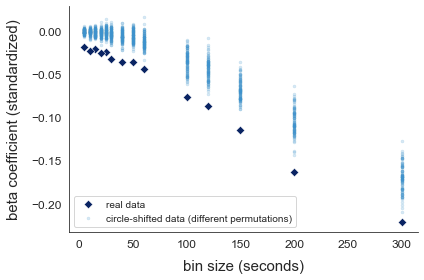

In [89]:
df_real = pd.read_csv(os.path.join(base_dir, 'Analyses', 'within_convo_analysis_different_bins_strangers.csv'))
df_shifted = pd.read_csv(os.path.join(base_dir, 'Analyses', 'within_convo_analysis_circle_shifted_strangers.csv'))

marker_real = 'D'
marker_shuffled = '.'

sns.scatterplot(x="bin_size", y="beta", data=df_real, marker=marker_real, color='#0A2463', label="real data")
sns.scatterplot(x="bin_size", y="betas", data=df_shifted, marker=marker_shuffled, 
                color='#3E92CC', alpha=0.2, edgecolor='#3E92CC',
                label="circle-shifted data (different permutations)")

plt.xlabel('bin size (seconds)', fontsize=15, labelpad=10)
plt.ylabel('beta coefficient (standardized)', fontsize=15, labelpad=10)

plt.tick_params(labelsize=12)

sns.despine()
plt.tight_layout()

plt.savefig(os.path.join(base_dir, 'Figures', 'within_convo_analysis_strangers.png'), dpi=300)


# Quantify performance

How many times (out of 100) does the real beta outperform the circle-shifted data?


In [79]:
performance = pd.DataFrame()
performance = performance.fillna(0)
counter = 0

for i in range(len(df_real)):
    
    bin_size = df_real.at[i, 'bin_size']
    beta_real = df_real.at[i, 'beta']
    data_shifted_bin_subset = df_shifted.loc[df_shifted['bin_size'] == bin_size]
    data_shifted_bin_subset_beat_num = data_shifted_bin_subset.loc[data_shifted_bin_subset['betas'] > beta_real]
    
    performance.at[counter, 'bin_size'] = bin_size
    performance.at[counter, 'beta_beats_null'] = len(data_shifted_bin_subset_beat_num)

    counter += 1

In [80]:
performance

,bin_size,beta_beats_null
0,300.0,100.0
1,200.0,100.0
2,150.0,100.0
3,120.0,100.0
4,100.0,100.0
5,60.0,100.0
6,50.0,100.0
7,40.0,100.0
8,30.0,100.0
9,25.0,100.0


# Repeat with self / partner effects

Will need to store these values separetely. Plot both of them as well.

In [90]:
data = pd.read_csv(os.path.join(base_dir,'Analyses','binned_connection_and_gaps_by_speaker_strangers.csv'))


## Effect of gap length on connection for each bin size


In [91]:
df_real_speaker = pd.DataFrame()
df_real_speaker = df_real_speaker.fillna(0)
counter = 0

num_bins_list = [2, 3, 4, 5, 6, 10, 12,
                15, 20, 24, 30, 40, 60, 120]

for num_bins in num_bins_list:
    
    columns = [f'connection_{num_bins}', f'gap_length_mean_speaker_{num_bins}', f'gap_length_mean_partner_{num_bins}', 'bin_num', 'subID', 'dyad']
    data_subset = data[columns]
    data_subset_no_nans = data_subset.loc[data_subset['bin_num'] <= (num_bins - 1)].reset_index(drop=True)

    variables = [f'connection_{num_bins}', f'gap_length_mean_speaker_{num_bins}', f'gap_length_mean_partner_{num_bins}', 'bin_num']
    for variable in variables:
        data_subset_no_nans[f'{variable}_zscore'] = zscore(data_subset_no_nans[variable])

    model = Lmer(f"connection_{num_bins}_zscore ~ gap_length_mean_speaker_{num_bins}_zscore + gap_length_mean_partner_{num_bins}_zscore + bin_num_zscore + (1 + gap_length_mean_speaker_{num_bins}_zscore + gap_length_mean_partner_{num_bins}_zscore |subID) + (1 + bin_num_zscore |dyad)", data=data_subset_no_nans)
    model.fit()
        
    df_real_speaker.at[counter, 'num_bins'] = num_bins
    df_real_speaker.at[counter, 'bin_size'] = 600 / num_bins
    df_real_speaker.at[counter, 'beta_self'] = model.coefs['Estimate'][1] 
    df_real_speaker.at[counter, 'p-val_self'] = model.coefs['P-val'][1]
    df_real_speaker.at[counter, 'beta_partner'] = model.coefs['Estimate'][2] 
    df_real_speaker.at[counter, 'p-val_partner'] = model.coefs['P-val'][2]

    counter += 1
        
df_real_speaker.to_csv(os.path.join(base_dir, 'Analyses', 'within_convo_analysis_different_bins_by_speakers_strangers.csv'), encoding='utf-8', index=False)
    

boundary (singular) fit: see ?isSingular 

Formula: connection_2_zscore~gap_length_mean_speaker_2_zscore+gap_length_mean_partner_2_zscore+bin_num_zscore+(1+gap_length_mean_speaker_2_zscore+gap_length_mean_partner_2_zscore|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1395.385 	 AIC: 2790.770

Random effects:

                                      Name    Var    Std
dyad                           (Intercept)  0.240  0.490
dyad                        bin_num_zscore  0.005  0.070
subID                          (Intercept)  0.309  0.556
subID     gap_length_mean_speaker_2_zscore  0.031  0.176
subID     gap_length_mean_partner_2_zscore  0.001  0.037
Residual                                    0.296  0.544

                                    IV1                               IV2  \
dyad                        (Intercept)                    bin_num_zscore   
subID                

unable to evaluate scaled gradient 

Model failed to converge: degenerate  Hessian with 1 negative eigenvalues 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_12_zscore~gap_length_mean_speaker_12_zscore+gap_length_mean_partner_12_zscore+bin_num_zscore+(1+gap_length_mean_speaker_12_zscore+gap_length_mean_partner_12_zscore|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7728	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7149.874 	 AIC: 14299.748

Random effects:

                                       Name    Var    Std
dyad                            (Intercept)  0.306  0.553
dyad                         bin_num_zscore  0.057  0.238
subID                           (Interce

Model failed to converge with max|grad| = 0.00443644 (tol = 0.002, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: connection_60_zscore~gap_length_mean_speaker_60_zscore+gap_length_mean_partner_60_zscore+bin_num_zscore+(1+gap_length_mean_speaker_60_zscore+gap_length_mean_partner_60_zscore|subID)+(1+bin_num_zscore|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 38640	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -23300.907 	 AIC: 46601.813

Random effects:

                                       Name    Var    Std
dyad                            (Intercept)  0.308  0.555
dyad                         bin_num_zscore  0.063  0.251
subID                           (Intercept)  0.283  0.532
subID     g

In [92]:
df_real_speaker

,num_bins,bin_size,beta_self,p-val_self,beta_partner,p-val_partner
0,2.0,300.0,-0.080394,0.023312,-0.165406,3.618969e-10
1,3.0,200.0,-0.065954,0.008888,-0.122296,1.432036e-07
2,4.0,150.0,-0.039997,0.072677,-0.093260,4.124417e-07
3,5.0,120.0,-0.037135,0.059449,-0.067134,6.465975e-05
4,6.0,100.0,-0.030871,0.091723,-0.060221,1.254673e-04
5,10.0,60.0,-0.019372,0.173600,-0.039136,3.852504e-04
6,12.0,50.0,-0.019002,0.108492,-0.028525,1.802223e-03
7,15.0,40.0,-0.013609,0.188927,-0.034554,1.495002e-04
8,20.0,30.0,-0.010385,0.279138,-0.030927,4.241212e-05
9,24.0,25.0,-0.012998,0.133700,-0.022411,1.376433e-03


## Plot

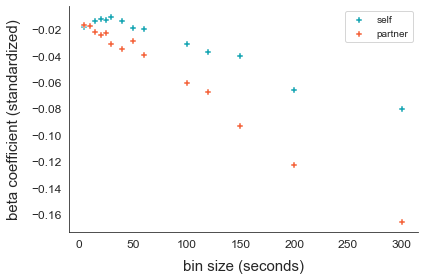

In [106]:
df_real_speaker = pd.read_csv(os.path.join(base_dir, 'Analyses', 'within_convo_analysis_different_bins_by_speakers_strangers.csv'))

marker_real = 'P'
marker_shuffled = '.'

sns.scatterplot(x="bin_size", y="beta_self", data=df_real_speaker, marker=marker_real, 
                color='#0FA3B1', label="self")
sns.scatterplot(x="bin_size", y="beta_partner", data=df_real_speaker, marker=marker_real, 
                color='#F46036', label="partner")

plt.xlabel('bin size (seconds)', fontsize=15, labelpad=10)
plt.ylabel('beta coefficient (standardized)', fontsize=15, labelpad=10)

plt.tick_params(labelsize=12)

sns.despine()
plt.tight_layout()

plt.savefig(os.path.join(base_dir, 'Figures', 'within_convo_analysis_partner_strangers.png'), dpi=300)


## Circle-shift each bin

Note: These don't work well with the random slope structure. Could remove and try again, but would want to do the same for the real data as well. Main point here is that the partner effect is consistently larger across bins. Don't really need to do the circle-shifting to show that.

In [98]:
df_shifted_speaker = pd.DataFrame()
df_shifted_speaker = df_shifted_speaker.fillna(0)
counter = 0

#num_bins_list = [2, 3, 4, 5, 6, 10, 12,
#                15, 20, 24, 30, 40, 60, 120]
num_bins_list = [3, 4, 5, 6, 10, 12,
                15, 20, 24, 30, 40, 60, 120]

for num_bins in num_bins_list:
    
    columns = [f'connection_{num_bins}', f'gap_length_mean_speaker_{num_bins}', f'gap_length_mean_partner_{num_bins}', 'bin_num', 'subID', 'dyad']
    data_subset = data[columns]
    data_subset_no_nans = data_subset.loc[data_subset['bin_num'] <= (num_bins - 1)].reset_index(drop=True)

    variables = [f'connection_{num_bins}', f'gap_length_mean_speaker_{num_bins}', f'gap_length_mean_partner_{num_bins}', 'bin_num']
    for variable in variables:
        data_subset_no_nans[f'{variable}_zscore'] = zscore(data_subset_no_nans[variable])

    shifted_betas_self = []
    shifted_p_vals_self = []
    shifted_betas_partner = []
    shifted_p_vals_partner = []

    for _ in tqdm(range(100)):

        for i in range(len(data_subset_no_nans)):
            data_subset_no_nans.loc[i,'joined'] = str(data_subset_no_nans.loc[i, f'gap_length_mean_speaker_{num_bins}_zscore']) + '_' + str(data_subset_no_nans.loc[i,f'gap_length_mean_partner_{num_bins}_zscore'])
        
        data_subset_no_nans.loc[:,'joined_shifted'] = data_subset_no_nans['joined'].groupby(data_subset_no_nans['dyad']).transform(circle_shift)
        
        for i in range(len(data_subset_no_nans)):
            data_subset_no_nans.at[i,f'gap_length_mean_speaker_{num_bins}_shifted'] = data_subset_no_nans['joined_shifted'][i].split('_')[0]
            data_subset_no_nans.at[i,f'gap_length_mean_partner_{num_bins}_shifted'] = data_subset_no_nans['joined_shifted'][i].split('_')[1]

        model = Lmer(f"connection_{num_bins}_zscore ~ gap_length_mean_speaker_{num_bins}_shifted + gap_length_mean_partner_{num_bins}_shifted + bin_num_zscore + (1 + gap_length_mean_speaker_{num_bins}_shifted + gap_length_mean_partner_{num_bins}_shifted |subID) + (1 + bin_num_zscore |dyad)", data=data_subset_no_nans)
        model.fit()

        shifted_betas_self.append(model.coefs['Estimate'][1])
        shifted_p_vals_self.append(model.coefs['P-val'][1])
        shifted_betas_partner.append(model.coefs['Estimate'][2])
        shifted_p_vals_partner.append(model.coefs['P-val'][2])
        
    for i in range(len(shifted_betas)):
        df_shifted_speaker.at[counter, 'num_bins'] = num_bins
        df_shifted_speaker.at[counter, 'bin_size'] = 600 / num_bins
        df_shifted_speaker.at[counter, 'betas_self'] = shifted_betas_self[i]
        df_shifted_speaker.at[counter, 'p-val_self'] = shifted_p_vals_self[i]
        df_shifted_speaker.at[counter, 'betas_partner'] = shifted_betas_partner[i]
        df_shifted_speaker.at[counter, 'p-val_partner'] = shifted_p_vals_partner[i]
        
        counter += 1
        
df_shifted_speaker.to_csv(os.path.join(base_dir, 'Analyses', 'within_convo_analysis_circle_shifted_by_speaker_strangers.csv'), encoding='utf-8', index=False)
    

  0%|          | 0/100 [06:41<?, ?it/s]


RRuntimeError: Error: number of observations (=1932) <= number of random effects (=252318) for term (1 + gap_length_mean_speaker_3_shifted + gap_length_mean_partner_3_shifted | subID); the random-effects parameters and the residual variance (or scale parameter) are probably unidentifiable
